In [60]:
import glob
import os
import torch
import numpy as np
import xarray as xr
import netCDF4 as nc
import pandas as pd
import simpy as sp
import logging
import tqdm
from itertools import product
import multiprocessing as mp
from multiprocessing import Pool
from typing import Any, Iterable
from datetime import datetime as dt, timedelta as td

In [2]:
import cdsapi

In [3]:
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [4]:
os.chdir('..')

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from datasets.retrieval import grab_df_from_era5_csvs
from datasets.km_dataset import DeepKoopmanDataset
from models.km_classical import ClassicalKoopmanAnalysis
from models.km_havoc import HAVOCAnalysis
from models.km_net import DeepKoopmanWrapper

In [7]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [8]:
import matplotlib.pyplot as plt

In [9]:
NCPU = mp.cpu_count() - 1

# EDA Koopman Forecast of Maritime Weather

## ERA5 Around Hamburg Harbor

ERA5 is a dataset which provides hourly maritime weather data.<br>
Its API does only provide single point measurements, but we can play a little and grab this data for multiple points all together.

![Map with coordinated of HH harbor with midpoint of the grid.](../img/map_grid_hhh.png)<br>
*Coastal map. The blue point is at coordinates lon 10 and lat 53.5, around Hamburg Harbor.*<br>
*The red dot is representing the initial radius taken when data mining the region of interest.*<br>
*One can see that that the mean on that point needs to be far more at the caostal line to get sufficiant forecasting!*

![Map with the grid of sampled datapoints.](../img/map_grid_hhh_2.png)<br>
*Coastal map with maritime weather datapoint (ERA5) for coastal line related to HH Habor.* <br>
*The blue points are complete and red ones have missing data. Only the blue ones will be considered.*<br>

In [10]:
# params
data_path = './data'
center_lon, center_lat = 5.5, 56.5
radius = 4.5
step = 0.5
start_date = '2025-02-01'
end_date = '2025-09-30'

output_dir = os.path.join(data_path, f"{start_date}--{end_date}")
lon_vals = np.arange(center_lon - radius, center_lon + radius + step, step)
lat_vals = np.arange(center_lat - radius, center_lat + radius + step, step)

In [ ]:
df_cluster = grab_df_from_era5_csvs(output_dir, lat_vals, lon_vals)
df_cluster

time      u100      v100       u10       v10  \
0        2025-02-01 00:00:00 -1.227249  4.551605 -0.971558  2.206314   
1        2025-02-01 01:00:00 -1.344467  4.589905 -1.027405  2.290192   
2        2025-02-01 02:00:00 -1.250153  4.995331 -0.835266  2.517288   
3        2025-02-01 03:00:00 -1.073959  5.168274 -0.689453  2.575562   
4        2025-02-01 04:00:00 -0.700256  5.065414 -0.453903  2.541901   
...                      ...       ...       ...       ...       ...   
2096683  2025-09-30 19:00:00 -1.078003  3.887268 -0.837814  1.905701   
2096684  2025-09-30 20:00:00 -0.953369  3.793167 -0.762024  1.887436   
2096685  2025-09-30 21:00:00 -0.952301  3.694656 -0.779129  1.820908   
2096686  2025-09-30 22:00:00 -0.584839  2.949158 -0.589203  1.509872   
2096687  2025-09-30 23:00:00 -0.828766  2.516235 -0.677994  1.323227   

               d2m        t2m         msl  sst        skt          sp  ssrd  \
0        276.52350  277.55730  103012.190  NaN  275.89688  102521.016   0.0   
1        276.49360  277.50160  103025.500  NaN  275.48804  102534.330   0.0   
2        276.37183  277.37183  103046.810  NaN  275.55533  102554.920   0.0   
3        275.93164  276.87340  103048.560  NaN  275.18945  102556.310   0.0   
4        275.88983  276.80780  103031.750  NaN  275.37950  102539.140   0.0   
...            ...        ...         ...  ...        ...         ...   ...   
2096683  277.56770  278.32910  103420.125  NaN  278.16960   95322.080   0.0   
2096684  277.37200  277.93220  103431.625  NaN  278.13623   95328.805   0.0   
2096685  277.21252  277.76376  103446.375  NaN  277.84314   95336.560   0.0   
2096686  277.02023  277.70374  103458.060  NaN  277.23773   95322.200   0.0   
2096687  276.61664  277.28546  103450.060  NaN  277.09850   95311.266   0.0   

               strd            tp   lat   lon  mwd  mwp  swh  
0         987721.60  0.000000e+00  52.0   1.0  NaN  NaN  NaN  
1        1026047.44  0.000000e+00  52.0   1.0  NaN  NaN  NaN  
2        1021265.70  0.000000e+00  52.0   1.0  NaN  NaN  NaN  
3         958170.00  4.768372e-07  52.0   1.0  NaN  NaN  NaN  
4         979850.20  0.000000e+00  52.0   1.0  NaN  NaN  NaN  
...             ...           ...   ...   ...  ...  ...  ...  
2096683  1168652.20  3.099441e-05  61.0  10.0  NaN  NaN  NaN  
2096684  1155937.60  2.861023e-05  61.0  10.0  NaN  NaN  NaN  
2096685  1173570.80  3.004074e-05  61.0  10.0  NaN  NaN  NaN  
2096686  1146051.50  3.337860e-05  61.0  10.0  NaN  NaN  NaN  
2096687  1152876.50  2.479553e-05  61.0  10.0  NaN  NaN  NaN  

[2096688 rows x 19 columns]

In [ ]:
df_cluster = df_cluster.dropna(subset=[
    'sp',
    'ssrd',
    'strd',
    'tp',
    'mwd',
    'mwp',
    'swh'
])

In [ ]:
df_cluster.shape

(1422960, 19)

In [ ]:
# prefilter lat, lon and time
lat_max, lat_min = df_cluster['lat'].max(), df_cluster['lat'].min()
lon_max, lon_min = df_cluster['lon'].max(), df_cluster['lon'].min()
df_cluster['time'] = pd.to_datetime(df_cluster['time'])
time_max, time_min = df_cluster['time'].max(), df_cluster['time'].min()

filt_lat = np.arange(lat_min, lat_max, step)[::3].tolist()
filt_lon = np.arange(lon_min, lon_max, step)[::3].tolist()

filt_time = (df_cluster['time'].dt.date > (dt.date(time_max - td(days=24)))).values
sprt_time = pd.to_datetime(pd.Series(pd.date_range(time_min, time_max, periods=24))).astype(int).values
sprt_date = pd.to_datetime(pd.Series(pd.date_range(time_min, time_max, periods=24))).dt.date.unique()

C:\Users\szaif\AppData\Local\Temp\ipykernel_27352\293329128.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'])


In [ ]:
idx_lat = df_cluster['lat'].apply(lambda x: x in filt_lat).values
idx_lon = df_cluster['lon'].apply(lambda x: x in filt_lon).values
idx_sptm = pd.to_datetime(df_cluster['time'].dt.date).astype(int).apply(lambda x: x in sprt_time).values
idx_time = filt_time

In [16]:
print(sum(idx_lat & idx_lon))
print(sum(idx_sptm & idx_lat & idx_lon))
print(sum(idx_time & idx_lat & idx_lon))

168432
696
16704


In [ ]:
df_sprt = df_cluster.copy()
df_sprt = df_sprt[idx_sptm & idx_lat & idx_lon]

df_filt = df_cluster.copy()
df_filt = df_filt[idx_time & idx_lat & idx_lon]

In [ ]:
df_cluster['date'] = df_cluster['time'].dt.date
df_sprt['date'] = df_sprt['time'].dt.date
df_filt['date'] = df_filt['time'].dt.date

C:\Users\szaif\AppData\Local\Temp\ipykernel_27352\4121194061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['time'].dt.date


In [19]:
df_sprt

time      u100      v100       u10       v10  \
17424   2025-02-01 00:00:00 -0.057327  5.897308 -0.343628  4.855728   
17425   2025-02-01 01:00:00  0.351822  6.226623  0.056580  5.187653   
17426   2025-02-01 02:00:00  0.977387  6.259979  0.670593  5.294632   
17427   2025-02-01 03:00:00  1.181900  6.068665  0.886719  5.216187   
17428   2025-02-01 04:00:00  1.322205  5.942368  1.015823  5.196198   
...                     ...       ...       ...       ...       ...   
1724995 2025-02-01 19:00:00 -1.769836 -0.111984 -1.722992 -0.388947   
1724996 2025-02-01 20:00:00 -0.715958 -0.211639 -0.734039 -0.508316   
1724997 2025-02-01 21:00:00  0.121078 -0.493027  0.020920 -1.009049   
1724998 2025-02-01 22:00:00  0.962509 -1.251816  0.521133 -1.836746   
1724999 2025-02-01 23:00:00 -0.468872 -1.554840 -0.921448 -1.950714   

               d2m        t2m         msl        sst        skt          sp  \
17424    278.41022  279.51434  102954.690  279.51782  279.70157  102953.016   
17425    278.23187  279.42932  102956.000  279.51782  279.68335  102955.330   
17426    278.05933  279.31520  102982.060  279.51782  279.69986  102980.920   
17427    277.91992  279.20154  102983.310  279.51782  279.69922  102982.310   
17428    277.80975  279.09100  102974.500  279.51782  279.69003  102973.140   
...            ...        ...         ...        ...        ...         ...   
1724995  273.68230  276.68713  102965.375  278.50415  278.27832  102976.516   
1724996  273.69140  276.71630  102939.875  278.50415  278.13630  102950.840   
1724997  273.69006  276.66820  102892.750  278.50415  278.18948  102903.270   
1724998  274.23816  276.77990  102832.810  278.56348  278.18787  102842.970   
1724999  274.23138  276.52847  102784.375  278.56348  278.23035  102795.200   

         ssrd        strd        tp   lat  lon        mwd       mwp       swh  \
17424     0.0  1194217.60  0.000020  53.5  1.0  354.31550  6.610472  0.778627   
17425     0.0  1182527.50  0.000021  53.5  1.0  354.74470  6.420084  0.772938   
17426     0.0  1136913.80  0.000027  53.5  1.0  354.81433  6.235035  0.769620   
17427     0.0  1137722.00  0.000015  53.5  1.0  355.33190  6.135874  0.758468   
17428     0.0  1143082.20  0.000012  53.5  1.0  355.76013  6.044157  0.747329   
...       ...         ...       ...   ...  ...        ...       ...       ...   
1724995   0.0  1073788.90  0.000003  58.0  8.5  270.53430  4.511496  0.363034   
1724996   0.0   970442.94  0.000001  58.0  8.5  263.49835  4.527698  0.349084   
1724997   0.0   969464.30  0.000002  58.0  8.5  257.29703  4.527389  0.338127   
1724998   0.0   930045.75  0.000002  58.0  8.5  251.89894  4.719585  0.314688   
1724999   0.0   964057.75  0.000002  58.0  8.5  248.60602  4.631077  0.314179   

               date  
17424    2025-02-01  
17425    2025-02-01  
17426    2025-02-01  
17427    2025-02-01  
17428    2025-02-01  
...             ...  
1724995  2025-02-01  
1724996  2025-02-01  
1724997  2025-02-01  
1724998  2025-02-01  
1724999  2025-02-01  

[696 rows x 20 columns]

## Temporal Decompositions

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
from skopt import gp_minimize
from skopt.space import Integer
from skopt.plots import plot_convergence

In [21]:
variables = {
    "t2m":  "2m Temperature",
    "msl":  "Mean Sea Level",
    "skt":  "Skin Temperature",
    "sp":   "Surface Pressure",
    "ssrd": "Surface Solar Radiation Downwards",
    "tp":   "Total Precipitation"
}

#### loop over all spread dates and coordinates

In [ ]:
def grab_coord_day_datapoint(
    datepoint: Any = sprt_date[np.random.choice(np.arange(len(sprt_date)))],
    latpoint: float = lat_vals[len(lat_vals)//2],
    lonpoint: float = lon_vals[len(lon_vals)//2],
    datedelta: int = 7
) -> (pd.DataFrame|None):
    dateindex = df_cluster['time'].dt.date == datepoint
    logging.debug(f". {datepoint}: {sum(dateindex)}")
    for _ in range(1, datedelta):
        datepoint = datepoint + td(days=1)
        dateindex |= df_cluster['time'].dt.date == datepoint
        logging.debug(f"+ {datepoint}: {sum(dateindex)}")
    coordindex = df_cluster['lat'] == latpoint
    coordindex &= df_cluster['lon'] == lonpoint
    if sum(dateindex & coordindex) > 0:
        return df_cluster.loc[dateindex & coordindex, ['time', 'date', 'lat', 'lon'] + list(variables.keys())].copy()
    else:
        logging.warning(f'Empty dataframe for date {datepoint}, lat {latpoint}, lon {lonpoint}')
        return None

In [80]:
grab_coord_day_datapoint()

time        date   lat  lon        t2m         msl  \
1049712 2025-07-29 00:00:00  2025-07-29  56.5  5.5  289.47034  101357.940   
1049713 2025-07-29 01:00:00  2025-07-29  56.5  5.5  289.49872  101346.190   
1049714 2025-07-29 02:00:00  2025-07-29  56.5  5.5  289.55847  101291.310   
1049715 2025-07-29 03:00:00  2025-07-29  56.5  5.5  289.57980  101249.060   
1049716 2025-07-29 04:00:00  2025-07-29  56.5  5.5  289.57470  101234.310   
...                     ...         ...   ...  ...        ...         ...   
1049875 2025-08-04 19:00:00  2025-08-04  56.5  5.5  290.31110  100058.440   
1049876 2025-08-04 20:00:00  2025-08-04  56.5  5.5  290.14587  100085.810   
1049877 2025-08-04 21:00:00  2025-08-04  56.5  5.5  290.03308  100112.560   
1049878 2025-08-04 22:00:00  2025-08-04  56.5  5.5  289.87183  100107.625   
1049879 2025-08-04 23:00:00  2025-08-04  56.5  5.5  289.64697  100116.875   

               skt          sp      ssrd        tp  
1049712  291.33734  101353.590       0.0  0.000024  
1049713  291.34332  101342.270       0.0  0.000014  
1049714  291.35263  101287.850       0.0  0.000007  
1049715  291.35350  101244.560       0.0  0.000018  
1049716  291.35907  101229.910    7296.0  0.000015  
...            ...         ...       ...       ...  
1049875  290.03460  100053.336  308928.0  0.000000  
1049876  290.02590  100081.410   34368.0  0.000000  
1049877  290.02155  100108.720       0.0  0.000000  
1049878  290.03015  100103.450       0.0  0.000000  
1049879  290.03296  100112.170       0.0  0.000000  

[168 rows x 10 columns]

In [ ]:
filt_coord = list(set(
    zip(df_cluster['lat'].tolist(), df_cluster['lon'].tolist())
).intersection(
    zip(filt_lat, filt_lon)
))
(filt_lat, filt_lon) = zip(*filt_coord)
filt_coord, filt_lat, filt_lon

([(58.0, 7.0), (56.5, 5.5), (55.0, 4.0), (53.5, 2.5)],
 (58.0, 56.5, 55.0, 53.5),
 (7.0, 5.5, 4.0, 2.5))

In [97]:
len(decomps)

368

In [101]:
df_filt.shape

(16704, 20)

In [ ]:
df_filt.loc[coord_filt, variables.keys()].dropna()

t2m         msl        skt          sp  ssrd        tp
1050672  289.71964  102257.625  289.90588  102252.860   0.0  0.000000
1050673  289.70273  102208.440  289.91490  102203.650   0.0  0.000000
1050674  289.75543  102186.690  289.92572  102182.350   0.0  0.000000
1050675  289.81592  102173.310  289.93155  102168.670   0.0  0.000000
1050676  289.88727  102103.560  289.94385  102098.690   0.0  0.000000
...            ...         ...        ...         ...   ...       ...
1051243  287.08105  102894.125  288.28677  102889.080   0.0  0.000029
1051244  286.98102  102885.875  288.26514  102881.805   0.0  0.000023
1051245  286.93173  102907.625  288.27870  102903.560   0.0  0.000040
1051246  287.19788  102890.060  288.30414  102885.200   0.0  0.000065
1051247  287.25226  102890.310  288.32507  102886.266   0.0  0.000072

[576 rows x 6 columns]

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(3)] before, using random point [np.int64(11)]

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(3)] before, using random point [np.int64(9)]

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(3)] before, using random point [np.int64(16)]

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(3)] before, using random point [np.int64(18)]

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.int64(3)] before, using random point [np.int64(13

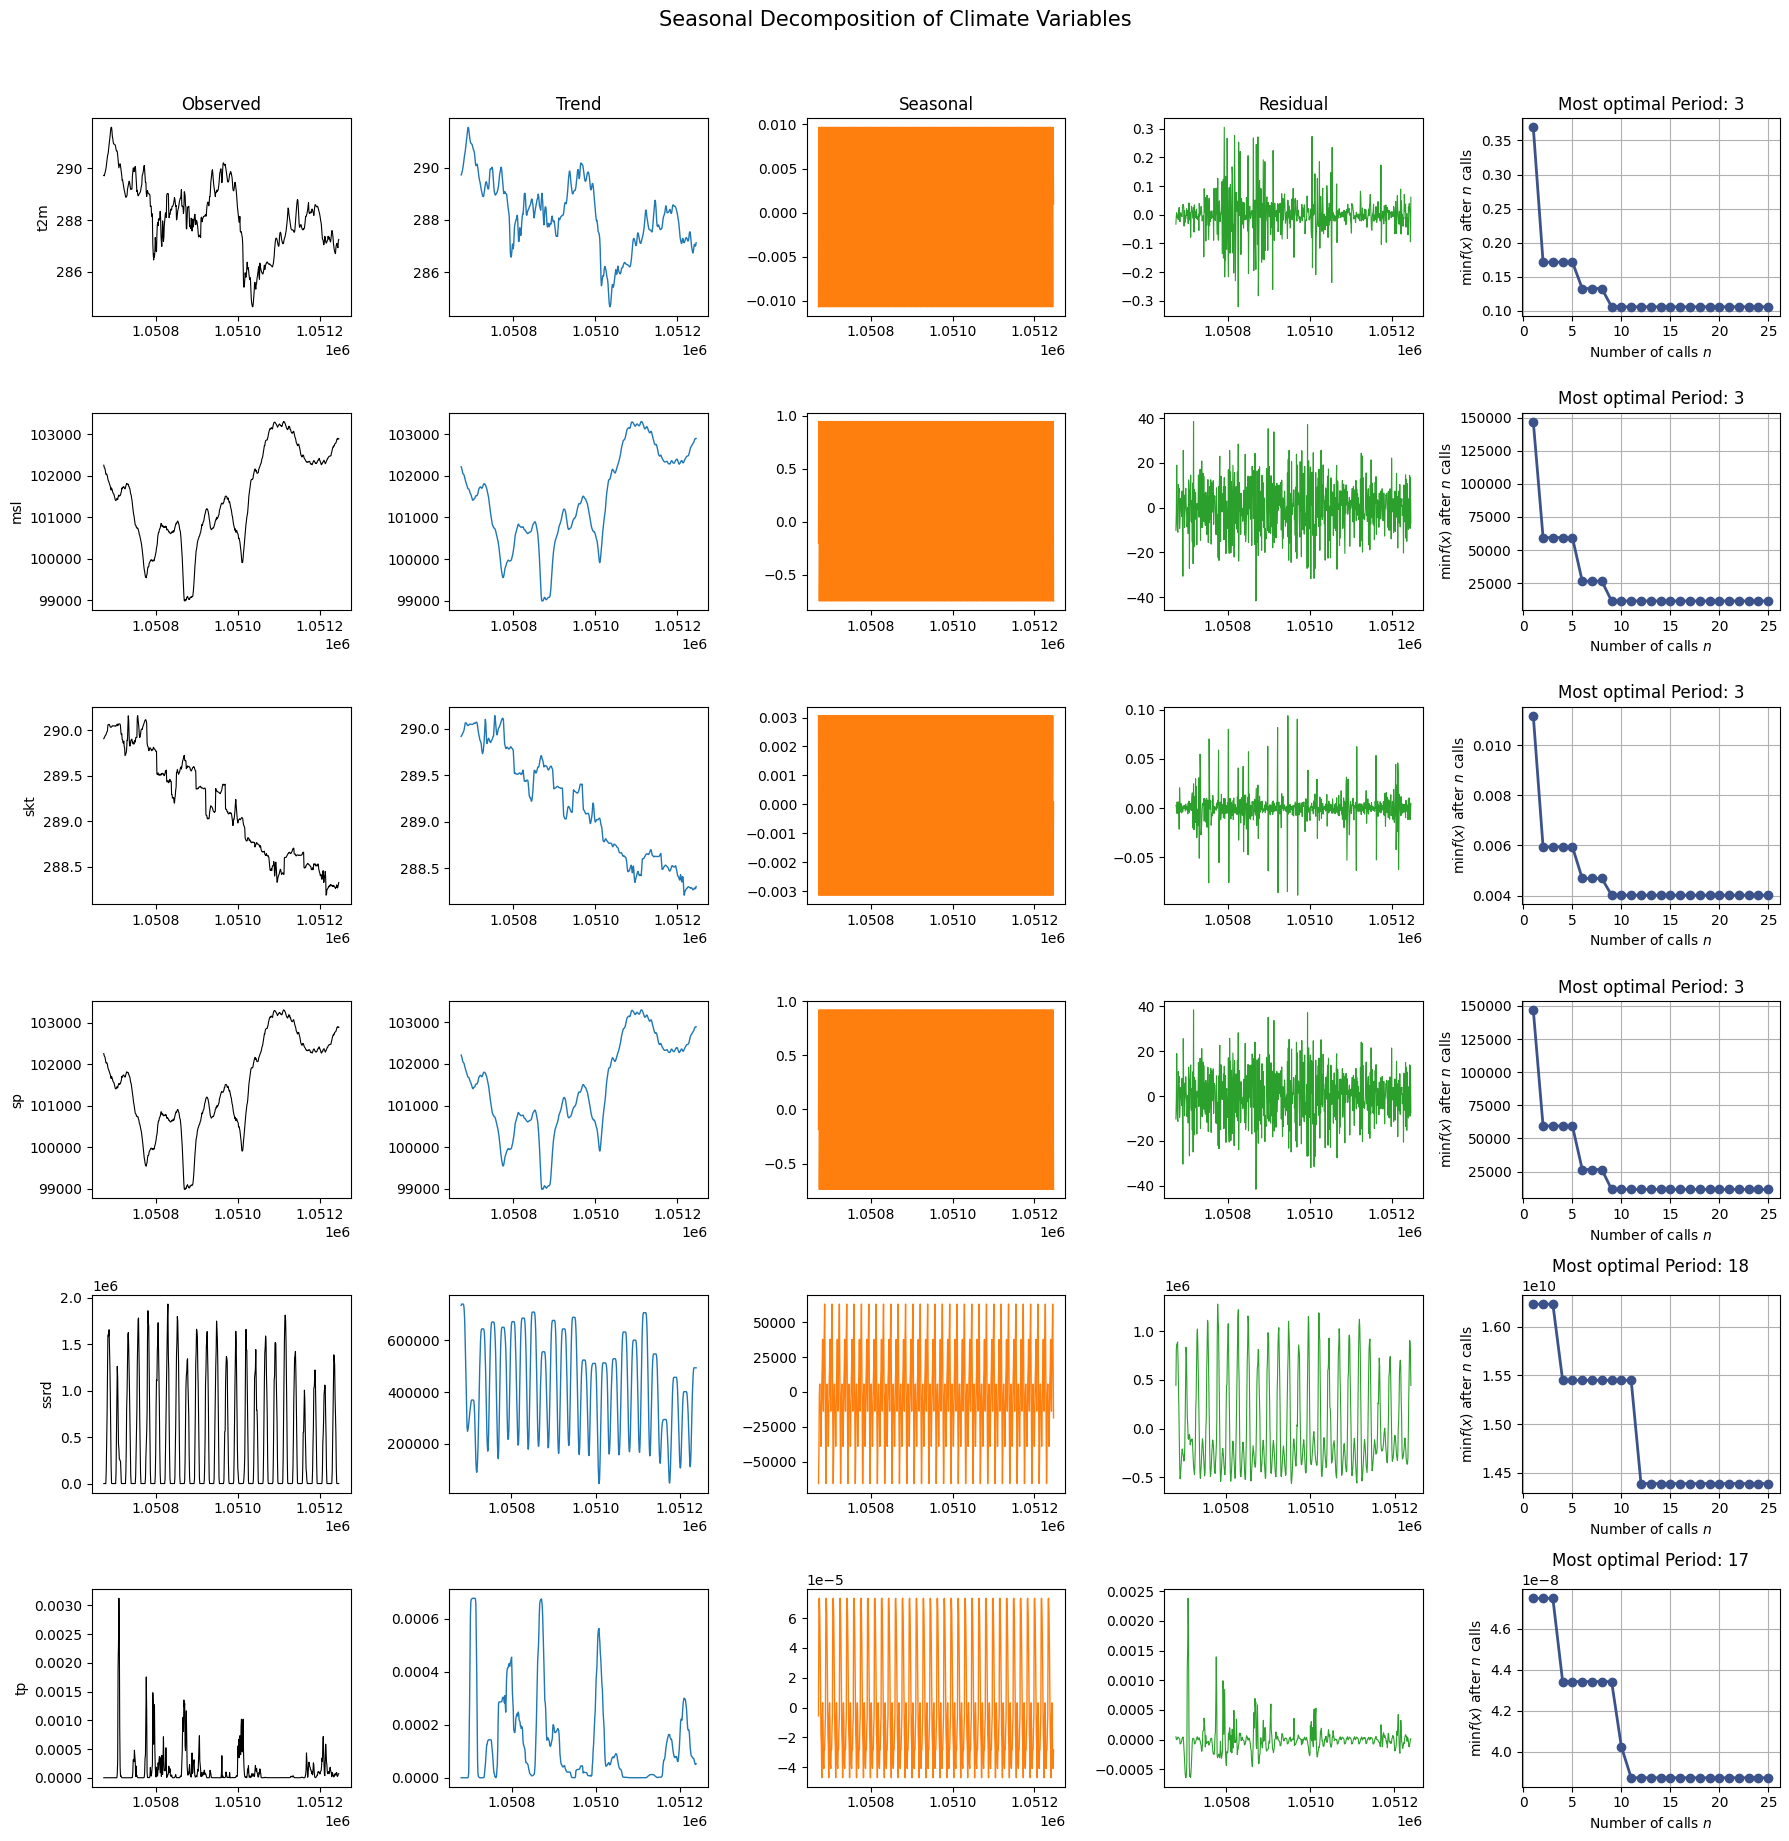

In [187]:
# Prepare a grid of subplots (rows per variable)
n_vars = len(variables)
# Define search space — e.g., range of candidate periods (hourly → 6h to 120 days)
periods = [Integer(3, 18, name="period")]

lat_val = lat_vals[len(lat_vals)//2]
lon_val = lon_vals[len(lon_vals)//2]

coord_filt = (df_filt['lat'] == lat_val) & (df_filt['lon'] == lon_val)

# main plot frame
fig, axes = plt.subplots(
    nrows=n_vars, ncols=5, figsize=(18, 3 * n_vars)
)
column_titles = ["Observed", "Trend", "Seasonal", "Residual", "Period Convergence"]
for j, title in enumerate(column_titles):
    axes[0, j].set_title(title, fontsize=12)

# Loop and plot results for each variable
for i, var in enumerate(variables):
    series = df_filt.loc[coord_filt, var].dropna()

    # Define objective function to minimize residual error
    def objective(period) -> (Any | float):
        period = 8*period[0]
        try:
            result = seasonal_decompose(series, model="additive", period=int(period))
            resid = result.resid.dropna()
            # compute sum of squared residual
            score = np.mean(resid.values ** 2)
        except Exception:
            score = np.inf  # invalid period or failed decomposition
        return score

    # Run Bayesian optimization
    res = gp_minimize(
        objective,
        dimensions=periods,
        n_calls=25,
        n_random_starts=8,
        random_state=42,
    )

    # parse "optimal" period
    period = res.x[0]
    
    # get final decomposition
    result = seasonal_decompose(series, model="additive", period=period)

    axes[i, 0].plot(result.observed, color="black", lw=0.8)
    axes[i, 0].set_ylabel(var)
    axes[i, 1].plot(result.trend, color="tab:blue", lw=1.0)
    axes[i, 2].plot(result.seasonal, color="tab:orange", lw=1.0)
    axes[i, 3].plot(result.resid, color="tab:green", lw=0.8)
    plot_convergence(res, ax=axes[i, 4])
    axes[i, 4].set_title(f"Most optimal Period: {period}")

plt.suptitle("Seasonal Decomposition of Climate Variables", fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
def opt_decomp(
    data: pd.DataFrame, 
    variables: list[str] = list(variables.keys()),
    p_low: int = 18,
    p_high: int = 24,
    p_dt: int = 1,
    gp_n_iter: int = 15
) -> tuple[pd.DataFrame, list[dict[str, Any]]]:
    # Define search space — e.g., range of candidate periods 
    # hourly → `days_low` days to `days_high` days 
    periods = [Integer(
        p_low, 
        p_high, 
        name="period"
    )]
    # Loop and plot results for each variable
    results = []
    for var in variables:
        series = data[var].dropna()

        # Define objective function to minimize residual error
        def objective(period) -> (Any | float):
            period = p_dt * period[0]
            try:
                result = seasonal_decompose(series, model="additive", period=int(period))
                resid = result.resid.dropna()
                # compute sum of squared residual
                score = np.mean(resid.values ** 2)
            except Exception as e:
                err_tuple = f"\
                    var: {var};  date-range:  {data['date'].min()} - {data['date'].max()}\n\
                    lat: {data['lat'].values};  lon: {data['lon'].values}\
                    period: {period}"
                print(f'Cannot decompose {err_tuple} {e}')
                score = 1000000  # invalid period or failed decomposition
            return score

        # Run Bayesian optimization
        try:
            res = gp_minimize(
                objective,
                dimensions=periods,
                n_calls=gp_n_iter,
                n_random_starts=4,
                random_state=42,
                n_jobs=NCPU
            )
        except Exception as e:
            err_tuple = f"\
                var: {var};  date-range:  {data['date'].min()} - {data['date'].max()}\n\
                lat: {data['lat'].values};  lon: {data['lon'].values}"
            print(f'Cannot decompose {err_tuple}: {e}')
            

        # parse "optimal" period
        period = res.x[0]
        
        # get final decomposition
        result = seasonal_decompose(series, model="additive", period=period)

        # overload decomposition
        data[f'{var}_season'] = result.seasonal
        data[f'{var}_trend'] = result.trend
        data[f'{var}_resid'] = result.resid

        results += [{
            'time': data['time'].unique(),
            'lon': data['lon'].unique()[0],
            'lat': data['lat'].unique()[0],
            'decomp': result,
            'period': period
        }]

    return data, results


In [ ]:
# using 7 days each to have enough cycles
decomps = []
for args in tqdm.tqdm(product(sprt_date, filt_lat, filt_lon)):
    decomps += [opt_decomp(grab_coord_day_datapoint(*args))]
    

0it [00:00, ?it/s]

                       time        date   lat  lon        t2m         msl  \
1393920 2025-02-01 00:00:00  2025-02-01  58.0  7.0  275.32490  102814.440   
1393921 2025-02-01 01:00:00  2025-02-01  58.0  7.0  274.94300  102879.750   
1393922 2025-02-01 02:00:00  2025-02-01  58.0  7.0  274.69604  102914.810   
1393923 2025-02-01 03:00:00  2025-02-01  58.0  7.0  274.60388  102925.310   
1393924 2025-02-01 04:00:00  2025-02-01  58.0  7.0  274.63593  102990.500   
...                     ...         ...   ...  ...        ...         ...   
1394083 2025-02-07 19:00:00  2025-02-07  58.0  7.0  275.83197  103924.560   
1394084 2025-02-07 20:00:00  2025-02-07  58.0  7.0  275.83570  103895.750   
1394085 2025-02-07 21:00:00  2025-02-07  58.0  7.0  275.87918  103874.310   
1394086 2025-02-07 22:00:00  2025-02-07  58.0  7.0  275.71616  103790.560   
1394087 2025-02-07 23:00:00  2025-02-07  58.0  7.0  275.33972  103699.125   

               skt          sp  ssrd        tp  
1393920  278.39883  102212

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1062864 2025-02-01 00:00:00  2025-02-01  58.0  5.5  279.45380  102850.440   
1062865 2025-02-01 01:00:00  2025-02-01  58.0  5.5  279.49573  102884.500   
1062866 2025-02-01 02:00:00  2025-02-01  58.0  5.5  279.46753  102907.310   
1062867 2025-02-01 03:00:00  2025-02-01  58.0  5.5  279.38513  102896.060   
1062868 2025-02-01 04:00:00  2025-02-01  58.0  5.5  279.35077  102957.750   
...                     ...         ...   ...  ...        ...         ...   
1063027 2025-02-07 19:00:00  2025-02-07  58.0  5.5  277.76360  103826.810   
1063028 2025-02-07 20:00:00  2025-02-07  58.0  5.5  277.52320  103792.000   
1063029 2025-02-07 21:00:00  2025-02-07  58.0  5.5  277.33620  103771.810   
1063030 2025-02-07 22:00:00  2025-02-07  58.0  5.5  277.31577  103690.810   
1063031 2025-02-07 23:00:00  2025-02-07  58.0  5.5  277.16785  103588.125   

               skt          sp  ssrd        tp  
1062864  280.11954  102842

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
731808 2025-02-01 00:00:00  2025-02-01  58.0  4.0  280.03192  102863.690   
731809 2025-02-01 01:00:00  2025-02-01  58.0  4.0  279.96643  102887.500   
731810 2025-02-01 02:00:00  2025-02-01  58.0  4.0  279.90698  102892.810   
731811 2025-02-01 03:00:00  2025-02-01  58.0  4.0  279.86755  102891.560   
731812 2025-02-01 04:00:00  2025-02-01  58.0  4.0  279.88007  102941.750   
...                    ...         ...   ...  ...        ...         ...   
731971 2025-02-07 19:00:00  2025-02-07  58.0  4.0  278.91400  103756.310   
731972 2025-02-07 20:00:00  2025-02-07  58.0  4.0  278.59546  103699.250   
731973 2025-02-07 21:00:00  2025-02-07  58.0  4.0  278.33817  103676.310   
731974 2025-02-07 22:00:00  2025-02-07  58.0  4.0  278.11655  103600.060   
731975 2025-02-07 23:00:00  2025-02-07  58.0  4.0  278.00964  103511.625   

              skt          sp  ssrd        tp  
731808  280.60390  102861.016   0.0  0.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
400752 2025-02-01 00:00:00  2025-02-01  58.0  2.5  279.80730  102872.690   
400753 2025-02-01 01:00:00  2025-02-01  58.0  2.5  279.91174  102871.000   
400754 2025-02-01 02:00:00  2025-02-01  58.0  2.5  280.09058  102867.560   
400755 2025-02-01 03:00:00  2025-02-01  58.0  2.5  280.23280  102862.060   
400756 2025-02-01 04:00:00  2025-02-01  58.0  2.5  280.20038  102894.250   
...                    ...         ...   ...  ...        ...         ...   
400915 2025-02-07 19:00:00  2025-02-07  58.0  2.5  279.30853  103701.310   
400916 2025-02-07 20:00:00  2025-02-07  58.0  2.5  279.19310  103623.750   
400917 2025-02-07 21:00:00  2025-02-07  58.0  2.5  278.97880  103570.560   
400918 2025-02-07 22:00:00  2025-02-07  58.0  2.5  278.70834  103505.810   
400919 2025-02-07 23:00:00  2025-02-07  58.0  2.5  278.29090  103427.625   

              skt          sp  ssrd            tp  
400752  280.80704  102882.016   0.0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1376496 2025-02-01 00:00:00  2025-02-01  56.5  7.0  279.55536  102942.440   
1376497 2025-02-01 01:00:00  2025-02-01  56.5  7.0  279.56604  102974.250   
1376498 2025-02-01 02:00:00  2025-02-01  56.5  7.0  279.60620  102991.560   
1376499 2025-02-01 03:00:00  2025-02-01  56.5  7.0  279.63513  102959.060   
1376500 2025-02-01 04:00:00  2025-02-01  56.5  7.0  279.67890  103005.500   
...                     ...         ...   ...  ...        ...         ...   
1376659 2025-02-07 19:00:00  2025-02-07  56.5  7.0  276.09370  103653.060   
1376660 2025-02-07 20:00:00  2025-02-07  56.5  7.0  276.56616  103589.500   
1376661 2025-02-07 21:00:00  2025-02-07  56.5  7.0  276.68387  103547.560   
1376662 2025-02-07 22:00:00  2025-02-07  56.5  7.0  276.72202  103457.310   
1376663 2025-02-07 23:00:00  2025-02-07  56.5  7.0  276.77722  103364.625   

               skt          sp  ssrd            tp  
1376496  280.06094  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1045440 2025-02-01 00:00:00  2025-02-01  56.5  5.5  279.75848  102981.440   
1045441 2025-02-01 01:00:00  2025-02-01  56.5  5.5  279.80432  103010.000   
1045442 2025-02-01 02:00:00  2025-02-01  56.5  5.5  279.81520  103021.810   
1045443 2025-02-01 03:00:00  2025-02-01  56.5  5.5  279.75037  102990.310   
1045444 2025-02-01 04:00:00  2025-02-01  56.5  5.5  279.71014  103038.250   
...                     ...         ...   ...  ...        ...         ...   
1045603 2025-02-07 19:00:00  2025-02-07  56.5  5.5  276.49017  103552.310   
1045604 2025-02-07 20:00:00  2025-02-07  56.5  5.5  276.64038  103507.000   
1045605 2025-02-07 21:00:00  2025-02-07  56.5  5.5  277.05496  103460.310   
1045606 2025-02-07 22:00:00  2025-02-07  56.5  5.5  277.43295  103360.060   
1045607 2025-02-07 23:00:00  2025-02-07  56.5  5.5  277.44324  103256.875   

               skt          sp  ssrd        tp  
1045440  280.00820  102977

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
714384 2025-02-01 00:00:00  2025-02-01  56.5  4.0  279.97333  102980.940   
714385 2025-02-01 01:00:00  2025-02-01  56.5  4.0  279.91370  103002.500   
714386 2025-02-01 02:00:00  2025-02-01  56.5  4.0  279.85815  103006.810   
714387 2025-02-01 03:00:00  2025-02-01  56.5  4.0  279.77966  102974.560   
714388 2025-02-01 04:00:00  2025-02-01  56.5  4.0  279.71014  103022.250   
...                    ...         ...   ...  ...        ...         ...   
714547 2025-02-07 19:00:00  2025-02-07  56.5  4.0  277.71478  103462.060   
714548 2025-02-07 20:00:00  2025-02-07  56.5  4.0  277.15990  103416.000   
714549 2025-02-07 21:00:00  2025-02-07  56.5  4.0  277.07645  103379.060   
714550 2025-02-07 22:00:00  2025-02-07  56.5  4.0  277.40756  103286.560   
714551 2025-02-07 23:00:00  2025-02-07  56.5  4.0  277.82996  103172.625   

              skt          sp  ssrd            tp  
714384  280.26016  102982.016   0.0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
383328 2025-02-01 00:00:00  2025-02-01  56.5  2.5  280.05730  102949.440   
383329 2025-02-01 01:00:00  2025-02-01  56.5  2.5  280.02502  102964.000   
383330 2025-02-01 02:00:00  2025-02-01  56.5  2.5  280.03198  102965.810   
383331 2025-02-01 03:00:00  2025-02-01  56.5  2.5  280.07263  102926.810   
383332 2025-02-01 04:00:00  2025-02-01  56.5  2.5  280.19843  102953.750   
...                    ...         ...   ...  ...        ...         ...   
383491 2025-02-07 19:00:00  2025-02-07  56.5  2.5  278.28510  103398.060   
383492 2025-02-07 20:00:00  2025-02-07  56.5  2.5  278.10522  103343.750   
383493 2025-02-07 21:00:00  2025-02-07  56.5  2.5  277.89870  103302.060   
383494 2025-02-07 22:00:00  2025-02-07  56.5  2.5  277.79233  103226.560   
383495 2025-02-07 23:00:00  2025-02-07  56.5  2.5  277.82605  103116.625   

              skt          sp  ssrd            tp  
383328  280.73477  102947.016   0.0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1359072 2025-02-01 00:00:00  2025-02-01  55.0  7.0  279.53583  103093.440   
1359073 2025-02-01 01:00:00  2025-02-01  55.0  7.0  279.40393  103099.500   
1359074 2025-02-01 02:00:00  2025-02-01  55.0  7.0  279.33276  103133.810   
1359075 2025-02-01 03:00:00  2025-02-01  55.0  7.0  279.30310  103122.560   
1359076 2025-02-01 04:00:00  2025-02-01  55.0  7.0  279.29218  103139.750   
...                     ...         ...   ...  ...        ...         ...   
1359235 2025-02-07 19:00:00  2025-02-07  55.0  7.0  277.34760  103248.560   
1359236 2025-02-07 20:00:00  2025-02-07  55.0  7.0  277.19897  103186.250   
1359237 2025-02-07 21:00:00  2025-02-07  55.0  7.0  277.08035  103139.560   
1359238 2025-02-07 22:00:00  2025-02-07  55.0  7.0  277.25912  103069.060   
1359239 2025-02-07 23:00:00  2025-02-07  55.0  7.0  277.08190  103028.125   

               skt          sp  ssrd        tp  
1359072  279.55118  103088

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1028016 2025-02-01 00:00:00  2025-02-01  55.0  5.5  279.41083  103083.440   
1028017 2025-02-01 01:00:00  2025-02-01  55.0  5.5  279.44495  103096.000   
1028018 2025-02-01 02:00:00  2025-02-01  55.0  5.5  279.52222  103117.560   
1028019 2025-02-01 03:00:00  2025-02-01  55.0  5.5  279.58630  103102.560   
1028020 2025-02-01 04:00:00  2025-02-01  55.0  5.5  279.68085  103110.750   
...                     ...         ...   ...  ...        ...         ...   
1028179 2025-02-07 19:00:00  2025-02-07  55.0  5.5  278.17377  103153.810   
1028180 2025-02-07 20:00:00  2025-02-07  55.0  5.5  278.05054  103089.500   
1028181 2025-02-07 21:00:00  2025-02-07  55.0  5.5  277.95145  103043.560   
1028182 2025-02-07 22:00:00  2025-02-07  55.0  5.5  277.80990  102946.310   
1028183 2025-02-07 23:00:00  2025-02-07  55.0  5.5  277.84167  102896.875   

               skt          sp  ssrd        tp  
1028016  280.13907  103085

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
696960 2025-02-01 00:00:00  2025-02-01  55.0  4.0  279.44208  103035.690   
696961 2025-02-01 01:00:00  2025-02-01  55.0  4.0  279.54456  103057.000   
696962 2025-02-01 02:00:00  2025-02-01  55.0  4.0  279.64136  103067.810   
696963 2025-02-01 03:00:00  2025-02-01  55.0  4.0  279.65270  103049.560   
696964 2025-02-01 04:00:00  2025-02-01  55.0  4.0  279.53632  103059.000   
...                    ...         ...   ...  ...        ...         ...   
697123 2025-02-07 19:00:00  2025-02-07  55.0  4.0  278.16595  103078.060   
697124 2025-02-07 20:00:00  2025-02-07  55.0  4.0  278.37670  103011.750   
697125 2025-02-07 21:00:00  2025-02-07  55.0  4.0  278.30300  102965.810   
697126 2025-02-07 22:00:00  2025-02-07  55.0  4.0  278.11264  102870.310   
697127 2025-02-07 23:00:00  2025-02-07  55.0  4.0  278.02527  102792.625   

              skt          sp  ssrd        tp  
696960  279.71330  103023.016   0.0  0.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
365904 2025-02-01 00:00:00  2025-02-01  55.0  2.5  279.51044  102979.440   
365905 2025-02-01 01:00:00  2025-02-01  55.0  2.5  279.56800  102999.000   
365906 2025-02-01 02:00:00  2025-02-01  55.0  2.5  279.66284  103017.060   
365907 2025-02-01 03:00:00  2025-02-01  55.0  2.5  279.73280  102997.560   
365908 2025-02-01 04:00:00  2025-02-01  55.0  2.5  279.72772  102995.000   
...                    ...         ...   ...  ...        ...         ...   
366067 2025-02-07 19:00:00  2025-02-07  55.0  2.5  278.20110  103026.560   
366068 2025-02-07 20:00:00  2025-02-07  55.0  2.5  278.29663  102959.500   
366069 2025-02-07 21:00:00  2025-02-07  55.0  2.5  278.53738  102908.560   
366070 2025-02-07 22:00:00  2025-02-07  55.0  2.5  278.46420  102827.060   
366071 2025-02-07 23:00:00  2025-02-07  55.0  2.5  278.20300  102728.625   

              skt          sp  ssrd        tp  
365904  279.74844  102979.016   0.0  0.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1341648 2025-02-01 00:00:00  2025-02-01  53.5  7.0  273.47920  103218.190   
1341649 2025-02-01 01:00:00  2025-02-01  53.5  7.0  273.16370  103234.750   
1341650 2025-02-01 02:00:00  2025-02-01  53.5  7.0  273.23120  103196.810   
1341651 2025-02-01 03:00:00  2025-02-01  53.5  7.0  272.99060  103211.060   
1341652 2025-02-01 04:00:00  2025-02-01  53.5  7.0  273.09490  103245.500   
...                     ...         ...   ...  ...        ...         ...   
1341811 2025-02-07 19:00:00  2025-02-07  53.5  7.0  275.40814  102925.310   
1341812 2025-02-07 20:00:00  2025-02-07  53.5  7.0  275.04272  102909.750   
1341813 2025-02-07 21:00:00  2025-02-07  53.5  7.0  274.84598  102866.310   
1341814 2025-02-07 22:00:00  2025-02-07  53.5  7.0  274.75912  102766.560   
1341815 2025-02-07 23:00:00  2025-02-07  53.5  7.0  274.87878  102714.625   

               skt          sp  ssrd            tp  
1341648  273.92227  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1010592 2025-02-01 00:00:00  2025-02-01  53.5  5.5  277.92060  103182.940   
1010593 2025-02-01 01:00:00  2025-02-01  53.5  5.5  277.80040  103190.250   
1010594 2025-02-01 02:00:00  2025-02-01  53.5  5.5  277.78394  103154.560   
1010595 2025-02-01 03:00:00  2025-02-01  53.5  5.5  277.71912  103170.060   
1010596 2025-02-01 04:00:00  2025-02-01  53.5  5.5  277.75897  103211.250   
...                     ...         ...   ...  ...        ...         ...   
1010755 2025-02-07 19:00:00  2025-02-07  53.5  5.5  276.22845  102816.310   
1010756 2025-02-07 20:00:00  2025-02-07  53.5  5.5  275.73413  102807.000   
1010757 2025-02-07 21:00:00  2025-02-07  53.5  5.5  275.53348  102756.060   
1010758 2025-02-07 22:00:00  2025-02-07  53.5  5.5  275.80600  102624.810   
1010759 2025-02-07 23:00:00  2025-02-07  53.5  5.5  275.92175  102588.625   

               skt          sp  ssrd            tp  
1010592  278.17618  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
679536 2025-02-01 00:00:00  2025-02-01  53.5  4.0  280.00848  103121.440   
679537 2025-02-01 01:00:00  2025-02-01  53.5  4.0  279.94300  103117.250   
679538 2025-02-01 02:00:00  2025-02-01  53.5  4.0  279.86597  103097.560   
679539 2025-02-01 03:00:00  2025-02-01  53.5  4.0  279.79920  103116.060   
679540 2025-02-01 04:00:00  2025-02-01  53.5  4.0  279.72382  103151.750   
...                    ...         ...   ...  ...        ...         ...   
679699 2025-02-07 19:00:00  2025-02-07  53.5  4.0  277.37690  102716.060   
679700 2025-02-07 20:00:00  2025-02-07  53.5  4.0  276.95483  102689.750   
679701 2025-02-07 21:00:00  2025-02-07  53.5  4.0  276.68973  102611.060   
679702 2025-02-07 22:00:00  2025-02-07  53.5  4.0  276.75912  102503.060   
679703 2025-02-07 23:00:00  2025-02-07  53.5  4.0  276.96277  102465.875   

              skt          sp  ssrd        tp  
679536  279.86368  103132.016   0.0  0.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
348480 2025-02-01 00:00:00  2025-02-01  53.5  2.5  279.87958  103051.440   
348481 2025-02-01 01:00:00  2025-02-01  53.5  2.5  279.80627  103036.250   
348482 2025-02-01 02:00:00  2025-02-01  53.5  2.5  279.73900  103050.810   
348483 2025-02-01 03:00:00  2025-02-01  53.5  2.5  279.64294  103062.310   
348484 2025-02-01 04:00:00  2025-02-01  53.5  2.5  279.53632  103064.750   
...                    ...         ...   ...  ...        ...         ...   
348643 2025-02-07 19:00:00  2025-02-07  53.5  2.5  277.92963  102621.560   
348644 2025-02-07 20:00:00  2025-02-07  53.5  2.5  277.73804  102578.000   
348645 2025-02-07 21:00:00  2025-02-07  53.5  2.5  277.50810  102496.810   
348646 2025-02-07 22:00:00  2025-02-07  53.5  2.5  277.22983  102425.060   
348647 2025-02-07 23:00:00  2025-02-07  53.5  2.5  277.25964  102371.375   

              skt          sp  ssrd            tp  
348480  279.53360  103040.016   0.0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1394160 2025-02-11 00:00:00  2025-02-11  58.0  7.0  274.98615  103887.000   
1394161 2025-02-11 01:00:00  2025-02-11  58.0  7.0  275.00476  103844.690   
1394162 2025-02-11 02:00:00  2025-02-11  58.0  7.0  274.97314  103831.250   
1394163 2025-02-11 03:00:00  2025-02-11  58.0  7.0  274.93180  103819.060   
1394164 2025-02-11 04:00:00  2025-02-11  58.0  7.0  274.84607  103804.625   
...                     ...         ...   ...  ...        ...         ...   
1394323 2025-02-17 19:00:00  2025-02-17  58.0  7.0  273.46176  102548.690   
1394324 2025-02-17 20:00:00  2025-02-17  58.0  7.0  272.90134  102584.375   
1394325 2025-02-17 21:00:00  2025-02-17  58.0  7.0  272.41450  102608.375   
1394326 2025-02-17 22:00:00  2025-02-17  58.0  7.0  272.79248  102664.310   
1394327 2025-02-17 23:00:00  2025-02-17  58.0  7.0  272.62976  102701.625   

               skt          sp  ssrd        tp  
1394160  277.13770  103275

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1063104 2025-02-11 00:00:00  2025-02-11  58.0  5.5  277.00763  103790.750   
1063105 2025-02-11 01:00:00  2025-02-11  58.0  5.5  276.90320  103733.940   
1063106 2025-02-11 02:00:00  2025-02-11  58.0  5.5  276.91260  103706.750   
1063107 2025-02-11 03:00:00  2025-02-11  58.0  5.5  276.77945  103680.060   
1063108 2025-02-11 04:00:00  2025-02-11  58.0  5.5  276.78552  103655.375   
...                     ...         ...   ...  ...        ...         ...   
1063267 2025-02-17 19:00:00  2025-02-17  58.0  5.5  276.57310  102670.440   
1063268 2025-02-17 20:00:00  2025-02-17  58.0  5.5  276.62400  102686.375   
1063269 2025-02-17 21:00:00  2025-02-17  58.0  5.5  276.62152  102686.375   
1063270 2025-02-17 22:00:00  2025-02-17  58.0  5.5  276.26318  102705.560   
1063271 2025-02-17 23:00:00  2025-02-17  58.0  5.5  276.22350  102726.125   

               skt          sp  ssrd        tp  
1063104  280.67090  103781

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
732048 2025-02-11 00:00:00  2025-02-11  58.0  4.0  277.90607  103710.250   
732049 2025-02-11 01:00:00  2025-02-11  58.0  4.0  277.92468  103646.440   
732050 2025-02-11 02:00:00  2025-02-11  58.0  4.0  277.90283  103606.750   
732051 2025-02-11 03:00:00  2025-02-11  58.0  4.0  277.90836  103562.060   
732052 2025-02-11 04:00:00  2025-02-11  58.0  4.0  277.77380  103525.125   
...                    ...         ...   ...  ...        ...         ...   
732211 2025-02-17 19:00:00  2025-02-17  58.0  4.0  275.99106  102747.440   
732212 2025-02-17 20:00:00  2025-02-17  58.0  4.0  276.15915  102755.125   
732213 2025-02-17 21:00:00  2025-02-17  58.0  4.0  276.29535  102763.625   
732214 2025-02-17 22:00:00  2025-02-17  58.0  4.0  276.94482  102767.560   
732215 2025-02-17 23:00:00  2025-02-17  58.0  4.0  276.88953  102764.125   

              skt          sp  ssrd            tp  
732048  280.79785  103706.850   0.0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
400992 2025-02-11 00:00:00  2025-02-11  58.0  2.5  278.37286  103648.750   
400993 2025-02-11 01:00:00  2025-02-11  58.0  2.5  278.28796  103575.690   
400994 2025-02-11 02:00:00  2025-02-11  58.0  2.5  278.31104  103529.750   
400995 2025-02-11 03:00:00  2025-02-11  58.0  2.5  278.27164  103476.560   
400996 2025-02-11 04:00:00  2025-02-11  58.0  2.5  278.34607  103432.125   
...                    ...         ...   ...  ...        ...         ...   
401155 2025-02-17 19:00:00  2025-02-17  58.0  2.5  275.79184  102755.940   
401156 2025-02-17 20:00:00  2025-02-17  58.0  2.5  275.81930  102789.625   
401157 2025-02-17 21:00:00  2025-02-17  58.0  2.5  275.87543  102806.625   
401158 2025-02-17 22:00:00  2025-02-17  58.0  2.5  275.72020  102800.310   
401159 2025-02-17 23:00:00  2025-02-17  58.0  2.5  275.77625  102783.875   

              skt          sp  ssrd        tp  
400992  280.81543  103657.850   0.0  0.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1376736 2025-02-11 00:00:00  2025-02-11  56.5  7.0  275.84160  103494.750   
1376737 2025-02-11 01:00:00  2025-02-11  56.5  7.0  275.68835  103437.940   
1376738 2025-02-11 02:00:00  2025-02-11  56.5  7.0  275.63135  103421.500   
1376739 2025-02-11 03:00:00  2025-02-11  56.5  7.0  275.55093  103401.560   
1376740 2025-02-11 04:00:00  2025-02-11  56.5  7.0  275.45350  103381.625   
...                     ...         ...   ...  ...        ...         ...   
1376899 2025-02-17 19:00:00  2025-02-17  56.5  7.0  276.29575  102673.690   
1376900 2025-02-17 20:00:00  2025-02-17  56.5  7.0  276.35837  102688.625   
1376901 2025-02-17 21:00:00  2025-02-17  56.5  7.0  276.41058  102688.125   
1376902 2025-02-17 22:00:00  2025-02-17  56.5  7.0  276.61475  102711.060   
1376903 2025-02-17 23:00:00  2025-02-17  56.5  7.0  276.66296  102735.625   

               skt          sp  ssrd            tp  
1376736  278.94630  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1045680 2025-02-11 00:00:00  2025-02-11  56.5  5.5  276.89825  103375.500   
1045681 2025-02-11 01:00:00  2025-02-11  56.5  5.5  276.71960  103311.440   
1045682 2025-02-11 02:00:00  2025-02-11  56.5  5.5  276.63330  103291.250   
1045683 2025-02-11 03:00:00  2025-02-11  56.5  5.5  276.58804  103279.560   
1045684 2025-02-11 04:00:00  2025-02-11  56.5  5.5  276.52576  103259.125   
...                     ...         ...   ...  ...        ...         ...   
1045843 2025-02-17 19:00:00  2025-02-17  56.5  5.5  275.26645  102750.690   
1045844 2025-02-17 20:00:00  2025-02-17  56.5  5.5  275.43063  102763.625   
1045845 2025-02-17 21:00:00  2025-02-17  56.5  5.5  275.52190  102771.875   
1045846 2025-02-17 22:00:00  2025-02-17  56.5  5.5  275.99756  102793.310   
1045847 2025-02-17 23:00:00  2025-02-17  56.5  5.5  275.87976  102801.375   

               skt          sp  ssrd            tp  
1045680  279.81738  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
714624 2025-02-11 00:00:00  2025-02-11  56.5  4.0  277.75958  103270.000   
714625 2025-02-11 01:00:00  2025-02-11  56.5  4.0  277.62976  103202.190   
714626 2025-02-11 02:00:00  2025-02-11  56.5  4.0  277.51807  103175.750   
714627 2025-02-11 03:00:00  2025-02-11  56.5  4.0  277.35757  103153.060   
714628 2025-02-11 04:00:00  2025-02-11  56.5  4.0  277.31287  103112.875   
...                    ...         ...   ...  ...        ...         ...   
714787 2025-02-17 19:00:00  2025-02-17  56.5  4.0  274.78990  102774.940   
714788 2025-02-17 20:00:00  2025-02-17  56.5  4.0  274.88570  102817.375   
714789 2025-02-17 21:00:00  2025-02-17  56.5  4.0  274.97504  102835.125   
714790 2025-02-17 22:00:00  2025-02-17  56.5  4.0  275.27100  102824.060   
714791 2025-02-17 23:00:00  2025-02-17  56.5  4.0  275.28796  102801.375   

              skt          sp  ssrd   tp  
714624  280.18262  103270.850   0.0  0.0  
7

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
383568 2025-02-11 00:00:00  2025-02-11  56.5  2.5  278.06036  103209.250   
383569 2025-02-11 01:00:00  2025-02-11  56.5  2.5  278.17468  103127.440   
383570 2025-02-11 02:00:00  2025-02-11  56.5  2.5  278.14307  103086.750   
383571 2025-02-11 03:00:00  2025-02-11  56.5  2.5  278.14273  103045.310   
383572 2025-02-11 04:00:00  2025-02-11  56.5  2.5  278.08240  102998.375   
...                    ...         ...   ...  ...        ...         ...   
383731 2025-02-17 19:00:00  2025-02-17  56.5  2.5  275.66880  102714.690   
383732 2025-02-17 20:00:00  2025-02-17  56.5  2.5  275.78220  102751.125   
383733 2025-02-17 21:00:00  2025-02-17  56.5  2.5  275.89300  102754.125   
383734 2025-02-17 22:00:00  2025-02-17  56.5  2.5  276.13232  102747.810   
383735 2025-02-17 23:00:00  2025-02-17  56.5  2.5  276.12390  102738.375   

              skt          sp  ssrd            tp  
383568  280.61230  103206.850   0.0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1359312 2025-02-11 00:00:00  2025-02-11  55.0  7.0  276.62872  102987.500   
1359313 2025-02-11 01:00:00  2025-02-11  55.0  7.0  276.60437  102917.690   
1359314 2025-02-11 02:00:00  2025-02-11  55.0  7.0  276.54540  102871.500   
1359315 2025-02-11 03:00:00  2025-02-11  55.0  7.0  276.45718  102860.560   
1359316 2025-02-11 04:00:00  2025-02-11  55.0  7.0  276.36950  102808.125   
...                     ...         ...   ...  ...        ...         ...   
1359475 2025-02-17 19:00:00  2025-02-17  55.0  7.0  273.21567  102811.440   
1359476 2025-02-17 20:00:00  2025-02-17  55.0  7.0  273.28220  102839.625   
1359477 2025-02-17 21:00:00  2025-02-17  55.0  7.0  273.28558  102854.625   
1359478 2025-02-17 22:00:00  2025-02-17  55.0  7.0  272.80420  102875.060   
1359479 2025-02-17 23:00:00  2025-02-17  55.0  7.0  272.82898  102897.375   

               skt          sp  ssrd            tp  
1359312  278.72363  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1028256 2025-02-11 00:00:00  2025-02-11  55.0  5.5  277.64435  102869.750   
1028257 2025-02-11 01:00:00  2025-02-11  55.0  5.5  277.55750  102765.440   
1028258 2025-02-11 02:00:00  2025-02-11  55.0  5.5  277.55713  102703.500   
1028259 2025-02-11 03:00:00  2025-02-11  55.0  5.5  277.55290  102677.310   
1028260 2025-02-11 04:00:00  2025-02-11  55.0  5.5  277.55115  102622.875   
...                     ...         ...   ...  ...        ...         ...   
1028419 2025-02-17 19:00:00  2025-02-17  55.0  5.5  274.48130  102765.940   
1028420 2025-02-17 20:00:00  2025-02-17  55.0  5.5  274.49704  102814.625   
1028421 2025-02-17 21:00:00  2025-02-17  55.0  5.5  274.47504  102840.625   
1028422 2025-02-17 22:00:00  2025-02-17  55.0  5.5  274.08740  102845.560   
1028423 2025-02-17 23:00:00  2025-02-17  55.0  5.5  274.01257  102847.875   

               skt          sp  ssrd            tp  
1028256  280.21387  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
697200 2025-02-11 00:00:00  2025-02-11  55.0  4.0  278.11115  102763.750   
697201 2025-02-11 01:00:00  2025-02-11  55.0  4.0  278.15710  102652.440   
697202 2025-02-11 02:00:00  2025-02-11  55.0  4.0  278.09814  102587.750   
697203 2025-02-11 03:00:00  2025-02-11  55.0  4.0  278.06460  102568.560   
697204 2025-02-11 04:00:00  2025-02-11  55.0  4.0  278.06873  102518.625   
...                    ...         ...   ...  ...        ...         ...   
697363 2025-02-17 19:00:00  2025-02-17  55.0  4.0  275.28403  102716.190   
697364 2025-02-17 20:00:00  2025-02-17  55.0  4.0  275.35837  102765.875   
697365 2025-02-17 21:00:00  2025-02-17  55.0  4.0  275.42620  102783.375   
697366 2025-02-17 22:00:00  2025-02-17  55.0  4.0  275.27295  102779.810   
697367 2025-02-17 23:00:00  2025-02-17  55.0  4.0  275.20984  102770.125   

              skt          sp  ssrd            tp  
697200  279.96777  102750.850   0.0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
366144 2025-02-11 00:00:00  2025-02-11  55.0  2.5  278.26935  102714.750   
366145 2025-02-11 01:00:00  2025-02-11  55.0  2.5  278.35046  102619.440   
366146 2025-02-11 02:00:00  2025-02-11  55.0  2.5  278.38916  102559.750   
366147 2025-02-11 03:00:00  2025-02-11  55.0  2.5  278.36343  102535.810   
366148 2025-02-11 04:00:00  2025-02-11  55.0  2.5  278.36365  102470.125   
...                    ...         ...   ...  ...        ...         ...   
366307 2025-02-17 19:00:00  2025-02-17  55.0  2.5  275.64536  102653.690   
366308 2025-02-17 20:00:00  2025-02-17  55.0  2.5  275.69235  102701.125   
366309 2025-02-17 21:00:00  2025-02-17  55.0  2.5  275.77777  102701.125   
366310 2025-02-17 22:00:00  2025-02-17  55.0  2.5  275.67530  102705.060   
366311 2025-02-17 23:00:00  2025-02-17  55.0  2.5  275.60632  102687.625   

              skt          sp  ssrd            tp  
366144  279.75488  102714.850   0.0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1341888 2025-02-11 00:00:00  2025-02-11  53.5  7.0  275.03693  102446.250   
1341889 2025-02-11 01:00:00  2025-02-11  53.5  7.0  274.91882  102349.940   
1341890 2025-02-11 02:00:00  2025-02-11  53.5  7.0  274.89893  102300.500   
1341891 2025-02-11 03:00:00  2025-02-11  53.5  7.0  274.73648  102297.560   
1341892 2025-02-11 04:00:00  2025-02-11  53.5  7.0  274.50623  102275.375   
...                     ...         ...   ...  ...        ...         ...   
1342051 2025-02-17 19:00:00  2025-02-17  53.5  7.0  270.98715  102720.190   
1342052 2025-02-17 20:00:00  2025-02-17  53.5  7.0  270.74704  102769.125   
1342053 2025-02-17 21:00:00  2025-02-17  53.5  7.0  270.44965  102801.625   
1342054 2025-02-17 22:00:00  2025-02-17  53.5  7.0  270.46045  102823.060   
1342055 2025-02-17 23:00:00  2025-02-17  53.5  7.0  270.14734  102815.625   

               skt          sp  ssrd            tp  
1341888  275.21582  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1010832 2025-02-11 00:00:00  2025-02-11  53.5  5.5  276.15997  102261.750   
1010833 2025-02-11 01:00:00  2025-02-11  53.5  5.5  276.15906  102190.940   
1010834 2025-02-11 02:00:00  2025-02-11  53.5  5.5  276.15088  102145.750   
1010835 2025-02-11 03:00:00  2025-02-11  53.5  5.5  276.13492  102133.560   
1010836 2025-02-11 04:00:00  2025-02-11  53.5  5.5  275.84802  102088.125   
...                     ...         ...   ...  ...        ...         ...   
1010995 2025-02-17 19:00:00  2025-02-17  53.5  5.5  273.48130  102676.440   
1010996 2025-02-17 20:00:00  2025-02-17  53.5  5.5  273.34274  102730.125   
1010997 2025-02-17 21:00:00  2025-02-17  53.5  5.5  273.17230  102756.125   
1010998 2025-02-17 22:00:00  2025-02-17  53.5  5.5  273.36475  102762.810   
1010999 2025-02-17 23:00:00  2025-02-17  53.5  5.5  273.20007  102739.375   

               skt          sp  ssrd            tp  
1010832  277.51074  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
679776 2025-02-11 00:00:00  2025-02-11  53.5  4.0  277.26544  102204.750   
679777 2025-02-11 01:00:00  2025-02-11  53.5  4.0  277.28015  102117.690   
679778 2025-02-11 02:00:00  2025-02-11  53.5  4.0  277.25440  102064.500   
679779 2025-02-11 03:00:00  2025-02-11  53.5  4.0  277.17203  102047.560   
679780 2025-02-11 04:00:00  2025-02-11  53.5  4.0  276.87927  101977.625   
...                    ...         ...   ...  ...        ...         ...   
679939 2025-02-17 19:00:00  2025-02-17  53.5  4.0  274.44418  102632.440   
679940 2025-02-17 20:00:00  2025-02-17  53.5  4.0  274.47165  102680.125   
679941 2025-02-17 21:00:00  2025-02-17  53.5  4.0  274.46527  102677.625   
679942 2025-02-17 22:00:00  2025-02-17  53.5  4.0  274.73584  102670.560   
679943 2025-02-17 23:00:00  2025-02-17  53.5  4.0  274.65125  102666.375   

              skt          sp  ssrd        tp  
679776  279.74707  102215.850   0.0  0.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
348720 2025-02-11 00:00:00  2025-02-11  53.5  2.5  277.75568  102188.250   
348721 2025-02-11 01:00:00  2025-02-11  53.5  2.5  277.79968  102106.440   
348722 2025-02-11 02:00:00  2025-02-11  53.5  2.5  277.79932  102057.000   
348723 2025-02-11 03:00:00  2025-02-11  53.5  2.5  277.71500  102041.310   
348724 2025-02-11 04:00:00  2025-02-11  53.5  2.5  277.59802  101971.375   
...                    ...         ...   ...  ...        ...         ...   
348883 2025-02-17 19:00:00  2025-02-17  53.5  2.5  274.91880  102578.440   
348884 2025-02-17 20:00:00  2025-02-17  53.5  2.5  274.98727  102614.625   
348885 2025-02-17 21:00:00  2025-02-17  53.5  2.5  275.09222  102589.375   
348886 2025-02-17 22:00:00  2025-02-17  53.5  2.5  275.34912  102564.060   
348887 2025-02-17 23:00:00  2025-02-17  53.5  2.5  275.45007  102587.625   

              skt          sp  ssrd        tp  
348720  279.50488  102176.850   0.0  0.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1394424 2025-02-22 00:00:00  2025-02-22  58.0  7.0  280.49005  100946.310   
1394425 2025-02-22 01:00:00  2025-02-22  58.0  7.0  280.09412  100914.875   
1394426 2025-02-22 02:00:00  2025-02-22  58.0  7.0  279.91342  100893.810   
1394427 2025-02-22 03:00:00  2025-02-22  58.0  7.0  279.67750  100873.810   
1394428 2025-02-22 04:00:00  2025-02-22  58.0  7.0  279.40356  100896.310   
...                     ...         ...   ...  ...        ...         ...   
1394587 2025-02-28 19:00:00  2025-02-28  58.0  7.0  276.49213  102726.625   
1394588 2025-02-28 20:00:00  2025-02-28  58.0  7.0  276.15490  102713.375   
1394589 2025-02-28 21:00:00  2025-02-28  58.0  7.0  275.95953  102736.560   
1394590 2025-02-28 22:00:00  2025-02-28  58.0  7.0  276.10696  102806.060   
1394591 2025-02-28 23:00:00  2025-02-28  58.0  7.0  275.99414  102794.060   

               skt          sp  ssrd        tp  
1394424  276.82410  100368

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1063368 2025-02-22 00:00:00  2025-02-22  58.0  5.5  281.78693  100624.060   
1063369 2025-02-22 01:00:00  2025-02-22  58.0  5.5  281.63123  100632.875   
1063370 2025-02-22 02:00:00  2025-02-22  58.0  5.5  281.52670  100642.560   
1063371 2025-02-22 03:00:00  2025-02-22  58.0  5.5  281.36304  100605.310   
1063372 2025-02-22 04:00:00  2025-02-22  58.0  5.5  281.19653  100643.560   
...                     ...         ...   ...  ...        ...         ...   
1063531 2025-02-28 19:00:00  2025-02-28  58.0  5.5  279.44720  102817.125   
1063532 2025-02-28 20:00:00  2025-02-28  58.0  5.5  279.46155  102806.625   
1063533 2025-02-28 21:00:00  2025-02-28  58.0  5.5  279.46540  102818.310   
1063534 2025-02-28 22:00:00  2025-02-28  58.0  5.5  279.44290  102867.060   
1063535 2025-02-28 23:00:00  2025-02-28  58.0  5.5  279.42773  102844.560   

               skt          sp  ssrd        tp  
1063368  279.73620  100615

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
732312 2025-02-22 00:00:00  2025-02-22  58.0  4.0  281.99200  100363.060   
732313 2025-02-22 01:00:00  2025-02-22  58.0  4.0  281.83044  100385.625   
732314 2025-02-22 02:00:00  2025-02-22  58.0  4.0  281.64975  100412.310   
732315 2025-02-22 03:00:00  2025-02-22  58.0  4.0  281.43920  100382.560   
732316 2025-02-22 04:00:00  2025-02-22  58.0  4.0  281.26100  100427.810   
...                    ...         ...   ...  ...        ...         ...   
732475 2025-02-28 19:00:00  2025-02-28  58.0  4.0  279.58978  102817.125   
732476 2025-02-28 20:00:00  2025-02-28  58.0  4.0  279.56506  102803.625   
732477 2025-02-28 21:00:00  2025-02-28  58.0  4.0  279.53766  102813.560   
732478 2025-02-28 22:00:00  2025-02-28  58.0  4.0  279.49954  102842.810   
732479 2025-02-28 23:00:00  2025-02-28  58.0  4.0  279.44727  102813.810   

              skt          sp  ssrd        tp  
732312  280.11316  100360.640   0.0  0.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
401256 2025-02-22 00:00:00  2025-02-22  58.0  2.5  281.94122  100169.310   
401257 2025-02-22 01:00:00  2025-02-22  58.0  2.5  281.70350  100193.375   
401258 2025-02-22 02:00:00  2025-02-22  58.0  2.5  281.51108  100213.810   
401259 2025-02-22 03:00:00  2025-02-22  58.0  2.5  281.34740  100207.060   
401260 2025-02-22 04:00:00  2025-02-22  58.0  2.5  281.21020  100248.060   
...                    ...         ...   ...  ...        ...         ...   
401419 2025-02-28 19:00:00  2025-02-28  58.0  2.5  279.51360  102763.875   
401420 2025-02-28 20:00:00  2025-02-28  58.0  2.5  279.42834  102757.375   
401421 2025-02-28 21:00:00  2025-02-28  58.0  2.5  279.40680  102769.310   
401422 2025-02-28 22:00:00  2025-02-28  58.0  2.5  279.37845  102772.060   
401423 2025-02-28 23:00:00  2025-02-28  58.0  2.5  279.41016  102751.810   

              skt          sp  ssrd            tp  
401256  279.64246  100178.640   0.0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1377000 2025-02-22 00:00:00  2025-02-22  56.5  7.0  281.32013  101080.060   
1377001 2025-02-22 01:00:00  2025-02-22  56.5  7.0  281.09412  101053.875   
1377002 2025-02-22 02:00:00  2025-02-22  56.5  7.0  280.85678  101046.810   
1377003 2025-02-22 03:00:00  2025-02-22  56.5  7.0  280.56226  100995.560   
1377004 2025-02-22 04:00:00  2025-02-22  56.5  7.0  280.27270  100999.060   
...                     ...         ...   ...  ...        ...         ...   
1377163 2025-02-28 19:00:00  2025-02-28  56.5  7.0  278.94720  102856.375   
1377164 2025-02-28 20:00:00  2025-02-28  56.5  7.0  278.90490  102853.875   
1377165 2025-02-28 21:00:00  2025-02-28  56.5  7.0  278.80328  102860.310   
1377166 2025-02-28 22:00:00  2025-02-28  56.5  7.0  278.55814  102890.810   
1377167 2025-02-28 23:00:00  2025-02-28  56.5  7.0  278.60156  102908.560   

               skt          sp  ssrd            tp  
1377000  278.14246  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1045944 2025-02-22 00:00:00  2025-02-22  56.5  5.5  281.43732  100854.310   
1045945 2025-02-22 01:00:00  2025-02-22  56.5  5.5  281.27185  100837.625   
1045946 2025-02-22 02:00:00  2025-02-22  56.5  5.5  281.08140  100835.310   
1045947 2025-02-22 03:00:00  2025-02-22  56.5  5.5  280.79663  100797.560   
1045948 2025-02-22 04:00:00  2025-02-22  56.5  5.5  280.60670  100800.560   
...                     ...         ...   ...  ...        ...         ...   
1046107 2025-02-28 19:00:00  2025-02-28  56.5  5.5  279.13080  102913.375   
1046108 2025-02-28 20:00:00  2025-02-28  56.5  5.5  279.05530  102911.875   
1046109 2025-02-28 21:00:00  2025-02-28  56.5  5.5  278.98297  102919.560   
1046110 2025-02-28 22:00:00  2025-02-28  56.5  5.5  278.87650  102961.560   
1046111 2025-02-28 23:00:00  2025-02-28  56.5  5.5  278.85742  102978.560   

               skt          sp  ssrd        tp  
1045944  278.92957  100849

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
714888 2025-02-22 00:00:00  2025-02-22  56.5  4.0  281.55840  100623.560   
714889 2025-02-22 01:00:00  2025-02-22  56.5  4.0  281.39294  100616.375   
714890 2025-02-22 02:00:00  2025-02-22  56.5  4.0  281.20444  100615.060   
714891 2025-02-22 03:00:00  2025-02-22  56.5  4.0  281.00560  100597.310   
714892 2025-02-22 04:00:00  2025-02-22  56.5  4.0  280.81177  100628.810   
...                    ...         ...   ...  ...        ...         ...   
715051 2025-02-28 19:00:00  2025-02-28  56.5  4.0  279.38470  102933.625   
715052 2025-02-28 20:00:00  2025-02-28  56.5  4.0  279.32874  102929.375   
715053 2025-02-28 21:00:00  2025-02-28  56.5  4.0  279.27594  102935.560   
715054 2025-02-28 22:00:00  2025-02-28  56.5  4.0  279.22220  102967.810   
715055 2025-02-28 23:00:00  2025-02-28  56.5  4.0  279.19727  102980.810   

              skt          sp  ssrd        tp  
714888  279.15808  100624.640   0.0  0.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
383832 2025-02-22 00:00:00  2025-02-22  56.5  2.5  282.03693  100394.060   
383833 2025-02-22 01:00:00  2025-02-22  56.5  2.5  281.80310  100393.625   
383834 2025-02-22 02:00:00  2025-02-22  56.5  2.5  281.56186  100408.060   
383835 2025-02-22 03:00:00  2025-02-22  56.5  2.5  281.32788  100398.810   
383836 2025-02-22 04:00:00  2025-02-22  56.5  2.5  281.16920  100445.310   
...                    ...         ...   ...  ...        ...         ...   
383995 2025-02-28 19:00:00  2025-02-28  56.5  2.5  279.49213  102916.875   
383996 2025-02-28 20:00:00  2025-02-28  56.5  2.5  279.45764  102920.875   
383997 2025-02-28 21:00:00  2025-02-28  56.5  2.5  279.43805  102934.810   
383998 2025-02-28 22:00:00  2025-02-28  56.5  2.5  279.39017  102948.810   
383999 2025-02-28 23:00:00  2025-02-28  56.5  2.5  279.37110  102948.310   

              skt          sp  ssrd            tp  
383832  279.60925  100391.640   0.0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1359576 2025-02-22 00:00:00  2025-02-22  55.0  7.0  281.21857  101259.310   
1359577 2025-02-22 01:00:00  2025-02-22  55.0  7.0  280.94177  101232.625   
1359578 2025-02-22 02:00:00  2025-02-22  55.0  7.0  280.71225  101207.060   
1359579 2025-02-22 03:00:00  2025-02-22  55.0  7.0  280.51343  101150.810   
1359580 2025-02-22 04:00:00  2025-02-22  55.0  7.0  280.30980  101118.310   
...                     ...         ...   ...  ...        ...         ...   
1359739 2025-02-28 19:00:00  2025-02-28  55.0  7.0  278.65228  102846.125   
1359740 2025-02-28 20:00:00  2025-02-28  55.0  7.0  278.67250  102867.125   
1359741 2025-02-28 21:00:00  2025-02-28  55.0  7.0  278.66070  102895.060   
1359742 2025-02-28 22:00:00  2025-02-28  55.0  7.0  278.12650  102912.060   
1359743 2025-02-28 23:00:00  2025-02-28  55.0  7.0  278.05078  102940.810   

               skt          sp  ssrd            tp  
1359576  278.17566  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1028520 2025-02-22 00:00:00  2025-02-22  55.0  5.5  281.63654  101077.810   
1028521 2025-02-22 01:00:00  2025-02-22  55.0  5.5  281.34998  101040.875   
1028522 2025-02-22 02:00:00  2025-02-22  55.0  5.5  281.01108  101033.560   
1028523 2025-02-22 03:00:00  2025-02-22  55.0  5.5  280.65405  100973.060   
1028524 2025-02-22 04:00:00  2025-02-22  55.0  5.5  280.44067  100940.310   
...                     ...         ...   ...  ...        ...         ...   
1028683 2025-02-28 19:00:00  2025-02-28  55.0  5.5  279.14252  102938.375   
1028684 2025-02-28 20:00:00  2025-02-28  55.0  5.5  279.09240  102949.625   
1028685 2025-02-28 21:00:00  2025-02-28  55.0  5.5  279.02008  102966.560   
1028686 2025-02-28 22:00:00  2025-02-28  55.0  5.5  278.97806  102994.810   
1028687 2025-02-28 23:00:00  2025-02-28  55.0  5.5  278.90820  103030.310   

               skt          sp  ssrd            tp  
1028520  278.98425  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
697464 2025-02-22 00:00:00  2025-02-22  55.0  4.0  281.33770  100870.310   
697465 2025-02-22 01:00:00  2025-02-22  55.0  4.0  281.08630  100842.625   
697466 2025-02-22 02:00:00  2025-02-22  55.0  4.0  280.89975  100823.810   
697467 2025-02-22 03:00:00  2025-02-22  55.0  4.0  280.71850  100776.560   
697468 2025-02-22 04:00:00  2025-02-22  55.0  4.0  280.53052  100754.560   
...                    ...         ...   ...  ...        ...         ...   
697627 2025-02-28 19:00:00  2025-02-28  55.0  4.0  278.77338  103007.125   
697628 2025-02-28 20:00:00  2025-02-28  55.0  4.0  278.71740  103012.125   
697629 2025-02-28 21:00:00  2025-02-28  55.0  4.0  278.63140  103023.310   
697630 2025-02-28 22:00:00  2025-02-28  55.0  4.0  278.55618  103056.060   
697631 2025-02-28 23:00:00  2025-02-28  55.0  4.0  278.47852  103092.810   

              skt          sp  ssrd        tp  
697464  278.75770  100858.640   0.0  0.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
366408 2025-02-22 00:00:00  2025-02-22  55.0  2.5  281.48420  100639.810   
366409 2025-02-22 01:00:00  2025-02-22  55.0  2.5  281.17810  100628.625   
366410 2025-02-22 02:00:00  2025-02-22  55.0  2.5  280.89584  100627.560   
366411 2025-02-22 03:00:00  2025-02-22  55.0  2.5  280.63452  100601.810   
366412 2025-02-22 04:00:00  2025-02-22  55.0  2.5  280.51294  100619.060   
...                    ...         ...   ...  ...        ...         ...   
366571 2025-02-28 19:00:00  2025-02-28  55.0  2.5  278.51556  103034.125   
366572 2025-02-28 20:00:00  2025-02-28  55.0  2.5  278.44592  103032.375   
366573 2025-02-28 21:00:00  2025-02-28  55.0  2.5  278.39900  103039.310   
366574 2025-02-28 22:00:00  2025-02-28  55.0  2.5  278.30814  103069.560   
366575 2025-02-28 23:00:00  2025-02-28  55.0  2.5  278.32812  103098.060   

              skt          sp  ssrd        tp  
366408  278.24402  100639.640   0.0  0.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1342152 2025-02-22 00:00:00  2025-02-22  53.5  7.0  282.84160  101385.060   
1342153 2025-02-22 01:00:00  2025-02-22  53.5  7.0  282.26013  101346.625   
1342154 2025-02-22 02:00:00  2025-02-22  53.5  7.0  281.76108  101308.060   
1342155 2025-02-22 03:00:00  2025-02-22  53.5  7.0  281.55444  101234.310   
1342156 2025-02-22 04:00:00  2025-02-22  53.5  7.0  281.46410  101204.310   
...                     ...         ...   ...  ...        ...         ...   
1342315 2025-02-28 19:00:00  2025-02-28  53.5  7.0  276.69720  102830.125   
1342316 2025-02-28 20:00:00  2025-02-28  53.5  7.0  276.17834  102849.875   
1342317 2025-02-28 21:00:00  2025-02-28  53.5  7.0  276.19390  102882.060   
1342318 2025-02-28 22:00:00  2025-02-28  53.5  7.0  276.87650  102912.810   
1342319 2025-02-28 23:00:00  2025-02-28  53.5  7.0  276.61720  102935.310   

               skt          sp  ssrd        tp  
1342152  279.22450  101388

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1011096 2025-02-22 00:00:00  2025-02-22  53.5  5.5  280.82990  101234.810   
1011097 2025-02-22 01:00:00  2025-02-22  53.5  5.5  280.41443  101184.125   
1011098 2025-02-22 02:00:00  2025-02-22  53.5  5.5  280.16147  101140.060   
1011099 2025-02-22 03:00:00  2025-02-22  53.5  5.5  280.07397  101062.560   
1011100 2025-02-22 04:00:00  2025-02-22  53.5  5.5  280.07544  101034.060   
...                     ...         ...   ...  ...        ...         ...   
1011259 2025-02-28 19:00:00  2025-02-28  53.5  5.5  278.40814  102915.625   
1011260 2025-02-28 20:00:00  2025-02-28  53.5  5.5  278.32092  102929.875   
1011261 2025-02-28 21:00:00  2025-02-28  53.5  5.5  278.28766  102965.560   
1011262 2025-02-28 22:00:00  2025-02-28  53.5  5.5  278.36478  103006.560   
1011263 2025-02-28 23:00:00  2025-02-28  53.5  5.5  278.28320  103017.810   

               skt          sp  ssrd            tp  
1011096  276.97450  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
680040 2025-02-22 00:00:00  2025-02-22  53.5  4.0  280.98420  101065.810   
680041 2025-02-22 01:00:00  2025-02-22  53.5  4.0  280.69763  101008.875   
680042 2025-02-22 02:00:00  2025-02-22  53.5  4.0  280.44467  100956.560   
680043 2025-02-22 03:00:00  2025-02-22  53.5  4.0  280.26343  100902.060   
680044 2025-02-22 04:00:00  2025-02-22  53.5  4.0  280.23170  100878.060   
...                    ...         ...   ...  ...        ...         ...   
680203 2025-02-28 19:00:00  2025-02-28  53.5  4.0  279.20306  103002.625   
680204 2025-02-28 20:00:00  2025-02-28  53.5  4.0  279.18225  103012.875   
680205 2025-02-28 21:00:00  2025-02-28  53.5  4.0  279.13140  103039.310   
680206 2025-02-28 22:00:00  2025-02-28  53.5  4.0  279.02690  103086.310   
680207 2025-02-28 23:00:00  2025-02-28  53.5  4.0  278.98242  103106.310   

              skt          sp  ssrd        tp  
680040  277.89440  101076.640   0.0  0.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
348984 2025-02-22 00:00:00  2025-02-22  53.5  2.5  281.47443  100886.060   
348985 2025-02-22 01:00:00  2025-02-22  53.5  2.5  281.28748  100822.125   
348986 2025-02-22 02:00:00  2025-02-22  53.5  2.5  281.03842  100791.560   
348987 2025-02-22 03:00:00  2025-02-22  53.5  2.5  280.76733  100741.310   
348988 2025-02-22 04:00:00  2025-02-22  53.5  2.5  280.58130  100736.060   
...                    ...         ...   ...  ...        ...         ...   
349147 2025-02-28 19:00:00  2025-02-28  53.5  2.5  278.82025  103061.875   
349148 2025-02-28 20:00:00  2025-02-28  53.5  2.5  278.77990  103067.875   
349149 2025-02-28 21:00:00  2025-02-28  53.5  2.5  278.71150  103081.060   
349150 2025-02-28 22:00:00  2025-02-28  53.5  2.5  278.61868  103121.310   
349151 2025-02-28 23:00:00  2025-02-28  53.5  2.5  278.52930  103153.310   

              skt          sp  ssrd        tp  
348984  278.92370  100875.640   0.0  0.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m        msl  \
1394664 2025-03-04 00:00:00  2025-03-04  58.0  7.0  278.86950  101619.19   
1394665 2025-03-04 01:00:00  2025-03-04  58.0  7.0  278.82202  101586.94   
1394666 2025-03-04 02:00:00  2025-03-04  58.0  7.0  278.84787  101549.75   
1394667 2025-03-04 03:00:00  2025-03-04  58.0  7.0  278.90274  101449.25   
1394668 2025-03-04 04:00:00  2025-03-04  58.0  7.0  278.79712  101439.75   
...                     ...         ...   ...  ...        ...        ...   
1394827 2025-03-10 19:00:00  2025-03-10  58.0  7.0  277.64792  100527.50   
1394828 2025-03-10 20:00:00  2025-03-10  58.0  7.0  277.62195  100529.81   
1394829 2025-03-10 21:00:00  2025-03-10  58.0  7.0  277.47922  100546.06   
1394830 2025-03-10 22:00:00  2025-03-10  58.0  7.0  276.66570  100538.25   
1394831 2025-03-10 23:00:00  2025-03-10  58.0  7.0  276.45697  100488.75   

               skt          sp  ssrd        tp  
1394664  276.55862  101030.340   0.0  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m        msl  \
1063608 2025-03-04 00:00:00  2025-03-04  58.0  5.5  280.73083  101859.19   
1063609 2025-03-04 01:00:00  2025-03-04  58.0  5.5  280.73022  101806.44   
1063610 2025-03-04 02:00:00  2025-03-04  58.0  5.5  280.72287  101740.75   
1063611 2025-03-04 03:00:00  2025-03-04  58.0  5.5  280.64493  101637.00   
1063612 2025-03-04 04:00:00  2025-03-04  58.0  5.5  280.53540  101631.25   
...                     ...         ...   ...  ...        ...        ...   
1063771 2025-03-10 19:00:00  2025-03-10  58.0  5.5  278.45260  100489.50   
1063772 2025-03-10 20:00:00  2025-03-10  58.0  5.5  278.53210  100486.56   
1063773 2025-03-10 21:00:00  2025-03-10  58.0  5.5  278.56710  100502.81   
1063774 2025-03-10 22:00:00  2025-03-10  58.0  5.5  278.55048  100504.25   
1063775 2025-03-10 23:00:00  2025-03-10  58.0  5.5  278.31244  100470.25   

               skt          sp  ssrd        tp  
1063608  279.82425  101851.340   0.0  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m        msl  \
732552 2025-03-04 00:00:00  2025-03-04  58.0  4.0  280.98083  101917.19   
732553 2025-03-04 01:00:00  2025-03-04  58.0  4.0  280.96070  101840.19   
732554 2025-03-04 02:00:00  2025-03-04  58.0  4.0  280.91232  101772.00   
732555 2025-03-04 03:00:00  2025-03-04  58.0  4.0  280.87735  101683.00   
732556 2025-03-04 04:00:00  2025-03-04  58.0  4.0  280.79517  101679.00   
...                    ...         ...   ...  ...        ...        ...   
732715 2025-03-10 19:00:00  2025-03-10  58.0  4.0  279.10886  100585.25   
732716 2025-03-10 20:00:00  2025-03-10  58.0  4.0  279.17273  100550.56   
732717 2025-03-10 21:00:00  2025-03-10  58.0  4.0  279.30148  100543.81   
732718 2025-03-10 22:00:00  2025-03-10  58.0  4.0  279.42548  100537.25   
732719 2025-03-10 23:00:00  2025-03-10  58.0  4.0  279.39056  100490.00   

              skt          sp  ssrd        tp  
732552  280.17580  101914.340   0.0  0.000000  
732

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m        msl  \
401496 2025-03-04 00:00:00  2025-03-04  58.0  2.5  281.13513  101906.69   
401497 2025-03-04 01:00:00  2025-03-04  58.0  2.5  281.08570  101809.19   
401498 2025-03-04 02:00:00  2025-03-04  58.0  2.5  281.01974  101761.00   
401499 2025-03-04 03:00:00  2025-03-04  58.0  2.5  280.91446  101699.75   
401500 2025-03-04 04:00:00  2025-03-04  58.0  2.5  280.79712  101683.75   
...                    ...         ...   ...  ...        ...        ...   
401659 2025-03-10 19:00:00  2025-03-10  58.0  2.5  279.35104  100826.00   
401660 2025-03-10 20:00:00  2025-03-10  58.0  2.5  279.38757  100795.56   
401661 2025-03-10 21:00:00  2025-03-10  58.0  2.5  279.40500  100807.31   
401662 2025-03-10 22:00:00  2025-03-10  58.0  2.5  279.51923  100793.00   
401663 2025-03-10 23:00:00  2025-03-10  58.0  2.5  279.52533  100754.75   

              skt          sp  ssrd            tp  
401496  280.11722  101916.340   0.0  0.000000e+

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m        msl  \
1377240 2025-03-04 00:00:00  2025-03-04  56.5  7.0  279.71130  102108.19   
1377241 2025-03-04 01:00:00  2025-03-04  56.5  7.0  279.73022  102028.19   
1377242 2025-03-04 02:00:00  2025-03-04  56.5  7.0  279.82248  102019.00   
1377243 2025-03-04 03:00:00  2025-03-04  56.5  7.0  279.97696  101919.50   
1377244 2025-03-04 04:00:00  2025-03-04  56.5  7.0  280.12915  101880.00   
...                     ...         ...   ...  ...        ...        ...   
1377403 2025-03-10 19:00:00  2025-03-10  56.5  7.0  278.35690  100454.50   
1377404 2025-03-10 20:00:00  2025-03-10  56.5  7.0  278.25476  100452.31   
1377405 2025-03-10 21:00:00  2025-03-10  56.5  7.0  278.22922  100447.31   
1377406 2025-03-10 22:00:00  2025-03-10  56.5  7.0  278.66962  100434.75   
1377407 2025-03-10 23:00:00  2025-03-10  56.5  7.0  278.58978  100375.25   

               skt          sp  ssrd        tp  
1377240  278.77737  102102.340   0.0  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m        msl  \
1046184 2025-03-04 00:00:00  2025-03-04  56.5  5.5  280.27380  102158.19   
1046185 2025-03-04 01:00:00  2025-03-04  56.5  5.5  280.38843  102081.94   
1046186 2025-03-04 02:00:00  2025-03-04  56.5  5.5  280.52365  102030.00   
1046187 2025-03-04 03:00:00  2025-03-04  56.5  5.5  280.63126  101927.00   
1046188 2025-03-04 04:00:00  2025-03-04  56.5  5.5  280.64868  101905.00   
...                     ...         ...   ...  ...        ...        ...   
1046347 2025-03-10 19:00:00  2025-03-10  56.5  5.5  279.16550  100552.00   
1046348 2025-03-10 20:00:00  2025-03-10  56.5  5.5  279.12390  100537.56   
1046349 2025-03-10 21:00:00  2025-03-10  56.5  5.5  279.05930  100526.56   
1046350 2025-03-10 22:00:00  2025-03-10  56.5  5.5  278.46650  100510.00   
1046351 2025-03-10 23:00:00  2025-03-10  56.5  5.5  278.42963  100459.25   

               skt          sp  ssrd        tp  
1046184  279.44340  102153.340   0.0  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m        msl  \
715128 2025-03-04 00:00:00  2025-03-04  56.5  4.0  280.88318  102162.69   
715129 2025-03-04 01:00:00  2025-03-04  56.5  4.0  280.94310  102120.19   
715130 2025-03-04 02:00:00  2025-03-04  56.5  4.0  280.94553  102056.50   
715131 2025-03-04 03:00:00  2025-03-04  56.5  4.0  280.94766  101970.50   
715132 2025-03-04 04:00:00  2025-03-04  56.5  4.0  280.96510  101942.00   
...                    ...         ...   ...  ...        ...        ...   
715291 2025-03-10 19:00:00  2025-03-10  56.5  4.0  279.11080  100689.50   
715292 2025-03-10 20:00:00  2025-03-10  56.5  4.0  279.16100  100665.81   
715293 2025-03-10 21:00:00  2025-03-10  56.5  4.0  279.17844  100641.06   
715294 2025-03-10 22:00:00  2025-03-10  56.5  4.0  279.36884  100639.50   
715295 2025-03-10 23:00:00  2025-03-10  56.5  4.0  279.43744  100599.25   

              skt          sp  ssrd            tp  
715128  279.77737  102164.340   0.0  0.000000e+

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m        msl  \
384072 2025-03-04 00:00:00  2025-03-04  56.5  2.5  281.41052  102147.94   
384073 2025-03-04 01:00:00  2025-03-04  56.5  2.5  281.36108  102122.44   
384074 2025-03-04 02:00:00  2025-03-04  56.5  2.5  281.32834  102076.50   
384075 2025-03-04 03:00:00  2025-03-04  56.5  2.5  281.35977  102009.00   
384076 2025-03-04 04:00:00  2025-03-04  56.5  2.5  281.44750  101974.00   
...                    ...         ...   ...  ...        ...        ...   
384235 2025-03-10 19:00:00  2025-03-10  56.5  2.5  279.54245  100878.25   
384236 2025-03-10 20:00:00  2025-03-10  56.5  2.5  279.45007  100858.81   
384237 2025-03-10 21:00:00  2025-03-10  56.5  2.5  279.37570  100838.31   
384238 2025-03-10 22:00:00  2025-03-10  56.5  2.5  279.47235  100854.25   
384239 2025-03-10 23:00:00  2025-03-10  56.5  2.5  279.49800  100822.00   

              skt          sp  ssrd        tp  
384072  280.25198  102145.340   0.0  0.000000  
384

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(24)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m        msl  \
1359816 2025-03-04 00:00:00  2025-03-04  55.0  7.0  279.43982  102484.69   
1359817 2025-03-04 01:00:00  2025-03-04  55.0  7.0  279.49585  102396.44   
1359818 2025-03-04 02:00:00  2025-03-04  55.0  7.0  279.54318  102361.75   
1359819 2025-03-04 03:00:00  2025-03-04  55.0  7.0  279.62344  102323.75   
1359820 2025-03-04 04:00:00  2025-03-04  55.0  7.0  279.66626  102263.50   
...                     ...         ...   ...  ...        ...        ...   
1359979 2025-03-10 19:00:00  2025-03-10  55.0  7.0  278.94480  100408.75   
1359980 2025-03-10 20:00:00  2025-03-10  55.0  7.0  278.82507  100403.56   
1359981 2025-03-10 21:00:00  2025-03-10  55.0  7.0  278.72726  100403.31   
1359982 2025-03-10 22:00:00  2025-03-10  55.0  7.0  278.82000  100411.50   
1359983 2025-03-10 23:00:00  2025-03-10  55.0  7.0  278.75580  100407.75   

               skt          sp  ssrd            tp  
1359816  278.49026  102479.340   0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m        msl  \
1028760 2025-03-04 00:00:00  2025-03-04  55.0  5.5  280.13710  102492.69   
1028761 2025-03-04 01:00:00  2025-03-04  55.0  5.5  280.19310  102416.19   
1028762 2025-03-04 02:00:00  2025-03-04  55.0  5.5  280.20334  102395.50   
1028763 2025-03-04 03:00:00  2025-03-04  55.0  5.5  280.18594  102323.75   
1028764 2025-03-04 04:00:00  2025-03-04  55.0  5.5  280.20532  102255.50   
...                     ...         ...   ...  ...        ...        ...   
1028923 2025-03-10 19:00:00  2025-03-10  55.0  5.5  277.93698  100525.00   
1028924 2025-03-10 20:00:00  2025-03-10  55.0  5.5  278.27430  100523.56   
1028925 2025-03-10 21:00:00  2025-03-10  55.0  5.5  278.76633  100531.81   
1028926 2025-03-10 22:00:00  2025-03-10  55.0  5.5  279.05243  100544.75   
1028927 2025-03-10 23:00:00  2025-03-10  55.0  5.5  278.91595  100534.25   

               skt          sp  ssrd            tp  
1028760  279.49808  102495.340   0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m        msl  \
697704 2025-03-04 00:00:00  2025-03-04  55.0  4.0  280.40076  102480.69   
697705 2025-03-04 01:00:00  2025-03-04  55.0  4.0  280.34155  102423.94   
697706 2025-03-04 02:00:00  2025-03-04  55.0  4.0  280.25998  102421.75   
697707 2025-03-04 03:00:00  2025-03-04  55.0  4.0  280.20938  102335.00   
697708 2025-03-04 04:00:00  2025-03-04  55.0  4.0  280.11548  102273.00   
...                    ...         ...   ...  ...        ...        ...   
697867 2025-03-10 19:00:00  2025-03-10  55.0  4.0  278.83542  100644.25   
697868 2025-03-10 20:00:00  2025-03-10  55.0  4.0  278.99500  100659.81   
697869 2025-03-10 21:00:00  2025-03-10  55.0  4.0  278.97530  100667.81   
697870 2025-03-10 22:00:00  2025-03-10  55.0  4.0  278.87860  100687.50   
697871 2025-03-10 23:00:00  2025-03-10  55.0  4.0  278.85345  100681.00   

              skt          sp  ssrd            tp  
697704  279.31253  102468.340   0.0  0.000000e+

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m        msl  \
366648 2025-03-04 00:00:00  2025-03-04  55.0  2.5  280.53357  102465.69   
366649 2025-03-04 01:00:00  2025-03-04  55.0  2.5  280.43335  102417.69   
366650 2025-03-04 02:00:00  2025-03-04  55.0  2.5  280.32248  102429.50   
366651 2025-03-04 03:00:00  2025-03-04  55.0  2.5  280.23477  102352.75   
366652 2025-03-04 04:00:00  2025-03-04  55.0  2.5  280.17603  102304.25   
...                    ...         ...   ...  ...        ...        ...   
366811 2025-03-10 19:00:00  2025-03-10  55.0  2.5  279.20456  100802.00   
366812 2025-03-10 20:00:00  2025-03-10  55.0  2.5  279.23914  100814.31   
366813 2025-03-10 21:00:00  2025-03-10  55.0  2.5  279.32883  100820.81   
366814 2025-03-10 22:00:00  2025-03-10  55.0  2.5  279.16766  100857.75   
366815 2025-03-10 23:00:00  2025-03-10  55.0  2.5  279.07220  100850.75   

              skt          sp  ssrd        tp  
366648  279.00003  102465.340   0.0  0.000000  
366

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m        msl  \
1342392 2025-03-04 00:00:00  2025-03-04  53.5  7.0  275.69177  102724.94   
1342393 2025-03-04 01:00:00  2025-03-04  53.5  7.0  275.58374  102681.19   
1342394 2025-03-04 02:00:00  2025-03-04  53.5  7.0  275.59787  102655.25   
1342395 2025-03-04 03:00:00  2025-03-04  53.5  7.0  275.45743  102606.50   
1342396 2025-03-04 04:00:00  2025-03-04  53.5  7.0  275.55690  102632.50   
...                     ...         ...   ...  ...        ...        ...   
1342555 2025-03-10 19:00:00  2025-03-10  53.5  7.0  278.07370  100347.00   
1342556 2025-03-10 20:00:00  2025-03-10  53.5  7.0  277.71960  100365.81   
1342557 2025-03-10 21:00:00  2025-03-10  53.5  7.0  277.40695  100385.56   
1342558 2025-03-10 22:00:00  2025-03-10  53.5  7.0  277.61688  100390.50   
1342559 2025-03-10 23:00:00  2025-03-10  53.5  7.0  277.47845  100363.25   

               skt          sp  ssrd   tp  
1342392  275.03323  102728.340   0.0  0.0  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(24)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m        msl  \
1011336 2025-03-04 00:00:00  2025-03-04  53.5  5.5  278.88513  102725.69   
1011337 2025-03-04 01:00:00  2025-03-04  53.5  5.5  278.97827  102669.19   
1011338 2025-03-04 02:00:00  2025-03-04  53.5  5.5  279.08810  102637.00   
1011339 2025-03-04 03:00:00  2025-03-04  53.5  5.5  279.19180  102584.75   
1011340 2025-03-04 04:00:00  2025-03-04  53.5  5.5  279.28735  102600.75   
...                     ...         ...   ...  ...        ...        ...   
1011499 2025-03-10 19:00:00  2025-03-10  53.5  5.5  278.93503  100430.75   
1011500 2025-03-10 20:00:00  2025-03-10  53.5  5.5  278.67860  100463.81   
1011501 2025-03-10 21:00:00  2025-03-10  53.5  5.5  278.44992  100495.56   
1011502 2025-03-10 22:00:00  2025-03-10  53.5  5.5  278.86688  100507.50   
1011503 2025-03-10 23:00:00  2025-03-10  53.5  5.5  278.71088  100497.75   

               skt          sp  ssrd            tp  
1011336  278.22073  102698.340   0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m        msl  \
680280 2025-03-04 00:00:00  2025-03-04  53.5  4.0  280.11950  102719.44   
680281 2025-03-04 01:00:00  2025-03-04  53.5  4.0  280.23413  102655.94   
680282 2025-03-04 02:00:00  2025-03-04  53.5  4.0  280.34006  102630.75   
680283 2025-03-04 03:00:00  2025-03-04  53.5  4.0  280.42227  102585.75   
680284 2025-03-04 04:00:00  2025-03-04  53.5  4.0  280.40650  102590.75   
...                    ...         ...   ...  ...        ...        ...   
680443 2025-03-10 19:00:00  2025-03-10  53.5  4.0  279.76510  100529.75   
680444 2025-03-10 20:00:00  2025-03-10  53.5  4.0  279.40710  100568.56   
680445 2025-03-10 21:00:00  2025-03-10  53.5  4.0  279.16086  100608.56   
680446 2025-03-10 22:00:00  2025-03-10  53.5  4.0  279.50946  100645.00   
680447 2025-03-10 23:00:00  2025-03-10  53.5  4.0  279.39447  100636.25   

              skt          sp  ssrd            tp  
680280  279.91800  102730.340   0.0  0.000000e+

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m        msl  \
349224 2025-03-04 00:00:00  2025-03-04  53.5  2.5  279.82654  102709.94   
349225 2025-03-04 01:00:00  2025-03-04  53.5  2.5  279.85718  102658.94   
349226 2025-03-04 02:00:00  2025-03-04  53.5  2.5  279.84006  102633.75   
349227 2025-03-04 03:00:00  2025-03-04  53.5  2.5  279.78750  102595.75   
349228 2025-03-04 04:00:00  2025-03-04  53.5  2.5  279.69750  102593.50   
...                    ...         ...   ...  ...        ...        ...   
349387 2025-03-10 19:00:00  2025-03-10  53.5  2.5  279.73776  100647.75   
349388 2025-03-10 20:00:00  2025-03-10  53.5  2.5  279.68250  100688.81   
349389 2025-03-10 21:00:00  2025-03-10  53.5  2.5  279.47530  100727.31   
349390 2025-03-10 22:00:00  2025-03-10  53.5  2.5  279.18915  100789.25   
349391 2025-03-10 23:00:00  2025-03-10  53.5  2.5  278.95306  100782.25   

              skt          sp  ssrd            tp  
349224  279.07034  102699.340   0.0  7.152557e-

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m        msl  \
1394928 2025-03-15 00:00:00  2025-03-15  58.0  7.0  275.78156  101822.25   
1394929 2025-03-15 01:00:00  2025-03-15  58.0  7.0  275.71948  101838.75   
1394930 2025-03-15 02:00:00  2025-03-15  58.0  7.0  275.72968  101838.00   
1394931 2025-03-15 03:00:00  2025-03-15  58.0  7.0  275.74243  101847.19   
1394932 2025-03-15 04:00:00  2025-03-15  58.0  7.0  275.77747  101886.69   
...                     ...         ...   ...  ...        ...        ...   
1395091 2025-03-21 19:00:00  2025-03-21  58.0  7.0  278.21650  102342.56   
1395092 2025-03-21 20:00:00  2025-03-21  58.0  7.0  278.22357  102307.69   
1395093 2025-03-21 21:00:00  2025-03-21  58.0  7.0  278.29926  102318.75   
1395094 2025-03-21 22:00:00  2025-03-21  58.0  7.0  278.66165  102263.94   
1395095 2025-03-21 23:00:00  2025-03-21  58.0  7.0  278.68427  102222.81   

               skt          sp  ssrd   tp  
1394928  276.61270  101226.360   0.0  0.0  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m        msl  \
1063872 2025-03-15 00:00:00  2025-03-15  58.0  5.5  278.09600  101909.25   
1063873 2025-03-15 01:00:00  2025-03-15  58.0  5.5  278.07104  101940.50   
1063874 2025-03-15 02:00:00  2025-03-15  58.0  5.5  278.03046  101949.25   
1063875 2025-03-15 03:00:00  2025-03-15  58.0  5.5  277.98853  101956.69   
1063876 2025-03-15 04:00:00  2025-03-15  58.0  5.5  278.01184  101992.94   
...                     ...         ...   ...  ...        ...        ...   
1064035 2025-03-21 19:00:00  2025-03-21  58.0  5.5  279.63250  102061.81   
1064036 2025-03-21 20:00:00  2025-03-21  58.0  5.5  279.59857  102031.19   
1064037 2025-03-21 21:00:00  2025-03-21  58.0  5.5  279.70160  102021.25   
1064038 2025-03-21 22:00:00  2025-03-21  58.0  5.5  280.05032  101966.19   
1064039 2025-03-21 23:00:00  2025-03-21  58.0  5.5  280.04950  101942.06   

               skt          sp  ssrd   tp  
1063872  279.14786  101901.360   0.0  0.0  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m        msl  \
732816 2025-03-15 00:00:00  2025-03-15  58.0  4.0  278.58430  101977.75   
732817 2025-03-15 01:00:00  2025-03-15  58.0  4.0  278.63354  102005.25   
732818 2025-03-15 02:00:00  2025-03-15  58.0  4.0  278.70820  102005.75   
732819 2025-03-15 03:00:00  2025-03-15  58.0  4.0  278.73853  102005.69   
732820 2025-03-15 04:00:00  2025-03-15  58.0  4.0  278.85168  102035.94   
...                    ...         ...   ...  ...        ...        ...   
732979 2025-03-21 19:00:00  2025-03-21  58.0  4.0  280.40204  101835.81   
732980 2025-03-21 20:00:00  2025-03-21  58.0  4.0  280.41888  101775.94   
732981 2025-03-21 21:00:00  2025-03-21  58.0  4.0  280.43988  101760.50   
732982 2025-03-21 22:00:00  2025-03-21  58.0  4.0  280.75735  101723.19   
732983 2025-03-21 23:00:00  2025-03-21  58.0  4.0  280.76434  101689.81   

              skt          sp  ssrd        tp  
732816  280.33926  101975.360   0.0  0.000000  
732

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m        msl  \
401760 2025-03-15 00:00:00  2025-03-15  58.0  2.5  279.39288  102022.25   
401761 2025-03-15 01:00:00  2025-03-15  58.0  2.5  279.31323  102043.50   
401762 2025-03-15 02:00:00  2025-03-15  58.0  2.5  279.20820  102052.25   
401763 2025-03-15 03:00:00  2025-03-15  58.0  2.5  279.04712  102052.69   
401764 2025-03-15 04:00:00  2025-03-15  58.0  2.5  279.03333  102083.44   
...                    ...         ...   ...  ...        ...        ...   
401923 2025-03-21 19:00:00  2025-03-21  58.0  2.5  280.79070  101571.81   
401924 2025-03-21 20:00:00  2025-03-21  58.0  2.5  281.01263  101534.44   
401925 2025-03-21 21:00:00  2025-03-21  58.0  2.5  281.10785  101499.25   
401926 2025-03-21 22:00:00  2025-03-21  58.0  2.5  281.31595  101439.44   
401927 2025-03-21 23:00:00  2025-03-21  58.0  2.5  281.30340  101392.56   

              skt          sp  ssrd        tp  
401760  280.23380  102031.360   0.0  0.000005  
401

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m        msl  \
1377504 2025-03-15 00:00:00  2025-03-15  56.5  7.0  277.91046  101959.00   
1377505 2025-03-15 01:00:00  2025-03-15  56.5  7.0  277.87770  101988.50   
1377506 2025-03-15 02:00:00  2025-03-15  56.5  7.0  277.84296  101986.00   
1377507 2025-03-15 03:00:00  2025-03-15  56.5  7.0  277.78345  102005.19   
1377508 2025-03-15 04:00:00  2025-03-15  56.5  7.0  277.82043  102053.44   
...                     ...         ...   ...  ...        ...        ...   
1377667 2025-03-21 19:00:00  2025-03-21  56.5  7.0  280.74774  101989.81   
1377668 2025-03-21 20:00:00  2025-03-21  56.5  7.0  280.45210  101942.19   
1377669 2025-03-21 21:00:00  2025-03-21  56.5  7.0  280.08440  101934.75   
1377670 2025-03-21 22:00:00  2025-03-21  56.5  7.0  280.00345  101863.94   
1377671 2025-03-21 23:00:00  2025-03-21  56.5  7.0  279.80536  101846.06   

               skt          sp  ssrd   tp  
1377504  278.44864  101953.360   0.0  0.0  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m        msl  \
1046448 2025-03-15 00:00:00  2025-03-15  56.5  5.5  278.25420  101991.25   
1046449 2025-03-15 01:00:00  2025-03-15  56.5  5.5  278.21167  102028.75   
1046450 2025-03-15 02:00:00  2025-03-15  56.5  5.5  278.18866  102032.75   
1046451 2025-03-15 03:00:00  2025-03-15  56.5  5.5  278.14282  102051.19   
1046452 2025-03-15 04:00:00  2025-03-15  56.5  5.5  278.15833  102100.69   
...                     ...         ...   ...  ...        ...        ...   
1046611 2025-03-21 19:00:00  2025-03-21  56.5  5.5  281.17157  101759.56   
1046612 2025-03-21 20:00:00  2025-03-21  56.5  5.5  281.08880  101701.94   
1046613 2025-03-21 21:00:00  2025-03-21  56.5  5.5  280.88520  101700.50   
1046614 2025-03-21 22:00:00  2025-03-21  56.5  5.5  280.73392  101651.94   
1046615 2025-03-21 23:00:00  2025-03-21  56.5  5.5  280.54950  101629.31   

               skt          sp  ssrd   tp  
1046448  278.63810  101986.360   0.0  0.0  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m        msl  \
715392 2025-03-15 00:00:00  2025-03-15  56.5  4.0  278.62530  102021.50   
715393 2025-03-15 01:00:00  2025-03-15  56.5  4.0  278.59253  102062.50   
715394 2025-03-15 02:00:00  2025-03-15  56.5  4.0  278.58710  102075.75   
715395 2025-03-15 03:00:00  2025-03-15  56.5  4.0  278.56860  102085.94   
715396 2025-03-15 04:00:00  2025-03-15  56.5  4.0  278.62708  102136.69   
...                    ...         ...   ...  ...        ...        ...   
715555 2025-03-21 19:00:00  2025-03-21  56.5  4.0  281.38446  101539.31   
715556 2025-03-21 20:00:00  2025-03-21  56.5  4.0  281.52826  101504.19   
715557 2025-03-21 21:00:00  2025-03-21  56.5  4.0  281.53363  101491.00   
715558 2025-03-21 22:00:00  2025-03-21  56.5  4.0  281.46634  101419.69   
715559 2025-03-21 23:00:00  2025-03-21  56.5  4.0  281.36395  101370.31   

              skt          sp  ssrd   tp  
715392  279.30606  102022.360   0.0  0.0  
715393  279.2

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m        msl  \
384336 2025-03-15 00:00:00  2025-03-15  56.5  2.5  279.01007  102056.75   
384337 2025-03-15 01:00:00  2025-03-15  56.5  2.5  279.01636  102093.25   
384338 2025-03-15 02:00:00  2025-03-15  56.5  2.5  279.02070  102112.75   
384339 2025-03-15 03:00:00  2025-03-15  56.5  2.5  279.00610  102119.19   
384340 2025-03-15 04:00:00  2025-03-15  56.5  2.5  279.05872  102170.44   
...                    ...         ...   ...  ...        ...        ...   
384499 2025-03-21 19:00:00  2025-03-21  56.5  2.5  281.38250  101333.31   
384500 2025-03-21 20:00:00  2025-03-21  56.5  2.5  281.71967  101287.44   
384501 2025-03-21 21:00:00  2025-03-21  56.5  2.5  281.95940  101243.75   
384502 2025-03-21 22:00:00  2025-03-21  56.5  2.5  282.06400  101152.44   
384503 2025-03-21 23:00:00  2025-03-21  56.5  2.5  282.11590  101091.56   

              skt          sp  ssrd            tp  
384336  279.75137  102054.360   0.0  0.000000e+

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m        msl  \
1360080 2025-03-15 00:00:00  2025-03-15  55.0  7.0  277.17610  101928.50   
1360081 2025-03-15 01:00:00  2025-03-15  55.0  7.0  276.98706  101981.50   
1360082 2025-03-15 02:00:00  2025-03-15  55.0  7.0  276.84686  102007.25   
1360083 2025-03-15 03:00:00  2025-03-15  55.0  7.0  276.71118  102027.69   
1360084 2025-03-15 04:00:00  2025-03-15  55.0  7.0  276.66418  102088.44   
...                     ...         ...   ...  ...        ...        ...   
1360243 2025-03-21 19:00:00  2025-03-21  55.0  7.0  281.27510  101674.31   
1360244 2025-03-21 20:00:00  2025-03-21  55.0  7.0  281.07710  101633.94   
1360245 2025-03-21 21:00:00  2025-03-21  55.0  7.0  280.99066  101646.75   
1360246 2025-03-21 22:00:00  2025-03-21  55.0  7.0  280.67337  101580.44   
1360247 2025-03-21 23:00:00  2025-03-21  55.0  7.0  280.67840  101553.06   

               skt          sp  ssrd   tp  
1360080  278.48965  101923.360   0.0  0.0  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m        msl  \
1029024 2025-03-15 00:00:00  2025-03-15  55.0  5.5  277.50420  101983.75   
1029025 2025-03-15 01:00:00  2025-03-15  55.0  5.5  277.52808  102034.50   
1029026 2025-03-15 02:00:00  2025-03-15  55.0  5.5  277.53632  102053.00   
1029027 2025-03-15 03:00:00  2025-03-15  55.0  5.5  277.51392  102065.19   
1029028 2025-03-15 04:00:00  2025-03-15  55.0  5.5  277.49426  102122.19   
...                     ...         ...   ...  ...        ...        ...   
1029187 2025-03-21 19:00:00  2025-03-21  55.0  5.5  282.43915  101431.56   
1029188 2025-03-21 20:00:00  2025-03-21  55.0  5.5  282.47162  101419.69   
1029189 2025-03-21 21:00:00  2025-03-21  55.0  5.5  282.43597  101421.75   
1029190 2025-03-21 22:00:00  2025-03-21  55.0  5.5  282.11087  101318.44   
1029191 2025-03-21 23:00:00  2025-03-21  55.0  5.5  282.02216  101279.56   

               skt          sp  ssrd   tp  
1029024  279.10880  101986.360   0.0  0.0  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m        msl  \
697968 2025-03-15 00:00:00  2025-03-15  55.0  4.0  277.84210  102005.75   
697969 2025-03-15 01:00:00  2025-03-15  55.0  4.0  277.81714  102060.00   
697970 2025-03-15 02:00:00  2025-03-15  55.0  4.0  277.79608  102076.00   
697971 2025-03-15 03:00:00  2025-03-15  55.0  4.0  277.71704  102094.44   
697972 2025-03-15 04:00:00  2025-03-15  55.0  4.0  277.68762  102151.19   
...                    ...         ...   ...  ...        ...        ...   
698131 2025-03-21 19:00:00  2025-03-21  55.0  4.0  282.37860  101240.56   
698132 2025-03-21 20:00:00  2025-03-21  55.0  4.0  282.65520  101202.69   
698133 2025-03-21 21:00:00  2025-03-21  55.0  4.0  282.74260  101162.50   
698134 2025-03-21 22:00:00  2025-03-21  55.0  4.0  282.58940  101049.69   
698135 2025-03-21 23:00:00  2025-03-21  55.0  4.0  282.50458  101010.31   

              skt          sp  ssrd            tp  
697968  278.97012  101993.360   0.0  6.198883e-

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m        msl  \
366912 2025-03-15 00:00:00  2025-03-15  55.0  2.5  278.38507  102020.00   
366913 2025-03-15 01:00:00  2025-03-15  55.0  2.5  278.38550  102062.75   
366914 2025-03-15 02:00:00  2025-03-15  55.0  2.5  278.37420  102085.75   
366915 2025-03-15 03:00:00  2025-03-15  55.0  2.5  278.32642  102110.19   
366916 2025-03-15 04:00:00  2025-03-15  55.0  2.5  278.32434  102161.44   
...                    ...         ...   ...  ...        ...        ...   
367075 2025-03-21 19:00:00  2025-03-21  55.0  2.5  282.24384  101037.81   
367076 2025-03-21 20:00:00  2025-03-21  55.0  2.5  282.62396  100952.94   
367077 2025-03-21 21:00:00  2025-03-21  55.0  2.5  282.91058  100896.50   
367078 2025-03-21 22:00:00  2025-03-21  55.0  2.5  282.95267  100803.94   
367079 2025-03-21 23:00:00  2025-03-21  55.0  2.5  282.88740  100762.06   

              skt          sp  ssrd            tp  
366912  278.95060  102020.360   0.0  3.814697e-

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m        msl  \
1342656 2025-03-15 00:00:00  2025-03-15  53.5  7.0  274.55110  101794.50   
1342657 2025-03-15 01:00:00  2025-03-15  53.5  7.0  274.25270  101843.00   
1342658 2025-03-15 02:00:00  2025-03-15  53.5  7.0  273.62810  101877.25   
1342659 2025-03-15 03:00:00  2025-03-15  53.5  7.0  273.31860  101900.94   
1342660 2025-03-15 04:00:00  2025-03-15  53.5  7.0  273.31262  101948.69   
...                     ...         ...   ...  ...        ...        ...   
1342819 2025-03-21 19:00:00  2025-03-21  53.5  7.0  286.44890  101355.31   
1342820 2025-03-21 20:00:00  2025-03-21  53.5  7.0  285.61810  101347.19   
1342821 2025-03-21 21:00:00  2025-03-21  53.5  7.0  284.90082  101345.00   
1342822 2025-03-21 22:00:00  2025-03-21  53.5  7.0  284.55618  101255.69   
1342823 2025-03-21 23:00:00  2025-03-21  53.5  7.0  284.14130  101232.56   

               skt          sp  ssrd   tp  
1342656  274.00333  101798.360   0.0  0.0  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(24)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m        msl  \
1011600 2025-03-15 00:00:00  2025-03-15  53.5  5.5  277.44757  101834.50   
1011601 2025-03-15 01:00:00  2025-03-15  53.5  5.5  277.42260  101878.50   
1011602 2025-03-15 02:00:00  2025-03-15  53.5  5.5  277.24920  101916.75   
1011603 2025-03-15 03:00:00  2025-03-15  53.5  5.5  276.98267  101937.19   
1011604 2025-03-15 04:00:00  2025-03-15  53.5  5.5  276.77747  101982.69   
...                     ...         ...   ...  ...        ...        ...   
1011763 2025-03-21 19:00:00  2025-03-21  53.5  5.5  285.04657  101152.31   
1011764 2025-03-21 20:00:00  2025-03-21  53.5  5.5  284.75677  101108.69   
1011765 2025-03-21 21:00:00  2025-03-21  53.5  5.5  284.38130  101091.75   
1011766 2025-03-21 22:00:00  2025-03-21  53.5  5.5  284.12064  100990.94   
1011767 2025-03-21 23:00:00  2025-03-21  53.5  5.5  283.79560  100979.31   

               skt          sp  ssrd        tp  
1011600  278.32755  101807.360   0.0  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m        msl  \
680544 2025-03-15 00:00:00  2025-03-15  53.5  4.0  277.59406  101899.25   
680545 2025-03-15 01:00:00  2025-03-15  53.5  4.0  277.65503  101944.50   
680546 2025-03-15 02:00:00  2025-03-15  53.5  4.0  277.75702  101976.00   
680547 2025-03-15 03:00:00  2025-03-15  53.5  4.0  277.81080  101987.94   
680548 2025-03-15 04:00:00  2025-03-15  53.5  4.0  277.89465  102034.94   
...                    ...         ...   ...  ...        ...        ...   
680707 2025-03-21 19:00:00  2025-03-21  53.5  4.0  284.82196  100918.56   
680708 2025-03-21 20:00:00  2025-03-21  53.5  4.0  284.74115  100863.19   
680709 2025-03-21 21:00:00  2025-03-21  53.5  4.0  284.53363  100851.00   
680710 2025-03-21 22:00:00  2025-03-21  53.5  4.0  284.34134  100760.44   
680711 2025-03-21 23:00:00  2025-03-21  53.5  4.0  284.06903  100745.81   

              skt          sp  ssrd        tp  
680544  279.70645  101910.360   0.0  0.000000  
680

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m        msl  \
349488 2025-03-15 00:00:00  2025-03-15  53.5  2.5  278.16046  101921.50   
349489 2025-03-15 01:00:00  2025-03-15  53.5  2.5  278.06323  101971.25   
349490 2025-03-15 02:00:00  2025-03-15  53.5  2.5  277.95038  102000.75   
349491 2025-03-15 03:00:00  2025-03-15  53.5  2.5  277.82837  102013.44   
349492 2025-03-15 04:00:00  2025-03-15  53.5  2.5  277.77356  102066.94   
...                    ...         ...   ...  ...        ...        ...   
349651 2025-03-21 19:00:00  2025-03-21  53.5  2.5  284.15594  100695.56   
349652 2025-03-21 20:00:00  2025-03-21  53.5  2.5  284.24700  100638.94   
349653 2025-03-21 21:00:00  2025-03-21  53.5  2.5  284.20550  100629.25   
349654 2025-03-21 22:00:00  2025-03-21  53.5  2.5  283.83157  100564.94   
349655 2025-03-21 23:00:00  2025-03-21  53.5  2.5  283.58270  100543.81   

              skt          sp  ssrd            tp  
349488  279.20645  101910.360   0.0  1.382828e-

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1395168 2025-03-25 00:00:00  2025-03-25  58.0  7.0  278.72810  101117.060   
1395169 2025-03-25 01:00:00  2025-03-25  58.0  7.0  278.87402  101068.500   
1395170 2025-03-25 02:00:00  2025-03-25  58.0  7.0  279.06170  100989.875   
1395171 2025-03-25 03:00:00  2025-03-25  58.0  7.0  279.24557  100907.750   
1395172 2025-03-25 04:00:00  2025-03-25  58.0  7.0  279.45007  100849.500   
...                     ...         ...   ...  ...        ...         ...   
1395331 2025-03-31 19:00:00  2025-03-31  58.0  7.0  279.97485  102830.060   
1395332 2025-03-31 20:00:00  2025-03-31  58.0  7.0  279.70193  102868.375   
1395333 2025-03-31 21:00:00  2025-03-31  58.0  7.0  279.47675  102881.190   
1395334 2025-03-31 22:00:00  2025-03-31  58.0  7.0  279.35883  102919.875   
1395335 2025-03-31 23:00:00  2025-03-31  58.0  7.0  279.20532  102931.125   

               skt          sp   ssrd            tp  
1395168  277.86496  1

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1064112 2025-03-25 00:00:00  2025-03-25  58.0  5.5  280.42926  101080.560   
1064113 2025-03-25 01:00:00  2025-03-25  58.0  5.5  280.67285  101021.000   
1064114 2025-03-25 02:00:00  2025-03-25  58.0  5.5  280.90546  100959.625   
1064115 2025-03-25 03:00:00  2025-03-25  58.0  5.5  281.03660  100911.000   
1064116 2025-03-25 04:00:00  2025-03-25  58.0  5.5  281.01062  100873.750   
...                     ...         ...   ...  ...        ...         ...   
1064275 2025-03-31 19:00:00  2025-03-31  58.0  5.5  279.95142  102956.310   
1064276 2025-03-31 20:00:00  2025-03-31  58.0  5.5  280.04373  102988.875   
1064277 2025-03-31 21:00:00  2025-03-31  58.0  5.5  280.13690  103000.440   
1064278 2025-03-31 22:00:00  2025-03-31  58.0  5.5  280.13422  103017.875   
1064279 2025-03-31 23:00:00  2025-03-31  58.0  5.5  280.17993  103040.875   

               skt          sp    ssrd        tp  
1064112  279.76730  1010

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
733056 2025-03-25 00:00:00  2025-03-25  58.0  4.0  281.14410  101031.310   
733057 2025-03-25 01:00:00  2025-03-25  58.0  4.0  281.32520  101011.000   
733058 2025-03-25 02:00:00  2025-03-25  58.0  4.0  281.38593  100960.625   
733059 2025-03-25 03:00:00  2025-03-25  58.0  4.0  281.39792  100927.750   
733060 2025-03-25 04:00:00  2025-03-25  58.0  4.0  281.32117  100902.750   
...                    ...         ...   ...  ...        ...         ...   
733219 2025-03-31 19:00:00  2025-03-31  58.0  4.0  281.06274  102931.810   
733220 2025-03-31 20:00:00  2025-03-31  58.0  4.0  281.08865  102956.375   
733221 2025-03-31 21:00:00  2025-03-31  58.0  4.0  281.07050  102977.690   
733222 2025-03-31 22:00:00  2025-03-31  58.0  4.0  281.03656  102991.875   
733223 2025-03-31 23:00:00  2025-03-31  58.0  4.0  281.03150  102999.375   

              skt          sp    ssrd        tp  
733056  280.25558  101028.516     0.0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
402000 2025-03-25 00:00:00  2025-03-25  58.0  2.5  281.59723  101044.310   
402001 2025-03-25 01:00:00  2025-03-25  58.0  2.5  281.66504  101030.500   
402002 2025-03-25 02:00:00  2025-03-25  58.0  2.5  281.63788  100993.375   
402003 2025-03-25 03:00:00  2025-03-25  58.0  2.5  281.46432  100964.750   
402004 2025-03-25 04:00:00  2025-03-25  58.0  2.5  281.44617  100951.000   
...                    ...         ...   ...  ...        ...         ...   
402163 2025-03-31 19:00:00  2025-03-31  58.0  2.5  280.96510  102876.060   
402164 2025-03-31 20:00:00  2025-03-31  58.0  2.5  280.90310  102905.375   
402165 2025-03-31 21:00:00  2025-03-31  58.0  2.5  280.85956  102924.690   
402166 2025-03-31 22:00:00  2025-03-31  58.0  2.5  280.92523  102936.875   
402167 2025-03-31 23:00:00  2025-03-31  58.0  2.5  280.89673  102942.375   

              skt          sp     ssrd        tp  
402000  280.31027  101053.516      0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1377744 2025-03-25 00:00:00  2025-03-25  56.5  7.0  278.85504  101416.810   
1377745 2025-03-25 01:00:00  2025-03-25  56.5  7.0  279.03223  101381.500   
1377746 2025-03-25 02:00:00  2025-03-25  56.5  7.0  279.23358  101310.625   
1377747 2025-03-25 03:00:00  2025-03-25  56.5  7.0  279.41940  101243.250   
1377748 2025-03-25 04:00:00  2025-03-25  56.5  7.0  279.57898  101198.750   
...                     ...         ...   ...  ...        ...         ...   
1377907 2025-03-31 19:00:00  2025-03-31  56.5  7.0  279.73657  102969.060   
1377908 2025-03-31 20:00:00  2025-03-31  56.5  7.0  279.74490  102983.125   
1377909 2025-03-31 21:00:00  2025-03-31  56.5  7.0  279.73846  103007.440   
1377910 2025-03-31 22:00:00  2025-03-31  56.5  7.0  279.65765  103049.625   
1377911 2025-03-31 23:00:00  2025-03-31  56.5  7.0  279.65260  103038.375   

               skt          sp   ssrd            tp  
1377744  278.42940  1

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1046688 2025-03-25 00:00:00  2025-03-25  56.5  5.5  279.66950  101380.560   
1046689 2025-03-25 01:00:00  2025-03-25  56.5  5.5  279.88574  101349.500   
1046690 2025-03-25 02:00:00  2025-03-25  56.5  5.5  280.12420  101275.125   
1046691 2025-03-25 03:00:00  2025-03-25  56.5  5.5  280.24362  101229.250   
1046692 2025-03-25 04:00:00  2025-03-25  56.5  5.5  280.21180  101203.000   
...                     ...         ...   ...  ...        ...         ...   
1046851 2025-03-31 19:00:00  2025-03-31  56.5  5.5  279.55493  103028.560   
1046852 2025-03-31 20:00:00  2025-03-31  56.5  5.5  279.53200  103037.375   
1046853 2025-03-31 21:00:00  2025-03-31  56.5  5.5  279.53340  103053.190   
1046854 2025-03-31 22:00:00  2025-03-31  56.5  5.5  279.48187  103085.375   
1046855 2025-03-31 23:00:00  2025-03-31  56.5  5.5  279.48657  103076.625   

               skt          sp    ssrd        tp  
1046688  278.98410  1013

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
715632 2025-03-25 00:00:00  2025-03-25  56.5  4.0  280.76324  101343.310   
715633 2025-03-25 01:00:00  2025-03-25  56.5  4.0  280.91700  101315.000   
715634 2025-03-25 02:00:00  2025-03-25  56.5  4.0  280.88788  101266.875   
715635 2025-03-25 03:00:00  2025-03-25  56.5  4.0  280.68893  101243.000   
715636 2025-03-25 04:00:00  2025-03-25  56.5  4.0  280.59070  101215.250   
...                    ...         ...   ...  ...        ...         ...   
715795 2025-03-31 19:00:00  2025-03-31  56.5  4.0  280.11940  103038.310   
715796 2025-03-31 20:00:00  2025-03-31  56.5  4.0  280.11404  103046.875   
715797 2025-03-31 21:00:00  2025-03-31  56.5  4.0  280.11150  103062.690   
715798 2025-03-31 22:00:00  2025-03-31  56.5  4.0  280.07953  103087.375   
715799 2025-03-31 23:00:00  2025-03-31  56.5  4.0  280.08813  103061.875   

              skt          sp    ssrd        tp  
715632  279.63058  101344.516     0.0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
384576 2025-03-25 00:00:00  2025-03-25  56.5  2.5  281.50153  101329.060   
384577 2025-03-25 01:00:00  2025-03-25  56.5  2.5  281.29590  101321.750   
384578 2025-03-25 02:00:00  2025-03-25  56.5  2.5  281.13397  101296.375   
384579 2025-03-25 03:00:00  2025-03-25  56.5  2.5  281.05222  101267.000   
384580 2025-03-25 04:00:00  2025-03-25  56.5  2.5  281.05750  101250.500   
...                    ...         ...   ...  ...        ...         ...   
384739 2025-03-31 19:00:00  2025-03-31  56.5  2.5  280.86743  102991.810   
384740 2025-03-31 20:00:00  2025-03-31  56.5  2.5  280.84647  103001.125   
384741 2025-03-31 21:00:00  2025-03-31  56.5  2.5  280.79900  103018.690   
384742 2025-03-31 22:00:00  2025-03-31  56.5  2.5  280.72600  103041.875   
384743 2025-03-31 23:00:00  2025-03-31  56.5  2.5  280.71118  103016.125   

              skt          sp     ssrd        tp  
384576  280.28293  101326.516      0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1360320 2025-03-25 00:00:00  2025-03-25  55.0  7.0  279.07770  101683.310   
1360321 2025-03-25 01:00:00  2025-03-25  55.0  7.0  278.95996  101669.000   
1360322 2025-03-25 02:00:00  2025-03-25  55.0  7.0  279.02264  101624.625   
1360323 2025-03-25 03:00:00  2025-03-25  55.0  7.0  279.23386  101597.500   
1360324 2025-03-25 04:00:00  2025-03-25  55.0  7.0  279.39148  101559.750   
...                     ...         ...   ...  ...        ...         ...   
1360483 2025-03-31 19:00:00  2025-03-31  55.0  7.0  279.65845  102997.310   
1360484 2025-03-31 20:00:00  2025-03-31  55.0  7.0  279.61210  103018.875   
1360485 2025-03-31 21:00:00  2025-03-31  55.0  7.0  279.56854  103039.940   
1360486 2025-03-31 22:00:00  2025-03-31  55.0  7.0  279.47015  103050.875   
1360487 2025-03-31 23:00:00  2025-03-31  55.0  7.0  279.42993  103036.125   

               skt          sp  ssrd            tp  
1360320  278.97630  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1029264 2025-03-25 00:00:00  2025-03-25  55.0  5.5  279.52106  101697.810   
1029265 2025-03-25 01:00:00  2025-03-25  55.0  5.5  279.65723  101653.750   
1029266 2025-03-25 02:00:00  2025-03-25  55.0  5.5  279.72772  101602.875   
1029267 2025-03-25 03:00:00  2025-03-25  55.0  5.5  279.83932  101576.500   
1029268 2025-03-25 04:00:00  2025-03-25  55.0  5.5  280.00670  101544.000   
...                     ...         ...   ...  ...        ...         ...   
1029427 2025-03-31 19:00:00  2025-03-31  55.0  5.5  279.78930  103065.810   
1029428 2025-03-31 20:00:00  2025-03-31  55.0  5.5  279.72928  103077.875   
1029429 2025-03-31 21:00:00  2025-03-31  55.0  5.5  279.66620  103098.690   
1029430 2025-03-31 22:00:00  2025-03-31  55.0  5.5  279.57367  103127.375   
1029431 2025-03-31 23:00:00  2025-03-31  55.0  5.5  279.51978  103105.375   

               skt          sp    ssrd            tp  
1029264  279.36300  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
698208 2025-03-25 00:00:00  2025-03-25  55.0  4.0  279.90778  101670.060   
698209 2025-03-25 01:00:00  2025-03-25  55.0  4.0  280.10645  101622.250   
698210 2025-03-25 02:00:00  2025-03-25  55.0  4.0  280.32147  101584.625   
698211 2025-03-25 03:00:00  2025-03-25  55.0  4.0  280.46432  101552.500   
698212 2025-03-25 04:00:00  2025-03-25  55.0  4.0  280.51453  101529.500   
...                    ...         ...   ...  ...        ...         ...   
698371 2025-03-31 19:00:00  2025-03-31  55.0  4.0  279.60767  103102.810   
698372 2025-03-31 20:00:00  2025-03-31  55.0  4.0  279.55936  103111.625   
698373 2025-03-31 21:00:00  2025-03-31  55.0  4.0  279.48065  103118.940   
698374 2025-03-31 22:00:00  2025-03-31  55.0  4.0  279.45062  103140.125   
698375 2025-03-31 23:00:00  2025-03-31  55.0  4.0  279.37720  103120.625   

              skt          sp    ssrd            tp  
698208  279.42550  101657.516    

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
367152 2025-03-25 00:00:00  2025-03-25  55.0  2.5  280.95856  101637.060   
367153 2025-03-25 01:00:00  2025-03-25  55.0  2.5  281.06934  101609.250   
367154 2025-03-25 02:00:00  2025-03-25  55.0  2.5  281.01483  101581.625   
367155 2025-03-25 03:00:00  2025-03-25  55.0  2.5  280.89792  101558.750   
367156 2025-03-25 04:00:00  2025-03-25  55.0  2.5  280.81335  101543.250   
...                    ...         ...   ...  ...        ...         ...   
367315 2025-03-31 19:00:00  2025-03-31  55.0  2.5  280.54320  103076.560   
367316 2025-03-31 20:00:00  2025-03-31  55.0  2.5  280.47928  103086.875   
367317 2025-03-31 21:00:00  2025-03-31  55.0  2.5  280.41815  103097.440   
367318 2025-03-31 22:00:00  2025-03-31  55.0  2.5  280.34515  103104.625   
367319 2025-03-31 23:00:00  2025-03-31  55.0  2.5  280.29907  103081.625   

              skt          sp     ssrd   tp  
367152  279.62473  101637.516      0.0  0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1342896 2025-03-25 00:00:00  2025-03-25  53.5  7.0  278.93317  101843.060   
1342897 2025-03-25 01:00:00  2025-03-25  53.5  7.0  279.02637  101846.000   
1342898 2025-03-25 02:00:00  2025-03-25  53.5  7.0  279.05000  101836.125   
1342899 2025-03-25 03:00:00  2025-03-25  53.5  7.0  279.00730  101823.000   
1342900 2025-03-25 04:00:00  2025-03-25  53.5  7.0  278.95398  101801.500   
...                     ...         ...   ...  ...        ...         ...   
1343059 2025-03-31 19:00:00  2025-03-31  53.5  7.0  278.81665  102978.310   
1343060 2025-03-31 20:00:00  2025-03-31  53.5  7.0  278.36014  102999.125   
1343061 2025-03-31 21:00:00  2025-03-31  53.5  7.0  277.96307  103015.940   
1343062 2025-03-31 22:00:00  2025-03-31  53.5  7.0  277.27680  102999.375   
1343063 2025-03-31 23:00:00  2025-03-31  53.5  7.0  277.04907  102987.125   

               skt          sp  ssrd            tp  
1342896  278.08566  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1011840 2025-03-25 00:00:00  2025-03-25  53.5  5.5  279.14800  101902.060   
1011841 2025-03-25 01:00:00  2025-03-25  53.5  5.5  279.24902  101898.000   
1011842 2025-03-25 02:00:00  2025-03-25  53.5  5.5  279.52460  101876.375   
1011843 2025-03-25 03:00:00  2025-03-25  53.5  5.5  279.77292  101847.500   
1011844 2025-03-25 04:00:00  2025-03-25  53.5  5.5  279.88953  101809.000   
...                     ...         ...   ...  ...        ...         ...   
1012003 2025-03-31 19:00:00  2025-03-31  53.5  5.5  280.00415  103053.810   
1012004 2025-03-31 20:00:00  2025-03-31  53.5  5.5  279.87772  103067.875   
1012005 2025-03-31 21:00:00  2025-03-31  53.5  5.5  279.73650  103077.690   
1012006 2025-03-31 22:00:00  2025-03-31  53.5  5.5  279.54047  103070.875   
1012007 2025-03-31 23:00:00  2025-03-31  53.5  5.5  279.44946  103042.125   

               skt          sp    ssrd            tp  
1011840  279.82980  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
680784 2025-03-25 00:00:00  2025-03-25  53.5  4.0  279.76715  101918.060   
680785 2025-03-25 01:00:00  2025-03-25  53.5  4.0  279.84668  101896.000   
680786 2025-03-25 02:00:00  2025-03-25  53.5  4.0  279.93085  101862.625   
680787 2025-03-25 03:00:00  2025-03-25  53.5  4.0  280.07956  101837.250   
680788 2025-03-25 04:00:00  2025-03-25  53.5  4.0  280.26062  101800.500   
...                    ...         ...   ...  ...        ...         ...   
680947 2025-03-31 19:00:00  2025-03-31  53.5  4.0  280.01000  103096.560   
680948 2025-03-31 20:00:00  2025-03-31  53.5  4.0  279.96950  103106.375   
680949 2025-03-31 21:00:00  2025-03-31  53.5  4.0  279.92400  103107.190   
680950 2025-03-31 22:00:00  2025-03-31  53.5  4.0  279.79633  103105.125   
680951 2025-03-31 23:00:00  2025-03-31  53.5  4.0  279.79517  103082.375   

              skt          sp    ssrd            tp  
680784  279.98020  101929.516    

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
349728 2025-03-25 00:00:00  2025-03-25  53.5  2.5  279.89215  101909.310   
349729 2025-03-25 01:00:00  2025-03-25  53.5  2.5  280.14940  101874.000   
349730 2025-03-25 02:00:00  2025-03-25  53.5  2.5  280.34882  101838.875   
349731 2025-03-25 03:00:00  2025-03-25  53.5  2.5  280.40378  101806.000   
349732 2025-03-25 04:00:00  2025-03-25  53.5  2.5  280.35437  101781.250   
...                    ...         ...   ...  ...        ...         ...   
349891 2025-03-31 19:00:00  2025-03-31  53.5  2.5  280.10376  103092.060   
349892 2025-03-31 20:00:00  2025-03-31  53.5  2.5  279.99100  103097.125   
349893 2025-03-31 21:00:00  2025-03-31  53.5  2.5  279.92010  103094.440   
349894 2025-03-31 22:00:00  2025-03-31  53.5  2.5  279.75140  103082.875   
349895 2025-03-31 23:00:00  2025-03-31  53.5  2.5  279.67407  103075.875   

              skt          sp     ssrd   tp  
349728  279.77120  101898.516      0.0  0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1395432 2025-04-05 00:00:00  2025-04-05  58.0  7.0  278.16870  102499.440   
1395433 2025-04-05 01:00:00  2025-04-05  58.0  7.0  278.14142  102552.375   
1395434 2025-04-05 02:00:00  2025-04-05  58.0  7.0  278.25720  102583.060   
1395435 2025-04-05 03:00:00  2025-04-05  58.0  7.0  278.37723  102616.750   
1395436 2025-04-05 04:00:00  2025-04-05  58.0  7.0  278.40558  102699.750   
...                     ...         ...   ...  ...        ...         ...   
1395595 2025-04-11 19:00:00  2025-04-11  58.0  7.0  280.93262  101265.440   
1395596 2025-04-11 20:00:00  2025-04-11  58.0  7.0  280.83210  101239.190   
1395597 2025-04-11 21:00:00  2025-04-11  58.0  7.0  280.80896  101199.190   
1395598 2025-04-11 22:00:00  2025-04-11  58.0  7.0  280.74078  101223.310   
1395599 2025-04-11 23:00:00  2025-04-11  58.0  7.0  280.71393  101222.875   

               skt          sp     ssrd   tp  
1395432  279.17538  101903.7

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1064376 2025-04-05 00:00:00  2025-04-05  58.0  5.5  279.94604  102455.940   
1064377 2025-04-05 01:00:00  2025-04-05  58.0  5.5  279.85430  102472.375   
1064378 2025-04-05 02:00:00  2025-04-05  58.0  5.5  279.66540  102519.310   
1064379 2025-04-05 03:00:00  2025-04-05  58.0  5.5  279.53934  102552.750   
1064380 2025-04-05 04:00:00  2025-04-05  58.0  5.5  279.56378  102627.500   
...                     ...         ...   ...  ...        ...         ...   
1064539 2025-04-11 19:00:00  2025-04-11  58.0  5.5  281.29980  101474.440   
1064540 2025-04-11 20:00:00  2025-04-11  58.0  5.5  281.25983  101441.940   
1064541 2025-04-11 21:00:00  2025-04-11  58.0  5.5  281.23083  101397.940   
1064542 2025-04-11 22:00:00  2025-04-11  58.0  5.5  281.33453  101365.310   
1064543 2025-04-11 23:00:00  2025-04-11  58.0  5.5  281.30573  101352.125   

               skt          sp     ssrd        tp  
1064376  279.93710  102

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
733320 2025-04-05 00:00:00  2025-04-05  58.0  4.0  280.20580  102539.940   
733321 2025-04-05 01:00:00  2025-04-05  58.0  4.0  280.15118  102533.625   
733322 2025-04-05 02:00:00  2025-04-05  58.0  4.0  280.08337  102541.810   
733323 2025-04-05 03:00:00  2025-04-05  58.0  4.0  280.03738  102547.250   
733324 2025-04-05 04:00:00  2025-04-05  58.0  4.0  280.04034  102573.500   
...                    ...         ...   ...  ...        ...         ...   
733483 2025-04-11 19:00:00  2025-04-11  58.0  4.0  282.07910  101571.440   
733484 2025-04-11 20:00:00  2025-04-11  58.0  4.0  282.04108  101545.940   
733485 2025-04-11 21:00:00  2025-04-11  58.0  4.0  281.98865  101516.940   
733486 2025-04-11 22:00:00  2025-04-11  58.0  4.0  282.02985  101485.310   
733487 2025-04-11 23:00:00  2025-04-11  58.0  4.0  281.98150  101460.625   

              skt          sp     ssrd        tp  
733320  281.01132  102536.766      0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
402264 2025-04-05 00:00:00  2025-04-05  58.0  2.5  280.05933  102685.190   
402265 2025-04-05 01:00:00  2025-04-05  58.0  2.5  280.03400  102669.375   
402266 2025-04-05 02:00:00  2025-04-05  58.0  2.5  280.01500  102667.310   
402267 2025-04-05 03:00:00  2025-04-05  58.0  2.5  280.00223  102648.750   
402268 2025-04-05 04:00:00  2025-04-05  58.0  2.5  280.02277  102651.500   
...                    ...         ...   ...  ...        ...         ...   
402427 2025-04-11 19:00:00  2025-04-11  58.0  2.5  282.14746  101626.190   
402428 2025-04-11 20:00:00  2025-04-11  58.0  2.5  282.11725  101596.940   
402429 2025-04-11 21:00:00  2025-04-11  58.0  2.5  282.05700  101582.690   
402430 2025-04-11 22:00:00  2025-04-11  58.0  2.5  282.05914  101545.060   
402431 2025-04-11 23:00:00  2025-04-11  58.0  2.5  281.97370  101510.875   

              skt          sp     ssrd            tp  
402264  280.88437  102694.766   

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1378008 2025-04-05 00:00:00  2025-04-05  56.5  7.0  279.89330  102475.940   
1378009 2025-04-05 01:00:00  2025-04-05  56.5  7.0  279.86407  102493.125   
1378010 2025-04-05 02:00:00  2025-04-05  56.5  7.0  279.89392  102499.810   
1378011 2025-04-05 03:00:00  2025-04-05  56.5  7.0  279.95730  102476.750   
1378012 2025-04-05 04:00:00  2025-04-05  56.5  7.0  280.05792  102527.250   
...                     ...         ...   ...  ...        ...         ...   
1378171 2025-04-11 19:00:00  2025-04-11  56.5  7.0  281.42870  101565.440   
1378172 2025-04-11 20:00:00  2025-04-11  56.5  7.0  281.36140  101560.440   
1378173 2025-04-11 21:00:00  2025-04-11  56.5  7.0  281.28357  101529.190   
1378174 2025-04-11 22:00:00  2025-04-11  56.5  7.0  281.21540  101565.560   
1378175 2025-04-11 23:00:00  2025-04-11  56.5  7.0  281.11627  101534.125   

               skt          sp     ssrd   tp  
1378008  280.38046  102470.7

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1046952 2025-04-05 00:00:00  2025-04-05  56.5  5.5  279.78590  102507.940   
1046953 2025-04-05 01:00:00  2025-04-05  56.5  5.5  279.66290  102516.625   
1046954 2025-04-05 02:00:00  2025-04-05  56.5  5.5  279.58142  102525.060   
1046955 2025-04-05 03:00:00  2025-04-05  56.5  5.5  279.50223  102508.000   
1046956 2025-04-05 04:00:00  2025-04-05  56.5  5.5  279.46808  102539.500   
...                     ...         ...   ...  ...        ...         ...   
1047115 2025-04-11 19:00:00  2025-04-11  56.5  5.5  281.27440  101641.190   
1047116 2025-04-11 20:00:00  2025-04-11  56.5  5.5  281.14850  101631.940   
1047117 2025-04-11 21:00:00  2025-04-11  56.5  5.5  281.03943  101604.690   
1047118 2025-04-11 22:00:00  2025-04-11  56.5  5.5  280.98492  101653.310   
1047119 2025-04-11 23:00:00  2025-04-11  56.5  5.5  280.87604  101618.875   

               skt          sp     ssrd   tp  
1046952  280.13242  102502.7

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
715896 2025-04-05 00:00:00  2025-04-05  56.5  4.0  279.89917  102556.940   
715897 2025-04-05 01:00:00  2025-04-05  56.5  4.0  279.88750  102555.625   
715898 2025-04-05 02:00:00  2025-04-05  56.5  4.0  279.90173  102549.060   
715899 2025-04-05 03:00:00  2025-04-05  56.5  4.0  279.90067  102531.000   
715900 2025-04-05 04:00:00  2025-04-05  56.5  4.0  279.89190  102548.750   
...                    ...         ...   ...  ...        ...         ...   
716059 2025-04-11 19:00:00  2025-04-11  56.5  4.0  281.53027  101717.940   
716060 2025-04-11 20:00:00  2025-04-11  56.5  4.0  281.43365  101698.690   
716061 2025-04-11 21:00:00  2025-04-11  56.5  4.0  281.32850  101665.190   
716062 2025-04-11 22:00:00  2025-04-11  56.5  4.0  281.34235  101705.560   
716063 2025-04-11 23:00:00  2025-04-11  56.5  4.0  281.21393  101649.875   

              skt          sp     ssrd   tp  
715896  280.48788  102557.766      0.0  0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
384840 2025-04-05 00:00:00  2025-04-05  56.5  2.5  280.11400  102641.690   
384841 2025-04-05 01:00:00  2025-04-05  56.5  2.5  280.10822  102634.375   
384842 2025-04-05 02:00:00  2025-04-05  56.5  2.5  280.12830  102623.560   
384843 2025-04-05 03:00:00  2025-04-05  56.5  2.5  280.12918  102601.750   
384844 2025-04-05 04:00:00  2025-04-05  56.5  2.5  280.12823  102605.000   
...                    ...         ...   ...  ...        ...         ...   
385003 2025-04-11 19:00:00  2025-04-11  56.5  2.5  281.70800  101757.440   
385004 2025-04-11 20:00:00  2025-04-11  56.5  2.5  281.64460  101735.690   
385005 2025-04-11 21:00:00  2025-04-11  56.5  2.5  281.49255  101702.440   
385006 2025-04-11 22:00:00  2025-04-11  56.5  2.5  281.37360  101710.310   
385007 2025-04-11 23:00:00  2025-04-11  56.5  2.5  281.42487  101650.625   

              skt          sp     ssrd   tp  
384840  280.92734  102639.766      0.0  0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1360584 2025-04-05 00:00:00  2025-04-05  55.0  7.0  280.97534  102284.940   
1360585 2025-04-05 01:00:00  2025-04-05  55.0  7.0  280.71368  102312.125   
1360586 2025-04-05 02:00:00  2025-04-05  55.0  7.0  280.42712  102325.810   
1360587 2025-04-05 03:00:00  2025-04-05  55.0  7.0  280.18192  102319.500   
1360588 2025-04-05 04:00:00  2025-04-05  55.0  7.0  280.05206  102331.500   
...                     ...         ...   ...  ...        ...         ...   
1360747 2025-04-11 19:00:00  2025-04-11  55.0  7.0  281.40332  101808.690   
1360748 2025-04-11 20:00:00  2025-04-11  55.0  7.0  281.35358  101782.440   
1360749 2025-04-11 21:00:00  2025-04-11  55.0  7.0  281.29530  101715.190   
1360750 2025-04-11 22:00:00  2025-04-11  55.0  7.0  281.28570  101711.060   
1360751 2025-04-11 23:00:00  2025-04-11  55.0  7.0  281.23737  101680.375   

               skt          sp     ssrd   tp  
1360584  280.38242  102279.7

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1029528 2025-04-05 00:00:00  2025-04-05  55.0  5.5  280.73315  102346.940   
1029529 2025-04-05 01:00:00  2025-04-05  55.0  5.5  280.62190  102356.625   
1029530 2025-04-05 02:00:00  2025-04-05  55.0  5.5  280.50525  102370.310   
1029531 2025-04-05 03:00:00  2025-04-05  55.0  5.5  280.38895  102366.000   
1029532 2025-04-05 04:00:00  2025-04-05  55.0  5.5  280.31964  102381.250   
...                     ...         ...   ...  ...        ...         ...   
1029691 2025-04-11 19:00:00  2025-04-11  55.0  5.5  281.23340  101858.440   
1029692 2025-04-11 20:00:00  2025-04-11  55.0  5.5  281.21490  101839.190   
1029693 2025-04-11 21:00:00  2025-04-11  55.0  5.5  281.21130  101783.690   
1029694 2025-04-11 22:00:00  2025-04-11  55.0  5.5  281.26813  101773.810   
1029695 2025-04-11 23:00:00  2025-04-11  55.0  5.5  281.22760  101731.375   

               skt          sp     ssrd   tp  
1029528  280.42148  102349.7

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
698472 2025-04-05 00:00:00  2025-04-05  55.0  4.0  280.35034  102417.690   
698473 2025-04-05 01:00:00  2025-04-05  55.0  4.0  280.30353  102410.125   
698474 2025-04-05 02:00:00  2025-04-05  55.0  4.0  280.28845  102418.060   
698475 2025-04-05 03:00:00  2025-04-05  55.0  4.0  280.26590  102421.000   
698476 2025-04-05 04:00:00  2025-04-05  55.0  4.0  280.23760  102439.000   
...                    ...         ...   ...  ...        ...         ...   
698635 2025-04-11 19:00:00  2025-04-11  55.0  4.0  281.46973  101888.940   
698636 2025-04-11 20:00:00  2025-04-11  55.0  4.0  281.40630  101862.690   
698637 2025-04-11 21:00:00  2025-04-11  55.0  4.0  281.37146  101808.690   
698638 2025-04-11 22:00:00  2025-04-11  55.0  4.0  281.41656  101796.560   
698639 2025-04-11 23:00:00  2025-04-11  55.0  4.0  281.38385  101738.875   

              skt          sp     ssrd   tp  
698472  280.42343  102404.766      0.0  0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
367416 2025-04-05 00:00:00  2025-04-05  55.0  2.5  280.39917  102491.940   
367417 2025-04-05 01:00:00  2025-04-05  55.0  2.5  280.33282  102470.125   
367418 2025-04-05 02:00:00  2025-04-05  55.0  2.5  280.28845  102471.560   
367419 2025-04-05 03:00:00  2025-04-05  55.0  2.5  280.23660  102478.500   
367420 2025-04-05 04:00:00  2025-04-05  55.0  2.5  280.17706  102491.750   
...                    ...         ...   ...  ...        ...         ...   
367579 2025-04-11 19:00:00  2025-04-11  55.0  2.5  281.91700  101869.690   
367580 2025-04-11 20:00:00  2025-04-11  55.0  2.5  281.79498  101862.690   
367581 2025-04-11 21:00:00  2025-04-11  55.0  2.5  281.69177  101819.690   
367582 2025-04-11 22:00:00  2025-04-11  55.0  2.5  281.68220  101798.060   
367583 2025-04-11 23:00:00  2025-04-11  55.0  2.5  281.71002  101725.125   

              skt          sp     ssrd   tp  
367416  280.55234  102491.766      0.0  0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1343160 2025-04-05 00:00:00  2025-04-05  53.5  7.0  279.51636  102049.440   
1343161 2025-04-05 01:00:00  2025-04-05  53.5  7.0  279.24298  102057.125   
1343162 2025-04-05 02:00:00  2025-04-05  53.5  7.0  278.81970  102085.310   
1343163 2025-04-05 03:00:00  2025-04-05  53.5  7.0  278.36550  102085.750   
1343164 2025-04-05 04:00:00  2025-04-05  53.5  7.0  277.91925  102103.500   
...                     ...         ...   ...  ...        ...         ...   
1343323 2025-04-11 19:00:00  2025-04-11  53.5  7.0  281.78810  101929.440   
1343324 2025-04-11 20:00:00  2025-04-11  53.5  7.0  281.12115  101921.190   
1343325 2025-04-11 21:00:00  2025-04-11  53.5  7.0  280.72498  101880.440   
1343326 2025-04-11 22:00:00  2025-04-11  53.5  7.0  280.24078  101846.310   
1343327 2025-04-11 23:00:00  2025-04-11  53.5  7.0  279.83502  101831.625   

               skt          sp     ssrd   tp  
1343160  279.15000  102053.7

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(20)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1012104 2025-04-05 00:00:00  2025-04-05  53.5  5.5  281.41480  102091.940   
1012105 2025-04-05 01:00:00  2025-04-05  53.5  5.5  281.37190  102078.375   
1012106 2025-04-05 02:00:00  2025-04-05  53.5  5.5  281.26500  102102.060   
1012107 2025-04-05 03:00:00  2025-04-05  53.5  5.5  280.99246  102122.000   
1012108 2025-04-05 04:00:00  2025-04-05  53.5  5.5  280.73566  102135.250   
...                     ...         ...   ...  ...        ...         ...   
1012267 2025-04-11 19:00:00  2025-04-11  53.5  5.5  281.55370  101946.690   
1012268 2025-04-11 20:00:00  2025-04-11  53.5  5.5  281.52155  101933.440   
1012269 2025-04-11 21:00:00  2025-04-11  53.5  5.5  281.36365  101891.440   
1012270 2025-04-11 22:00:00  2025-04-11  53.5  5.5  281.39900  101850.560   
1012271 2025-04-11 23:00:00  2025-04-11  53.5  5.5  281.36432  101832.125   

               skt          sp     ssrd   tp  
1012104  281.08360  102064.7

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
681048 2025-04-05 00:00:00  2025-04-05  53.5  4.0  281.28394  102174.690   
681049 2025-04-05 01:00:00  2025-04-05  53.5  4.0  281.34454  102143.625   
681050 2025-04-05 02:00:00  2025-04-05  53.5  4.0  281.39392  102139.060   
681051 2025-04-05 03:00:00  2025-04-05  53.5  4.0  281.38700  102152.500   
681052 2025-04-05 04:00:00  2025-04-05  53.5  4.0  281.30988  102158.500   
...                    ...         ...   ...  ...        ...         ...   
681211 2025-04-11 19:00:00  2025-04-11  53.5  4.0  281.59082  101951.690   
681212 2025-04-11 20:00:00  2025-04-11  53.5  4.0  281.49225  101925.940   
681213 2025-04-11 21:00:00  2025-04-11  53.5  4.0  281.39294  101878.440   
681214 2025-04-11 22:00:00  2025-04-11  53.5  4.0  281.54547  101849.560   
681215 2025-04-11 23:00:00  2025-04-11  53.5  4.0  281.53230  101810.375   

              skt          sp     ssrd   tp  
681048  281.10703  102185.766      0.0  0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
349992 2025-04-05 00:00:00  2025-04-05  53.5  2.5  280.65308  102252.940   
349993 2025-04-05 01:00:00  2025-04-05  53.5  2.5  280.70392  102225.375   
349994 2025-04-05 02:00:00  2025-04-05  53.5  2.5  280.73962  102205.310   
349995 2025-04-05 03:00:00  2025-04-05  53.5  2.5  280.78348  102213.750   
349996 2025-04-05 04:00:00  2025-04-05  53.5  2.5  280.82940  102215.500   
...                    ...         ...   ...  ...        ...         ...   
350155 2025-04-11 19:00:00  2025-04-11  53.5  2.5  281.29004  101942.690   
350156 2025-04-11 20:00:00  2025-04-11  53.5  2.5  281.11530  101913.190   
350157 2025-04-11 21:00:00  2025-04-11  53.5  2.5  281.01990  101865.440   
350158 2025-04-11 22:00:00  2025-04-11  53.5  2.5  281.16852  101831.060   
350159 2025-04-11 23:00:00  2025-04-11  53.5  2.5  281.11040  101767.125   

              skt          sp     ssrd   tp  
349992  280.56600  102241.766      0.0  0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1395672 2025-04-15 00:00:00  2025-04-15  58.0  7.0  279.39203  100992.625   
1395673 2025-04-15 01:00:00  2025-04-15  58.0  7.0  279.25092  101006.125   
1395674 2025-04-15 02:00:00  2025-04-15  58.0  7.0  279.36203  101001.310   
1395675 2025-04-15 03:00:00  2025-04-15  58.0  7.0  279.59027  100983.560   
1395676 2025-04-15 04:00:00  2025-04-15  58.0  7.0  279.59888  100942.375   
...                     ...         ...   ...  ...        ...         ...   
1395835 2025-04-21 19:00:00  2025-04-21  58.0  7.0  280.60630  101307.440   
1395836 2025-04-21 20:00:00  2025-04-21  58.0  7.0  280.55554  101346.875   
1395837 2025-04-21 21:00:00  2025-04-21  58.0  7.0  280.45813  101348.875   
1395838 2025-04-21 22:00:00  2025-04-21  58.0  7.0  280.32390  101340.750   
1395839 2025-04-21 23:00:00  2025-04-21  58.0  7.0  280.23224  101365.810   

               skt          sp     ssrd            tp  
1395672  280.10226 

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1064616 2025-04-15 00:00:00  2025-04-15  58.0  5.5  281.25922  100803.625   
1064617 2025-04-15 01:00:00  2025-04-15  58.0  5.5  281.27240  100824.375   
1064618 2025-04-15 02:00:00  2025-04-15  58.0  5.5  281.29562  100805.310   
1064619 2025-04-15 03:00:00  2025-04-15  58.0  5.5  281.29926  100758.060   
1064620 2025-04-15 04:00:00  2025-04-15  58.0  5.5  281.28442  100718.625   
...                     ...         ...   ...  ...        ...         ...   
1064779 2025-04-21 19:00:00  2025-04-21  58.0  5.5  280.84848  101310.690   
1064780 2025-04-21 20:00:00  2025-04-21  58.0  5.5  280.88757  101339.375   
1064781 2025-04-21 21:00:00  2025-04-21  58.0  5.5  280.90735  101343.375   
1064782 2025-04-21 22:00:00  2025-04-21  58.0  5.5  280.92743  101335.250   
1064783 2025-04-21 23:00:00  2025-04-21  58.0  5.5  280.99396  101357.560   

               skt          sp     ssrd        tp  
1064616  280.65110  100

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
733560 2025-04-15 00:00:00  2025-04-15  58.0  4.0  281.85687  100592.875   
733561 2025-04-15 01:00:00  2025-04-15  58.0  4.0  281.84467  100605.875   
733562 2025-04-15 02:00:00  2025-04-15  58.0  4.0  281.80540  100582.310   
733563 2025-04-15 03:00:00  2025-04-15  58.0  4.0  281.79340  100551.560   
733564 2025-04-15 04:00:00  2025-04-15  58.0  4.0  281.78247  100522.625   
...                    ...         ...   ...  ...        ...         ...   
733723 2025-04-21 19:00:00  2025-04-21  58.0  4.0  281.10240  101261.690   
733724 2025-04-21 20:00:00  2025-04-21  58.0  4.0  281.15906  101300.125   
733725 2025-04-21 21:00:00  2025-04-21  58.0  4.0  281.12415  101312.375   
733726 2025-04-21 22:00:00  2025-04-21  58.0  4.0  281.15204  101305.250   
733727 2025-04-21 23:00:00  2025-04-21  58.0  4.0  281.15997  101320.060   

              skt          sp     ssrd        tp  
733560  281.54562  100589.800      0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
402504 2025-04-15 00:00:00  2025-04-15  58.0  2.5  281.66742  100377.625   
402505 2025-04-15 01:00:00  2025-04-15  58.0  2.5  281.63373  100371.875   
402506 2025-04-15 02:00:00  2025-04-15  58.0  2.5  281.65695  100354.060   
402507 2025-04-15 03:00:00  2025-04-15  58.0  2.5  281.69574  100327.560   
402508 2025-04-15 04:00:00  2025-04-15  58.0  2.5  281.74340  100333.125   
...                    ...         ...   ...  ...        ...         ...   
402667 2025-04-21 19:00:00  2025-04-21  58.0  2.5  281.29770  101201.440   
402668 2025-04-21 20:00:00  2025-04-21  58.0  2.5  281.27234  101235.125   
402669 2025-04-21 21:00:00  2025-04-21  58.0  2.5  281.19055  101240.125   
402670 2025-04-21 22:00:00  2025-04-21  58.0  2.5  281.14813  101231.500   
402671 2025-04-21 23:00:00  2025-04-21  58.0  2.5  281.16974  101246.310   

              skt          sp     ssrd            tp  
402504  281.13547  100385.800   

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1378248 2025-04-15 00:00:00  2025-04-15  56.5  7.0  281.55610  100889.625   
1378249 2025-04-15 01:00:00  2025-04-15  56.5  7.0  281.59270  100881.625   
1378250 2025-04-15 02:00:00  2025-04-15  56.5  7.0  281.50850  100854.060   
1378251 2025-04-15 03:00:00  2025-04-15  56.5  7.0  281.38910  100787.560   
1378252 2025-04-15 04:00:00  2025-04-15  56.5  7.0  281.30590  100714.375   
...                     ...         ...   ...  ...        ...         ...   
1378411 2025-04-21 19:00:00  2025-04-21  56.5  7.0  282.03793  101124.440   
1378412 2025-04-21 20:00:00  2025-04-21  56.5  7.0  281.99890  101162.875   
1378413 2025-04-21 21:00:00  2025-04-21  56.5  7.0  281.92297  101163.375   
1378414 2025-04-21 22:00:00  2025-04-21  56.5  7.0  281.68524  101165.750   
1378415 2025-04-21 23:00:00  2025-04-21  56.5  7.0  281.61310  101196.060   

               skt          sp     ssrd        tp  
1378248  280.75266  100

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1047192 2025-04-15 00:00:00  2025-04-15  56.5  5.5  281.19086  100759.125   
1047193 2025-04-15 01:00:00  2025-04-15  56.5  5.5  281.27240  100731.125   
1047194 2025-04-15 02:00:00  2025-04-15  56.5  5.5  281.36790  100685.060   
1047195 2025-04-15 03:00:00  2025-04-15  56.5  5.5  281.47504  100617.560   
1047196 2025-04-15 04:00:00  2025-04-15  56.5  5.5  281.53247  100539.875   
...                     ...         ...   ...  ...        ...         ...   
1047355 2025-04-21 19:00:00  2025-04-21  56.5  5.5  281.13168  101122.690   
1047356 2025-04-21 20:00:00  2025-04-21  56.5  5.5  281.17078  101155.375   
1047357 2025-04-21 21:00:00  2025-04-21  56.5  5.5  281.16320  101158.375   
1047358 2025-04-21 22:00:00  2025-04-21  56.5  5.5  281.11884  101172.750   
1047359 2025-04-21 23:00:00  2025-04-21  56.5  5.5  281.07794  101193.060   

               skt          sp     ssrd        tp  
1047192  280.32100  100

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
716136 2025-04-15 00:00:00  2025-04-15  56.5  4.0  281.57758  100584.625   
716137 2025-04-15 01:00:00  2025-04-15  56.5  4.0  281.60638  100554.875   
716138 2025-04-15 02:00:00  2025-04-15  56.5  4.0  281.64720  100509.060   
716139 2025-04-15 03:00:00  2025-04-15  56.5  4.0  281.73480  100435.810   
716140 2025-04-15 04:00:00  2025-04-15  56.5  4.0  281.86060  100379.125   
...                    ...         ...   ...  ...        ...         ...   
716299 2025-04-21 19:00:00  2025-04-21  56.5  4.0  281.13364  101140.440   
716300 2025-04-21 20:00:00  2025-04-21  56.5  4.0  281.14540  101175.375   
716301 2025-04-21 21:00:00  2025-04-21  56.5  4.0  281.12415  101183.875   
716302 2025-04-21 22:00:00  2025-04-21  56.5  4.0  281.04070  101190.000   
716303 2025-04-21 23:00:00  2025-04-21  56.5  4.0  281.07013  101211.310   

              skt          sp     ssrd        tp  
716136  280.87570  100585.800      0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
385080 2025-04-15 00:00:00  2025-04-15  56.5  2.5  281.84515  100411.125   
385081 2025-04-15 01:00:00  2025-04-15  56.5  2.5  281.99896  100384.125   
385082 2025-04-15 02:00:00  2025-04-15  56.5  2.5  282.14914  100343.560   
385083 2025-04-15 03:00:00  2025-04-15  56.5  2.5  282.20746  100294.310   
385084 2025-04-15 04:00:00  2025-04-15  56.5  2.5  282.21410  100264.875   
...                    ...         ...   ...  ...        ...         ...   
385243 2025-04-21 19:00:00  2025-04-21  56.5  2.5  281.39340  101098.440   
385244 2025-04-21 20:00:00  2025-04-21  56.5  2.5  281.41100  101137.375   
385245 2025-04-21 21:00:00  2025-04-21  56.5  2.5  281.39172  101152.375   
385246 2025-04-21 22:00:00  2025-04-21  56.5  2.5  281.39618  101145.500   
385247 2025-04-21 23:00:00  2025-04-21  56.5  2.5  281.48420  101179.060   

              skt          sp     ssrd        tp  
385080  281.48312  100408.800      0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1360824 2025-04-15 00:00:00  2025-04-15  55.0  7.0  282.37445  100784.625   
1360825 2025-04-15 01:00:00  2025-04-15  55.0  7.0  282.49506  100735.875   
1360826 2025-04-15 02:00:00  2025-04-15  55.0  7.0  282.57492  100654.310   
1360827 2025-04-15 03:00:00  2025-04-15  55.0  7.0  282.61370  100556.560   
1360828 2025-04-15 04:00:00  2025-04-15  55.0  7.0  282.63208  100484.375   
...                     ...         ...   ...  ...        ...         ...   
1360987 2025-04-21 19:00:00  2025-04-21  55.0  7.0  281.70200  101113.440   
1360988 2025-04-21 20:00:00  2025-04-21  55.0  7.0  281.70790  101163.875   
1360989 2025-04-21 21:00:00  2025-04-21  55.0  7.0  281.67493  101179.875   
1360990 2025-04-21 22:00:00  2025-04-21  55.0  7.0  281.74384  101162.250   
1360991 2025-04-21 23:00:00  2025-04-21  55.0  7.0  281.75372  101199.060   

               skt          sp     ssrd        tp  
1360824  281.12375  100

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1029768 2025-04-15 00:00:00  2025-04-15  55.0  5.5  281.91547  100667.375   
1029769 2025-04-15 01:00:00  2025-04-15  55.0  5.5  282.12787  100589.875   
1029770 2025-04-15 02:00:00  2025-04-15  55.0  5.5  282.26633  100514.310   
1029771 2025-04-15 03:00:00  2025-04-15  55.0  5.5  282.36370  100421.310   
1029772 2025-04-15 04:00:00  2025-04-15  55.0  5.5  282.42114  100345.625   
...                     ...         ...   ...  ...        ...         ...   
1029931 2025-04-21 19:00:00  2025-04-21  55.0  5.5  281.43442  101082.440   
1029932 2025-04-21 20:00:00  2025-04-21  55.0  5.5  281.37780  101144.375   
1029933 2025-04-21 21:00:00  2025-04-21  55.0  5.5  281.37415  101174.125   
1029934 2025-04-21 22:00:00  2025-04-21  55.0  5.5  281.35712  101146.750   
1029935 2025-04-21 23:00:00  2025-04-21  55.0  5.5  281.40216  101196.560   

               skt          sp     ssrd        tp  
1029768  280.70773  100

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
698712 2025-04-15 00:00:00  2025-04-15  55.0  4.0  282.01703  100517.875   
698713 2025-04-15 01:00:00  2025-04-15  55.0  4.0  282.13373  100434.375   
698714 2025-04-15 02:00:00  2025-04-15  55.0  4.0  282.26633  100353.560   
698715 2025-04-15 03:00:00  2025-04-15  55.0  4.0  282.29926  100274.060   
698716 2025-04-15 04:00:00  2025-04-15  55.0  4.0  282.39770  100210.625   
...                    ...         ...   ...  ...        ...         ...   
698875 2025-04-21 19:00:00  2025-04-21  55.0  4.0  281.58286  101091.440   
698876 2025-04-21 20:00:00  2025-04-21  55.0  4.0  281.52234  101150.125   
698877 2025-04-21 21:00:00  2025-04-21  55.0  4.0  281.46594  101190.625   
698878 2025-04-21 22:00:00  2025-04-21  55.0  4.0  281.58563  101166.500   
698879 2025-04-21 23:00:00  2025-04-21  55.0  4.0  281.62482  101215.310   

              skt          sp     ssrd        tp  
698712  280.87375  100505.800      0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
367656 2025-04-15 00:00:00  2025-04-15  55.0  2.5  282.51312  100355.625   
367657 2025-04-15 01:00:00  2025-04-15  55.0  2.5  282.75677  100268.625   
367658 2025-04-15 02:00:00  2025-04-15  55.0  2.5  282.86398  100185.810   
367659 2025-04-15 03:00:00  2025-04-15  55.0  2.5  282.93207  100128.810   
367660 2025-04-15 04:00:00  2025-04-15  55.0  2.5  282.91724  100055.375   
...                    ...         ...   ...  ...        ...         ...   
367819 2025-04-21 19:00:00  2025-04-21  55.0  2.5  281.82700  101100.690   
367820 2025-04-21 20:00:00  2025-04-21  55.0  2.5  281.79968  101157.875   
367821 2025-04-21 21:00:00  2025-04-21  55.0  2.5  281.71790  101188.875   
367822 2025-04-21 22:00:00  2025-04-21  55.0  2.5  281.86102  101188.500   
367823 2025-04-21 23:00:00  2025-04-21  55.0  2.5  281.85920  101230.810   

              skt          sp     ssrd            tp  
367656  281.51047  100354.800   

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1343400 2025-04-15 00:00:00  2025-04-15  53.5  7.0  283.05610  100583.875   
1343401 2025-04-15 01:00:00  2025-04-15  53.5  7.0  283.11224  100493.875   
1343402 2025-04-15 02:00:00  2025-04-15  53.5  7.0  283.09055  100384.810   
1343403 2025-04-15 03:00:00  2025-04-15  53.5  7.0  282.85004  100325.060   
1343404 2025-04-15 04:00:00  2025-04-15  53.5  7.0  282.77075  100261.875   
...                     ...         ...   ...  ...        ...         ...   
1343563 2025-04-21 19:00:00  2025-04-21  53.5  7.0  283.35240  101173.440   
1343564 2025-04-21 20:00:00  2025-04-21  53.5  7.0  282.90320  101212.625   
1343565 2025-04-21 21:00:00  2025-04-21  53.5  7.0  282.23157  101226.625   
1343566 2025-04-21 22:00:00  2025-04-21  53.5  7.0  282.40594  101250.750   
1343567 2025-04-21 23:00:00  2025-04-21  53.5  7.0  282.65607  101307.560   

               skt          sp     ssrd        tp  
1343400  281.73898  100

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1012344 2025-04-15 00:00:00  2025-04-15  53.5  5.5  283.99360  100465.625   
1012345 2025-04-15 01:00:00  2025-04-15  53.5  5.5  283.98920  100364.375   
1012346 2025-04-15 02:00:00  2025-04-15  53.5  5.5  283.96164  100256.310   
1012347 2025-04-15 03:00:00  2025-04-15  53.5  5.5  283.96722  100195.560   
1012348 2025-04-15 04:00:00  2025-04-15  53.5  5.5  283.92114  100119.875   
...                     ...         ...   ...  ...        ...         ...   
1012507 2025-04-21 19:00:00  2025-04-21  53.5  5.5  282.79380  101167.690   
1012508 2025-04-21 20:00:00  2025-04-21  53.5  5.5  282.64540  101225.875   
1012509 2025-04-21 21:00:00  2025-04-21  53.5  5.5  282.60852  101250.625   
1012510 2025-04-21 22:00:00  2025-04-21  53.5  5.5  282.46454  101275.500   
1012511 2025-04-21 23:00:00  2025-04-21  53.5  5.5  282.50372  101321.810   

               skt          sp     ssrd            tp  
1012344  282.46164 

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
681288 2025-04-15 00:00:00  2025-04-15  53.5  4.0  283.81000  100339.125   
681289 2025-04-15 01:00:00  2025-04-15  53.5  4.0  283.92084  100230.625   
681290 2025-04-15 02:00:00  2025-04-15  53.5  4.0  283.84640  100148.310   
681291 2025-04-15 03:00:00  2025-04-15  53.5  4.0  283.77777  100085.560   
681292 2025-04-15 04:00:00  2025-04-15  53.5  4.0  283.78247   99980.625   
...                    ...         ...   ...  ...        ...         ...   
681451 2025-04-21 19:00:00  2025-04-21  53.5  4.0  282.33090  101173.190   
681452 2025-04-21 20:00:00  2025-04-21  53.5  4.0  282.17664  101241.875   
681453 2025-04-21 21:00:00  2025-04-21  53.5  4.0  282.03625  101259.625   
681454 2025-04-21 22:00:00  2025-04-21  53.5  4.0  281.86884  101277.500   
681455 2025-04-21 23:00:00  2025-04-21  53.5  4.0  281.86505  101336.060   

              skt          sp     ssrd   tp  
681288  281.71750  100349.800      0.0  0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
350232 2025-04-15 00:00:00  2025-04-15  53.5  2.5  283.15570  100197.875   
350233 2025-04-15 01:00:00  2025-04-15  53.5  2.5  283.35638  100107.125   
350234 2025-04-15 02:00:00  2025-04-15  53.5  2.5  283.43430  100041.310   
350235 2025-04-15 03:00:00  2025-04-15  53.5  2.5  283.35785   99966.810   
350236 2025-04-15 04:00:00  2025-04-15  53.5  2.5  283.20044   99867.125   
...                    ...         ...   ...  ...        ...         ...   
350395 2025-04-21 19:00:00  2025-04-21  53.5  2.5  282.05160  101160.440   
350396 2025-04-21 20:00:00  2025-04-21  53.5  2.5  281.93835  101215.875   
350397 2025-04-21 21:00:00  2025-04-21  53.5  2.5  281.85852  101244.625   
350398 2025-04-21 22:00:00  2025-04-21  53.5  2.5  281.69305  101270.750   
350399 2025-04-21 23:00:00  2025-04-21  53.5  2.5  281.71466  101310.560   

              skt          sp     ssrd        tp  
350232  281.16086  100186.800      0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1395936 2025-04-26 00:00:00  2025-04-26  58.0  7.0  279.90826  102639.190   
1395937 2025-04-26 01:00:00  2025-04-26  58.0  7.0  279.70250  102606.000   
1395938 2025-04-26 02:00:00  2025-04-26  58.0  7.0  279.38025  102601.310   
1395939 2025-04-26 03:00:00  2025-04-26  58.0  7.0  279.37330  102603.250   
1395940 2025-04-26 04:00:00  2025-04-26  58.0  7.0  279.45090  102617.625   
...                     ...         ...   ...  ...        ...         ...   
1396099 2025-05-02 19:00:00  2025-05-02  58.0  7.0  281.91010  100937.875   
1396100 2025-05-02 20:00:00  2025-05-02  58.0  7.0  281.71082  100969.940   
1396101 2025-05-02 21:00:00  2025-05-02  58.0  7.0  281.57660  100966.875   
1396102 2025-05-02 22:00:00  2025-05-02  58.0  7.0  281.34528  100995.875   
1396103 2025-05-02 23:00:00  2025-05-02  58.0  7.0  281.30470  100963.250   

               skt          sp      ssrd        tp  
1395936  281.30340  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1064880 2025-04-26 00:00:00  2025-04-26  58.0  5.5  281.17584  102638.440   
1064881 2025-04-26 01:00:00  2025-04-26  58.0  5.5  281.20447  102597.750   
1064882 2025-04-26 02:00:00  2025-04-26  58.0  5.5  281.19275  102582.560   
1064883 2025-04-26 03:00:00  2025-04-26  58.0  5.5  281.17798  102575.750   
1064884 2025-04-26 04:00:00  2025-04-26  58.0  5.5  281.17355  102581.875   
...                     ...         ...   ...  ...        ...         ...   
1065043 2025-05-02 19:00:00  2025-05-02  58.0  5.5  282.62300  101072.375   
1065044 2025-05-02 20:00:00  2025-05-02  58.0  5.5  282.60925  101077.190   
1065045 2025-05-02 21:00:00  2025-05-02  58.0  5.5  282.54730  101062.375   
1065046 2025-05-02 22:00:00  2025-05-02  58.0  5.5  282.29840  101064.125   
1065047 2025-05-02 23:00:00  2025-05-02  58.0  5.5  282.36133  101031.000   

               skt          sp      ssrd        tp  
1064880  281.63934  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
733824 2025-04-26 00:00:00  2025-04-26  58.0  4.0  281.24030  102614.440   
733825 2025-04-26 01:00:00  2025-04-26  58.0  4.0  281.25916  102575.750   
733826 2025-04-26 02:00:00  2025-04-26  58.0  4.0  281.28260  102561.060   
733827 2025-04-26 03:00:00  2025-04-26  58.0  4.0  281.29517  102542.250   
733828 2025-04-26 04:00:00  2025-04-26  58.0  4.0  281.31613  102535.125   
...                    ...         ...   ...  ...        ...         ...   
733987 2025-05-02 19:00:00  2025-05-02  58.0  4.0  282.58002  101166.375   
733988 2025-05-02 20:00:00  2025-05-02  58.0  4.0  282.51160  101165.440   
733989 2025-05-02 21:00:00  2025-05-02  58.0  4.0  282.43010  101149.875   
733990 2025-05-02 22:00:00  2025-05-02  58.0  4.0  282.07965  101123.875   
733991 2025-05-02 23:00:00  2025-05-02  58.0  4.0  282.19727  101084.500   

              skt          sp      ssrd        tp  
733824  281.76044  102611.150      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
402768 2025-04-26 00:00:00  2025-04-26  58.0  2.5  281.19537  102569.940   
402769 2025-04-26 01:00:00  2025-04-26  58.0  2.5  281.08142  102535.750   
402770 2025-04-26 02:00:00  2025-04-26  58.0  2.5  281.03064  102510.560   
402771 2025-04-26 03:00:00  2025-04-26  58.0  2.5  280.98853  102491.250   
402772 2025-04-26 04:00:00  2025-04-26  58.0  2.5  280.99387  102479.625   
...                    ...         ...   ...  ...        ...         ...   
402931 2025-05-02 19:00:00  2025-05-02  58.0  2.5  282.68353  101227.625   
402932 2025-05-02 20:00:00  2025-05-02  58.0  2.5  282.71863  101233.690   
402933 2025-05-02 21:00:00  2025-05-02  58.0  2.5  282.46332  101226.375   
402934 2025-05-02 22:00:00  2025-05-02  58.0  2.5  282.29254  101181.625   
402935 2025-05-02 23:00:00  2025-05-02  58.0  2.5  282.49805  101126.250   

              skt          sp      ssrd            tp  
402768  282.06122  102579.150  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1378512 2025-04-26 00:00:00  2025-04-26  56.5  7.0  282.18365  102497.190   
1378513 2025-04-26 01:00:00  2025-04-26  56.5  7.0  282.07360  102481.500   
1378514 2025-04-26 02:00:00  2025-04-26  56.5  7.0  281.92517  102483.310   
1378515 2025-04-26 03:00:00  2025-04-26  56.5  7.0  281.74830  102478.000   
1378516 2025-04-26 04:00:00  2025-04-26  56.5  7.0  281.58176  102483.625   
...                     ...         ...   ...  ...        ...         ...   
1378675 2025-05-02 19:00:00  2025-05-02  56.5  7.0  282.98627  101294.375   
1378676 2025-05-02 20:00:00  2025-05-02  56.5  7.0  282.94128  101326.940   
1378677 2025-05-02 21:00:00  2025-05-02  56.5  7.0  282.90863  101283.625   
1378678 2025-05-02 22:00:00  2025-05-02  56.5  7.0  282.82770  101262.375   
1378679 2025-05-02 23:00:00  2025-05-02  56.5  7.0  282.76758  101241.750   

               skt          sp      ssrd        tp  
1378512  282.14716  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1047456 2025-04-26 00:00:00  2025-04-26  56.5  5.5  281.77740  102497.940   
1047457 2025-04-26 01:00:00  2025-04-26  56.5  5.5  281.69275  102465.000   
1047458 2025-04-26 02:00:00  2025-04-26  56.5  5.5  281.55408  102450.060   
1047459 2025-04-26 03:00:00  2025-04-26  56.5  5.5  281.42017  102450.750   
1047460 2025-04-26 04:00:00  2025-04-26  56.5  5.5  281.33370  102451.375   
...                     ...         ...   ...  ...        ...         ...   
1047619 2025-05-02 19:00:00  2025-05-02  56.5  5.5  282.86517  101382.875   
1047620 2025-05-02 20:00:00  2025-05-02  56.5  5.5  282.86902  101412.690   
1047621 2025-05-02 21:00:00  2025-05-02  56.5  5.5  282.95746  101363.125   
1047622 2025-05-02 22:00:00  2025-05-02  56.5  5.5  282.99567  101350.875   
1047623 2025-05-02 23:00:00  2025-05-02  56.5  5.5  283.09375  101323.250   

               skt          sp      ssrd        tp  
1047456  281.04364  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
716400 2025-04-26 00:00:00  2025-04-26  56.5  4.0  281.15436  102529.690   
716401 2025-04-26 01:00:00  2025-04-26  56.5  4.0  281.14392  102485.500   
716402 2025-04-26 02:00:00  2025-04-26  56.5  4.0  281.12048  102463.560   
716403 2025-04-26 03:00:00  2025-04-26  56.5  4.0  281.11743  102444.750   
716404 2025-04-26 04:00:00  2025-04-26  56.5  4.0  281.13254  102439.875   
...                    ...         ...   ...  ...        ...         ...   
716563 2025-05-02 19:00:00  2025-05-02  56.5  4.0  283.22064  101458.375   
716564 2025-05-02 20:00:00  2025-05-02  56.5  4.0  283.30847  101482.940   
716565 2025-05-02 21:00:00  2025-05-02  56.5  4.0  283.33832  101433.125   
716566 2025-05-02 22:00:00  2025-05-02  56.5  4.0  283.34528  101417.125   
716567 2025-05-02 23:00:00  2025-05-02  56.5  4.0  283.37500  101380.750   

              skt          sp      ssrd            tp  
716400  281.32684  102530.150  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
385344 2025-04-26 00:00:00  2025-04-26  56.5  2.5  281.38092  102517.190   
385345 2025-04-26 01:00:00  2025-04-26  56.5  2.5  281.29236  102474.250   
385346 2025-04-26 02:00:00  2025-04-26  56.5  2.5  281.22595  102444.560   
385347 2025-04-26 03:00:00  2025-04-26  56.5  2.5  281.14282  102434.500   
385348 2025-04-26 04:00:00  2025-04-26  56.5  2.5  281.07785  102435.875   
...                    ...         ...   ...  ...        ...         ...   
385507 2025-05-02 19:00:00  2025-05-02  56.5  2.5  283.52338  101508.375   
385508 2025-05-02 20:00:00  2025-05-02  56.5  2.5  283.56238  101525.440   
385509 2025-05-02 21:00:00  2025-05-02  56.5  2.5  283.61566  101486.375   
385510 2025-05-02 22:00:00  2025-05-02  56.5  2.5  283.60895  101461.875   
385511 2025-05-02 23:00:00  2025-05-02  56.5  2.5  283.66406  101424.000   

              skt          sp      ssrd            tp  
385344  281.98310  102515.150  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1361088 2025-04-26 00:00:00  2025-04-26  55.0  7.0  281.91022  102486.940   
1361089 2025-04-26 01:00:00  2025-04-26  55.0  7.0  281.81970  102474.500   
1361090 2025-04-26 02:00:00  2025-04-26  55.0  7.0  281.74158  102465.060   
1361091 2025-04-26 03:00:00  2025-04-26  55.0  7.0  281.68774  102470.250   
1361092 2025-04-26 04:00:00  2025-04-26  55.0  7.0  281.63254  102490.625   
...                     ...         ...   ...  ...        ...         ...   
1361251 2025-05-02 19:00:00  2025-05-02  55.0  7.0  283.85150  101534.125   
1361252 2025-05-02 20:00:00  2025-05-02  55.0  7.0  283.77332  101554.940   
1361253 2025-05-02 21:00:00  2025-05-02  55.0  7.0  283.76215  101501.375   
1361254 2025-05-02 22:00:00  2025-05-02  55.0  7.0  283.73785  101493.625   
1361255 2025-05-02 23:00:00  2025-05-02  55.0  7.0  283.73438  101460.750   

               skt          sp      ssrd            tp  
1361088  282.30730

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1030032 2025-04-26 00:00:00  2025-04-26  55.0  5.5  281.34380  102492.940   
1030033 2025-04-26 01:00:00  2025-04-26  55.0  5.5  281.25134  102461.000   
1030034 2025-04-26 02:00:00  2025-04-26  55.0  5.5  281.17712  102450.310   
1030035 2025-04-26 03:00:00  2025-04-26  55.0  5.5  281.10570  102454.250   
1030036 2025-04-26 04:00:00  2025-04-26  55.0  5.5  281.01730  102464.375   
...                     ...         ...   ...  ...        ...         ...   
1030195 2025-05-02 19:00:00  2025-05-02  55.0  5.5  283.65620  101627.375   
1030196 2025-05-02 20:00:00  2025-05-02  55.0  5.5  283.59558  101636.190   
1030197 2025-05-02 21:00:00  2025-05-02  55.0  5.5  283.54926  101581.625   
1030198 2025-05-02 22:00:00  2025-05-02  55.0  5.5  283.51324  101574.125   
1030199 2025-05-02 23:00:00  2025-05-02  55.0  5.5  283.54883  101540.500   

               skt          sp      ssrd            tp  
1030032  281.81708

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
698976 2025-04-26 00:00:00  2025-04-26  55.0  4.0  281.01960  102502.940   
698977 2025-04-26 01:00:00  2025-04-26  55.0  4.0  280.95447  102454.500   
698978 2025-04-26 02:00:00  2025-04-26  55.0  4.0  280.89978  102442.810   
698979 2025-04-26 03:00:00  2025-04-26  55.0  4.0  280.83423  102426.750   
698980 2025-04-26 04:00:00  2025-04-26  55.0  4.0  280.79074  102432.125   
...                    ...         ...   ...  ...        ...         ...   
699139 2025-05-02 19:00:00  2025-05-02  55.0  4.0  283.77533  101694.125   
699140 2025-05-02 20:00:00  2025-05-02  55.0  4.0  283.70300  101690.690   
699141 2025-05-02 21:00:00  2025-05-02  55.0  4.0  283.64886  101640.375   
699142 2025-05-02 22:00:00  2025-05-02  55.0  4.0  283.61480  101631.875   
699143 2025-05-02 23:00:00  2025-05-02  55.0  4.0  283.61523  101595.250   

              skt          sp      ssrd   tp  
698976  281.80340  102491.150       0.0 

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
367920 2025-04-26 00:00:00  2025-04-26  55.0  2.5  281.08210  102479.690   
367921 2025-04-26 01:00:00  2025-04-26  55.0  2.5  281.08728  102432.500   
367922 2025-04-26 02:00:00  2025-04-26  55.0  2.5  281.10486  102426.560   
367923 2025-04-26 03:00:00  2025-04-26  55.0  2.5  281.12330  102409.750   
367924 2025-04-26 04:00:00  2025-04-26  55.0  2.5  281.17160  102417.875   
...                    ...         ...   ...  ...        ...         ...   
368083 2025-05-02 19:00:00  2025-05-02  55.0  2.5  283.76752  101722.625   
368084 2025-05-02 20:00:00  2025-05-02  55.0  2.5  283.65222  101713.690   
368085 2025-05-02 21:00:00  2025-05-02  55.0  2.5  283.55902  101677.625   
368086 2025-05-02 22:00:00  2025-05-02  55.0  2.5  283.53864  101658.625   
368087 2025-05-02 23:00:00  2025-05-02  55.0  2.5  283.56055  101621.500   

              skt          sp      ssrd   tp  
367920  281.75653  102480.150       0.0 

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1343664 2025-04-26 00:00:00  2025-04-26  53.5  7.0  278.82233  102447.440   
1343665 2025-04-26 01:00:00  2025-04-26  53.5  7.0  278.50720  102419.500   
1343666 2025-04-26 02:00:00  2025-04-26  53.5  7.0  278.41150  102395.560   
1343667 2025-04-26 03:00:00  2025-04-26  53.5  7.0  278.41626  102383.750   
1343668 2025-04-26 04:00:00  2025-04-26  53.5  7.0  278.31808  102400.625   
...                     ...         ...   ...  ...        ...         ...   
1343827 2025-05-02 19:00:00  2025-05-02  53.5  7.0  283.71674  101568.125   
1343828 2025-05-02 20:00:00  2025-05-02  53.5  7.0  283.00378  101601.190   
1343829 2025-05-02 21:00:00  2025-05-02  53.5  7.0  282.65668  101608.875   
1343830 2025-05-02 22:00:00  2025-05-02  53.5  7.0  281.12457  101579.125   
1343831 2025-05-02 23:00:00  2025-05-02  53.5  7.0  280.88086  101566.750   

               skt          sp      ssrd   tp  
1343664  280.23505  102451.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(24)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1012608 2025-04-26 00:00:00  2025-04-26  53.5  5.5  281.14655  102464.440   
1012609 2025-04-26 01:00:00  2025-04-26  53.5  5.5  281.14587  102441.500   
1012610 2025-04-26 02:00:00  2025-04-26  53.5  5.5  281.17517  102412.810   
1012611 2025-04-26 03:00:00  2025-04-26  53.5  5.5  281.23462  102389.000   
1012612 2025-04-26 04:00:00  2025-04-26  53.5  5.5  281.35715  102393.375   
...                     ...         ...   ...  ...        ...         ...   
1012771 2025-05-02 19:00:00  2025-05-02  53.5  5.5  284.20892  101632.625   
1012772 2025-05-02 20:00:00  2025-05-02  53.5  5.5  284.05652  101668.690   
1012773 2025-05-02 21:00:00  2025-05-02  53.5  5.5  283.95355  101668.875   
1012774 2025-05-02 22:00:00  2025-05-02  53.5  5.5  283.79840  101637.125   
1012775 2025-05-02 23:00:00  2025-05-02  53.5  5.5  283.66992  101619.500   

               skt          sp      ssrd   tp  
1012608  282.22723  102437.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
681552 2025-04-26 00:00:00  2025-04-26  53.5  4.0  282.14655  102448.940   
681553 2025-04-26 01:00:00  2025-04-26  53.5  4.0  282.08923  102413.500   
681554 2025-04-26 02:00:00  2025-04-26  53.5  4.0  281.95056  102399.060   
681555 2025-04-26 03:00:00  2025-04-26  53.5  4.0  281.84595  102367.500   
681556 2025-04-26 04:00:00  2025-04-26  53.5  4.0  281.78098  102375.625   
...                    ...         ...   ...  ...        ...         ...   
681715 2025-05-02 19:00:00  2025-05-02  53.5  4.0  284.30853  101687.375   
681716 2025-05-02 20:00:00  2025-05-02  53.5  4.0  284.17760  101719.940   
681717 2025-05-02 21:00:00  2025-05-02  53.5  4.0  284.05707  101711.875   
681718 2025-05-02 22:00:00  2025-05-02  53.5  4.0  284.01910  101691.125   
681719 2025-05-02 23:00:00  2025-05-02  53.5  4.0  283.90820  101660.500   

              skt          sp      ssrd            tp  
681552  282.44403  102460.150  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
350496 2025-04-26 00:00:00  2025-04-26  53.5  2.5  281.18756  102426.690   
350497 2025-04-26 01:00:00  2025-04-26  53.5  2.5  281.17126  102387.750   
350498 2025-04-26 02:00:00  2025-04-26  53.5  2.5  281.21423  102367.810   
350499 2025-04-26 03:00:00  2025-04-26  53.5  2.5  281.36157  102340.750   
350500 2025-04-26 04:00:00  2025-04-26  53.5  2.5  281.50168  102346.625   
...                    ...         ...   ...  ...        ...         ...   
350659 2025-05-02 19:00:00  2025-05-02  53.5  2.5  283.32220  101743.125   
350660 2025-05-02 20:00:00  2025-05-02  53.5  2.5  283.16394  101759.690   
350661 2025-05-02 21:00:00  2025-05-02  53.5  2.5  283.05120  101740.125   
350662 2025-05-02 22:00:00  2025-05-02  53.5  2.5  282.97810  101713.125   
350663 2025-05-02 23:00:00  2025-05-02  53.5  2.5  282.91406  101682.500   

              skt          sp      ssrd        tp  
350496  281.48310  102415.150      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1396176 2025-05-06 00:00:00  2025-05-06  58.0  7.0  280.89710  101621.310   
1396177 2025-05-06 01:00:00  2025-05-06  58.0  7.0  280.60663  101630.750   
1396178 2025-05-06 02:00:00  2025-05-06  58.0  7.0  280.38135  101684.190   
1396179 2025-05-06 03:00:00  2025-05-06  58.0  7.0  280.14856  101721.310   
1396180 2025-05-06 04:00:00  2025-05-06  58.0  7.0  279.96262  101785.250   
...                     ...         ...   ...  ...        ...         ...   
1396339 2025-05-12 19:00:00  2025-05-12  58.0  7.0  283.96863  102216.125   
1396340 2025-05-12 20:00:00  2025-05-12  58.0  7.0  283.90630  102236.750   
1396341 2025-05-12 21:00:00  2025-05-12  58.0  7.0  283.78418  102223.440   
1396342 2025-05-12 22:00:00  2025-05-12  58.0  7.0  283.91623  102223.375   
1396343 2025-05-12 23:00:00  2025-05-12  58.0  7.0  283.74090  102189.810   

               skt          sp      ssrd   tp  
1396176  281.50635  101036.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1065120 2025-05-06 00:00:00  2025-05-06  58.0  5.5  280.67250  101934.810   
1065121 2025-05-06 01:00:00  2025-05-06  58.0  5.5  280.55585  101888.750   
1065122 2025-05-06 02:00:00  2025-05-06  58.0  5.5  280.70947  101909.690   
1065123 2025-05-06 03:00:00  2025-05-06  58.0  5.5  280.93958  101930.060   
1065124 2025-05-06 04:00:00  2025-05-06  58.0  5.5  281.11887  101994.250   
...                     ...         ...   ...  ...        ...         ...   
1065283 2025-05-12 19:00:00  2025-05-12  58.0  5.5  284.01550  102267.125   
1065284 2025-05-12 20:00:00  2025-05-12  58.0  5.5  283.93170  102297.000   
1065285 2025-05-12 21:00:00  2025-05-12  58.0  5.5  283.89160  102283.940   
1065286 2025-05-12 22:00:00  2025-05-12  58.0  5.5  283.92210  102296.625   
1065287 2025-05-12 23:00:00  2025-05-12  58.0  5.5  283.89716  102279.560   

               skt          sp      ssrd        tp  
1065120  281.94385  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
734064 2025-05-06 00:00:00  2025-05-06  58.0  4.0  282.00452  102148.060   
734065 2025-05-06 01:00:00  2025-05-06  58.0  4.0  281.71014  102113.500   
734066 2025-05-06 02:00:00  2025-05-06  58.0  4.0  281.45947  102133.690   
734067 2025-05-06 03:00:00  2025-05-06  58.0  4.0  281.25793  102135.810   
734068 2025-05-06 04:00:00  2025-05-06  58.0  4.0  281.17550  102178.000   
...                    ...         ...   ...  ...        ...         ...   
734227 2025-05-12 19:00:00  2025-05-12  58.0  4.0  284.54285  102247.125   
734228 2025-05-12 20:00:00  2025-05-12  58.0  4.0  284.49225  102279.250   
734229 2025-05-12 21:00:00  2025-05-12  58.0  4.0  284.44238  102268.690   
734230 2025-05-12 22:00:00  2025-05-12  58.0  4.0  284.53146  102289.625   
734231 2025-05-12 23:00:00  2025-05-12  58.0  4.0  284.50458  102288.560   

              skt          sp      ssrd            tp  
734064  282.37744  102145.070  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
403008 2025-05-06 00:00:00  2025-05-06  58.0  2.5  281.83850  102306.810   
403009 2025-05-06 01:00:00  2025-05-06  58.0  2.5  281.82343  102278.000   
403010 2025-05-06 02:00:00  2025-05-06  58.0  2.5  281.83447  102292.690   
403011 2025-05-06 03:00:00  2025-05-06  58.0  2.5  281.85950  102282.060   
403012 2025-05-06 04:00:00  2025-05-06  58.0  2.5  281.84933  102308.250   
...                    ...         ...   ...  ...        ...         ...   
403171 2025-05-12 19:00:00  2025-05-12  58.0  2.5  284.14050  102202.625   
403172 2025-05-12 20:00:00  2025-05-12  58.0  2.5  284.06060  102238.500   
403173 2025-05-12 21:00:00  2025-05-12  58.0  2.5  283.99707  102235.690   
403174 2025-05-12 22:00:00  2025-05-12  58.0  2.5  284.00998  102264.375   
403175 2025-05-12 23:00:00  2025-05-12  58.0  2.5  283.95575  102272.560   

              skt          sp      ssrd        tp  
403008  281.79736  102316.070      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1378752 2025-05-06 00:00:00  2025-05-06  56.5  7.0  282.02210  101858.560   
1378753 2025-05-06 01:00:00  2025-05-06  56.5  7.0  281.90740  101814.750   
1378754 2025-05-06 02:00:00  2025-05-06  56.5  7.0  281.63330  101809.940   
1378755 2025-05-06 03:00:00  2025-05-06  56.5  7.0  281.19543  101802.560   
1378756 2025-05-06 04:00:00  2025-05-06  56.5  7.0  280.97824  101819.250   
...                     ...         ...   ...  ...        ...         ...   
1378915 2025-05-12 19:00:00  2025-05-12  56.5  7.0  284.75964  102201.875   
1378916 2025-05-12 20:00:00  2025-05-12  56.5  7.0  284.58990  102244.250   
1378917 2025-05-12 21:00:00  2025-05-12  56.5  7.0  284.45996  102238.940   
1378918 2025-05-12 22:00:00  2025-05-12  56.5  7.0  284.50412  102260.625   
1378919 2025-05-12 23:00:00  2025-05-12  56.5  7.0  284.45966  102285.060   

               skt          sp      ssrd            tp  
1378752  282.19190

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1047696 2025-05-06 00:00:00  2025-05-06  56.5  5.5  281.91467  102058.310   
1047697 2025-05-06 01:00:00  2025-05-06  56.5  5.5  281.90936  102016.750   
1047698 2025-05-06 02:00:00  2025-05-06  56.5  5.5  281.88720  102018.190   
1047699 2025-05-06 03:00:00  2025-05-06  56.5  5.5  281.72864  102025.060   
1047700 2025-05-06 04:00:00  2025-05-06  56.5  5.5  281.48410  102054.250   
...                     ...         ...   ...  ...        ...         ...   
1047859 2025-05-12 19:00:00  2025-05-12  56.5  5.5  283.81042  102201.125   
1047860 2025-05-12 20:00:00  2025-05-12  56.5  5.5  283.85748  102248.750   
1047861 2025-05-12 21:00:00  2025-05-12  56.5  5.5  283.67285  102240.440   
1047862 2025-05-12 22:00:00  2025-05-12  56.5  5.5  283.62717  102259.875   
1047863 2025-05-12 23:00:00  2025-05-12  56.5  5.5  283.57294  102287.060   

               skt          sp      ssrd            tp  
1047696  281.59814

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
716640 2025-05-06 00:00:00  2025-05-06  56.5  4.0  281.96350  102238.060   
716641 2025-05-06 01:00:00  2025-05-06  56.5  4.0  281.94060  102197.750   
716642 2025-05-06 02:00:00  2025-05-06  56.5  4.0  281.94775  102207.190   
716643 2025-05-06 03:00:00  2025-05-06  56.5  4.0  281.95325  102205.310   
716644 2025-05-06 04:00:00  2025-05-06  56.5  4.0  281.99582  102221.250   
...                    ...         ...   ...  ...        ...         ...   
716803 2025-05-12 19:00:00  2025-05-12  56.5  4.0  284.17175  102170.375   
716804 2025-05-12 20:00:00  2025-05-12  56.5  4.0  284.16217  102221.750   
716805 2025-05-12 21:00:00  2025-05-12  56.5  4.0  284.14746  102210.940   
716806 2025-05-12 22:00:00  2025-05-12  56.5  4.0  284.18576  102239.125   
716807 2025-05-12 23:00:00  2025-05-12  56.5  4.0  284.17450  102253.560   

              skt          sp      ssrd        tp  
716640  282.07275  102239.070      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(24)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
385584 2025-05-06 00:00:00  2025-05-06  56.5  2.5  282.02405  102395.810   
385585 2025-05-06 01:00:00  2025-05-06  56.5  2.5  282.00702  102358.250   
385586 2025-05-06 02:00:00  2025-05-06  56.5  2.5  282.03174  102374.190   
385587 2025-05-06 03:00:00  2025-05-06  56.5  2.5  282.03137  102372.810   
385588 2025-05-06 04:00:00  2025-05-06  56.5  2.5  282.07200  102384.500   
...                    ...         ...   ...  ...        ...         ...   
385747 2025-05-12 19:00:00  2025-05-12  56.5  2.5  284.27136  102109.125   
385748 2025-05-12 20:00:00  2025-05-12  56.5  2.5  284.28326  102167.250   
385749 2025-05-12 21:00:00  2025-05-12  56.5  2.5  284.30957  102159.940   
385750 2025-05-12 22:00:00  2025-05-12  56.5  2.5  284.33030  102203.875   
385751 2025-05-12 23:00:00  2025-05-12  56.5  2.5  284.34442  102205.810   

              skt          sp      ssrd        tp  
385584  282.28370  102393.070      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1361328 2025-05-06 00:00:00  2025-05-06  55.0  7.0  282.60413  102089.310   
1361329 2025-05-06 01:00:00  2025-05-06  55.0  7.0  282.72186  102019.750   
1361330 2025-05-06 02:00:00  2025-05-06  55.0  7.0  282.82080  101988.940   
1361331 2025-05-06 03:00:00  2025-05-06  55.0  7.0  282.80090  101967.060   
1361332 2025-05-06 04:00:00  2025-05-06  55.0  7.0  282.72238  101949.750   
...                     ...         ...   ...  ...        ...         ...   
1361491 2025-05-12 19:00:00  2025-05-12  55.0  7.0  285.83972  102038.375   
1361492 2025-05-12 20:00:00  2025-05-12  55.0  7.0  285.65826  102096.250   
1361493 2025-05-12 21:00:00  2025-05-12  55.0  7.0  285.37793  102124.940   
1361494 2025-05-12 22:00:00  2025-05-12  55.0  7.0  285.21700  102162.125   
1361495 2025-05-12 23:00:00  2025-05-12  55.0  7.0  284.98310  102180.560   

               skt          sp      ssrd        tp  
1361328  283.04150  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1030272 2025-05-06 00:00:00  2025-05-06  55.0  5.5  282.31310  102225.310   
1030273 2025-05-06 01:00:00  2025-05-06  55.0  5.5  282.37616  102163.500   
1030274 2025-05-06 02:00:00  2025-05-06  55.0  5.5  282.40480  102146.690   
1030275 2025-05-06 03:00:00  2025-05-06  55.0  5.5  282.40442  102132.560   
1030276 2025-05-06 04:00:00  2025-05-06  55.0  5.5  282.42160  102119.000   
...                     ...         ...   ...  ...        ...         ...   
1030435 2025-05-12 19:00:00  2025-05-12  55.0  5.5  285.55847  101983.625   
1030436 2025-05-12 20:00:00  2025-05-12  55.0  5.5  285.56842  102042.750   
1030437 2025-05-12 21:00:00  2025-05-12  55.0  5.5  285.48926  102070.690   
1030438 2025-05-12 22:00:00  2025-05-12  55.0  5.5  285.37912  102111.125   
1030439 2025-05-12 23:00:00  2025-05-12  55.0  5.5  285.19403  102137.810   

               skt          sp      ssrd        tp  
1030272  282.85010  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
699216 2025-05-06 00:00:00  2025-05-06  55.0  4.0  282.38538  102351.560   
699217 2025-05-06 01:00:00  2025-05-06  55.0  4.0  282.30975  102297.000   
699218 2025-05-06 02:00:00  2025-05-06  55.0  4.0  282.42040  102283.440   
699219 2025-05-06 03:00:00  2025-05-06  55.0  4.0  282.46497  102277.810   
699220 2025-05-06 04:00:00  2025-05-06  55.0  4.0  282.41574  102270.250   
...                    ...         ...   ...  ...        ...         ...   
699379 2025-05-12 19:00:00  2025-05-12  55.0  4.0  285.01940  101947.875   
699380 2025-05-12 20:00:00  2025-05-12  55.0  4.0  285.07233  102010.000   
699381 2025-05-12 21:00:00  2025-05-12  55.0  4.0  285.07910  102033.440   
699382 2025-05-12 22:00:00  2025-05-12  55.0  4.0  285.05295  102078.125   
699383 2025-05-12 23:00:00  2025-05-12  55.0  4.0  285.04560  102099.560   

              skt          sp      ssrd        tp  
699216  282.83643  102339.070      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
368160 2025-05-06 00:00:00  2025-05-06  55.0  2.5  282.27600  102469.810   
368161 2025-05-06 01:00:00  2025-05-06  55.0  2.5  282.23553  102416.250   
368162 2025-05-06 02:00:00  2025-05-06  55.0  2.5  282.35790  102411.190   
368163 2025-05-06 03:00:00  2025-05-06  55.0  2.5  282.38880  102412.810   
368164 2025-05-06 04:00:00  2025-05-06  55.0  2.5  282.39620  102409.000   
...                    ...         ...   ...  ...        ...         ...   
368323 2025-05-12 19:00:00  2025-05-12  55.0  2.5  285.10535  101888.375   
368324 2025-05-12 20:00:00  2025-05-12  55.0  2.5  285.10944  101968.750   
368325 2025-05-12 21:00:00  2025-05-12  55.0  2.5  285.10450  101993.190   
368326 2025-05-12 22:00:00  2025-05-12  55.0  2.5  284.97873  102049.125   
368327 2025-05-12 23:00:00  2025-05-12  55.0  2.5  284.99090  102072.310   

              skt          sp      ssrd        tp  
368160  283.14502  102470.070      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1343904 2025-05-06 00:00:00  2025-05-06  53.5  7.0  279.27014  102161.810   
1343905 2025-05-06 01:00:00  2025-05-06  53.5  7.0  279.15350  102136.500   
1343906 2025-05-06 02:00:00  2025-05-06  53.5  7.0  278.79540  102129.440   
1343907 2025-05-06 03:00:00  2025-05-06  53.5  7.0  278.96692  102123.560   
1343908 2025-05-06 04:00:00  2025-05-06  53.5  7.0  279.03880  102096.250   
...                     ...         ...   ...  ...        ...         ...   
1344067 2025-05-12 19:00:00  2025-05-12  53.5  7.0  288.04675  101748.375   
1344068 2025-05-12 20:00:00  2025-05-12  53.5  7.0  286.63483  101827.500   
1344069 2025-05-12 21:00:00  2025-05-12  53.5  7.0  285.33300  101862.440   
1344070 2025-05-12 22:00:00  2025-05-12  53.5  7.0  284.91428  101904.125   
1344071 2025-05-12 23:00:00  2025-05-12  53.5  7.0  284.20184  101938.310   

               skt          sp      ssrd   tp  
1343904  281.08838  102165.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(24)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1012848 2025-05-06 00:00:00  2025-05-06  53.5  5.5  281.68810  102261.060   
1012849 2025-05-06 01:00:00  2025-05-06  53.5  5.5  281.68280  102231.500   
1012850 2025-05-06 02:00:00  2025-05-06  53.5  5.5  281.76025  102214.940   
1012851 2025-05-06 03:00:00  2025-05-06  53.5  5.5  281.95130  102207.560   
1012852 2025-05-06 04:00:00  2025-05-06  53.5  5.5  282.10520  102191.250   
...                     ...         ...   ...  ...        ...         ...   
1013011 2025-05-12 19:00:00  2025-05-12  53.5  5.5  286.77527  101698.125   
1013012 2025-05-12 20:00:00  2025-05-12  53.5  5.5  286.66217  101767.250   
1013013 2025-05-12 21:00:00  2025-05-12  53.5  5.5  286.58300  101787.190   
1013014 2025-05-12 22:00:00  2025-05-12  53.5  5.5  286.48654  101822.625   
1013015 2025-05-12 23:00:00  2025-05-12  53.5  5.5  286.25848  101861.560   

               skt          sp      ssrd        tp  
1012848  283.71533  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
681792 2025-05-06 00:00:00  2025-05-06  53.5  4.0  282.12952  102363.310   
681793 2025-05-06 01:00:00  2025-05-06  53.5  4.0  282.05585  102332.750   
681794 2025-05-06 02:00:00  2025-05-06  53.5  4.0  282.17822  102311.440   
681795 2025-05-06 03:00:00  2025-05-06  53.5  4.0  282.32240  102302.060   
681796 2025-05-06 04:00:00  2025-05-06  53.5  4.0  282.57590  102291.750   
...                    ...         ...   ...  ...        ...         ...   
681955 2025-05-12 19:00:00  2025-05-12  53.5  4.0  285.90417  101653.125   
681956 2025-05-12 20:00:00  2025-05-12  53.5  4.0  285.92975  101727.000   
681957 2025-05-12 21:00:00  2025-05-12  53.5  4.0  285.96777  101741.440   
681958 2025-05-12 22:00:00  2025-05-12  53.5  4.0  286.00020  101786.375   
681959 2025-05-12 23:00:00  2025-05-12  53.5  4.0  286.03778  101814.310   

              skt          sp      ssrd        tp  
681792  283.60400  102374.070      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
350736 2025-05-06 00:00:00  2025-05-06  53.5  2.5  282.11780  102454.560   
350737 2025-05-06 01:00:00  2025-05-06  53.5  2.5  282.03046  102427.750   
350738 2025-05-06 02:00:00  2025-05-06  53.5  2.5  282.00440  102415.940   
350739 2025-05-06 03:00:00  2025-05-06  53.5  2.5  282.02747  102407.310   
350740 2025-05-06 04:00:00  2025-05-06  53.5  2.5  282.17550  102391.500   
...                    ...         ...   ...  ...        ...         ...   
350899 2025-05-12 19:00:00  2025-05-12  53.5  2.5  285.78700  101606.375   
350900 2025-05-12 20:00:00  2025-05-12  53.5  2.5  285.68950  101691.000   
350901 2025-05-12 21:00:00  2025-05-12  53.5  2.5  285.61035  101717.690   
350902 2025-05-12 22:00:00  2025-05-12  53.5  2.5  285.37912  101784.875   
350903 2025-05-12 23:00:00  2025-05-12  53.5  2.5  285.32490  101814.810   

              skt          sp      ssrd        tp  
350736  282.93604  102444.070      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1396440 2025-05-17 00:00:00  2025-05-17  58.0  7.0  282.77728  102040.375   
1396441 2025-05-17 01:00:00  2025-05-17  58.0  7.0  282.80872  102017.250   
1396442 2025-05-17 02:00:00  2025-05-17  58.0  7.0  282.85730  101976.560   
1396443 2025-05-17 03:00:00  2025-05-17  58.0  7.0  282.83292  101914.810   
1396444 2025-05-17 04:00:00  2025-05-17  58.0  7.0  282.87082  101898.625   
...                     ...         ...   ...  ...        ...         ...   
1396603 2025-05-23 19:00:00  2025-05-23  58.0  7.0  283.67084  100664.940   
1396604 2025-05-23 20:00:00  2025-05-23  58.0  7.0  283.25244  100673.125   
1396605 2025-05-23 21:00:00  2025-05-23  58.0  7.0  282.87885  100668.310   
1396606 2025-05-23 22:00:00  2025-05-23  58.0  7.0  282.35950  100681.250   
1396607 2025-05-23 23:00:00  2025-05-23  58.0  7.0  282.10810  100689.690   

               skt          sp      ssrd   tp  
1396440  283.77036  101464.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1065384 2025-05-17 00:00:00  2025-05-17  58.0  5.5  283.33588  102127.125   
1065385 2025-05-17 01:00:00  2025-05-17  58.0  5.5  283.37512  102094.250   
1065386 2025-05-17 02:00:00  2025-05-17  58.0  5.5  283.31433  102048.310   
1065387 2025-05-17 03:00:00  2025-05-17  58.0  5.5  283.22354  101988.310   
1065388 2025-05-17 04:00:00  2025-05-17  58.0  5.5  283.11887  101970.375   
...                     ...         ...   ...  ...        ...         ...   
1065547 2025-05-23 19:00:00  2025-05-23  58.0  5.5  281.83100  100835.440   
1065548 2025-05-23 20:00:00  2025-05-23  58.0  5.5  281.88135  100841.875   
1065549 2025-05-23 21:00:00  2025-05-23  58.0  5.5  281.90620  100835.060   
1065550 2025-05-23 22:00:00  2025-05-23  58.0  5.5  281.96497  100840.500   
1065551 2025-05-23 23:00:00  2025-05-23  58.0  5.5  282.00262  100839.690   

               skt          sp      ssrd   tp  
1065384  283.23325  102119.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
734328 2025-05-17 00:00:00  2025-05-17  58.0  4.0  283.99213  102203.375   
734329 2025-05-17 01:00:00  2025-05-17  58.0  4.0  284.12122  102172.250   
734330 2025-05-17 02:00:00  2025-05-17  58.0  4.0  284.18933  102131.060   
734331 2025-05-17 03:00:00  2025-05-17  58.0  4.0  284.15910  102084.560   
734332 2025-05-17 04:00:00  2025-05-17  58.0  4.0  284.10715  102075.125   
...                    ...         ...   ...  ...        ...         ...   
734491 2025-05-23 19:00:00  2025-05-23  58.0  4.0  282.38960  101024.440   
734492 2025-05-23 20:00:00  2025-05-23  58.0  4.0  282.28174  101002.375   
734493 2025-05-23 21:00:00  2025-05-23  58.0  4.0  282.25580  100987.810   
734494 2025-05-23 22:00:00  2025-05-23  58.0  4.0  282.10364  100988.750   
734495 2025-05-23 23:00:00  2025-05-23  58.0  4.0  282.05145  100958.440   

              skt          sp      ssrd        tp  
734328  283.46957  102200.490      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(24)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
403272 2025-05-17 00:00:00  2025-05-17  58.0  2.5  284.12300  102394.375   
403273 2025-05-17 01:00:00  2025-05-17  58.0  2.5  284.12708  102365.000   
403274 2025-05-17 02:00:00  2025-05-17  58.0  2.5  284.14050  102325.310   
403275 2025-05-17 03:00:00  2025-05-17  58.0  2.5  284.21182  102284.060   
403276 2025-05-17 04:00:00  2025-05-17  58.0  2.5  284.14426  102278.375   
...                    ...         ...   ...  ...        ...         ...   
403435 2025-05-23 19:00:00  2025-05-23  58.0  2.5  282.54388  101157.940   
403436 2025-05-23 20:00:00  2025-05-23  58.0  2.5  282.53370  101137.625   
403437 2025-05-23 21:00:00  2025-05-23  58.0  2.5  282.47650  101114.060   
403438 2025-05-23 22:00:00  2025-05-23  58.0  2.5  282.23645  101082.000   
403439 2025-05-23 23:00:00  2025-05-23  58.0  2.5  282.15497  101043.690   

              skt          sp      ssrd            tp  
403272  283.53598  102403.490  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1379016 2025-05-17 00:00:00  2025-05-17  56.5  7.0  284.71674  102051.625   
1379017 2025-05-17 01:00:00  2025-05-17  56.5  7.0  284.64270  102029.250   
1379018 2025-05-17 02:00:00  2025-05-17  56.5  7.0  284.53308  101991.310   
1379019 2025-05-17 03:00:00  2025-05-17  56.5  7.0  284.39932  101921.060   
1379020 2025-05-17 04:00:00  2025-05-17  56.5  7.0  284.28683  101890.875   
...                     ...         ...   ...  ...        ...         ...   
1379179 2025-05-23 19:00:00  2025-05-23  56.5  7.0  282.84467  100987.190   
1379180 2025-05-23 20:00:00  2025-05-23  56.5  7.0  282.85010  100984.125   
1379181 2025-05-23 21:00:00  2025-05-23  56.5  7.0  282.87300  100976.560   
1379182 2025-05-23 22:00:00  2025-05-23  56.5  7.0  282.78723  100978.000   
1379183 2025-05-23 23:00:00  2025-05-23  56.5  7.0  282.79364  100993.940   

               skt          sp      ssrd            tp  
1379016  284.65512

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1047960 2025-05-17 00:00:00  2025-05-17  56.5  5.5  283.68158  102149.125   
1047961 2025-05-17 01:00:00  2025-05-17  56.5  5.5  283.61926  102140.750   
1047962 2025-05-17 02:00:00  2025-05-17  56.5  5.5  283.51355  102106.810   
1047963 2025-05-17 03:00:00  2025-05-17  56.5  5.5  283.38565  102023.560   
1047964 2025-05-17 04:00:00  2025-05-17  56.5  5.5  283.32004  101984.125   
...                     ...         ...   ...  ...        ...         ...   
1048123 2025-05-23 19:00:00  2025-05-23  56.5  5.5  282.96380  101109.440   
1048124 2025-05-23 20:00:00  2025-05-23  56.5  5.5  282.94970  101097.875   
1048125 2025-05-23 21:00:00  2025-05-23  56.5  5.5  282.90033  101083.310   
1048126 2025-05-23 22:00:00  2025-05-23  56.5  5.5  282.68372  101093.750   
1048127 2025-05-23 23:00:00  2025-05-23  56.5  5.5  282.62372  101099.690   

               skt          sp      ssrd        tp  
1047960  283.53207  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
716904 2025-05-17 00:00:00  2025-05-17  56.5  4.0  283.03705  102277.625   
716905 2025-05-17 01:00:00  2025-05-17  56.5  4.0  283.01965  102238.000   
716906 2025-05-17 02:00:00  2025-05-17  56.5  4.0  282.99792  102192.060   
716907 2025-05-17 03:00:00  2025-05-17  56.5  4.0  283.05167  102130.310   
716908 2025-05-17 04:00:00  2025-05-17  56.5  4.0  283.23800  102092.125   
...                    ...         ...   ...  ...        ...         ...   
717067 2025-05-23 19:00:00  2025-05-23  56.5  4.0  282.68842  101240.190   
717068 2025-05-23 20:00:00  2025-05-23  56.5  4.0  282.61377  101218.375   
717069 2025-05-23 21:00:00  2025-05-23  56.5  4.0  282.52338  101213.560   
717070 2025-05-23 22:00:00  2025-05-23  56.5  4.0  282.30286  101215.250   
717071 2025-05-23 23:00:00  2025-05-23  56.5  4.0  282.21942  101169.440   

              skt          sp      ssrd        tp  
716904  283.26840  102278.490      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
385848 2025-05-17 00:00:00  2025-05-17  56.5  2.5  283.05072  102427.875   
385849 2025-05-17 01:00:00  2025-05-17  56.5  2.5  283.06067  102388.000   
385850 2025-05-17 02:00:00  2025-05-17  56.5  2.5  283.09558  102332.560   
385851 2025-05-17 03:00:00  2025-05-17  56.5  2.5  283.19034  102257.560   
385852 2025-05-17 04:00:00  2025-05-17  56.5  2.5  283.34348  102230.625   
...                    ...         ...   ...  ...        ...         ...   
386011 2025-05-23 19:00:00  2025-05-23  56.5  2.5  282.35834  101347.940   
386012 2025-05-23 20:00:00  2025-05-23  56.5  2.5  282.32470  101322.375   
386013 2025-05-23 21:00:00  2025-05-23  56.5  2.5  282.24800  101303.060   
386014 2025-05-23 22:00:00  2025-05-23  56.5  2.5  282.08020  101268.000   
386015 2025-05-23 23:00:00  2025-05-23  56.5  2.5  282.04560  101211.190   

              skt          sp      ssrd            tp  
385848  283.19028  102425.490  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1361592 2025-05-17 00:00:00  2025-05-17  55.0  7.0  285.03900  102053.375   
1361593 2025-05-17 01:00:00  2025-05-17  55.0  7.0  285.00012  102029.500   
1361594 2025-05-17 02:00:00  2025-05-17  55.0  7.0  284.96082  102000.310   
1361595 2025-05-17 03:00:00  2025-05-17  55.0  7.0  284.88174  101946.060   
1361596 2025-05-17 04:00:00  2025-05-17  55.0  7.0  284.79465  101925.625   
...                     ...         ...   ...  ...        ...         ...   
1361755 2025-05-23 19:00:00  2025-05-23  55.0  7.0  283.35248  101260.690   
1361756 2025-05-23 20:00:00  2025-05-23  55.0  7.0  283.42236  101271.625   
1361757 2025-05-23 21:00:00  2025-05-23  55.0  7.0  283.04877  101263.560   
1361758 2025-05-23 22:00:00  2025-05-23  55.0  7.0  283.13293  101250.250   
1361759 2025-05-23 23:00:00  2025-05-23  55.0  7.0  283.14716  101285.190   

               skt          sp      ssrd        tp  
1361592  284.81723  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1030536 2025-05-17 00:00:00  2025-05-17  55.0  5.5  284.70306  102178.375   
1030537 2025-05-17 01:00:00  2025-05-17  55.0  5.5  284.65050  102152.000   
1030538 2025-05-17 02:00:00  2025-05-17  55.0  5.5  284.50378  102124.310   
1030539 2025-05-17 03:00:00  2025-05-17  55.0  5.5  284.32706  102081.560   
1030540 2025-05-17 04:00:00  2025-05-17  55.0  5.5  284.19113  102071.375   
...                     ...         ...   ...  ...        ...         ...   
1030699 2025-05-23 19:00:00  2025-05-23  55.0  5.5  283.19818  101377.690   
1030700 2025-05-23 20:00:00  2025-05-23  55.0  5.5  283.13720  101364.125   
1030701 2025-05-23 21:00:00  2025-05-23  55.0  5.5  283.07025  101353.810   
1030702 2025-05-23 22:00:00  2025-05-23  55.0  5.5  283.13880  101363.250   
1030703 2025-05-23 23:00:00  2025-05-23  55.0  5.5  283.09247  101369.440   

               skt          sp      ssrd            tp  
1030536  284.68637

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
699480 2025-05-17 00:00:00  2025-05-17  55.0  4.0  284.04095  102295.375   
699481 2025-05-17 01:00:00  2025-05-17  55.0  4.0  283.92200  102266.500   
699482 2025-05-17 02:00:00  2025-05-17  55.0  4.0  283.79090  102238.310   
699483 2025-05-17 03:00:00  2025-05-17  55.0  4.0  283.71573  102190.060   
699484 2025-05-17 04:00:00  2025-05-17  55.0  4.0  283.68137  102184.625   
...                    ...         ...   ...  ...        ...         ...   
699643 2025-05-23 19:00:00  2025-05-23  55.0  4.0  283.07123  101471.190   
699644 2025-05-23 20:00:00  2025-05-23  55.0  4.0  282.98486  101437.625   
699645 2025-05-23 21:00:00  2025-05-23  55.0  4.0  282.92767  101429.310   
699646 2025-05-23 22:00:00  2025-05-23  55.0  4.0  282.92980  101424.500   
699647 2025-05-23 23:00:00  2025-05-23  55.0  4.0  282.94794  101393.690   

              skt          sp      ssrd            tp  
699480  284.14730  102283.490  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
368424 2025-05-17 00:00:00  2025-05-17  55.0  2.5  283.55072  102412.875   
368425 2025-05-17 01:00:00  2025-05-17  55.0  2.5  283.53918  102376.500   
368426 2025-05-17 02:00:00  2025-05-17  55.0  2.5  283.51940  102339.810   
368427 2025-05-17 03:00:00  2025-05-17  55.0  2.5  283.52042  102282.310   
368428 2025-05-17 04:00:00  2025-05-17  55.0  2.5  283.50950  102266.875   
...                    ...         ...   ...  ...        ...         ...   
368587 2025-05-23 19:00:00  2025-05-23  55.0  2.5  283.15912  101508.940   
368588 2025-05-23 20:00:00  2025-05-23  55.0  2.5  283.07666  101500.375   
368589 2025-05-23 21:00:00  2025-05-23  55.0  2.5  283.00385  101477.810   
368590 2025-05-23 22:00:00  2025-05-23  55.0  2.5  283.05286  101430.750   
368591 2025-05-23 23:00:00  2025-05-23  55.0  2.5  283.18230  101369.190   

              skt          sp      ssrd   tp  
368424  284.16880  102412.490       0.0 

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1344168 2025-05-17 00:00:00  2025-05-17  53.5  7.0  281.99408  101968.375   
1344169 2025-05-17 01:00:00  2025-05-17  53.5  7.0  281.00208  101949.000   
1344170 2025-05-17 02:00:00  2025-05-17  53.5  7.0  280.93933  101933.810   
1344171 2025-05-17 03:00:00  2025-05-17  53.5  7.0  281.66690  101916.310   
1344172 2025-05-17 04:00:00  2025-05-17  53.5  7.0  281.74582  101921.625   
...                     ...         ...   ...  ...        ...         ...   
1344331 2025-05-23 19:00:00  2025-05-23  53.5  7.0  283.04974  101552.940   
1344332 2025-05-23 20:00:00  2025-05-23  53.5  7.0  282.48290  101563.125   
1344333 2025-05-23 21:00:00  2025-05-23  53.5  7.0  282.19916  101544.810   
1344334 2025-05-23 22:00:00  2025-05-23  53.5  7.0  281.95130  101537.250   
1344335 2025-05-23 23:00:00  2025-05-23  53.5  7.0  281.89325  101534.940   

               skt          sp      ssrd        tp  
1344168  283.10630  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(24)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1013112 2025-05-17 00:00:00  2025-05-17  53.5  5.5  284.88080  102082.875   
1013113 2025-05-17 01:00:00  2025-05-17  53.5  5.5  284.72278  102070.500   
1013114 2025-05-17 02:00:00  2025-05-17  53.5  5.5  284.61316  102053.310   
1013115 2025-05-17 03:00:00  2025-05-17  53.5  5.5  284.50090  102032.560   
1013116 2025-05-17 04:00:00  2025-05-17  53.5  5.5  284.47824  102038.125   
...                     ...         ...   ...  ...        ...         ...   
1013275 2025-05-23 19:00:00  2025-05-23  53.5  5.5  283.72748  101631.940   
1013276 2025-05-23 20:00:00  2025-05-23  53.5  5.5  283.67822  101620.375   
1013277 2025-05-23 21:00:00  2025-05-23  53.5  5.5  283.62885  101596.810   
1013278 2025-05-23 22:00:00  2025-05-23  53.5  5.5  283.56262  101607.000   
1013279 2025-05-23 23:00:00  2025-05-23  53.5  5.5  283.60028  101574.440   

               skt          sp      ssrd            tp  
1013112  284.90707

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
682056 2025-05-17 00:00:00  2025-05-17  53.5  4.0  284.55072  102219.875   
682057 2025-05-17 01:00:00  2025-05-17  53.5  4.0  284.57043  102212.000   
682058 2025-05-17 02:00:00  2025-05-17  53.5  4.0  284.55652  102194.060   
682059 2025-05-17 03:00:00  2025-05-17  53.5  4.0  284.53410  102161.810   
682060 2025-05-17 04:00:00  2025-05-17  53.5  4.0  284.49190  102159.875   
...                    ...         ...   ...  ...        ...         ...   
682219 2025-05-23 19:00:00  2025-05-23  53.5  4.0  283.72943  101666.690   
682220 2025-05-23 20:00:00  2025-05-23  53.5  4.0  283.69190  101669.125   
682221 2025-05-23 21:00:00  2025-05-23  53.5  4.0  283.61713  101656.560   
682222 2025-05-23 22:00:00  2025-05-23  53.5  4.0  283.78528  101624.000   
682223 2025-05-23 23:00:00  2025-05-23  53.5  4.0  284.14716  101547.440   

              skt          sp      ssrd   tp  
682056  284.51840  102231.490       0.0 

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
351000 2025-05-17 00:00:00  2025-05-17  53.5  2.5  284.00385  102356.125   
351001 2025-05-17 01:00:00  2025-05-17  53.5  2.5  283.94543  102342.500   
351002 2025-05-17 02:00:00  2025-05-17  53.5  2.5  283.86316  102324.310   
351003 2025-05-17 03:00:00  2025-05-17  53.5  2.5  283.78800  102294.060   
351004 2025-05-17 04:00:00  2025-05-17  53.5  2.5  283.69894  102292.375   
...                    ...         ...   ...  ...        ...         ...   
351163 2025-05-23 19:00:00  2025-05-23  53.5  2.5  283.37982  101682.440   
351164 2025-05-23 20:00:00  2025-05-23  53.5  2.5  283.40674  101667.625   
351165 2025-05-23 21:00:00  2025-05-23  53.5  2.5  283.52924  101619.560   
351166 2025-05-23 22:00:00  2025-05-23  53.5  2.5  284.18762  101535.000   
351167 2025-05-23 23:00:00  2025-05-23  53.5  2.5  284.46550  101431.190   

              skt          sp      ssrd   tp  
351000  284.00668  102345.490       0.0 

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1396680 2025-05-27 00:00:00  2025-05-27  58.0  7.0  284.20587  100604.310   
1396681 2025-05-27 01:00:00  2025-05-27  58.0  7.0  284.39423  100519.750   
1396682 2025-05-27 02:00:00  2025-05-27  58.0  7.0  284.22955  100454.750   
1396683 2025-05-27 03:00:00  2025-05-27  58.0  7.0  284.30590  100355.190   
1396684 2025-05-27 04:00:00  2025-05-27  58.0  7.0  284.39923  100250.625   
...                     ...         ...   ...  ...        ...         ...   
1396843 2025-06-02 19:00:00  2025-06-02  58.0  7.0  283.58112  101034.375   
1396844 2025-06-02 20:00:00  2025-06-02  58.0  7.0  283.41260  101054.750   
1396845 2025-06-02 21:00:00  2025-06-02  58.0  7.0  283.30250  101080.440   
1396846 2025-06-02 22:00:00  2025-06-02  58.0  7.0  283.19970  101083.690   
1396847 2025-06-02 23:00:00  2025-06-02  58.0  7.0  283.15570  101063.060   

               skt          sp      ssrd        tp  
1396680  284.65980  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1065624 2025-05-27 00:00:00  2025-05-27  58.0  5.5  284.01837  100391.560   
1065625 2025-05-27 01:00:00  2025-05-27  58.0  5.5  284.03290  100294.500   
1065626 2025-05-27 02:00:00  2025-05-27  58.0  5.5  284.03424  100210.500   
1065627 2025-05-27 03:00:00  2025-05-27  58.0  5.5  283.97583  100077.190   
1065628 2025-05-27 04:00:00  2025-05-27  58.0  5.5  283.99884   99926.125   
...                     ...         ...   ...  ...        ...         ...   
1065787 2025-06-02 19:00:00  2025-06-02  58.0  5.5  284.17877  101104.625   
1065788 2025-06-02 20:00:00  2025-06-02  58.0  5.5  284.15283  101083.750   
1065789 2025-06-02 21:00:00  2025-06-02  58.0  5.5  284.04468  101061.190   
1065790 2025-06-02 22:00:00  2025-06-02  58.0  5.5  283.87550  101044.940   
1065791 2025-06-02 23:00:00  2025-06-02  58.0  5.5  283.86860  100999.060   

               skt          sp      ssrd        tp  
1065624  282.96643  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
734568 2025-05-27 00:00:00  2025-05-27  58.0  4.0  283.78204  100180.560   
734569 2025-05-27 01:00:00  2025-05-27  58.0  4.0  283.68720  100082.250   
734570 2025-05-27 02:00:00  2025-05-27  58.0  4.0  283.50885   99979.250   
734571 2025-05-27 03:00:00  2025-05-27  58.0  4.0  283.66528   99825.690   
734572 2025-05-27 04:00:00  2025-05-27  58.0  4.0  283.39532   99637.625   
...                    ...         ...   ...  ...        ...         ...   
734731 2025-06-02 19:00:00  2025-06-02  58.0  4.0  284.11627  101077.125   
734732 2025-06-02 20:00:00  2025-06-02  58.0  4.0  284.05713  101015.250   
734733 2025-06-02 21:00:00  2025-06-02  58.0  4.0  284.02515  100963.440   
734734 2025-06-02 22:00:00  2025-06-02  58.0  4.0  284.01610  100906.690   
734735 2025-06-02 23:00:00  2025-06-02  58.0  4.0  284.11860  100832.810   

              skt          sp      ssrd        tp  
734568  282.99768  100177.860      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
403512 2025-05-27 00:00:00  2025-05-27  58.0  2.5  283.90704  100008.310   
403513 2025-05-27 01:00:00  2025-05-27  58.0  2.5  283.79462   99905.500   
403514 2025-05-27 02:00:00  2025-05-27  58.0  2.5  283.67487   99812.250   
403515 2025-05-27 03:00:00  2025-05-27  58.0  2.5  283.47778   99678.440   
403516 2025-05-27 04:00:00  2025-05-27  58.0  2.5  283.36017   99594.875   
...                    ...         ...   ...  ...        ...         ...   
403675 2025-06-02 19:00:00  2025-06-02  58.0  2.5  284.19635  100960.375   
403676 2025-06-02 20:00:00  2025-06-02  58.0  2.5  284.21730  100869.250   
403677 2025-06-02 21:00:00  2025-06-02  58.0  2.5  284.27320  100797.690   
403678 2025-06-02 22:00:00  2025-06-02  58.0  2.5  284.31690  100712.190   
403679 2025-06-02 23:00:00  2025-06-02  58.0  2.5  284.43890  100609.060   

              skt          sp      ssrd        tp  
403512  283.60510  100016.860      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1379256 2025-05-27 00:00:00  2025-05-27  56.5  7.0  285.05157  100760.310   
1379257 2025-05-27 01:00:00  2025-05-27  56.5  7.0  285.07196  100673.000   
1379258 2025-05-27 02:00:00  2025-05-27  56.5  7.0  284.99518  100574.500   
1379259 2025-05-27 03:00:00  2025-05-27  56.5  7.0  284.88403  100446.940   
1379260 2025-05-27 04:00:00  2025-05-27  56.5  7.0  284.97930  100321.875   
...                     ...         ...   ...  ...        ...         ...   
1379419 2025-06-02 19:00:00  2025-06-02  56.5  7.0  284.96980  101284.375   
1379420 2025-06-02 20:00:00  2025-06-02  56.5  7.0  284.82080  101289.500   
1379421 2025-06-02 21:00:00  2025-06-02  56.5  7.0  284.68335  101295.190   
1379422 2025-06-02 22:00:00  2025-06-02  56.5  7.0  284.56300  101285.440   
1379423 2025-06-02 23:00:00  2025-06-02  56.5  7.0  284.40375  101264.060   

               skt          sp      ssrd            tp  
1379256  284.22620

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1048200 2025-05-27 00:00:00  2025-05-27  56.5  5.5  284.82306  100556.310   
1048201 2025-05-27 01:00:00  2025-05-27  56.5  5.5  284.72040  100434.000   
1048202 2025-05-27 02:00:00  2025-05-27  56.5  5.5  284.53033  100317.750   
1048203 2025-05-27 03:00:00  2025-05-27  56.5  5.5  284.48364  100168.690   
1048204 2025-05-27 04:00:00  2025-05-27  56.5  5.5  284.60236   99971.125   
...                     ...         ...   ...  ...        ...         ...   
1048363 2025-06-02 19:00:00  2025-06-02  56.5  5.5  284.55768  101287.625   
1048364 2025-06-02 20:00:00  2025-06-02  56.5  5.5  284.52980  101272.250   
1048365 2025-06-02 21:00:00  2025-06-02  56.5  5.5  284.52124  101248.940   
1048366 2025-06-02 22:00:00  2025-06-02  56.5  5.5  284.42432  101223.690   
1048367 2025-06-02 23:00:00  2025-06-02  56.5  5.5  284.45844  101168.560   

               skt          sp      ssrd            tp  
1048200  284.13830

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
717144 2025-05-27 00:00:00  2025-05-27  56.5  4.0  284.43243  100342.060   
717145 2025-05-27 01:00:00  2025-05-27  56.5  4.0  284.22235  100188.250   
717146 2025-05-27 02:00:00  2025-05-27  56.5  4.0  284.12408  100041.750   
717147 2025-05-27 03:00:00  2025-05-27  56.5  4.0  284.20435   99813.440   
717148 2025-05-27 04:00:00  2025-05-27  56.5  4.0  284.47736   99647.125   
...                    ...         ...   ...  ...        ...         ...   
717307 2025-06-02 19:00:00  2025-06-02  56.5  4.0  284.62604  101237.125   
717308 2025-06-02 20:00:00  2025-06-02  56.5  4.0  284.62744  101193.000   
717309 2025-06-02 21:00:00  2025-06-02  56.5  4.0  284.62866  101139.190   
717310 2025-06-02 22:00:00  2025-06-02  56.5  4.0  284.61768  101092.440   
717311 2025-06-02 23:00:00  2025-06-02  56.5  4.0  284.64594  101002.810   

              skt          sp      ssrd        tp  
717144  283.49573  100342.860      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
386088 2025-05-27 00:00:00  2025-05-27  56.5  2.5  284.22930  100105.060   
386089 2025-05-27 01:00:00  2025-05-27  56.5  2.5  284.19890   99937.750   
386090 2025-05-27 02:00:00  2025-05-27  56.5  2.5  284.29596   99746.250   
386091 2025-05-27 03:00:00  2025-05-27  56.5  2.5  284.37622   99583.690   
386092 2025-05-27 04:00:00  2025-05-27  56.5  2.5  284.21954   99645.625   
...                    ...         ...   ...  ...        ...         ...   
386251 2025-06-02 19:00:00  2025-06-02  56.5  2.5  284.71980  101134.875   
386252 2025-06-02 20:00:00  2025-06-02  56.5  2.5  284.72120  101055.250   
386253 2025-06-02 21:00:00  2025-06-02  56.5  2.5  284.74000  100986.190   
386254 2025-06-02 22:00:00  2025-06-02  56.5  2.5  284.76807  100902.690   
386255 2025-06-02 23:00:00  2025-06-02  56.5  2.5  284.92720  100781.060   

              skt          sp      ssrd        tp  
386088  283.54456  100102.860      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1361832 2025-05-27 00:00:00  2025-05-27  55.0  7.0  285.59064  101011.560   
1361833 2025-05-27 01:00:00  2025-05-27  55.0  7.0  285.56415  100934.250   
1361834 2025-05-27 02:00:00  2025-05-27  55.0  7.0  285.59480  100816.250   
1361835 2025-05-27 03:00:00  2025-05-27  55.0  7.0  285.69263  100720.940   
1361836 2025-05-27 04:00:00  2025-05-27  55.0  7.0  285.71368  100636.375   
...                     ...         ...   ...  ...        ...         ...   
1361995 2025-06-02 19:00:00  2025-06-02  55.0  7.0  285.24713  101470.125   
1361996 2025-06-02 20:00:00  2025-06-02  55.0  7.0  285.21533  101497.500   
1361997 2025-06-02 21:00:00  2025-06-02  55.0  7.0  285.17944  101497.940   
1361998 2025-06-02 22:00:00  2025-06-02  55.0  7.0  284.87550  101476.940   
1361999 2025-06-02 23:00:00  2025-06-02  55.0  7.0  284.91350  101429.310   

               skt          sp      ssrd        tp  
1361832  284.77698  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1030776 2025-05-27 00:00:00  2025-05-27  55.0  5.5  285.42853  100833.810   
1030777 2025-05-27 01:00:00  2025-05-27  55.0  5.5  285.55634  100694.750   
1030778 2025-05-27 02:00:00  2025-05-27  55.0  5.5  285.82916  100588.500   
1030779 2025-05-27 03:00:00  2025-05-27  55.0  5.5  285.75903  100477.690   
1030780 2025-05-27 04:00:00  2025-05-27  55.0  5.5  285.70782  100401.125   
...                     ...         ...   ...  ...        ...         ...   
1030939 2025-06-02 19:00:00  2025-06-02  55.0  5.5  285.06550  101469.875   
1030940 2025-06-02 20:00:00  2025-06-02  55.0  5.5  285.04736  101470.000   
1030941 2025-06-02 21:00:00  2025-06-02  55.0  5.5  285.09937  101454.940   
1030942 2025-06-02 22:00:00  2025-06-02  55.0  5.5  284.97900  101395.190   
1030943 2025-06-02 23:00:00  2025-06-02  55.0  5.5  285.13226  101332.810   

               skt          sp      ssrd        tp  
1030776  284.97620  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
699720 2025-05-27 00:00:00  2025-05-27  55.0  4.0  285.24103  100601.060   
699721 2025-05-27 01:00:00  2025-05-27  55.0  4.0  285.53680  100450.000   
699722 2025-05-27 02:00:00  2025-05-27  55.0  4.0  285.59674  100328.000   
699723 2025-05-27 03:00:00  2025-05-27  55.0  4.0  285.41528  100222.940   
699724 2025-05-27 04:00:00  2025-05-27  55.0  4.0  285.44415  100183.875   
...                    ...         ...   ...  ...        ...         ...   
699883 2025-06-02 19:00:00  2025-06-02  55.0  4.0  285.35650  101409.375   
699884 2025-06-02 20:00:00  2025-06-02  55.0  4.0  285.39697  101380.750   
699885 2025-06-02 21:00:00  2025-06-02  55.0  4.0  285.45093  101342.690   
699886 2025-06-02 22:00:00  2025-06-02  55.0  4.0  285.47314  101258.940   
699887 2025-06-02 23:00:00  2025-06-02  55.0  4.0  285.58734  101183.560   

              skt          sp      ssrd        tp  
699720  284.43518  100588.860      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
368664 2025-05-27 00:00:00  2025-05-27  55.0  2.5  285.76056  100330.060   
368665 2025-05-27 01:00:00  2025-05-27  55.0  2.5  285.67352  100179.000   
368666 2025-05-27 02:00:00  2025-05-27  55.0  2.5  285.60260  100083.750   
368667 2025-05-27 03:00:00  2025-05-27  55.0  2.5  285.81177  100052.690   
368668 2025-05-27 04:00:00  2025-05-27  55.0  2.5  285.70197  100134.625   
...                    ...         ...   ...  ...        ...         ...   
368827 2025-06-02 19:00:00  2025-06-02  55.0  2.5  285.57526  101293.375   
368828 2025-06-02 20:00:00  2025-06-02  55.0  2.5  285.61572  101241.000   
368829 2025-06-02 21:00:00  2025-06-02  55.0  2.5  285.66187  101188.690   
368830 2025-06-02 22:00:00  2025-06-02  55.0  2.5  285.70947  101074.940   
368831 2025-06-02 23:00:00  2025-06-02  55.0  2.5  285.81000  100967.810   

              skt          sp      ssrd        tp  
368664  284.80040  100329.860      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1344408 2025-05-27 00:00:00  2025-05-27  53.5  7.0  285.93440  101311.310   
1344409 2025-05-27 01:00:00  2025-05-27  53.5  7.0  286.11884  101240.000   
1344410 2025-05-27 02:00:00  2025-05-27  53.5  7.0  285.94440  101173.250   
1344411 2025-05-27 03:00:00  2025-05-27  53.5  7.0  285.81372  101116.190   
1344412 2025-05-27 04:00:00  2025-05-27  53.5  7.0  285.44025  101061.125   
...                     ...         ...   ...  ...        ...         ...   
1344571 2025-06-02 19:00:00  2025-06-02  53.5  7.0  286.85846  101561.875   
1344572 2025-06-02 20:00:00  2025-06-02  53.5  7.0  285.53174  101595.000   
1344573 2025-06-02 21:00:00  2025-06-02  53.5  7.0  285.54077  101601.190   
1344574 2025-06-02 22:00:00  2025-06-02  53.5  7.0  284.58643  101613.440   
1344575 2025-06-02 23:00:00  2025-06-02  53.5  7.0  283.18695  101553.060   

               skt          sp      ssrd            tp  
1344408  285.38440

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1013352 2025-05-27 00:00:00  2025-05-27  53.5  5.5  286.71954  101158.810   
1013353 2025-05-27 01:00:00  2025-05-27  53.5  5.5  286.70477  101060.250   
1013354 2025-05-27 02:00:00  2025-05-27  53.5  5.5  286.45026  100990.500   
1013355 2025-05-27 03:00:00  2025-05-27  53.5  5.5  286.55590  100915.940   
1013356 2025-05-27 04:00:00  2025-05-27  53.5  5.5  286.28400  100856.875   
...                     ...         ...   ...  ...        ...         ...   
1013515 2025-06-02 19:00:00  2025-06-02  53.5  5.5  286.59674  101582.875   
1013516 2025-06-02 20:00:00  2025-06-02  53.5  5.5  286.32080  101604.250   
1013517 2025-06-02 21:00:00  2025-06-02  53.5  5.5  286.16187  101586.440   
1013518 2025-06-02 22:00:00  2025-06-02  53.5  5.5  285.93018  101548.690   
1013519 2025-06-02 23:00:00  2025-06-02  53.5  5.5  286.19867  101485.060   

               skt          sp      ssrd        tp  
1013352  286.08752  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
682296 2025-05-27 00:00:00  2025-05-27  53.5  4.0  286.29180  100990.810   
682297 2025-05-27 01:00:00  2025-05-27  53.5  4.0  286.00750  100877.000   
682298 2025-05-27 02:00:00  2025-05-27  53.5  4.0  285.89948  100797.000   
682299 2025-05-27 03:00:00  2025-05-27  53.5  4.0  285.90747  100711.940   
682300 2025-05-27 04:00:00  2025-05-27  53.5  4.0  285.82306  100684.125   
...                    ...         ...   ...  ...        ...         ...   
682459 2025-06-02 19:00:00  2025-06-02  53.5  4.0  286.23737  101559.625   
682460 2025-06-02 20:00:00  2025-06-02  53.5  4.0  286.14502  101550.000   
682461 2025-06-02 21:00:00  2025-06-02  53.5  4.0  286.05054  101513.940   
682462 2025-06-02 22:00:00  2025-06-02  53.5  4.0  286.06104  101441.940   
682463 2025-06-02 23:00:00  2025-06-02  53.5  4.0  286.20844  101373.310   

              skt          sp      ssrd        tp  
682296  285.49182  101001.860      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
351240 2025-05-27 00:00:00  2025-05-27  53.5  2.5  285.91876  100778.060   
351241 2025-05-27 01:00:00  2025-05-27  53.5  2.5  285.74774  100668.750   
351242 2025-05-27 02:00:00  2025-05-27  53.5  2.5  285.72565  100602.000   
351243 2025-05-27 03:00:00  2025-05-27  53.5  2.5  285.92700  100560.940   
351244 2025-05-27 04:00:00  2025-05-27  53.5  2.5  286.09845  100616.625   
...                    ...         ...   ...  ...        ...         ...   
351403 2025-06-02 19:00:00  2025-06-02  53.5  2.5  285.86237  101457.375   
351404 2025-06-02 20:00:00  2025-06-02  53.5  2.5  285.79346  101426.750   
351405 2025-06-02 21:00:00  2025-06-02  53.5  2.5  285.85913  101378.690   
351406 2025-06-02 22:00:00  2025-06-02  53.5  2.5  286.16650  101268.440   
351407 2025-06-02 23:00:00  2025-06-02  53.5  2.5  286.46625  101167.060   

              skt          sp      ssrd        tp  
351240  284.76526  100766.860      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1396944 2025-06-07 00:00:00  2025-06-07  58.0  7.0  282.99652  100208.750   
1396945 2025-06-07 01:00:00  2025-06-07  58.0  7.0  282.83853  100248.940   
1396946 2025-06-07 02:00:00  2025-06-07  58.0  7.0  282.70197  100257.940   
1396947 2025-06-07 03:00:00  2025-06-07  58.0  7.0  282.50400  100293.560   
1396948 2025-06-07 04:00:00  2025-06-07  58.0  7.0  282.47202  100298.750   
...                     ...         ...   ...  ...        ...         ...   
1397107 2025-06-13 19:00:00  2025-06-13  58.0  7.0  288.88953  102544.190   
1397108 2025-06-13 20:00:00  2025-06-13  58.0  7.0  288.41577  102553.375   
1397109 2025-06-13 21:00:00  2025-06-13  58.0  7.0  288.02374  102564.625   
1397110 2025-06-13 22:00:00  2025-06-13  58.0  7.0  287.66290  102558.875   
1397111 2025-06-13 23:00:00  2025-06-13  58.0  7.0  287.33252  102547.125   

               skt         sp      ssrd   tp  
1396944  284.42126   99635.4

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1065888 2025-06-07 00:00:00  2025-06-07  58.0  5.5  283.89886  100316.500   
1065889 2025-06-07 01:00:00  2025-06-07  58.0  5.5  283.86588  100347.190   
1065890 2025-06-07 02:00:00  2025-06-07  58.0  5.5  283.82306  100343.690   
1065891 2025-06-07 03:00:00  2025-06-07  58.0  5.5  283.78525  100352.810   
1065892 2025-06-07 04:00:00  2025-06-07  58.0  5.5  283.76890  100349.750   
...                     ...         ...   ...  ...        ...         ...   
1066051 2025-06-13 19:00:00  2025-06-13  58.0  5.5  288.02234  102398.440   
1066052 2025-06-13 20:00:00  2025-06-13  58.0  5.5  287.98022  102390.375   
1066053 2025-06-13 21:00:00  2025-06-13  58.0  5.5  287.94952  102390.625   
1066054 2025-06-13 22:00:00  2025-06-13  58.0  5.5  287.89142  102385.875   
1066055 2025-06-13 23:00:00  2025-06-13  58.0  5.5  287.78955  102389.625   

               skt         sp      ssrd   tp  
1065888  284.39000  100307.4

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
734832 2025-06-07 00:00:00  2025-06-07  58.0  4.0  284.02972  100351.000   
734833 2025-06-07 01:00:00  2025-06-07  58.0  4.0  283.98892  100363.440   
734834 2025-06-07 02:00:00  2025-06-07  58.0  4.0  283.97345  100350.440   
734835 2025-06-07 03:00:00  2025-06-07  58.0  4.0  283.93370  100337.060   
734836 2025-06-07 04:00:00  2025-06-07  58.0  4.0  283.95640  100326.250   
...                    ...         ...   ...  ...        ...         ...   
734995 2025-06-13 19:00:00  2025-06-13  58.0  4.0  286.93250  102225.690   
734996 2025-06-13 20:00:00  2025-06-13  58.0  4.0  286.92358  102215.125   
734997 2025-06-13 21:00:00  2025-06-13  58.0  4.0  286.88507  102218.875   
734998 2025-06-13 22:00:00  2025-06-13  58.0  4.0  287.19415  102237.375   
734999 2025-06-13 23:00:00  2025-06-13  58.0  4.0  287.14110  102231.625   

              skt         sp      ssrd        tp  
734832  284.17712  100348.45       0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
403776 2025-06-07 00:00:00  2025-06-07  58.0  2.5  284.04535  100333.250   
403777 2025-06-07 01:00:00  2025-06-07  58.0  2.5  284.02017  100327.940   
403778 2025-06-07 02:00:00  2025-06-07  58.0  2.5  284.00860  100306.190   
403779 2025-06-07 03:00:00  2025-06-07  58.0  2.5  283.97275  100283.310   
403780 2025-06-07 04:00:00  2025-06-07  58.0  2.5  283.96616  100263.000   
...                    ...         ...   ...  ...        ...         ...   
403939 2025-06-13 19:00:00  2025-06-13  58.0  2.5  286.86218  102040.440   
403940 2025-06-13 20:00:00  2025-06-13  58.0  2.5  286.83765  102051.125   
403941 2025-06-13 21:00:00  2025-06-13  58.0  2.5  286.82452  102082.375   
403942 2025-06-13 22:00:00  2025-06-13  58.0  2.5  286.72736  102114.625   
403943 2025-06-13 23:00:00  2025-06-13  58.0  2.5  286.60986  102092.625   

              skt         sp      ssrd   tp  
403776  284.05212  100341.45       0.0  0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1379520 2025-06-07 00:00:00  2025-06-07  56.5  7.0  284.93010  100453.250   
1379521 2025-06-07 01:00:00  2025-06-07  56.5  7.0  284.85610  100480.940   
1379522 2025-06-07 02:00:00  2025-06-07  56.5  7.0  284.79572  100478.690   
1379523 2025-06-07 03:00:00  2025-06-07  56.5  7.0  284.73250  100492.810   
1379524 2025-06-07 04:00:00  2025-06-07  56.5  7.0  284.71225  100491.750   
...                     ...         ...   ...  ...        ...         ...   
1379683 2025-06-13 19:00:00  2025-06-13  56.5  7.0  289.35632  102365.190   
1379684 2025-06-13 20:00:00  2025-06-13  56.5  7.0  289.17750  102367.375   
1379685 2025-06-13 21:00:00  2025-06-13  56.5  7.0  288.92610  102379.875   
1379686 2025-06-13 22:00:00  2025-06-13  56.5  7.0  288.57306  102389.625   
1379687 2025-06-13 23:00:00  2025-06-13  56.5  7.0  288.27393  102337.875   

               skt         sp      ssrd        tp  
1379520  285.24548  100

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1048464 2025-06-07 00:00:00  2025-06-07  56.5  5.5  284.64300  100474.750   
1048465 2025-06-07 01:00:00  2025-06-07  56.5  5.5  284.59048  100499.190   
1048466 2025-06-07 02:00:00  2025-06-07  56.5  5.5  284.55157  100484.440   
1048467 2025-06-07 03:00:00  2025-06-07  56.5  5.5  284.52158  100475.060   
1048468 2025-06-07 04:00:00  2025-06-07  56.5  5.5  284.54820  100467.750   
...                     ...         ...   ...  ...        ...         ...   
1048627 2025-06-13 19:00:00  2025-06-13  56.5  5.5  288.13757  102256.190   
1048628 2025-06-13 20:00:00  2025-06-13  56.5  5.5  288.14820  102255.875   
1048629 2025-06-13 21:00:00  2025-06-13  56.5  5.5  288.18195  102246.125   
1048630 2025-06-13 22:00:00  2025-06-13  56.5  5.5  288.26642  102254.375   
1048631 2025-06-13 23:00:00  2025-06-13  56.5  5.5  288.19775  102206.375   

               skt         sp      ssrd            tp  
1048464  284.92322 

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
717408 2025-06-07 00:00:00  2025-06-07  56.5  4.0  284.41450  100460.250   
717409 2025-06-07 01:00:00  2025-06-07  56.5  4.0  284.41860  100484.940   
717410 2025-06-07 02:00:00  2025-06-07  56.5  4.0  284.45782  100450.940   
717411 2025-06-07 03:00:00  2025-06-07  56.5  4.0  284.50010  100429.810   
717412 2025-06-07 04:00:00  2025-06-07  56.5  4.0  284.53647  100411.000   
...                    ...         ...   ...  ...        ...         ...   
717571 2025-06-13 19:00:00  2025-06-13  56.5  4.0  286.95593  102149.440   
717572 2025-06-13 20:00:00  2025-06-13  56.5  4.0  286.93726  102139.875   
717573 2025-06-13 21:00:00  2025-06-13  56.5  4.0  286.94170  102140.375   
717574 2025-06-13 22:00:00  2025-06-13  56.5  4.0  287.06134  102158.125   
717575 2025-06-13 23:00:00  2025-06-13  56.5  4.0  287.11182  102102.625   

              skt         sp      ssrd            tp  
717408  284.50330  100461.45    

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
386352 2025-06-07 00:00:00  2025-06-07  56.5  2.5  284.49260  100415.000   
386353 2025-06-07 01:00:00  2025-06-07  56.5  2.5  284.53190  100428.190   
386354 2025-06-07 02:00:00  2025-06-07  56.5  2.5  284.57892  100373.190   
386355 2025-06-07 03:00:00  2025-06-07  56.5  2.5  284.60360  100347.310   
386356 2025-06-07 04:00:00  2025-06-07  56.5  2.5  284.64780  100323.000   
...                    ...         ...   ...  ...        ...         ...   
386515 2025-06-13 19:00:00  2025-06-13  56.5  2.5  287.13562  102039.440   
386516 2025-06-13 20:00:00  2025-06-13  56.5  2.5  286.99780  102047.125   
386517 2025-06-13 21:00:00  2025-06-13  56.5  2.5  286.85773  102076.125   
386518 2025-06-13 22:00:00  2025-06-13  56.5  2.5  286.71954  102099.875   
386519 2025-06-13 23:00:00  2025-06-13  56.5  2.5  286.55322  102030.125   

              skt         sp      ssrd        tp  
386352  284.31970  100412.45       0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1362096 2025-06-07 00:00:00  2025-06-07  55.0  7.0  285.56488  100656.500   
1362097 2025-06-07 01:00:00  2025-06-07  55.0  7.0  285.54360  100669.690   
1362098 2025-06-07 02:00:00  2025-06-07  55.0  7.0  285.51837  100655.440   
1362099 2025-06-07 03:00:00  2025-06-07  55.0  7.0  285.49423  100641.560   
1362100 2025-06-07 04:00:00  2025-06-07  55.0  7.0  285.46616  100633.250   
...                     ...         ...   ...  ...        ...         ...   
1362259 2025-06-13 19:00:00  2025-06-13  55.0  7.0  290.28600  102205.690   
1362260 2025-06-13 20:00:00  2025-06-13  55.0  7.0  290.22240  102205.375   
1362261 2025-06-13 21:00:00  2025-06-13  55.0  7.0  290.08234  102214.875   
1362262 2025-06-13 22:00:00  2025-06-13  55.0  7.0  289.79180  102214.875   
1362263 2025-06-13 23:00:00  2025-06-13  55.0  7.0  289.58057  102144.625   

               skt         sp      ssrd   tp  
1362096  286.25720  100651.4

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1031040 2025-06-07 00:00:00  2025-06-07  55.0  5.5  285.30316  100637.000   
1031041 2025-06-07 01:00:00  2025-06-07  55.0  5.5  285.32680  100638.690   
1031042 2025-06-07 02:00:00  2025-06-07  55.0  5.5  285.32500  100610.190   
1031043 2025-06-07 03:00:00  2025-06-07  55.0  5.5  285.34190  100589.310   
1031044 2025-06-07 04:00:00  2025-06-07  55.0  5.5  285.40560  100567.000   
...                     ...         ...   ...  ...        ...         ...   
1031203 2025-06-13 19:00:00  2025-06-13  55.0  5.5  289.04382  102099.190   
1031204 2025-06-13 20:00:00  2025-06-13  55.0  5.5  289.21070  102104.375   
1031205 2025-06-13 21:00:00  2025-06-13  55.0  5.5  289.39484  102083.875   
1031206 2025-06-13 22:00:00  2025-06-13  55.0  5.5  289.62190  102059.875   
1031207 2025-06-13 23:00:00  2025-06-13  55.0  5.5  289.62354  101990.875   

               skt         sp      ssrd   tp  
1031040  285.76306  100639.4

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
699984 2025-06-07 00:00:00  2025-06-07  55.0  4.0  285.30902  100596.250   
699985 2025-06-07 01:00:00  2025-06-07  55.0  4.0  285.37173  100585.190   
699986 2025-06-07 02:00:00  2025-06-07  55.0  4.0  285.44415  100540.440   
699987 2025-06-07 03:00:00  2025-06-07  55.0  4.0  285.54306  100501.060   
699988 2025-06-07 04:00:00  2025-06-07  55.0  4.0  285.56380  100462.250   
...                    ...         ...   ...  ...        ...         ...   
700147 2025-06-13 19:00:00  2025-06-13  55.0  4.0  287.83093  102046.690   
700148 2025-06-13 20:00:00  2025-06-13  55.0  4.0  287.79468  102031.875   
700149 2025-06-13 21:00:00  2025-06-13  55.0  4.0  287.88312  102022.125   
700150 2025-06-13 22:00:00  2025-06-13  55.0  4.0  288.01447  101981.625   
700151 2025-06-13 23:00:00  2025-06-13  55.0  4.0  288.08057  101918.375   

              skt         sp      ssrd            tp  
699984  285.39978  100584.45    

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
368928 2025-06-07 00:00:00  2025-06-07  55.0  2.5  285.59418  100530.500   
368929 2025-06-07 01:00:00  2025-06-07  55.0  2.5  285.75064  100496.190   
368930 2025-06-07 02:00:00  2025-06-07  55.0  2.5  285.86798  100447.940   
368931 2025-06-07 03:00:00  2025-06-07  55.0  2.5  285.81454  100414.810   
368932 2025-06-07 04:00:00  2025-06-07  55.0  2.5  285.70053  100382.000   
...                    ...         ...   ...  ...        ...         ...   
369091 2025-06-13 19:00:00  2025-06-13  55.0  2.5  288.28015  101979.190   
369092 2025-06-13 20:00:00  2025-06-13  55.0  2.5  288.05054  101982.375   
369093 2025-06-13 21:00:00  2025-06-13  55.0  2.5  287.96906  101980.875   
369094 2025-06-13 22:00:00  2025-06-13  55.0  2.5  287.76837  101946.625   
369095 2025-06-13 23:00:00  2025-06-13  55.0  2.5  287.82860  101890.125   

              skt         sp      ssrd        tp  
368928  285.51892  100530.45       0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1344672 2025-06-07 00:00:00  2025-06-07  53.5  7.0  284.86957  100802.250   
1344673 2025-06-07 01:00:00  2025-06-07  53.5  7.0  285.18814  100793.690   
1344674 2025-06-07 02:00:00  2025-06-07  53.5  7.0  284.97345  100754.190   
1344675 2025-06-07 03:00:00  2025-06-07  53.5  7.0  285.14462  100731.810   
1344676 2025-06-07 04:00:00  2025-06-07  53.5  7.0  285.05210  100726.250   
...                     ...         ...   ...  ...        ...         ...   
1344835 2025-06-13 19:00:00  2025-06-13  53.5  7.0  296.61414  102035.690   
1344836 2025-06-13 20:00:00  2025-06-13  53.5  7.0  295.06810  102026.375   
1344837 2025-06-13 21:00:00  2025-06-13  53.5  7.0  294.11554  102019.625   
1344838 2025-06-13 22:00:00  2025-06-13  53.5  7.0  293.44806  102011.875   
1344839 2025-06-13 23:00:00  2025-06-13  53.5  7.0  292.58838  101957.625   

               skt         sp      ssrd            tp  
1344672  285.33142 

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1013616 2025-06-07 00:00:00  2025-06-07  53.5  5.5  286.48676  100730.500   
1013617 2025-06-07 01:00:00  2025-06-07  53.5  5.5  286.76040  100726.190   
1013618 2025-06-07 02:00:00  2025-06-07  53.5  5.5  286.95782  100678.940   
1013619 2025-06-07 03:00:00  2025-06-07  53.5  5.5  286.91806  100643.560   
1013620 2025-06-07 04:00:00  2025-06-07  53.5  5.5  286.85678  100623.250   
...                     ...         ...   ...  ...        ...         ...   
1013779 2025-06-13 19:00:00  2025-06-13  53.5  5.5  293.94420  101927.440   
1013780 2025-06-13 20:00:00  2025-06-13  53.5  5.5  293.81226  101926.125   
1013781 2025-06-13 21:00:00  2025-06-13  53.5  5.5  293.59406  101911.625   
1013782 2025-06-13 22:00:00  2025-06-13  53.5  5.5  293.37384  101859.375   
1013783 2025-06-13 23:00:00  2025-06-13  53.5  5.5  292.92432  101802.625   

               skt         sp      ssrd        tp  
1013616  287.47205  100

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
682560 2025-06-07 00:00:00  2025-06-07  53.5  4.0  286.08246  100683.750   
682561 2025-06-07 01:00:00  2025-06-07  53.5  4.0  286.18814  100674.940   
682562 2025-06-07 02:00:00  2025-06-07  53.5  4.0  286.22930  100616.940   
682563 2025-06-07 03:00:00  2025-06-07  53.5  4.0  286.14853  100566.060   
682564 2025-06-07 04:00:00  2025-06-07  53.5  4.0  286.14390  100537.750   
...                    ...         ...   ...  ...        ...         ...   
682723 2025-06-13 19:00:00  2025-06-13  53.5  4.0  289.71375  101885.190   
682724 2025-06-13 20:00:00  2025-06-13  53.5  4.0  289.89430  101852.375   
682725 2025-06-13 21:00:00  2025-06-13  53.5  4.0  290.63312  101820.375   
682726 2025-06-13 22:00:00  2025-06-13  53.5  4.0  291.22345  101707.375   
682727 2025-06-13 23:00:00  2025-06-13  53.5  4.0  291.64893  101686.125   

              skt         sp      ssrd            tp  
682560  286.21033  100694.45    

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
351504 2025-06-07 00:00:00  2025-06-07  53.5  2.5  286.38130  100639.750   
351505 2025-06-07 01:00:00  2025-06-07  53.5  2.5  286.44595  100609.690   
351506 2025-06-07 02:00:00  2025-06-07  53.5  2.5  286.41095  100560.190   
351507 2025-06-07 03:00:00  2025-06-07  53.5  2.5  286.34190  100510.310   
351508 2025-06-07 04:00:00  2025-06-07  53.5  2.5  286.26694  100487.250   
...                    ...         ...   ...  ...        ...         ...   
351667 2025-06-13 19:00:00  2025-06-13  53.5  2.5  288.93054  101863.940   
351668 2025-06-13 20:00:00  2025-06-13  53.5  2.5  288.87670  101834.875   
351669 2025-06-13 21:00:00  2025-06-13  53.5  2.5  288.93780  101800.125   
351670 2025-06-13 22:00:00  2025-06-13  53.5  2.5  289.05157  101732.875   
351671 2025-06-13 23:00:00  2025-06-13  53.5  2.5  288.95752  101714.625   

              skt         sp      ssrd        tp  
351504  286.05603  100629.45       0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1397184 2025-06-17 00:00:00  2025-06-17  58.0  7.0  286.14368  102095.690   
1397185 2025-06-17 01:00:00  2025-06-17  58.0  7.0  286.18982  102024.250   
1397186 2025-06-17 02:00:00  2025-06-17  58.0  7.0  286.32248  101947.310   
1397187 2025-06-17 03:00:00  2025-06-17  58.0  7.0  286.42596  101915.060   
1397188 2025-06-17 04:00:00  2025-06-17  58.0  7.0  286.63770  101865.125   
...                     ...         ...   ...  ...        ...         ...   
1397347 2025-06-23 19:00:00  2025-06-23  58.0  7.0  285.71650   99754.690   
1397348 2025-06-23 20:00:00  2025-06-23  58.0  7.0  285.54280   99730.000   
1397349 2025-06-23 21:00:00  2025-06-23  58.0  7.0  285.50385   99733.750   
1397350 2025-06-23 22:00:00  2025-06-23  58.0  7.0  285.76315   99761.625   
1397351 2025-06-23 23:00:00  2025-06-23  58.0  7.0  286.05090   99770.000   

               skt         sp      ssrd            tp  
1397184  286.52563 

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1066128 2025-06-17 00:00:00  2025-06-17  58.0  5.5  286.63196  102011.940   
1066129 2025-06-17 01:00:00  2025-06-17  58.0  5.5  286.76794  101912.750   
1066130 2025-06-17 02:00:00  2025-06-17  58.0  5.5  286.87326  101842.310   
1066131 2025-06-17 03:00:00  2025-06-17  58.0  5.5  286.89667  101822.310   
1066132 2025-06-17 04:00:00  2025-06-17  58.0  5.5  286.95605  101781.125   
...                     ...         ...   ...  ...        ...         ...   
1066291 2025-06-23 19:00:00  2025-06-23  58.0  5.5  286.19500   99811.940   
1066292 2025-06-23 20:00:00  2025-06-23  58.0  5.5  286.45685   99842.750   
1066293 2025-06-23 21:00:00  2025-06-23  58.0  5.5  286.60930   99862.500   
1066294 2025-06-23 22:00:00  2025-06-23  58.0  5.5  286.75534   99880.625   
1066295 2025-06-23 23:00:00  2025-06-23  58.0  5.5  286.67200   99866.250   

               skt         sp     ssrd            tp  
1066128  286.23070  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
735072 2025-06-17 00:00:00  2025-06-17  58.0  4.0  286.82532  101937.940   
735073 2025-06-17 01:00:00  2025-06-17  58.0  4.0  286.89490  101824.250   
735074 2025-06-17 02:00:00  2025-06-17  58.0  4.0  286.90450  101779.810   
735075 2025-06-17 03:00:00  2025-06-17  58.0  4.0  286.89080  101756.060   
735076 2025-06-17 04:00:00  2025-06-17  58.0  4.0  286.92090  101718.625   
...                    ...         ...   ...  ...        ...         ...   
735235 2025-06-23 19:00:00  2025-06-23  58.0  4.0  286.43330   99897.440   
735236 2025-06-23 20:00:00  2025-06-23  58.0  4.0  286.61700   99934.750   
735237 2025-06-23 21:00:00  2025-06-23  58.0  4.0  286.61713   99945.000   
735238 2025-06-23 22:00:00  2025-06-23  58.0  4.0  286.55026   99953.125   
735239 2025-06-23 23:00:00  2025-06-23  58.0  4.0  286.38684   99936.500   

              skt         sp      ssrd            tp  
735072  285.63306  101935.00    

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
404016 2025-06-17 00:00:00  2025-06-17  58.0  2.5  287.20813  101860.940   
404017 2025-06-17 01:00:00  2025-06-17  58.0  2.5  287.20544  101773.500   
404018 2025-06-17 02:00:00  2025-06-17  58.0  2.5  287.26780  101736.060   
404019 2025-06-17 03:00:00  2025-06-17  58.0  2.5  287.22675  101688.810   
404020 2025-06-17 04:00:00  2025-06-17  58.0  2.5  287.13184  101642.125   
...                    ...         ...   ...  ...        ...         ...   
404179 2025-06-23 19:00:00  2025-06-23  58.0  2.5  286.74774   99965.690   
404180 2025-06-23 20:00:00  2025-06-23  58.0  2.5  286.79083   99994.000   
404181 2025-06-23 21:00:00  2025-06-23  58.0  2.5  286.77533   99991.500   
404182 2025-06-23 22:00:00  2025-06-23  58.0  2.5  286.53268   99991.375   
404183 2025-06-23 23:00:00  2025-06-23  58.0  2.5  286.36926   99990.000   

              skt         sp      ssrd            tp  
404016  285.88110  101870.00    

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1379760 2025-06-17 00:00:00  2025-06-17  56.5  7.0  287.41125  102303.440   
1379761 2025-06-17 01:00:00  2025-06-17  56.5  7.0  287.55505  102241.500   
1379762 2025-06-17 02:00:00  2025-06-17  56.5  7.0  287.72287  102177.810   
1379763 2025-06-17 03:00:00  2025-06-17  56.5  7.0  287.86346  102136.060   
1379764 2025-06-17 04:00:00  2025-06-17  56.5  7.0  287.96582  102094.375   
...                     ...         ...   ...  ...        ...         ...   
1379923 2025-06-23 19:00:00  2025-06-23  56.5  7.0  286.89032  100218.440   
1379924 2025-06-23 20:00:00  2025-06-23  56.5  7.0  287.55450  100234.500   
1379925 2025-06-23 21:00:00  2025-06-23  56.5  7.0  287.98430  100227.500   
1379926 2025-06-23 22:00:00  2025-06-23  56.5  7.0  288.30222  100217.125   
1379927 2025-06-23 23:00:00  2025-06-23  56.5  7.0  288.27550  100213.250   

               skt         sp      ssrd        tp  
1379760  287.09790  102

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1048704 2025-06-17 00:00:00  2025-06-17  56.5  5.5  287.39368  102247.690   
1048705 2025-06-17 01:00:00  2025-06-17  56.5  5.5  287.50427  102172.250   
1048706 2025-06-17 02:00:00  2025-06-17  56.5  5.5  287.58030  102106.560   
1048707 2025-06-17 03:00:00  2025-06-17  56.5  5.5  287.60175  102077.060   
1048708 2025-06-17 04:00:00  2025-06-17  56.5  5.5  287.54980  102048.375   
...                     ...         ...   ...  ...        ...         ...   
1048867 2025-06-23 19:00:00  2025-06-23  56.5  5.5  287.80830  100260.940   
1048868 2025-06-23 20:00:00  2025-06-23  56.5  5.5  288.21270  100268.250   
1048869 2025-06-23 21:00:00  2025-06-23  56.5  5.5  288.30072  100271.000   
1048870 2025-06-23 22:00:00  2025-06-23  56.5  5.5  288.31198  100281.125   
1048871 2025-06-23 23:00:00  2025-06-23  56.5  5.5  288.21887  100263.750   

               skt         sp      ssrd       tp  
1048704  286.35767  1022

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
717648 2025-06-17 00:00:00  2025-06-17  56.5  4.0  287.54407  102179.190   
717649 2025-06-17 01:00:00  2025-06-17  56.5  4.0  287.53748  102099.250   
717650 2025-06-17 02:00:00  2025-06-17  56.5  4.0  287.50607  102050.060   
717651 2025-06-17 03:00:00  2025-06-17  56.5  4.0  287.43768  102031.310   
717652 2025-06-17 04:00:00  2025-06-17  56.5  4.0  287.40137  102005.125   
...                    ...         ...   ...  ...        ...         ...   
717811 2025-06-23 19:00:00  2025-06-23  56.5  4.0  288.32000  100285.940   
717812 2025-06-23 20:00:00  2025-06-23  56.5  4.0  288.31818  100308.000   
717813 2025-06-23 21:00:00  2025-06-23  56.5  4.0  288.27533  100319.000   
717814 2025-06-23 22:00:00  2025-06-23  56.5  4.0  288.21432  100349.125   
717815 2025-06-23 23:00:00  2025-06-23  56.5  4.0  288.04700  100318.250   

              skt         sp      ssrd        tp  
717648  286.16626  102180.00       0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
386592 2025-06-17 00:00:00  2025-06-17  56.5  2.5  287.85460  102118.190   
386593 2025-06-17 01:00:00  2025-06-17  56.5  2.5  287.78748  102038.000   
386594 2025-06-17 02:00:00  2025-06-17  56.5  2.5  287.70920  102002.310   
386595 2025-06-17 03:00:00  2025-06-17  56.5  2.5  287.62518  101989.310   
386596 2025-06-17 04:00:00  2025-06-17  56.5  2.5  287.55762  101948.125   
...                    ...         ...   ...  ...        ...         ...   
386755 2025-06-23 19:00:00  2025-06-23  56.5  2.5  288.33173  100327.190   
386756 2025-06-23 20:00:00  2025-06-23  56.5  2.5  288.27130  100350.250   
386757 2025-06-23 21:00:00  2025-06-23  56.5  2.5  288.10736  100368.500   
386758 2025-06-23 22:00:00  2025-06-23  56.5  2.5  287.95260  100392.375   
386759 2025-06-23 23:00:00  2025-06-23  56.5  2.5  287.68372  100365.000   

              skt         sp      ssrd            tp  
386592  286.22680  102116.00    

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1362336 2025-06-17 00:00:00  2025-06-17  55.0  7.0  287.58704  102554.190   
1362337 2025-06-17 01:00:00  2025-06-17  55.0  7.0  287.68005  102492.250   
1362338 2025-06-17 02:00:00  2025-06-17  55.0  7.0  287.74435  102415.810   
1362339 2025-06-17 03:00:00  2025-06-17  55.0  7.0  287.75800  102397.810   
1362340 2025-06-17 04:00:00  2025-06-17  55.0  7.0  287.81348  102377.125   
...                     ...         ...   ...  ...        ...         ...   
1362499 2025-06-23 19:00:00  2025-06-23  55.0  7.0  288.11688  100665.940   
1362500 2025-06-23 20:00:00  2025-06-23  55.0  7.0  288.60724  100692.750   
1362501 2025-06-23 21:00:00  2025-06-23  55.0  7.0  288.89642  100694.250   
1362502 2025-06-23 22:00:00  2025-06-23  55.0  7.0  289.15964  100693.375   
1362503 2025-06-23 23:00:00  2025-06-23  55.0  7.0  289.02747  100667.500   

               skt         sp      ssrd        tp  
1362336  287.38306  102

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1031280 2025-06-17 00:00:00  2025-06-17  55.0  5.5  287.76672  102513.690   
1031281 2025-06-17 01:00:00  2025-06-17  55.0  5.5  287.78943  102440.500   
1031282 2025-06-17 02:00:00  2025-06-17  55.0  5.5  287.91232  102368.060   
1031283 2025-06-17 03:00:00  2025-06-17  55.0  5.5  288.14276  102336.310   
1031284 2025-06-17 04:00:00  2025-06-17  55.0  5.5  288.37207  102299.625   
...                     ...         ...   ...  ...        ...         ...   
1031443 2025-06-23 19:00:00  2025-06-23  55.0  5.5  288.95282  100698.690   
1031444 2025-06-23 20:00:00  2025-06-23  55.0  5.5  288.99005  100712.250   
1031445 2025-06-23 21:00:00  2025-06-23  55.0  5.5  289.15424  100714.250   
1031446 2025-06-23 22:00:00  2025-06-23  55.0  5.5  289.05807  100706.875   
1031447 2025-06-23 23:00:00  2025-06-23  55.0  5.5  288.62122  100668.500   

               skt         sp      ssrd        tp  
1031280  287.16235  102

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
700224 2025-06-17 00:00:00  2025-06-17  55.0  4.0  287.95618  102437.690   
700225 2025-06-17 01:00:00  2025-06-17  55.0  4.0  288.12732  102361.250   
700226 2025-06-17 02:00:00  2025-06-17  55.0  4.0  288.34982  102294.310   
700227 2025-06-17 03:00:00  2025-06-17  55.0  4.0  288.46698  102251.810   
700228 2025-06-17 04:00:00  2025-06-17  55.0  4.0  288.42480  102220.625   
...                    ...         ...   ...  ...        ...         ...   
700387 2025-06-23 19:00:00  2025-06-23  55.0  4.0  289.16766  100719.440   
700388 2025-06-23 20:00:00  2025-06-23  55.0  4.0  289.36700  100737.250   
700389 2025-06-23 21:00:00  2025-06-23  55.0  4.0  289.35930  100752.250   
700390 2025-06-23 22:00:00  2025-06-23  55.0  4.0  288.70847  100755.375   
700391 2025-06-23 23:00:00  2025-06-23  55.0  4.0  288.63098  100704.750   

              skt         sp      ssrd        tp  
700224  286.94360  102426.00       0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
369168 2025-06-17 00:00:00  2025-06-17  55.0  2.5  288.37024  102349.190   
369169 2025-06-17 01:00:00  2025-06-17  55.0  2.5  288.34216  102288.250   
369170 2025-06-17 02:00:00  2025-06-17  55.0  2.5  288.23850  102231.560   
369171 2025-06-17 03:00:00  2025-06-17  55.0  2.5  288.10565  102192.560   
369172 2025-06-17 04:00:00  2025-06-17  55.0  2.5  288.04590  102179.125   
...                    ...         ...   ...  ...        ...         ...   
369331 2025-06-23 19:00:00  2025-06-23  55.0  2.5  289.39618  100750.190   
369332 2025-06-23 20:00:00  2025-06-23  55.0  2.5  289.37286  100769.750   
369333 2025-06-23 21:00:00  2025-06-23  55.0  2.5  289.24213  100808.500   
369334 2025-06-23 22:00:00  2025-06-23  55.0  2.5  288.87448  100787.375   
369335 2025-06-23 23:00:00  2025-06-23  55.0  2.5  288.66418  100733.500   

              skt         sp      ssrd        tp  
369168  286.99243  102349.00       0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1344912 2025-06-17 00:00:00  2025-06-17  53.5  7.0  285.71008  102682.190   
1344913 2025-06-17 01:00:00  2025-06-17  53.5  7.0  285.92224  102638.250   
1344914 2025-06-17 02:00:00  2025-06-17  53.5  7.0  286.01974  102599.810   
1344915 2025-06-17 03:00:00  2025-06-17  53.5  7.0  285.84198  102597.310   
1344916 2025-06-17 04:00:00  2025-06-17  53.5  7.0  285.72950  102581.625   
...                     ...         ...   ...  ...        ...         ...   
1345075 2025-06-23 19:00:00  2025-06-23  53.5  7.0  289.57587  101066.690   
1345076 2025-06-23 20:00:00  2025-06-23  53.5  7.0  289.50763  101103.000   
1345077 2025-06-23 21:00:00  2025-06-23  53.5  7.0  289.20697  101115.750   
1345078 2025-06-23 22:00:00  2025-06-23  53.5  7.0  289.46823  101128.375   
1345079 2025-06-23 23:00:00  2025-06-23  53.5  7.0  289.32240  101099.250   

               skt         sp      ssrd        tp  
1344912  286.11743  102

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(20)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1013856 2025-06-17 00:00:00  2025-06-17  53.5  5.5  288.11438  102669.690   
1013857 2025-06-17 01:00:00  2025-06-17  53.5  5.5  288.37146  102624.500   
1013858 2025-06-17 02:00:00  2025-06-17  53.5  5.5  288.63498  102569.810   
1013859 2025-06-17 03:00:00  2025-06-17  53.5  5.5  288.82050  102548.810   
1013860 2025-06-17 04:00:00  2025-06-17  53.5  5.5  289.00684  102528.625   
...                     ...         ...   ...  ...        ...         ...   
1014019 2025-06-23 19:00:00  2025-06-23  53.5  5.5  290.15594  101090.940   
1014020 2025-06-23 20:00:00  2025-06-23  53.5  5.5  290.21075  101121.750   
1014021 2025-06-23 21:00:00  2025-06-23  53.5  5.5  290.21674  101127.250   
1014022 2025-06-23 22:00:00  2025-06-23  53.5  5.5  290.22214  101126.625   
1014023 2025-06-23 23:00:00  2025-06-23  53.5  5.5  290.17786  101075.500   

               skt         sp      ssrd            tp  
1013856  288.60767 

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
682800 2025-06-17 00:00:00  2025-06-17  53.5  4.0  288.08508  102629.940   
682801 2025-06-17 01:00:00  2025-06-17  53.5  4.0  288.27185  102569.750   
682802 2025-06-17 02:00:00  2025-06-17  53.5  4.0  288.44553  102499.810   
682803 2025-06-17 03:00:00  2025-06-17  53.5  4.0  288.57440  102468.810   
682804 2025-06-17 04:00:00  2025-06-17  53.5  4.0  288.65332  102441.875   
...                    ...         ...   ...  ...        ...         ...   
682963 2025-06-23 19:00:00  2025-06-23  53.5  4.0  289.68720  101112.940   
682964 2025-06-23 20:00:00  2025-06-23  53.5  4.0  289.72638  101140.500   
682965 2025-06-23 21:00:00  2025-06-23  53.5  4.0  289.68940  101141.750   
682966 2025-06-23 22:00:00  2025-06-23  53.5  4.0  289.53854  101144.875   
682967 2025-06-23 23:00:00  2025-06-23  53.5  4.0  289.41223  101078.500   

              skt         sp      ssrd   tp  
682800  287.54126  102641.00       0.0  0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
351744 2025-06-17 00:00:00  2025-06-17  53.5  2.5  288.94836  102535.940   
351745 2025-06-17 01:00:00  2025-06-17  53.5  2.5  289.02770  102474.750   
351746 2025-06-17 02:00:00  2025-06-17  53.5  2.5  289.07640  102408.060   
351747 2025-06-17 03:00:00  2025-06-17  53.5  2.5  289.05682  102379.310   
351748 2025-06-17 04:00:00  2025-06-17  53.5  2.5  288.95215  102368.375   
...                    ...         ...   ...  ...        ...         ...   
351907 2025-06-23 19:00:00  2025-06-23  53.5  2.5  289.67548  101134.690   
351908 2025-06-23 20:00:00  2025-06-23  53.5  2.5  289.57794  101147.000   
351909 2025-06-23 21:00:00  2025-06-23  53.5  2.5  289.54095  101163.500   
351910 2025-06-23 22:00:00  2025-06-23  53.5  2.5  289.31393  101150.375   
351911 2025-06-23 23:00:00  2025-06-23  53.5  2.5  289.18567  101111.500   

              skt         sp      ssrd   tp  
351744  287.35962  102525.00       0.0  0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1397448 2025-06-28 00:00:00  2025-06-28  58.0  7.0  287.22760  101235.060   
1397449 2025-06-28 01:00:00  2025-06-28  58.0  7.0  287.35266  101163.000   
1397450 2025-06-28 02:00:00  2025-06-28  58.0  7.0  287.47630  101110.500   
1397451 2025-06-28 03:00:00  2025-06-28  58.0  7.0  287.66302  101022.190   
1397452 2025-06-28 04:00:00  2025-06-28  58.0  7.0  288.01782  100967.875   
...                     ...         ...   ...  ...        ...         ...   
1397611 2025-07-04 19:00:00  2025-07-04  58.0  7.0  286.73718  101322.310   
1397612 2025-07-04 20:00:00  2025-07-04  58.0  7.0  286.89790  101250.440   
1397613 2025-07-04 21:00:00  2025-07-04  58.0  7.0  287.03217  101133.375   
1397614 2025-07-04 22:00:00  2025-07-04  58.0  7.0  286.98030  101009.750   
1397615 2025-07-04 23:00:00  2025-07-04  58.0  7.0  287.22150  100915.750   

               skt          sp      ssrd        tp  
1397448  286.22430  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1066392 2025-06-28 00:00:00  2025-06-28  58.0  5.5  288.48540  101026.560   
1066393 2025-06-28 01:00:00  2025-06-28  58.0  5.5  288.79993  100959.750   
1066394 2025-06-28 02:00:00  2025-06-28  58.0  5.5  289.23605  100938.500   
1066395 2025-06-28 03:00:00  2025-06-28  58.0  5.5  289.30170  100931.190   
1066396 2025-06-28 04:00:00  2025-06-28  58.0  5.5  289.18970  100930.875   
...                     ...         ...   ...  ...        ...         ...   
1066555 2025-07-04 19:00:00  2025-07-04  58.0  5.5  287.64930  101173.060   
1066556 2025-07-04 20:00:00  2025-07-04  58.0  5.5  287.79047  101065.440   
1066557 2025-07-04 21:00:00  2025-07-04  58.0  5.5  287.91888  100919.375   
1066558 2025-07-04 22:00:00  2025-07-04  58.0  5.5  288.05450  100817.500   
1066559 2025-07-04 23:00:00  2025-07-04  58.0  5.5  287.93830  100739.750   

               skt          sp      ssrd        tp  
1066392  287.53680  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
735336 2025-06-28 00:00:00  2025-06-28  58.0  4.0  288.95807  100852.060   
735337 2025-06-28 01:00:00  2025-06-28  58.0  4.0  289.13390  100817.250   
735338 2025-06-28 02:00:00  2025-06-28  58.0  4.0  289.12863  100827.000   
735339 2025-06-28 03:00:00  2025-06-28  58.0  4.0  289.02435  100846.940   
735340 2025-06-28 04:00:00  2025-06-28  58.0  4.0  288.91040  100871.875   
...                    ...         ...   ...  ...        ...         ...   
735499 2025-07-04 19:00:00  2025-07-04  58.0  4.0  287.84265  100954.310   
735500 2025-07-04 20:00:00  2025-07-04  58.0  4.0  287.96820  100833.940   
735501 2025-07-04 21:00:00  2025-07-04  58.0  4.0  288.00873  100704.875   
735502 2025-07-04 22:00:00  2025-07-04  58.0  4.0  287.87090  100636.250   
735503 2025-07-04 23:00:00  2025-07-04  58.0  4.0  287.96954  100557.500   

              skt          sp     ssrd            tp  
735336  286.96844  100849.720   

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
404280 2025-06-28 00:00:00  2025-06-28  58.0  2.5  289.20220  100701.060   
404281 2025-06-28 01:00:00  2025-06-28  58.0  2.5  289.28235  100706.250   
404282 2025-06-28 02:00:00  2025-06-28  58.0  2.5  289.24387  100722.250   
404283 2025-06-28 03:00:00  2025-06-28  58.0  2.5  289.10443  100774.690   
404284 2025-06-28 04:00:00  2025-06-28  58.0  2.5  288.94946  100798.625   
...                    ...         ...   ...  ...        ...         ...   
404443 2025-07-04 19:00:00  2025-07-04  58.0  2.5  288.14734  100744.560   
404444 2025-07-04 20:00:00  2025-07-04  58.0  2.5  288.16547  100645.440   
404445 2025-07-04 21:00:00  2025-07-04  58.0  2.5  288.05365  100544.375   
404446 2025-07-04 22:00:00  2025-07-04  58.0  2.5  288.26350  100481.250   
404447 2025-07-04 23:00:00  2025-07-04  58.0  2.5  288.24103  100406.000   

              skt          sp     ssrd            tp  
404280  286.98016  100709.720   

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1380024 2025-06-28 00:00:00  2025-06-28  56.5  7.0  288.94830  101447.560   
1380025 2025-06-28 01:00:00  2025-06-28  56.5  7.0  289.21204  101383.750   
1380026 2025-06-28 02:00:00  2025-06-28  56.5  7.0  289.47238  101361.750   
1380027 2025-06-28 03:00:00  2025-06-28  56.5  7.0  289.66888  101345.190   
1380028 2025-06-28 04:00:00  2025-06-28  56.5  7.0  289.82250  101299.125   
...                     ...         ...   ...  ...        ...         ...   
1380187 2025-07-04 19:00:00  2025-07-04  56.5  7.0  288.99500  101563.060   
1380188 2025-07-04 20:00:00  2025-07-04  56.5  7.0  289.22797  101476.690   
1380189 2025-07-04 21:00:00  2025-07-04  56.5  7.0  289.37396  101362.375   
1380190 2025-07-04 22:00:00  2025-07-04  56.5  7.0  289.23030  101288.500   
1380191 2025-07-04 23:00:00  2025-07-04  56.5  7.0  288.72930  101204.750   

               skt          sp      ssrd            tp  
1380024  288.22430

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1048968 2025-06-28 00:00:00  2025-06-28  56.5  5.5  289.46588  101302.560   
1048969 2025-06-28 01:00:00  2025-06-28  56.5  5.5  289.80188  101248.000   
1048970 2025-06-28 02:00:00  2025-06-28  56.5  5.5  290.00754  101246.750   
1048971 2025-06-28 03:00:00  2025-06-28  56.5  5.5  290.06342  101246.440   
1048972 2025-06-28 04:00:00  2025-06-28  56.5  5.5  289.94946  101232.625   
...                     ...         ...   ...  ...        ...         ...   
1049131 2025-07-04 19:00:00  2025-07-04  56.5  5.5  289.12390  101438.310   
1049132 2025-07-04 20:00:00  2025-07-04  56.5  5.5  289.14203  101347.190   
1049133 2025-07-04 21:00:00  2025-07-04  56.5  5.5  289.03020  101230.875   
1049134 2025-07-04 22:00:00  2025-07-04  56.5  5.5  288.52520  101140.750   
1049135 2025-07-04 23:00:00  2025-07-04  56.5  5.5  288.81330  101045.000   

               skt          sp     ssrd            tp  
1048968  287.98993 

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
717912 2025-06-28 00:00:00  2025-06-28  56.5  4.0  290.17096  101197.060   
717913 2025-06-28 01:00:00  2025-06-28  56.5  4.0  290.26477  101171.000   
717914 2025-06-28 02:00:00  2025-06-28  56.5  4.0  290.16965  101169.000   
717915 2025-06-28 03:00:00  2025-06-28  56.5  4.0  289.95404  101174.690   
717916 2025-06-28 04:00:00  2025-06-28  56.5  4.0  289.77760  101190.125   
...                    ...         ...   ...  ...        ...         ...   
718075 2025-07-04 19:00:00  2025-07-04  56.5  4.0  288.87195  101295.060   
718076 2025-07-04 20:00:00  2025-07-04  56.5  4.0  288.89594  101183.190   
718077 2025-07-04 21:00:00  2025-07-04  56.5  4.0  288.91302  101080.375   
718078 2025-07-04 22:00:00  2025-07-04  56.5  4.0  289.08380  100993.750   
718079 2025-07-04 23:00:00  2025-07-04  56.5  4.0  288.92462  100918.250   

              skt          sp     ssrd            tp  
717912  287.78680  101197.720   

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
386856 2025-06-28 00:00:00  2025-06-28  56.5  2.5  290.23346  101086.810   
386857 2025-06-28 01:00:00  2025-06-28  56.5  2.5  290.10657  101105.750   
386858 2025-06-28 02:00:00  2025-06-28  56.5  2.5  289.97433  101103.500   
386859 2025-06-28 03:00:00  2025-06-28  56.5  2.5  289.85834  101126.940   
386860 2025-06-28 04:00:00  2025-06-28  56.5  2.5  289.79320  101160.625   
...                    ...         ...   ...  ...        ...         ...   
387019 2025-07-04 19:00:00  2025-07-04  56.5  2.5  288.79187  101128.560   
387020 2025-07-04 20:00:00  2025-07-04  56.5  2.5  288.76898  101035.190   
387021 2025-07-04 21:00:00  2025-07-04  56.5  2.5  288.51460  100950.125   
387022 2025-07-04 22:00:00  2025-07-04  56.5  2.5  288.90410  100845.750   
387023 2025-07-04 23:00:00  2025-07-04  56.5  2.5  288.92657  100789.000   

              skt          sp     ssrd            tp  
386856  287.75555  101084.720   

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1362600 2025-06-28 00:00:00  2025-06-28  55.0  7.0  289.64948  101725.810   
1362601 2025-06-28 01:00:00  2025-06-28  55.0  7.0  289.88586  101682.500   
1362602 2025-06-28 02:00:00  2025-06-28  55.0  7.0  289.98020  101659.500   
1362603 2025-06-28 03:00:00  2025-06-28  55.0  7.0  290.08100  101638.190   
1362604 2025-06-28 04:00:00  2025-06-28  55.0  7.0  290.21313  101629.875   
...                     ...         ...   ...  ...        ...         ...   
1362763 2025-07-04 19:00:00  2025-07-04  55.0  7.0  290.02820  101846.310   
1362764 2025-07-04 20:00:00  2025-07-04  55.0  7.0  290.15375  101778.440   
1362765 2025-07-04 21:00:00  2025-07-04  55.0  7.0  290.30756  101686.625   
1362766 2025-07-04 22:00:00  2025-07-04  55.0  7.0  290.39435  101613.000   
1362767 2025-07-04 23:00:00  2025-07-04  55.0  7.0  290.36017  101534.500   

               skt          sp      ssrd            tp  
1362600  288.21454

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1031544 2025-06-28 00:00:00  2025-06-28  55.0  5.5  290.19244  101602.560   
1031545 2025-06-28 01:00:00  2025-06-28  55.0  5.5  290.45813  101575.000   
1031546 2025-06-28 02:00:00  2025-06-28  55.0  5.5  290.72824  101565.750   
1031547 2025-06-28 03:00:00  2025-06-28  55.0  5.5  290.81537  101583.690   
1031548 2025-06-28 04:00:00  2025-06-28  55.0  5.5  290.74634  101582.125   
...                     ...         ...   ...  ...        ...         ...   
1031707 2025-07-04 19:00:00  2025-07-04  55.0  5.5  290.77234  101734.310   
1031708 2025-07-04 20:00:00  2025-07-04  55.0  5.5  290.92328  101665.190   
1031709 2025-07-04 21:00:00  2025-07-04  55.0  5.5  290.99896  101583.125   
1031710 2025-07-04 22:00:00  2025-07-04  55.0  5.5  290.51544  101495.000   
1031711 2025-07-04 23:00:00  2025-07-04  55.0  5.5  289.63750  101469.500   

               skt          sp      ssrd        tp  
1031544  288.57000  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
700488 2025-06-28 00:00:00  2025-06-28  55.0  4.0  291.13776  101514.560   
700489 2025-06-28 01:00:00  2025-06-28  55.0  4.0  291.46204  101503.000   
700490 2025-06-28 02:00:00  2025-06-28  55.0  4.0  291.36105  101498.250   
700491 2025-06-28 03:00:00  2025-06-28  55.0  4.0  291.10443  101528.190   
700492 2025-06-28 04:00:00  2025-06-28  55.0  4.0  290.85767  101523.625   
...                    ...         ...   ...  ...        ...         ...   
700651 2025-07-04 19:00:00  2025-07-04  55.0  4.0  290.84265  101660.310   
700652 2025-07-04 20:00:00  2025-07-04  55.0  4.0  290.74164  101598.690   
700653 2025-07-04 21:00:00  2025-07-04  55.0  4.0  290.18450  101530.875   
700654 2025-07-04 22:00:00  2025-07-04  55.0  4.0  288.99396  101454.250   
700655 2025-07-04 23:00:00  2025-07-04  55.0  4.0  289.04962  101374.250   

              skt          sp      ssrd        tp  
700488  288.90400  101502.720      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
369432 2025-06-28 00:00:00  2025-06-28  55.0  2.5  291.68658  101451.560   
369433 2025-06-28 01:00:00  2025-06-28  55.0  2.5  291.41516  101448.250   
369434 2025-06-28 02:00:00  2025-06-28  55.0  2.5  291.12082  101448.000   
369435 2025-06-28 03:00:00  2025-06-28  55.0  2.5  290.88177  101472.940   
369436 2025-06-28 04:00:00  2025-06-28  55.0  2.5  290.71313  101466.125   
...                    ...         ...   ...  ...        ...         ...   
369595 2025-07-04 19:00:00  2025-07-04  55.0  2.5  290.57507  101592.060   
369596 2025-07-04 20:00:00  2025-07-04  55.0  2.5  289.35100  101504.190   
369597 2025-07-04 21:00:00  2025-07-04  55.0  2.5  288.89350  101422.375   
369598 2025-07-04 22:00:00  2025-07-04  55.0  2.5  288.94904  101308.500   
369599 2025-07-04 23:00:00  2025-07-04  55.0  2.5  289.23907  101257.750   

              skt          sp     ssrd        tp  
369432  288.74970  101450.720      0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1345176 2025-06-28 00:00:00  2025-06-28  53.5  7.0  290.18854  102004.060   
1345177 2025-06-28 01:00:00  2025-06-28  53.5  7.0  290.26282  101962.750   
1345178 2025-06-28 02:00:00  2025-06-28  53.5  7.0  290.34152  101966.250   
1345179 2025-06-28 03:00:00  2025-06-28  53.5  7.0  290.12006  101956.940   
1345180 2025-06-28 04:00:00  2025-06-28  53.5  7.0  290.37330  101935.375   
...                     ...         ...   ...  ...        ...         ...   
1345339 2025-07-04 19:00:00  2025-07-04  53.5  7.0  293.16492  102130.560   
1345340 2025-07-04 20:00:00  2025-07-04  53.5  7.0  291.66742  102071.690   
1345341 2025-07-04 21:00:00  2025-07-04  53.5  7.0  290.27435  101987.125   
1345342 2025-07-04 22:00:00  2025-07-04  53.5  7.0  289.49396  101914.250   
1345343 2025-07-04 23:00:00  2025-07-04  53.5  7.0  290.03400  101840.000   

               skt          sp      ssrd   tp  
1345176  290.09344  102007.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(24)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1014120 2025-06-28 00:00:00  2025-06-28  53.5  5.5  291.47174  101901.060   
1014121 2025-06-28 01:00:00  2025-06-28  53.5  5.5  291.42883  101882.000   
1014122 2025-06-28 02:00:00  2025-06-28  53.5  5.5  291.42746  101889.000   
1014123 2025-06-28 03:00:00  2025-06-28  53.5  5.5  291.46380  101892.190   
1014124 2025-06-28 04:00:00  2025-06-28  53.5  5.5  291.54907  101883.375   
...                     ...         ...   ...  ...        ...         ...   
1014283 2025-07-04 19:00:00  2025-07-04  53.5  5.5  292.09070  102041.560   
1014284 2025-07-04 20:00:00  2025-07-04  53.5  5.5  292.08344  101956.690   
1014285 2025-07-04 21:00:00  2025-07-04  53.5  5.5  292.16888  101898.625   
1014286 2025-07-04 22:00:00  2025-07-04  53.5  5.5  292.20880  101833.250   
1014287 2025-07-04 23:00:00  2025-07-04  53.5  5.5  292.30743  101725.500   

               skt          sp      ssrd   tp  
1014120  290.58760  101874.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
683064 2025-06-28 00:00:00  2025-06-28  53.5  4.0  291.30377  101803.560   
683065 2025-06-28 01:00:00  2025-06-28  53.5  4.0  291.38196  101818.000   
683066 2025-06-28 02:00:00  2025-06-28  53.5  4.0  291.33957  101844.000   
683067 2025-06-28 03:00:00  2025-06-28  53.5  4.0  291.21576  101862.440   
683068 2025-06-28 04:00:00  2025-06-28  53.5  4.0  291.07446  101848.375   
...                    ...         ...   ...  ...        ...         ...   
683227 2025-07-04 19:00:00  2025-07-04  53.5  4.0  291.26648  101938.560   
683228 2025-07-04 20:00:00  2025-07-04  53.5  4.0  291.54242  101874.440   
683229 2025-07-04 21:00:00  2025-07-04  53.5  4.0  291.71380  101806.875   
683230 2025-07-04 22:00:00  2025-07-04  53.5  4.0  291.36115  101712.750   
683231 2025-07-04 23:00:00  2025-07-04  53.5  4.0  291.40900  101646.000   

              skt          sp      ssrd   tp  
683064  289.28290  101814.720       0.0 

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
352008 2025-06-28 00:00:00  2025-06-28  53.5  2.5  292.18854  101742.060   
352009 2025-06-28 01:00:00  2025-06-28  53.5  2.5  291.91320  101772.250   
352010 2025-06-28 02:00:00  2025-06-28  53.5  2.5  291.60910  101803.000   
352011 2025-06-28 03:00:00  2025-06-28  53.5  2.5  291.37200  101818.440   
352012 2025-06-28 04:00:00  2025-06-28  53.5  2.5  291.21313  101796.375   
...                    ...         ...   ...  ...        ...         ...   
352171 2025-07-04 19:00:00  2025-07-04  53.5  2.5  291.97350  101869.310   
352172 2025-07-04 20:00:00  2025-07-04  53.5  2.5  292.15570  101787.690   
352173 2025-07-04 21:00:00  2025-07-04  53.5  2.5  291.85052  101738.375   
352174 2025-07-04 22:00:00  2025-07-04  53.5  2.5  291.28107  101687.000   
352175 2025-07-04 23:00:00  2025-07-04  53.5  2.5  291.11212  101627.500   

              skt          sp      ssrd        tp  
352008  289.06220  101731.720      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m        msl  \
1397688 2025-07-08 00:00:00  2025-07-08  58.0  7.0  287.22010  100324.44   
1397689 2025-07-08 01:00:00  2025-07-08  58.0  7.0  287.04130  100389.44   
1397690 2025-07-08 02:00:00  2025-07-08  58.0  7.0  286.93005  100450.75   
1397691 2025-07-08 03:00:00  2025-07-08  58.0  7.0  287.02280  100518.25   
1397692 2025-07-08 04:00:00  2025-07-08  58.0  7.0  287.26236  100564.31   
...                     ...         ...   ...  ...        ...        ...   
1397851 2025-07-14 19:00:00  2025-07-14  58.0  7.0  291.54047  101354.06   
1397852 2025-07-14 20:00:00  2025-07-14  58.0  7.0  291.86590  101364.69   
1397853 2025-07-14 21:00:00  2025-07-14  58.0  7.0  291.78620  101353.56   
1397854 2025-07-14 22:00:00  2025-07-14  58.0  7.0  291.50262  101354.19   
1397855 2025-07-14 23:00:00  2025-07-14  58.0  7.0  291.09296  101340.31   

               skt          sp      ssrd        tp  
1397688  286.77283   99761.630    

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m        msl  \
1066632 2025-07-08 00:00:00  2025-07-08  58.0  5.5  286.96620  100431.19   
1066633 2025-07-08 01:00:00  2025-07-08  58.0  5.5  287.05300  100471.69   
1066634 2025-07-08 02:00:00  2025-07-08  58.0  5.5  287.13318  100519.25   
1066635 2025-07-08 03:00:00  2025-07-08  58.0  5.5  287.21030  100574.50   
1066636 2025-07-08 04:00:00  2025-07-08  58.0  5.5  287.26040  100614.56   
...                     ...         ...   ...  ...        ...        ...   
1066795 2025-07-14 19:00:00  2025-07-14  58.0  5.5  291.24945  101335.06   
1066796 2025-07-14 20:00:00  2025-07-14  58.0  5.5  291.26434  101326.44   
1066797 2025-07-14 21:00:00  2025-07-14  58.0  5.5  291.24908  101315.56   
1066798 2025-07-14 22:00:00  2025-07-14  58.0  5.5  291.38740  101317.69   
1066799 2025-07-14 23:00:00  2025-07-14  58.0  5.5  291.19647  101298.81   

               skt          sp      ssrd            tp  
1066632  287.12440  100422.630

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m        msl  \
735576 2025-07-08 00:00:00  2025-07-08  58.0  4.0  287.07556  100551.69   
735577 2025-07-08 01:00:00  2025-07-08  58.0  4.0  287.05887  100579.19   
735578 2025-07-08 02:00:00  2025-07-08  58.0  4.0  287.06677  100617.75   
735579 2025-07-08 03:00:00  2025-07-08  58.0  4.0  287.08334  100670.25   
735580 2025-07-08 04:00:00  2025-07-08  58.0  4.0  287.10610  100705.06   
...                    ...         ...   ...  ...        ...        ...   
735739 2025-07-14 19:00:00  2025-07-14  58.0  4.0  290.39008  101288.56   
735740 2025-07-14 20:00:00  2025-07-14  58.0  4.0  290.37958  101281.44   
735741 2025-07-14 21:00:00  2025-07-14  58.0  4.0  290.35650  101281.31   
735742 2025-07-14 22:00:00  2025-07-14  58.0  4.0  290.62372  101284.94   
735743 2025-07-14 23:00:00  2025-07-14  58.0  4.0  290.50116  101256.31   

              skt          sp      ssrd            tp  
735576  287.11658  100548.630       0.0  9.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m        msl  \
404520 2025-07-08 00:00:00  2025-07-08  58.0  2.5  287.33728  100677.69   
404521 2025-07-08 01:00:00  2025-07-08  58.0  2.5  287.35184  100693.69   
404522 2025-07-08 02:00:00  2025-07-08  58.0  2.5  287.36755  100711.75   
404523 2025-07-08 03:00:00  2025-07-08  58.0  2.5  287.39780  100768.25   
404524 2025-07-08 04:00:00  2025-07-08  58.0  2.5  287.32680  100804.31   
...                    ...         ...   ...  ...        ...        ...   
404683 2025-07-14 19:00:00  2025-07-14  58.0  2.5  290.28070  101226.56   
404684 2025-07-14 20:00:00  2025-07-14  58.0  2.5  290.19794  101221.94   
404685 2025-07-14 21:00:00  2025-07-14  58.0  2.5  290.14166  101231.56   
404686 2025-07-14 22:00:00  2025-07-14  58.0  2.5  290.25067  101225.69   
404687 2025-07-14 23:00:00  2025-07-14  58.0  2.5  290.17890  101186.06   

              skt          sp      ssrd        tp  
404520  287.47986  100686.630       0.0  0.0000

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m        msl  \
1380264 2025-07-08 00:00:00  2025-07-08  56.5  7.0  287.92517  100206.94   
1380265 2025-07-08 01:00:00  2025-07-08  56.5  7.0  288.11550  100274.19   
1380266 2025-07-08 02:00:00  2025-07-08  56.5  7.0  288.15076  100341.25   
1380267 2025-07-08 03:00:00  2025-07-08  56.5  7.0  288.14975  100386.00   
1380268 2025-07-08 04:00:00  2025-07-08  56.5  7.0  288.16666  100434.56   
...                     ...         ...   ...  ...        ...        ...   
1380427 2025-07-14 19:00:00  2025-07-14  56.5  7.0  291.52875  101286.56   
1380428 2025-07-14 20:00:00  2025-07-14  56.5  7.0  291.28973  101302.94   
1380429 2025-07-14 21:00:00  2025-07-14  56.5  7.0  291.08698  101324.06   
1380430 2025-07-14 22:00:00  2025-07-14  56.5  7.0  291.21942  101353.94   
1380431 2025-07-14 23:00:00  2025-07-14  56.5  7.0  290.99140  101301.31   

               skt          sp      ssrd        tp  
1380264  288.85486  100201.630    

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m        msl  \
1049208 2025-07-08 00:00:00  2025-07-08  56.5  5.5  287.68884  100409.19   
1049209 2025-07-08 01:00:00  2025-07-08  56.5  5.5  287.71120  100457.69   
1049210 2025-07-08 02:00:00  2025-07-08  56.5  5.5  287.68590  100512.25   
1049211 2025-07-08 03:00:00  2025-07-08  56.5  5.5  287.71616  100562.75   
1049212 2025-07-08 04:00:00  2025-07-08  56.5  5.5  287.48892  100601.31   
...                     ...         ...   ...  ...        ...        ...   
1049371 2025-07-14 19:00:00  2025-07-14  56.5  5.5  290.94280  101273.06   
1049372 2025-07-14 20:00:00  2025-07-14  56.5  5.5  290.80340  101280.94   
1049373 2025-07-14 21:00:00  2025-07-14  56.5  5.5  290.68268  101291.31   
1049374 2025-07-14 22:00:00  2025-07-14  56.5  5.5  290.72137  101312.94   
1049375 2025-07-14 23:00:00  2025-07-14  56.5  5.5  290.64764  101236.06   

               skt          sp      ssrd        tp  
1049208  288.40564  100404.630    

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m        msl  \
718152 2025-07-08 00:00:00  2025-07-08  56.5  4.0  287.55212  100609.44   
718153 2025-07-08 01:00:00  2025-07-08  56.5  4.0  287.59598  100639.44   
718154 2025-07-08 02:00:00  2025-07-08  56.5  4.0  287.64490  100673.25   
718155 2025-07-08 03:00:00  2025-07-08  56.5  4.0  287.66537  100704.25   
718156 2025-07-08 04:00:00  2025-07-08  56.5  4.0  287.63930  100733.31   
...                    ...         ...   ...  ...        ...        ...   
718315 2025-07-14 19:00:00  2025-07-14  56.5  4.0  290.75726  101232.31   
718316 2025-07-14 20:00:00  2025-07-14  56.5  4.0  290.68817  101233.44   
718317 2025-07-14 21:00:00  2025-07-14  56.5  4.0  290.64166  101222.56   
718318 2025-07-14 22:00:00  2025-07-14  56.5  4.0  290.68622  101229.44   
718319 2025-07-14 23:00:00  2025-07-14  56.5  4.0  290.62030  101160.81   

              skt          sp      ssrd        tp  
718152  288.06970  100610.630       0.0  0.0001

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m        msl  \
387096 2025-07-08 00:00:00  2025-07-08  56.5  2.5  287.33923  100777.19   
387097 2025-07-08 01:00:00  2025-07-08  56.5  2.5  287.42215  100808.94   
387098 2025-07-08 02:00:00  2025-07-08  56.5  2.5  287.50623  100815.75   
387099 2025-07-08 03:00:00  2025-07-08  56.5  2.5  287.54233  100833.50   
387100 2025-07-08 04:00:00  2025-07-08  56.5  2.5  287.54947  100855.56   
...                    ...         ...   ...  ...        ...        ...   
387259 2025-07-14 19:00:00  2025-07-14  56.5  2.5  290.35883  101174.06   
387260 2025-07-14 20:00:00  2025-07-14  56.5  2.5  290.29560  101153.44   
387261 2025-07-14 21:00:00  2025-07-14  56.5  2.5  290.25104  101145.06   
387262 2025-07-14 22:00:00  2025-07-14  56.5  2.5  290.13740  101154.44   
387263 2025-07-14 23:00:00  2025-07-14  56.5  2.5  290.08124  101104.56   

              skt          sp      ssrd            tp  
387096  287.95642  100774.630       0.0  8.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m        msl  \
1362840 2025-07-08 00:00:00  2025-07-08  55.0  7.0  287.76110  100473.44   
1362841 2025-07-08 01:00:00  2025-07-08  55.0  7.0  287.86356  100497.94   
1362842 2025-07-08 02:00:00  2025-07-08  55.0  7.0  287.88710  100504.00   
1362843 2025-07-08 03:00:00  2025-07-08  55.0  7.0  287.98178  100516.25   
1362844 2025-07-08 04:00:00  2025-07-08  55.0  7.0  288.09048  100535.56   
...                     ...         ...   ...  ...        ...        ...   
1363003 2025-07-14 19:00:00  2025-07-14  55.0  7.0  292.02484  101342.81   
1363004 2025-07-14 20:00:00  2025-07-14  55.0  7.0  291.83660  101373.44   
1363005 2025-07-14 21:00:00  2025-07-14  55.0  7.0  291.62604  101377.31   
1363006 2025-07-14 22:00:00  2025-07-14  55.0  7.0  291.41473  101356.69   
1363007 2025-07-14 23:00:00  2025-07-14  55.0  7.0  291.27070  101338.31   

               skt          sp      ssrd        tp  
1362840  289.12830  100467.630    

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m        msl  \
1031784 2025-07-08 00:00:00  2025-07-08  55.0  5.5  287.66540  100611.44   
1031785 2025-07-08 01:00:00  2025-07-08  55.0  5.5  287.73270  100647.44   
1031786 2025-07-08 02:00:00  2025-07-08  55.0  5.5  287.87340  100655.25   
1031787 2025-07-08 03:00:00  2025-07-08  55.0  5.5  288.07748  100671.00   
1031788 2025-07-08 04:00:00  2025-07-08  55.0  5.5  288.09048  100702.56   
...                     ...         ...   ...  ...        ...        ...   
1031947 2025-07-14 19:00:00  2025-07-14  55.0  5.5  291.47600  101301.06   
1031948 2025-07-14 20:00:00  2025-07-14  55.0  5.5  291.23505  101319.94   
1031949 2025-07-14 21:00:00  2025-07-14  55.0  5.5  291.06158  101311.06   
1031950 2025-07-14 22:00:00  2025-07-14  55.0  5.5  290.92840  101312.69   
1031951 2025-07-14 23:00:00  2025-07-14  55.0  5.5  290.87030  101253.56   

               skt          sp      ssrd        tp  
1031784  289.31970  100613.630    

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m        msl  \
700728 2025-07-08 00:00:00  2025-07-08  55.0  4.0  287.55603  100764.69   
700729 2025-07-08 01:00:00  2025-07-08  55.0  4.0  287.72684  100805.69   
700730 2025-07-08 02:00:00  2025-07-08  55.0  4.0  287.89294  100821.50   
700731 2025-07-08 03:00:00  2025-07-08  55.0  4.0  287.85483  100838.00   
700732 2025-07-08 04:00:00  2025-07-08  55.0  4.0  287.92252  100862.06   
...                    ...         ...   ...  ...        ...        ...   
700891 2025-07-14 19:00:00  2025-07-14  55.0  4.0  290.76117  101224.31   
700892 2025-07-14 20:00:00  2025-07-14  55.0  4.0  290.68230  101210.69   
700893 2025-07-14 21:00:00  2025-07-14  55.0  4.0  290.65730  101214.56   
700894 2025-07-14 22:00:00  2025-07-14  55.0  4.0  290.48895  101179.44   
700895 2025-07-14 23:00:00  2025-07-14  55.0  4.0  290.52655  101140.31   

              skt          sp      ssrd            tp  
700728  289.06190  100752.630       0.0  4.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m        msl  \
369672 2025-07-08 00:00:00  2025-07-08  55.0  2.5  287.55212  100926.69   
369673 2025-07-08 01:00:00  2025-07-08  55.0  2.5  287.66630  100961.94   
369674 2025-07-08 02:00:00  2025-07-08  55.0  2.5  287.65857  100984.25   
369675 2025-07-08 03:00:00  2025-07-08  55.0  2.5  287.50717  100999.25   
369676 2025-07-08 04:00:00  2025-07-08  55.0  2.5  287.63345  101004.06   
...                    ...         ...   ...  ...        ...        ...   
369835 2025-07-14 19:00:00  2025-07-14  55.0  2.5  290.54437  101108.81   
369836 2025-07-14 20:00:00  2025-07-14  55.0  2.5  290.52216  101100.19   
369837 2025-07-14 21:00:00  2025-07-14  55.0  2.5  290.55768  101122.06   
369838 2025-07-14 22:00:00  2025-07-14  55.0  2.5  290.32098  101106.44   
369839 2025-07-14 23:00:00  2025-07-14  55.0  2.5  290.28240  101121.31   

              skt          sp      ssrd        tp  
369672  288.90955  100926.630       0.0  0.0000

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m        msl  \
1345416 2025-07-08 00:00:00  2025-07-08  53.5  7.0  286.79040  100699.69   
1345417 2025-07-08 01:00:00  2025-07-08  53.5  7.0  286.68777  100717.94   
1345418 2025-07-08 02:00:00  2025-07-08  53.5  7.0  286.80505  100744.75   
1345419 2025-07-08 03:00:00  2025-07-08  53.5  7.0  286.75130  100776.50   
1345420 2025-07-08 04:00:00  2025-07-08  53.5  7.0  286.78190  100805.56   
...                     ...         ...   ...  ...        ...        ...   
1345579 2025-07-14 19:00:00  2025-07-14  53.5  7.0  292.37445  101419.06   
1345580 2025-07-14 20:00:00  2025-07-14  53.5  7.0  291.70575  101457.44   
1345581 2025-07-14 21:00:00  2025-07-14  53.5  7.0  291.03620  101477.06   
1345582 2025-07-14 22:00:00  2025-07-14  53.5  7.0  291.23700  101456.69   
1345583 2025-07-14 23:00:00  2025-07-14  53.5  7.0  291.12810  101459.56   

               skt          sp      ssrd        tp  
1345416  287.67126  100702.630    

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m        msl  \
1014360 2025-07-08 00:00:00  2025-07-08  53.5  5.5  288.23180  100796.19   
1014361 2025-07-08 01:00:00  2025-07-08  53.5  5.5  288.09598  100827.94   
1014362 2025-07-08 02:00:00  2025-07-08  53.5  5.5  288.08240  100852.00   
1014363 2025-07-08 03:00:00  2025-07-08  53.5  5.5  288.10287  100871.00   
1014364 2025-07-08 04:00:00  2025-07-08  53.5  5.5  288.23892  100906.06   
...                     ...         ...   ...  ...        ...        ...   
1014523 2025-07-14 19:00:00  2025-07-14  53.5  5.5  292.18695  101372.06   
1014524 2025-07-14 20:00:00  2025-07-14  53.5  5.5  292.21942  101388.69   
1014525 2025-07-14 21:00:00  2025-07-14  53.5  5.5  292.27252  101407.56   
1014526 2025-07-14 22:00:00  2025-07-14  53.5  5.5  292.09833  101392.94   
1014527 2025-07-14 23:00:00  2025-07-14  53.5  5.5  292.02850  101366.56   

               skt          sp      ssrd        tp  
1014360  290.47595  100770.630    

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m        msl  \
683304 2025-07-08 00:00:00  2025-07-08  53.5  4.0  287.57360  100930.94   
683305 2025-07-08 01:00:00  2025-07-08  53.5  4.0  287.53543  100959.94   
683306 2025-07-08 02:00:00  2025-07-08  53.5  4.0  287.72498  100990.75   
683307 2025-07-08 03:00:00  2025-07-08  53.5  4.0  287.94272  101003.75   
683308 2025-07-08 04:00:00  2025-07-08  53.5  4.0  288.18620  101037.56   
...                    ...         ...   ...  ...        ...        ...   
683467 2025-07-14 19:00:00  2025-07-14  53.5  4.0  291.76898  101242.81   
683468 2025-07-14 20:00:00  2025-07-14  53.5  4.0  291.98700  101241.44   
683469 2025-07-14 21:00:00  2025-07-14  53.5  4.0  292.10455  101267.06   
683470 2025-07-14 22:00:00  2025-07-14  53.5  4.0  291.86005  101261.69   
683471 2025-07-14 23:00:00  2025-07-14  53.5  4.0  291.78240  101268.56   

              skt          sp      ssrd            tp  
683304  289.82750  100941.630       0.0  5.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m        msl  \
352248 2025-07-08 00:00:00  2025-07-08  53.5  2.5  286.59120  101082.69   
352249 2025-07-08 01:00:00  2025-07-08  53.5  2.5  286.88113  101105.19   
352250 2025-07-08 02:00:00  2025-07-08  53.5  2.5  287.29724  101135.75   
352251 2025-07-08 03:00:00  2025-07-08  53.5  2.5  287.65756  101161.00   
352252 2025-07-08 04:00:00  2025-07-08  53.5  2.5  287.92447  101181.56   
...                    ...         ...   ...  ...        ...        ...   
352411 2025-07-14 19:00:00  2025-07-14  53.5  2.5  292.38422  101121.56   
352412 2025-07-14 20:00:00  2025-07-14  53.5  2.5  292.50262  101142.19   
352413 2025-07-14 21:00:00  2025-07-14  53.5  2.5  292.30768  101185.56   
352414 2025-07-14 22:00:00  2025-07-14  53.5  2.5  291.89130  101216.19   
352415 2025-07-14 23:00:00  2025-07-14  53.5  2.5  291.53827  101305.56   

              skt          sp      ssrd        tp  
352248  289.56190  101072.630       0.0  0.0007

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1397952 2025-07-19 00:00:00  2025-07-19  58.0  7.0  291.97537  101378.940   
1397953 2025-07-19 01:00:00  2025-07-19  58.0  7.0  291.81854  101371.310   
1397954 2025-07-19 02:00:00  2025-07-19  58.0  7.0  291.56848  101371.375   
1397955 2025-07-19 03:00:00  2025-07-19  58.0  7.0  291.38916  101341.500   
1397956 2025-07-19 04:00:00  2025-07-19  58.0  7.0  291.29443  101335.125   
...                     ...         ...   ...  ...        ...         ...   
1398115 2025-07-25 19:00:00  2025-07-25  58.0  7.0  291.16705  101107.125   
1398116 2025-07-25 20:00:00  2025-07-25  58.0  7.0  290.94380  101103.560   
1398117 2025-07-25 21:00:00  2025-07-25  58.0  7.0  290.78857  101093.810   
1398118 2025-07-25 22:00:00  2025-07-25  58.0  7.0  290.65040  101119.310   
1398119 2025-07-25 23:00:00  2025-07-25  58.0  7.0  290.70184  101095.875   

               skt          sp      ssrd   tp  
1397952  291.92844  100818.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1066896 2025-07-19 00:00:00  2025-07-19  58.0  5.5  290.54178  101406.940   
1066897 2025-07-19 01:00:00  2025-07-19  58.0  5.5  290.56073  101421.560   
1066898 2025-07-19 02:00:00  2025-07-19  58.0  5.5  290.54895  101369.875   
1066899 2025-07-19 03:00:00  2025-07-19  58.0  5.5  290.56300  101331.250   
1066900 2025-07-19 04:00:00  2025-07-19  58.0  5.5  290.61084  101342.625   
...                     ...         ...   ...  ...        ...         ...   
1067059 2025-07-25 19:00:00  2025-07-25  58.0  5.5  290.74518  101298.375   
1067060 2025-07-25 20:00:00  2025-07-25  58.0  5.5  290.81683  101272.560   
1067061 2025-07-25 21:00:00  2025-07-25  58.0  5.5  290.90576  101261.060   
1067062 2025-07-25 22:00:00  2025-07-25  58.0  5.5  290.76953  101282.310   
1067063 2025-07-25 23:00:00  2025-07-25  58.0  5.5  290.80340  101234.125   

               skt          sp      ssrd        tp  
1066896  291.00656  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
735840 2025-07-19 00:00:00  2025-07-19  58.0  4.0  289.91483  101411.940   
735841 2025-07-19 01:00:00  2025-07-19  58.0  4.0  289.85760  101401.310   
735842 2025-07-19 02:00:00  2025-07-19  58.0  4.0  289.82240  101338.625   
735843 2025-07-19 03:00:00  2025-07-19  58.0  4.0  289.83057  101316.750   
735844 2025-07-19 04:00:00  2025-07-19  58.0  4.0  289.81787  101331.125   
...                    ...         ...   ...  ...        ...         ...   
736003 2025-07-25 19:00:00  2025-07-25  58.0  4.0  290.27057  101298.375   
736004 2025-07-25 20:00:00  2025-07-25  58.0  4.0  290.18793  101291.560   
736005 2025-07-25 21:00:00  2025-07-25  58.0  4.0  290.08154  101297.060   
736006 2025-07-25 22:00:00  2025-07-25  58.0  4.0  290.24610  101304.060   
736007 2025-07-25 23:00:00  2025-07-25  58.0  4.0  290.30730  101269.875   

              skt          sp      ssrd            tp  
735840  290.15110  101409.200  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
404784 2025-07-19 00:00:00  2025-07-19  58.0  2.5  289.77420  101337.440   
404785 2025-07-19 01:00:00  2025-07-19  58.0  2.5  289.76190  101337.060   
404786 2025-07-19 02:00:00  2025-07-19  58.0  2.5  289.75990  101307.125   
404787 2025-07-19 03:00:00  2025-07-19  58.0  2.5  289.77002  101261.250   
404788 2025-07-19 04:00:00  2025-07-19  58.0  2.5  289.81396  101275.125   
...                    ...         ...   ...  ...        ...         ...   
404947 2025-07-25 19:00:00  2025-07-25  58.0  2.5  290.03620  101288.625   
404948 2025-07-25 20:00:00  2025-07-25  58.0  2.5  290.04535  101297.810   
404949 2025-07-25 21:00:00  2025-07-25  58.0  2.5  290.07764  101310.060   
404950 2025-07-25 22:00:00  2025-07-25  58.0  2.5  290.18945  101332.810   
404951 2025-07-25 23:00:00  2025-07-25  58.0  2.5  290.12567  101307.875   

              skt          sp      ssrd            tp  
404784  289.90890  101346.200  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1380528 2025-07-19 00:00:00  2025-07-19  56.5  7.0  291.22147  101393.440   
1380529 2025-07-19 01:00:00  2025-07-19  56.5  7.0  291.12910  101388.060   
1380530 2025-07-19 02:00:00  2025-07-19  56.5  7.0  291.05480  101368.875   
1380531 2025-07-19 03:00:00  2025-07-19  56.5  7.0  291.00050  101333.000   
1380532 2025-07-19 04:00:00  2025-07-19  56.5  7.0  290.99756  101330.875   
...                     ...         ...   ...  ...        ...         ...   
1380691 2025-07-25 19:00:00  2025-07-25  56.5  7.0  291.17682  101393.375   
1380692 2025-07-25 20:00:00  2025-07-25  56.5  7.0  291.26996  101379.060   
1380693 2025-07-25 21:00:00  2025-07-25  56.5  7.0  291.27490  101373.810   
1380694 2025-07-25 22:00:00  2025-07-25  56.5  7.0  291.24414  101412.310   
1380695 2025-07-25 23:00:00  2025-07-25  56.5  7.0  291.15300  101371.375   

               skt          sp      ssrd        tp  
1380528  291.25266  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1049472 2025-07-19 00:00:00  2025-07-19  56.5  5.5  290.17654  101397.190   
1049473 2025-07-19 01:00:00  2025-07-19  56.5  5.5  290.15448  101384.310   
1049474 2025-07-19 02:00:00  2025-07-19  56.5  5.5  290.12317  101356.125   
1049475 2025-07-19 03:00:00  2025-07-19  56.5  5.5  290.11572  101323.250   
1049476 2025-07-19 04:00:00  2025-07-19  56.5  5.5  290.09326  101330.125   
...                     ...         ...   ...  ...        ...         ...   
1049635 2025-07-25 19:00:00  2025-07-25  56.5  5.5  290.99518  101432.875   
1049636 2025-07-25 20:00:00  2025-07-25  56.5  5.5  290.95160  101413.560   
1049637 2025-07-25 21:00:00  2025-07-25  56.5  5.5  290.82764  101401.560   
1049638 2025-07-25 22:00:00  2025-07-25  56.5  5.5  290.89062  101443.310   
1049639 2025-07-25 23:00:00  2025-07-25  56.5  5.5  291.00067  101391.375   

               skt          sp      ssrd            tp  
1049472  290.40110

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
718416 2025-07-19 00:00:00  2025-07-19  56.5  4.0  290.49880  101358.440   
718417 2025-07-19 01:00:00  2025-07-19  56.5  4.0  290.51190  101337.310   
718418 2025-07-19 02:00:00  2025-07-19  56.5  4.0  290.48645  101323.875   
718419 2025-07-19 03:00:00  2025-07-19  56.5  4.0  290.45752  101303.250   
718420 2025-07-19 04:00:00  2025-07-19  56.5  4.0  290.44287  101296.125   
...                    ...         ...   ...  ...        ...         ...   
718579 2025-07-25 19:00:00  2025-07-25  56.5  4.0  290.62800  101439.125   
718580 2025-07-25 20:00:00  2025-07-25  56.5  4.0  290.65082  101435.560   
718581 2025-07-25 21:00:00  2025-07-25  56.5  4.0  290.78467  101432.310   
718582 2025-07-25 22:00:00  2025-07-25  56.5  4.0  290.90040  101456.560   
718583 2025-07-25 23:00:00  2025-07-25  56.5  4.0  290.86590  101404.625   

              skt          sp      ssrd        tp  
718416  290.38156  101359.200      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
387360 2025-07-19 00:00:00  2025-07-19  56.5  2.5  290.35037  101300.060   
387361 2025-07-19 01:00:00  2025-07-19  56.5  2.5  290.36346  101264.060   
387362 2025-07-19 02:00:00  2025-07-19  56.5  2.5  290.37512  101241.375   
387363 2025-07-19 03:00:00  2025-07-19  56.5  2.5  290.40480  101224.250   
387364 2025-07-19 04:00:00  2025-07-19  56.5  2.5  290.43115  101209.375   
...                    ...         ...   ...  ...        ...         ...   
387523 2025-07-25 19:00:00  2025-07-25  56.5  2.5  290.83307  101428.125   
387524 2025-07-25 20:00:00  2025-07-25  56.5  2.5  290.92035  101436.060   
387525 2025-07-25 21:00:00  2025-07-25  56.5  2.5  291.01123  101430.310   
387526 2025-07-25 22:00:00  2025-07-25  56.5  2.5  291.11914  101434.060   
387527 2025-07-25 23:00:00  2025-07-25  56.5  2.5  291.18230  101394.375   

              skt          sp      ssrd            tp  
387360  290.35030  101298.200  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1363104 2025-07-19 00:00:00  2025-07-19  55.0  7.0  290.60037  101398.440   
1363105 2025-07-19 01:00:00  2025-07-19  55.0  7.0  290.58026  101359.810   
1363106 2025-07-19 02:00:00  2025-07-19  55.0  7.0  290.57043  101322.375   
1363107 2025-07-19 03:00:00  2025-07-19  55.0  7.0  290.57860  101295.000   
1363108 2025-07-19 04:00:00  2025-07-19  55.0  7.0  290.62256  101302.875   
...                     ...         ...   ...  ...        ...         ...   
1363267 2025-07-25 19:00:00  2025-07-25  55.0  7.0  291.20026  101565.375   
1363268 2025-07-25 20:00:00  2025-07-25  55.0  7.0  291.34418  101595.060   
1363269 2025-07-25 21:00:00  2025-07-25  55.0  7.0  291.43310  101587.810   
1363270 2025-07-25 22:00:00  2025-07-25  55.0  7.0  291.23633  101634.310   
1363271 2025-07-25 23:00:00  2025-07-25  55.0  7.0  291.24872  101585.875   

               skt          sp      ssrd        tp  
1363104  290.83470  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1032048 2025-07-19 00:00:00  2025-07-19  55.0  5.5  291.01834  101362.310   
1032049 2025-07-19 01:00:00  2025-07-19  55.0  5.5  290.91620  101334.310   
1032050 2025-07-19 02:00:00  2025-07-19  55.0  5.5  290.84387  101297.375   
1032051 2025-07-19 03:00:00  2025-07-19  55.0  5.5  290.81300  101277.000   
1032052 2025-07-19 04:00:00  2025-07-19  55.0  5.5  290.78662  101273.625   
...                     ...         ...   ...  ...        ...         ...   
1032211 2025-07-25 19:00:00  2025-07-25  55.0  5.5  291.58698  101579.625   
1032212 2025-07-25 20:00:00  2025-07-25  55.0  5.5  291.50238  101595.060   
1032213 2025-07-25 21:00:00  2025-07-25  55.0  5.5  291.37256  101592.060   
1032214 2025-07-25 22:00:00  2025-07-25  55.0  5.5  291.23438  101641.310   
1032215 2025-07-25 23:00:00  2025-07-25  55.0  5.5  291.14716  101584.875   

               skt          sp      ssrd        tp  
1032048  291.14328  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
700992 2025-07-19 00:00:00  2025-07-19  55.0  4.0  291.28983  101314.560   
700993 2025-07-19 01:00:00  2025-07-19  55.0  4.0  291.24823  101274.310   
700994 2025-07-19 02:00:00  2025-07-19  55.0  4.0  291.21497  101247.125   
700995 2025-07-19 03:00:00  2025-07-19  55.0  4.0  291.19970  101210.500   
700996 2025-07-19 04:00:00  2025-07-19  55.0  4.0  291.20068  101209.375   
...                    ...         ...   ...  ...        ...         ...   
701155 2025-07-25 19:00:00  2025-07-25  55.0  4.0  290.97955  101587.375   
701156 2025-07-25 20:00:00  2025-07-25  55.0  4.0  290.94380  101598.060   
701157 2025-07-25 21:00:00  2025-07-25  55.0  4.0  290.93115  101603.310   
701158 2025-07-25 22:00:00  2025-07-25  55.0  4.0  290.93750  101636.560   
701159 2025-07-25 23:00:00  2025-07-25  55.0  4.0  291.02997  101581.375   

              skt          sp      ssrd            tp  
700992  291.45187  101303.200  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
369936 2025-07-19 00:00:00  2025-07-19  55.0  2.5  291.19412  101212.190   
369937 2025-07-19 01:00:00  2025-07-19  55.0  2.5  291.17400  101169.060   
369938 2025-07-19 02:00:00  2025-07-19  55.0  2.5  291.15833  101140.125   
369939 2025-07-19 03:00:00  2025-07-19  55.0  2.5  291.14893  101111.750   
369940 2025-07-19 04:00:00  2025-07-19  55.0  2.5  291.14404  101096.875   
...                    ...         ...   ...  ...        ...         ...   
370099 2025-07-25 19:00:00  2025-07-25  55.0  2.5  290.80573  101600.625   
370100 2025-07-25 20:00:00  2025-07-25  55.0  2.5  290.83832  101609.310   
370101 2025-07-25 21:00:00  2025-07-25  55.0  2.5  290.93506  101613.310   
370102 2025-07-25 22:00:00  2025-07-25  55.0  2.5  291.14453  101611.060   
370103 2025-07-25 23:00:00  2025-07-25  55.0  2.5  291.29755  101556.125   

              skt          sp      ssrd   tp  
369936  290.81125  101212.200       0.0 

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1345680 2025-07-19 00:00:00  2025-07-19  53.5  7.0  289.51834  101342.440   
1345681 2025-07-19 01:00:00  2025-07-19  53.5  7.0  289.11542  101306.060   
1345682 2025-07-19 02:00:00  2025-07-19  53.5  7.0  289.13490  101273.625   
1345683 2025-07-19 03:00:00  2025-07-19  53.5  7.0  288.71924  101253.250   
1345684 2025-07-19 04:00:00  2025-07-19  53.5  7.0  288.91553  101257.875   
...                     ...         ...   ...  ...        ...         ...   
1345843 2025-07-25 19:00:00  2025-07-25  53.5  7.0  291.61823  101698.375   
1345844 2025-07-25 20:00:00  2025-07-25  53.5  7.0  290.88130  101737.560   
1345845 2025-07-25 21:00:00  2025-07-25  53.5  7.0  289.90770  101735.060   
1345846 2025-07-25 22:00:00  2025-07-25  53.5  7.0  289.64062  101760.810   
1345847 2025-07-25 23:00:00  2025-07-25  53.5  7.0  289.68817  101707.375   

               skt          sp      ssrd            tp  
1345680  290.16280

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(20)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1014624 2025-07-19 00:00:00  2025-07-19  53.5  5.5  291.85428  101284.690   
1014625 2025-07-19 01:00:00  2025-07-19  53.5  5.5  291.67792  101260.310   
1014626 2025-07-19 02:00:00  2025-07-19  53.5  5.5  291.50990  101231.875   
1014627 2025-07-19 03:00:00  2025-07-19  53.5  5.5  291.35986  101201.750   
1014628 2025-07-19 04:00:00  2025-07-19  53.5  5.5  291.26514  101191.125   
...                     ...         ...   ...  ...        ...         ...   
1014787 2025-07-25 19:00:00  2025-07-25  53.5  5.5  291.85650  101721.625   
1014788 2025-07-25 20:00:00  2025-07-25  53.5  5.5  291.53363  101748.060   
1014789 2025-07-25 21:00:00  2025-07-25  53.5  5.5  291.49560  101752.060   
1014790 2025-07-25 22:00:00  2025-07-25  53.5  5.5  291.27540  101776.810   
1014791 2025-07-25 23:00:00  2025-07-25  53.5  5.5  291.37177  101723.875   

               skt          sp      ssrd        tp  
1014624  292.20970  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
683568 2025-07-19 00:00:00  2025-07-19  53.5  4.0  292.22342  101210.060   
683569 2025-07-19 01:00:00  2025-07-19  53.5  4.0  292.22090  101165.810   
683570 2025-07-19 02:00:00  2025-07-19  53.5  4.0  292.17590  101132.875   
683571 2025-07-19 03:00:00  2025-07-19  53.5  4.0  292.10010  101102.750   
683572 2025-07-19 04:00:00  2025-07-19  53.5  4.0  292.02686  101082.875   
...                    ...         ...   ...  ...        ...         ...   
683731 2025-07-25 19:00:00  2025-07-25  53.5  4.0  291.31940  101716.375   
683732 2025-07-25 20:00:00  2025-07-25  53.5  4.0  291.30316  101738.060   
683733 2025-07-25 21:00:00  2025-07-25  53.5  4.0  291.28857  101744.060   
683734 2025-07-25 22:00:00  2025-07-25  53.5  4.0  291.31250  101762.810   
683735 2025-07-25 23:00:00  2025-07-25  53.5  4.0  291.36590  101712.125   

              skt          sp      ssrd   tp  
683568  291.36594  101221.200       0.0 

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
352512 2025-07-19 00:00:00  2025-07-19  53.5  2.5  291.78200  101109.940   
352513 2025-07-19 01:00:00  2025-07-19  53.5  2.5  291.80682  101065.310   
352514 2025-07-19 02:00:00  2025-07-19  53.5  2.5  291.77356  101028.125   
352515 2025-07-19 03:00:00  2025-07-19  53.5  2.5  291.71924  100987.750   
352516 2025-07-19 04:00:00  2025-07-19  53.5  2.5  291.64795  100961.125   
...                    ...         ...   ...  ...        ...         ...   
352675 2025-07-25 19:00:00  2025-07-25  53.5  2.5  291.41315  101693.875   
352676 2025-07-25 20:00:00  2025-07-25  53.5  2.5  291.43793  101702.560   
352677 2025-07-25 21:00:00  2025-07-25  53.5  2.5  291.44287  101713.560   
352678 2025-07-25 22:00:00  2025-07-25  53.5  2.5  291.49414  101724.560   
352679 2025-07-25 23:00:00  2025-07-25  53.5  2.5  291.55730  101676.875   

              skt          sp      ssrd   tp  
352512  290.69406  101099.200       0.0 

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1398192 2025-07-29 00:00:00  2025-07-29  58.0  7.0  288.44495  100904.190   
1398193 2025-07-29 01:00:00  2025-07-29  58.0  7.0  288.31903  100901.690   
1398194 2025-07-29 02:00:00  2025-07-29  58.0  7.0  288.16785  100839.810   
1398195 2025-07-29 03:00:00  2025-07-29  58.0  7.0  288.06808  100795.560   
1398196 2025-07-29 04:00:00  2025-07-29  58.0  7.0  287.98486  100775.310   
...                     ...         ...   ...  ...        ...         ...   
1398355 2025-08-04 19:00:00  2025-08-04  58.0  7.0  290.24078   99715.440   
1398356 2025-08-04 20:00:00  2025-08-04  58.0  7.0  289.70642   99750.310   
1398357 2025-08-04 21:00:00  2025-08-04  58.0  7.0  289.33190   99721.060   
1398358 2025-08-04 22:00:00  2025-08-04  58.0  7.0  289.02417   99682.125   
1398359 2025-08-04 23:00:00  2025-08-04  58.0  7.0  288.78760   99669.125   

               skt          sp     ssrd        tp  
1398192  290.42523  100

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1067136 2025-07-29 00:00:00  2025-07-29  58.0  5.5  289.73596  101180.440   
1067137 2025-07-29 01:00:00  2025-07-29  58.0  5.5  289.53387  101157.690   
1067138 2025-07-29 02:00:00  2025-07-29  58.0  5.5  289.42566  101104.560   
1067139 2025-07-29 03:00:00  2025-07-29  58.0  5.5  289.35520  101072.060   
1067140 2025-07-29 04:00:00  2025-07-29  58.0  5.5  289.34230  101050.560   
...                     ...         ...   ...  ...        ...         ...   
1067299 2025-08-04 19:00:00  2025-08-04  58.0  5.5  289.59625   99522.940   
1067300 2025-08-04 20:00:00  2025-08-04  58.0  5.5  289.28064   99494.060   
1067301 2025-08-04 21:00:00  2025-08-04  58.0  5.5  288.98620   99461.310   
1067302 2025-08-04 22:00:00  2025-08-04  58.0  5.5  288.62183   99422.625   
1067303 2025-08-04 23:00:00  2025-08-04  58.0  5.5  288.30127   99414.625   

               skt          sp      ssrd        tp  
1067136  292.07758  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
736080 2025-07-29 00:00:00  2025-07-29  58.0  4.0  289.31604  101370.190   
736081 2025-07-29 01:00:00  2025-07-29  58.0  4.0  289.25653  101368.690   
736082 2025-07-29 02:00:00  2025-07-29  58.0  4.0  289.24792  101326.810   
736083 2025-07-29 03:00:00  2025-07-29  58.0  4.0  289.18918  101291.310   
736084 2025-07-29 04:00:00  2025-07-29  58.0  4.0  289.16650  101283.310   
...                    ...         ...   ...  ...        ...         ...   
736243 2025-08-04 19:00:00  2025-08-04  58.0  4.0  288.68414   99217.690   
736244 2025-08-04 20:00:00  2025-08-04  58.0  4.0  288.41150   99200.060   
736245 2025-08-04 21:00:00  2025-08-04  58.0  4.0  288.49988   99152.560   
736246 2025-08-04 22:00:00  2025-08-04  58.0  4.0  288.00464   99115.875   
736247 2025-08-04 23:00:00  2025-08-04  58.0  4.0  287.60790   99151.625   

              skt          sp      ssrd        tp  
736080  290.58148  101367.590      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
405024 2025-07-29 00:00:00  2025-07-29  58.0  2.5  289.05823  101490.690   
405025 2025-07-29 01:00:00  2025-07-29  58.0  2.5  288.95575  101501.440   
405026 2025-07-29 02:00:00  2025-07-29  58.0  2.5  288.87878  101482.310   
405027 2025-07-29 03:00:00  2025-07-29  58.0  2.5  288.85715  101459.810   
405028 2025-07-29 04:00:00  2025-07-29  58.0  2.5  288.88135  101450.060   
...                    ...         ...   ...  ...        ...         ...   
405187 2025-08-04 19:00:00  2025-08-04  58.0  2.5  287.85992   98902.940   
405188 2025-08-04 20:00:00  2025-08-04  58.0  2.5  288.00916   98875.810   
405189 2025-08-04 21:00:00  2025-08-04  58.0  2.5  287.76160   98844.810   
405190 2025-08-04 22:00:00  2025-08-04  58.0  2.5  287.50854   98887.125   
405191 2025-08-04 23:00:00  2025-08-04  58.0  2.5  287.18604   98999.625   

              skt          sp      ssrd        tp  
405024  290.58734  101499.590      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1380768 2025-07-29 00:00:00  2025-07-29  56.5  7.0  289.60706  101194.940   
1380769 2025-07-29 01:00:00  2025-07-29  56.5  7.0  289.63544  101187.690   
1380770 2025-07-29 02:00:00  2025-07-29  56.5  7.0  289.65027  101136.310   
1380771 2025-07-29 03:00:00  2025-07-29  56.5  7.0  289.66183  101091.810   
1380772 2025-07-29 04:00:00  2025-07-29  56.5  7.0  289.69385  101069.560   
...                     ...         ...   ...  ...        ...         ...   
1380931 2025-08-04 19:00:00  2025-08-04  56.5  7.0  291.03570  100128.690   
1380932 2025-08-04 20:00:00  2025-08-04  56.5  7.0  290.67126  100180.810   
1380933 2025-08-04 21:00:00  2025-08-04  56.5  7.0  290.47450  100183.060   
1380934 2025-08-04 22:00:00  2025-08-04  56.5  7.0  290.46558  100187.125   
1380935 2025-08-04 23:00:00  2025-08-04  56.5  7.0  290.18604  100172.375   

               skt          sp      ssrd        tp  
1380768  291.84906  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1049712 2025-07-29 00:00:00  2025-07-29  56.5  5.5  289.47034  101357.940   
1049713 2025-07-29 01:00:00  2025-07-29  56.5  5.5  289.49872  101346.190   
1049714 2025-07-29 02:00:00  2025-07-29  56.5  5.5  289.55847  101291.310   
1049715 2025-07-29 03:00:00  2025-07-29  56.5  5.5  289.57980  101249.060   
1049716 2025-07-29 04:00:00  2025-07-29  56.5  5.5  289.57470  101234.310   
...                     ...         ...   ...  ...        ...         ...   
1049875 2025-08-04 19:00:00  2025-08-04  56.5  5.5  290.31110  100058.440   
1049876 2025-08-04 20:00:00  2025-08-04  56.5  5.5  290.14587  100085.810   
1049877 2025-08-04 21:00:00  2025-08-04  56.5  5.5  290.03308  100112.560   
1049878 2025-08-04 22:00:00  2025-08-04  56.5  5.5  289.87183  100107.625   
1049879 2025-08-04 23:00:00  2025-08-04  56.5  5.5  289.64697  100116.875   

               skt          sp      ssrd        tp  
1049712  291.33734  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
718656 2025-07-29 00:00:00  2025-07-29  56.5  4.0  289.07580  101499.690   
718657 2025-07-29 01:00:00  2025-07-29  56.5  4.0  289.11786  101488.690   
718658 2025-07-29 02:00:00  2025-07-29  56.5  4.0  289.09558  101445.810   
718659 2025-07-29 03:00:00  2025-07-29  56.5  4.0  288.99190  101414.810   
718660 2025-07-29 04:00:00  2025-07-29  56.5  4.0  288.84033  101397.810   
...                    ...         ...   ...  ...        ...         ...   
718819 2025-08-04 19:00:00  2025-08-04  56.5  4.0  289.85210   99954.690   
718820 2025-08-04 20:00:00  2025-08-04  56.5  4.0  289.76306  100022.310   
718821 2025-08-04 21:00:00  2025-08-04  56.5  4.0  289.62292  100067.810   
718822 2025-08-04 22:00:00  2025-08-04  56.5  4.0  289.34448  100064.875   
718823 2025-08-04 23:00:00  2025-08-04  56.5  4.0  289.04150  100096.875   

              skt          sp      ssrd        tp  
718656  290.98578  101500.590      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
387600 2025-07-29 00:00:00  2025-07-29  56.5  2.5  288.91370  101615.440   
387601 2025-07-29 01:00:00  2025-07-29  56.5  2.5  288.93622  101597.440   
387602 2025-07-29 02:00:00  2025-07-29  56.5  2.5  288.91394  101570.810   
387603 2025-07-29 03:00:00  2025-07-29  56.5  2.5  288.82980  101557.560   
387604 2025-07-29 04:00:00  2025-07-29  56.5  2.5  288.64502  101546.060   
...                    ...         ...   ...  ...        ...         ...   
387763 2025-08-04 19:00:00  2025-08-04  56.5  2.5  289.41852   99873.690   
387764 2025-08-04 20:00:00  2025-08-04  56.5  2.5  289.31580   99959.810   
387765 2025-08-04 21:00:00  2025-08-04  56.5  2.5  289.06824  100015.310   
387766 2025-08-04 22:00:00  2025-08-04  56.5  2.5  288.77026  100053.625   
387767 2025-08-04 23:00:00  2025-08-04  56.5  2.5  288.51807  100087.625   

              skt          sp      ssrd        tp  
387600  290.72992  101612.590      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1363344 2025-07-29 00:00:00  2025-07-29  55.0  7.0  289.96838  101391.940   
1363345 2025-07-29 01:00:00  2025-07-29  55.0  7.0  289.92255  101392.690   
1363346 2025-07-29 02:00:00  2025-07-29  55.0  7.0  289.82996  101356.560   
1363347 2025-07-29 03:00:00  2025-07-29  55.0  7.0  289.80440  101312.310   
1363348 2025-07-29 04:00:00  2025-07-29  55.0  7.0  289.76416  101291.060   
...                     ...         ...   ...  ...        ...         ...   
1363507 2025-08-04 19:00:00  2025-08-04  55.0  7.0  291.55914  100520.190   
1363508 2025-08-04 20:00:00  2025-08-04  55.0  7.0  291.06970  100601.060   
1363509 2025-08-04 21:00:00  2025-08-04  55.0  7.0  290.75183  100677.560   
1363510 2025-08-04 22:00:00  2025-08-04  55.0  7.0  290.91090  100702.125   
1363511 2025-08-04 23:00:00  2025-08-04  55.0  7.0  290.79150  100697.875   

               skt          sp     ssrd        tp  
1363344  291.49945  101

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1032288 2025-07-29 00:00:00  2025-07-29  55.0  5.5  289.65393  101507.190   
1032289 2025-07-29 01:00:00  2025-07-29  55.0  5.5  289.51825  101510.690   
1032290 2025-07-29 02:00:00  2025-07-29  55.0  5.5  289.42760  101476.810   
1032291 2025-07-29 03:00:00  2025-07-29  55.0  5.5  289.04465  101451.310   
1032292 2025-07-29 04:00:00  2025-07-29  55.0  5.5  288.95947  101426.060   
...                     ...         ...   ...  ...        ...         ...   
1032451 2025-08-04 19:00:00  2025-08-04  55.0  5.5  291.04156  100541.440   
1032452 2025-08-04 20:00:00  2025-08-04  55.0  5.5  290.81384  100628.310   
1032453 2025-08-04 21:00:00  2025-08-04  55.0  5.5  290.81042  100671.810   
1032454 2025-08-04 22:00:00  2025-08-04  55.0  5.5  290.82300  100666.375   
1032455 2025-08-04 23:00:00  2025-08-04  55.0  5.5  290.48486  100694.625   

               skt          sp      ssrd        tp  
1032288  291.76508  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
701232 2025-07-29 00:00:00  2025-07-29  55.0  4.0  289.07776  101637.190   
701233 2025-07-29 01:00:00  2025-07-29  55.0  4.0  289.22528  101627.690   
701234 2025-07-29 02:00:00  2025-07-29  55.0  4.0  289.30652  101595.560   
701235 2025-07-29 03:00:00  2025-07-29  55.0  4.0  289.34738  101574.060   
701236 2025-07-29 04:00:00  2025-07-29  55.0  4.0  289.34814  101551.310   
...                    ...         ...   ...  ...        ...         ...   
701395 2025-08-04 19:00:00  2025-08-04  55.0  4.0  290.75836  100568.690   
701396 2025-08-04 20:00:00  2025-08-04  55.0  4.0  290.77283  100641.560   
701397 2025-08-04 21:00:00  2025-08-04  55.0  4.0  290.66785  100687.060   
701398 2025-08-04 22:00:00  2025-08-04  55.0  4.0  290.36987  100686.875   
701399 2025-08-04 23:00:00  2025-08-04  55.0  4.0  290.04540  100724.625   

              skt          sp      ssrd        tp  
701232  291.66547  101625.590      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
370176 2025-07-29 00:00:00  2025-07-29  55.0  2.5  289.75940  101753.440   
370177 2025-07-29 01:00:00  2025-07-29  55.0  2.5  289.74677  101728.940   
370178 2025-07-29 02:00:00  2025-07-29  55.0  2.5  289.79675  101715.060   
370179 2025-07-29 03:00:00  2025-07-29  55.0  2.5  289.76340  101691.560   
370180 2025-07-29 04:00:00  2025-07-29  55.0  2.5  289.67432  101664.810   
...                    ...         ...   ...  ...        ...         ...   
370339 2025-08-04 19:00:00  2025-08-04  55.0  2.5  290.68024  100577.690   
370340 2025-08-04 20:00:00  2025-08-04  55.0  2.5  290.54430  100664.060   
370341 2025-08-04 21:00:00  2025-08-04  55.0  2.5  290.31433  100715.560   
370342 2025-08-04 22:00:00  2025-08-04  55.0  2.5  289.88940  100759.125   
370343 2025-08-04 23:00:00  2025-08-04  55.0  2.5  289.57860  100762.875   

              skt          sp      ssrd        tp  
370176  291.26898  101753.590      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1345920 2025-07-29 00:00:00  2025-07-29  53.5  7.0  288.71252  101590.690   
1345921 2025-07-29 01:00:00  2025-07-29  53.5  7.0  288.95184  101580.690   
1345922 2025-07-29 02:00:00  2025-07-29  53.5  7.0  288.74010  101557.310   
1345923 2025-07-29 03:00:00  2025-07-29  53.5  7.0  288.43723  101528.810   
1345924 2025-07-29 04:00:00  2025-07-29  53.5  7.0  288.53564  101499.810   
...                     ...         ...   ...  ...        ...         ...   
1346083 2025-08-04 19:00:00  2025-08-04  53.5  7.0  292.38727  100963.690   
1346084 2025-08-04 20:00:00  2025-08-04  53.5  7.0  291.65564  100925.560   
1346085 2025-08-04 21:00:00  2025-08-04  53.5  7.0  291.45300  100962.560   
1346086 2025-08-04 22:00:00  2025-08-04  53.5  7.0  291.10815  101079.375   
1346087 2025-08-04 23:00:00  2025-08-04  53.5  7.0  289.85400  101100.625   

               skt          sp     ssrd            tp  
1345920  289.67328 

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1014864 2025-07-29 00:00:00  2025-07-29  53.5  5.5  289.88440  101684.440   
1014865 2025-07-29 01:00:00  2025-07-29  53.5  5.5  289.68427  101676.190   
1014866 2025-07-29 02:00:00  2025-07-29  53.5  5.5  289.68347  101652.310   
1014867 2025-07-29 03:00:00  2025-07-29  53.5  5.5  289.68918  101631.810   
1014868 2025-07-29 04:00:00  2025-07-29  53.5  5.5  289.62354  101609.560   
...                     ...         ...   ...  ...        ...         ...   
1015027 2025-08-04 19:00:00  2025-08-04  53.5  5.5  292.53960  100896.690   
1015028 2025-08-04 20:00:00  2025-08-04  53.5  5.5  292.14783  100964.810   
1015029 2025-08-04 21:00:00  2025-08-04  53.5  5.5  291.67957  101055.810   
1015030 2025-08-04 22:00:00  2025-08-04  53.5  5.5  291.57300  101129.875   
1015031 2025-08-04 23:00:00  2025-08-04  53.5  5.5  291.25440  101126.375   

               skt          sp     ssrd        tp  
1014864  292.06000  101

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
683808 2025-07-29 00:00:00  2025-07-29  53.5  4.0  289.78088  101793.440   
683809 2025-07-29 01:00:00  2025-07-29  53.5  4.0  289.71160  101781.190   
683810 2025-07-29 02:00:00  2025-07-29  53.5  4.0  289.65417  101757.310   
683811 2025-07-29 03:00:00  2025-07-29  53.5  4.0  289.64816  101735.310   
683812 2025-07-29 04:00:00  2025-07-29  53.5  4.0  289.63916  101712.560   
...                    ...         ...   ...  ...        ...         ...   
683971 2025-08-04 19:00:00  2025-08-04  53.5  4.0  291.95367  100926.940   
683972 2025-08-04 20:00:00  2025-08-04  53.5  4.0  291.67908  101046.810   
683973 2025-08-04 21:00:00  2025-08-04  53.5  4.0  291.60144  101117.810   
683974 2025-08-04 22:00:00  2025-08-04  53.5  4.0  291.43042  101146.875   
683975 2025-08-04 23:00:00  2025-08-04  53.5  4.0  291.06690  101164.875   

              skt          sp      ssrd        tp  
683808  291.46625  101804.590      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
352752 2025-07-29 00:00:00  2025-07-29  53.5  2.5  289.78480  101875.690   
352753 2025-07-29 01:00:00  2025-07-29  53.5  2.5  289.76825  101854.690   
352754 2025-07-29 02:00:00  2025-07-29  53.5  2.5  289.75378  101835.810   
352755 2025-07-29 03:00:00  2025-07-29  53.5  2.5  289.75950  101810.810   
352756 2025-07-29 04:00:00  2025-07-29  53.5  2.5  289.77588  101781.810   
...                    ...         ...   ...  ...        ...         ...   
352915 2025-08-04 19:00:00  2025-08-04  53.5  2.5  291.46735  100998.690   
352916 2025-08-04 20:00:00  2025-08-04  53.5  2.5  291.40370  101099.060   
352917 2025-08-04 21:00:00  2025-08-04  53.5  2.5  291.29285  101170.810   
352918 2025-08-04 22:00:00  2025-08-04  53.5  2.5  290.80933  101204.125   
352919 2025-08-04 23:00:00  2025-08-04  53.5  2.5  290.40283  101234.625   

              skt          sp      ssrd   tp  
352752  291.06976  101865.590       0.0 

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1398456 2025-08-09 00:00:00  2025-08-09  58.0  7.0  288.94210  101541.810   
1398457 2025-08-09 01:00:00  2025-08-09  58.0  7.0  288.97122  101528.940   
1398458 2025-08-09 02:00:00  2025-08-09  58.0  7.0  288.92350  101520.125   
1398459 2025-08-09 03:00:00  2025-08-09  58.0  7.0  288.94852  101515.940   
1398460 2025-08-09 04:00:00  2025-08-09  58.0  7.0  288.98720  101540.750   
...                     ...         ...   ...  ...        ...         ...   
1398619 2025-08-15 19:00:00  2025-08-15  58.0  7.0  288.61212  101904.810   
1398620 2025-08-15 20:00:00  2025-08-15  58.0  7.0  288.13660  101938.375   
1398621 2025-08-15 21:00:00  2025-08-15  58.0  7.0  287.62042  101942.250   
1398622 2025-08-15 22:00:00  2025-08-15  58.0  7.0  287.72700  102027.560   
1398623 2025-08-15 23:00:00  2025-08-15  58.0  7.0  287.49805  102063.250   

               skt          sp      ssrd        tp  
1398456  289.78400  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1067400 2025-08-09 00:00:00  2025-08-09  58.0  5.5  289.17453  101463.560   
1067401 2025-08-09 01:00:00  2025-08-09  58.0  5.5  289.19388  101443.190   
1067402 2025-08-09 02:00:00  2025-08-09  58.0  5.5  289.23210  101426.625   
1067403 2025-08-09 03:00:00  2025-08-09  58.0  5.5  289.25516  101403.940   
1067404 2025-08-09 04:00:00  2025-08-09  58.0  5.5  289.25480  101395.000   
...                     ...         ...   ...  ...        ...         ...   
1067563 2025-08-15 19:00:00  2025-08-15  58.0  5.5  288.36798  102234.810   
1067564 2025-08-15 20:00:00  2025-08-15  58.0  5.5  288.09363  102284.875   
1067565 2025-08-15 21:00:00  2025-08-15  58.0  5.5  287.61066  102297.750   
1067566 2025-08-15 22:00:00  2025-08-15  58.0  5.5  287.70355  102371.060   
1067567 2025-08-15 23:00:00  2025-08-15  58.0  5.5  287.62305  102387.500   

               skt          sp      ssrd   tp  
1067400  289.16290  101455.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(24)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
736344 2025-08-09 00:00:00  2025-08-09  58.0  4.0  288.56516  101349.310   
736345 2025-08-09 01:00:00  2025-08-09  58.0  4.0  288.60990  101312.190   
736346 2025-08-09 02:00:00  2025-08-09  58.0  4.0  288.62466  101287.625   
736347 2025-08-09 03:00:00  2025-08-09  58.0  4.0  288.59695  101238.190   
736348 2025-08-09 04:00:00  2025-08-09  58.0  4.0  288.58096  101221.750   
...                    ...         ...   ...  ...        ...         ...   
736507 2025-08-15 19:00:00  2025-08-15  58.0  4.0  287.81720  102438.810   
736508 2025-08-15 20:00:00  2025-08-15  58.0  4.0  287.64636  102487.375   
736509 2025-08-15 21:00:00  2025-08-15  58.0  4.0  287.24738  102517.250   
736510 2025-08-15 22:00:00  2025-08-15  58.0  4.0  287.10785  102583.060   
736511 2025-08-15 23:00:00  2025-08-15  58.0  4.0  286.89062  102596.250   

              skt          sp      ssrd            tp  
736344  287.60822  101347.516  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
405288 2025-08-09 00:00:00  2025-08-09  58.0  2.5  288.57687  101203.060   
405289 2025-08-09 01:00:00  2025-08-09  58.0  2.5  288.58255  101149.440   
405290 2025-08-09 02:00:00  2025-08-09  58.0  2.5  288.51530  101117.375   
405291 2025-08-09 03:00:00  2025-08-09  58.0  2.5  288.40750  101059.190   
405292 2025-08-09 04:00:00  2025-08-09  58.0  2.5  288.37003  101039.250   
...                    ...         ...   ...  ...        ...         ...   
405451 2025-08-15 19:00:00  2025-08-15  58.0  2.5  287.68634  102583.810   
405452 2025-08-15 20:00:00  2025-08-15  58.0  2.5  287.53700  102626.625   
405453 2025-08-15 21:00:00  2025-08-15  58.0  2.5  287.28840  102658.250   
405454 2025-08-15 22:00:00  2025-08-15  58.0  2.5  287.32855  102711.310   
405455 2025-08-15 23:00:00  2025-08-15  58.0  2.5  287.02344  102733.000   

              skt          sp      ssrd            tp  
405288  287.37775  101212.516  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1381032 2025-08-09 00:00:00  2025-08-09  56.5  7.0  289.36594  101779.310   
1381033 2025-08-09 01:00:00  2025-08-09  56.5  7.0  289.39896  101756.440   
1381034 2025-08-09 02:00:00  2025-08-09  56.5  7.0  289.43912  101743.375   
1381035 2025-08-09 03:00:00  2025-08-09  56.5  7.0  289.46414  101724.940   
1381036 2025-08-09 04:00:00  2025-08-09  56.5  7.0  289.50674  101736.750   
...                     ...         ...   ...  ...        ...         ...   
1381195 2025-08-15 19:00:00  2025-08-15  56.5  7.0  289.25860  102185.560   
1381196 2025-08-15 20:00:00  2025-08-15  56.5  7.0  289.06042  102239.125   
1381197 2025-08-15 21:00:00  2025-08-15  56.5  7.0  288.82745  102269.250   
1381198 2025-08-15 22:00:00  2025-08-15  56.5  7.0  288.73480  102331.310   
1381199 2025-08-15 23:00:00  2025-08-15  56.5  7.0  288.64453  102303.500   

               skt          sp      ssrd            tp  
1381032  289.50275

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1049976 2025-08-09 00:00:00  2025-08-09  56.5  5.5  289.57297  101704.560   
1049977 2025-08-09 01:00:00  2025-08-09  56.5  5.5  289.58450  101681.190   
1049978 2025-08-09 02:00:00  2025-08-09  56.5  5.5  289.62857  101652.625   
1049979 2025-08-09 03:00:00  2025-08-09  56.5  5.5  289.67508  101618.190   
1049980 2025-08-09 04:00:00  2025-08-09  56.5  5.5  289.71964  101613.250   
...                     ...         ...   ...  ...        ...         ...   
1050139 2025-08-15 19:00:00  2025-08-15  56.5  5.5  289.01056  102341.560   
1050140 2025-08-15 20:00:00  2025-08-15  56.5  5.5  288.74792  102400.875   
1050141 2025-08-15 21:00:00  2025-08-15  56.5  5.5  288.64972  102443.250   
1050142 2025-08-15 22:00:00  2025-08-15  56.5  5.5  288.55902  102514.310   
1050143 2025-08-15 23:00:00  2025-08-15  56.5  5.5  288.52148  102489.250   

               skt          sp     ssrd            tp  
1049976  289.17462 

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
718920 2025-08-09 00:00:00  2025-08-09  56.5  4.0  289.60030  101602.560   
718921 2025-08-09 01:00:00  2025-08-09  56.5  4.0  289.60013  101572.940   
718922 2025-08-09 02:00:00  2025-08-09  56.5  4.0  289.59537  101540.375   
718923 2025-08-09 03:00:00  2025-08-09  56.5  4.0  289.57547  101496.940   
718924 2025-08-09 04:00:00  2025-08-09  56.5  4.0  289.53995  101472.750   
...                    ...         ...   ...  ...        ...         ...   
719083 2025-08-15 19:00:00  2025-08-15  56.5  4.0  288.47150  102491.060   
719084 2025-08-15 20:00:00  2025-08-15  56.5  4.0  288.28700  102552.125   
719085 2025-08-15 21:00:00  2025-08-15  56.5  4.0  288.28450  102593.000   
719086 2025-08-15 22:00:00  2025-08-15  56.5  4.0  288.39690  102658.810   
719087 2025-08-15 23:00:00  2025-08-15  56.5  4.0  288.45703  102639.500   

              skt          sp     ssrd        tp  
718920  288.83087  101603.516      0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
387864 2025-08-09 00:00:00  2025-08-09  56.5  2.5  289.66672  101485.560   
387865 2025-08-09 01:00:00  2025-08-09  56.5  2.5  289.58840  101443.190   
387866 2025-08-09 02:00:00  2025-08-09  56.5  2.5  289.48990  101413.875   
387867 2025-08-09 03:00:00  2025-08-09  56.5  2.5  289.38797  101355.940   
387868 2025-08-09 04:00:00  2025-08-09  56.5  2.5  289.34073  101336.750   
...                    ...         ...   ...  ...        ...         ...   
388027 2025-08-15 19:00:00  2025-08-15  56.5  2.5  288.01837  102633.310   
388028 2025-08-15 20:00:00  2025-08-15  56.5  2.5  288.02917  102686.125   
388029 2025-08-15 21:00:00  2025-08-15  56.5  2.5  288.10284  102722.000   
388030 2025-08-15 22:00:00  2025-08-15  56.5  2.5  288.29730  102769.810   
388031 2025-08-15 23:00:00  2025-08-15  56.5  2.5  288.37305  102769.750   

              skt          sp      ssrd            tp  
387864  288.79962  101483.516  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1363608 2025-08-09 00:00:00  2025-08-09  55.0  7.0  289.94016  101946.310   
1363609 2025-08-09 01:00:00  2025-08-09  55.0  7.0  289.99660  101931.690   
1363610 2025-08-09 02:00:00  2025-08-09  55.0  7.0  290.07584  101926.125   
1363611 2025-08-09 03:00:00  2025-08-09  55.0  7.0  290.17117  101903.940   
1363612 2025-08-09 04:00:00  2025-08-09  55.0  7.0  290.29385  101895.500   
...                     ...         ...   ...  ...        ...         ...   
1363771 2025-08-15 19:00:00  2025-08-15  55.0  7.0  289.88165  102310.810   
1363772 2025-08-15 20:00:00  2025-08-15  55.0  7.0  289.90027  102378.875   
1363773 2025-08-15 21:00:00  2025-08-15  55.0  7.0  289.95050  102407.750   
1363774 2025-08-15 22:00:00  2025-08-15  55.0  7.0  289.84418  102439.310   
1363775 2025-08-15 23:00:00  2025-08-15  55.0  7.0  289.76758  102422.250   

               skt          sp     ssrd        tp  
1363608  290.05353  101

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1032552 2025-08-09 00:00:00  2025-08-09  55.0  5.5  290.05540  101908.310   
1032553 2025-08-09 01:00:00  2025-08-09  55.0  5.5  290.14505  101879.690   
1032554 2025-08-09 02:00:00  2025-08-09  55.0  5.5  290.20280  101850.125   
1032555 2025-08-09 03:00:00  2025-08-09  55.0  5.5  290.25125  101810.940   
1032556 2025-08-09 04:00:00  2025-08-09  55.0  5.5  290.30753  101790.250   
...                     ...         ...   ...  ...        ...         ...   
1032715 2025-08-15 19:00:00  2025-08-15  55.0  5.5  289.45392  102425.560   
1032716 2025-08-15 20:00:00  2025-08-15  55.0  5.5  289.56433  102500.125   
1032717 2025-08-15 21:00:00  2025-08-15  55.0  5.5  289.74933  102536.500   
1032718 2025-08-15 22:00:00  2025-08-15  55.0  5.5  289.72308  102567.310   
1032719 2025-08-15 23:00:00  2025-08-15  55.0  5.5  289.58398  102551.750   

               skt          sp      ssrd        tp  
1032552  290.08087  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
701496 2025-08-09 00:00:00  2025-08-09  55.0  4.0  290.24290  101833.310   
701497 2025-08-09 01:00:00  2025-08-09  55.0  4.0  290.30716  101782.440   
701498 2025-08-09 02:00:00  2025-08-09  55.0  4.0  290.35123  101737.875   
701499 2025-08-09 03:00:00  2025-08-09  55.0  4.0  290.42313  101686.190   
701500 2025-08-09 04:00:00  2025-08-09  55.0  4.0  290.53214  101650.500   
...                    ...         ...   ...  ...        ...         ...   
701659 2025-08-15 19:00:00  2025-08-15  55.0  4.0  289.35822  102541.060   
701660 2025-08-15 20:00:00  2025-08-15  55.0  4.0  289.53113  102613.375   
701661 2025-08-15 21:00:00  2025-08-15  55.0  4.0  289.59503  102653.750   
701662 2025-08-15 22:00:00  2025-08-15  55.0  4.0  289.64690  102691.060   
701663 2025-08-15 23:00:00  2025-08-15  55.0  4.0  289.49220  102680.250   

              skt          sp     ssrd        tp  
701496  289.91680  101821.516      0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
370440 2025-08-09 00:00:00  2025-08-09  55.0  2.5  290.44016  101724.560   
370441 2025-08-09 01:00:00  2025-08-09  55.0  2.5  290.40286  101663.940   
370442 2025-08-09 02:00:00  2025-08-09  55.0  2.5  290.33365  101634.125   
370443 2025-08-09 03:00:00  2025-08-09  55.0  2.5  290.24344  101575.440   
370444 2025-08-09 04:00:00  2025-08-09  55.0  2.5  290.20792  101553.250   
...                    ...         ...   ...  ...        ...         ...   
370603 2025-08-15 19:00:00  2025-08-15  55.0  2.5  289.28204  102647.810   
370604 2025-08-15 20:00:00  2025-08-15  55.0  2.5  289.28503  102720.125   
370605 2025-08-15 21:00:00  2025-08-15  55.0  2.5  289.12823  102769.750   
370606 2025-08-15 22:00:00  2025-08-15  55.0  2.5  289.13324  102798.310   
370607 2025-08-15 23:00:00  2025-08-15  55.0  2.5  288.91406  102799.500   

              skt          sp     ssrd        tp  
370440  289.93243  101724.516      0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1346184 2025-08-09 00:00:00  2025-08-09  53.5  7.0  286.56906  102049.060   
1346185 2025-08-09 01:00:00  2025-08-09  53.5  7.0  286.21732  102031.940   
1346186 2025-08-09 02:00:00  2025-08-09  53.5  7.0  285.60318  102020.875   
1346187 2025-08-09 03:00:00  2025-08-09  53.5  7.0  285.46024  102009.190   
1346188 2025-08-09 04:00:00  2025-08-09  53.5  7.0  285.47354  101987.750   
...                     ...         ...   ...  ...        ...         ...   
1346347 2025-08-15 19:00:00  2025-08-15  53.5  7.0  291.39923  102340.560   
1346348 2025-08-15 20:00:00  2025-08-15  53.5  7.0  291.30652  102391.375   
1346349 2025-08-15 21:00:00  2025-08-15  53.5  7.0  291.31378  102406.750   
1346350 2025-08-15 22:00:00  2025-08-15  53.5  7.0  291.48870  102430.810   
1346351 2025-08-15 23:00:00  2025-08-15  53.5  7.0  291.46680  102423.000   

               skt          sp     ssrd        tp  
1346184  286.94806  102

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(24)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1015128 2025-08-09 00:00:00  2025-08-09  53.5  5.5  290.49290  102012.310   
1015129 2025-08-09 01:00:00  2025-08-09  53.5  5.5  290.43997  101981.190   
1015130 2025-08-09 02:00:00  2025-08-09  53.5  5.5  290.35710  101961.625   
1015131 2025-08-09 03:00:00  2025-08-09  53.5  5.5  290.25516  101934.190   
1015132 2025-08-09 04:00:00  2025-08-09  53.5  5.5  290.23135  101906.500   
...                     ...         ...   ...  ...        ...         ...   
1015291 2025-08-15 19:00:00  2025-08-15  53.5  5.5  291.18243  102414.060   
1015292 2025-08-15 20:00:00  2025-08-15  53.5  5.5  291.10340  102469.125   
1015293 2025-08-15 21:00:00  2025-08-15  53.5  5.5  291.01300  102499.500   
1015294 2025-08-15 22:00:00  2025-08-15  53.5  5.5  291.11957  102525.310   
1015295 2025-08-15 23:00:00  2025-08-15  53.5  5.5  291.05664  102530.250   

               skt          sp      ssrd        tp  
1015128  290.72150  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
684072 2025-08-09 00:00:00  2025-08-09  53.5  4.0  291.24680  101939.810   
684073 2025-08-09 01:00:00  2025-08-09  53.5  4.0  291.35600  101888.690   
684074 2025-08-09 02:00:00  2025-08-09  53.5  4.0  291.43716  101843.875   
684075 2025-08-09 03:00:00  2025-08-09  53.5  4.0  291.46610  101798.190   
684076 2025-08-09 04:00:00  2025-08-09  53.5  4.0  291.50284  101776.750   
...                    ...         ...   ...  ...        ...         ...   
684235 2025-08-15 19:00:00  2025-08-15  53.5  4.0  290.82892  102502.310   
684236 2025-08-15 20:00:00  2025-08-15  53.5  4.0  290.79675  102567.375   
684237 2025-08-15 21:00:00  2025-08-15  53.5  4.0  290.69855  102604.250   
684238 2025-08-15 22:00:00  2025-08-15  53.5  4.0  290.78168  102629.060   
684239 2025-08-15 23:00:00  2025-08-15  53.5  4.0  290.74414  102636.000   

              skt          sp      ssrd        tp  
684072  291.39337  101950.516      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
353016 2025-08-09 00:00:00  2025-08-09  53.5  2.5  291.43625  101816.310   
353017 2025-08-09 01:00:00  2025-08-09  53.5  2.5  291.45950  101756.190   
353018 2025-08-09 02:00:00  2025-08-09  53.5  2.5  291.48404  101723.875   
353019 2025-08-09 03:00:00  2025-08-09  53.5  2.5  291.38797  101695.190   
353020 2025-08-09 04:00:00  2025-08-09  53.5  2.5  291.15910  101703.750   
...                    ...         ...   ...  ...        ...         ...   
353179 2025-08-15 19:00:00  2025-08-15  53.5  2.5  290.30940  102606.810   
353180 2025-08-15 20:00:00  2025-08-15  53.5  2.5  290.28894  102673.375   
353181 2025-08-15 21:00:00  2025-08-15  53.5  2.5  290.25323  102709.250   
353182 2025-08-15 22:00:00  2025-08-15  53.5  2.5  290.16450  102733.810   
353183 2025-08-15 23:00:00  2025-08-15  53.5  2.5  290.24805  102742.750   

              skt          sp      ssrd        tp  
353016  290.87775  101806.516      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1398696 2025-08-19 00:00:00  2025-08-19  58.0  7.0  288.61914  101427.310   
1398697 2025-08-19 01:00:00  2025-08-19  58.0  7.0  288.48230  101405.940   
1398698 2025-08-19 02:00:00  2025-08-19  58.0  7.0  288.33795  101348.060   
1398699 2025-08-19 03:00:00  2025-08-19  58.0  7.0  288.24512  101336.125   
1398700 2025-08-19 04:00:00  2025-08-19  58.0  7.0  288.21613  101313.190   
...                     ...         ...   ...  ...        ...         ...   
1398859 2025-08-25 19:00:00  2025-08-25  58.0  7.0  287.07710  101402.440   
1398860 2025-08-25 20:00:00  2025-08-25  58.0  7.0  286.89923  101392.250   
1398861 2025-08-25 21:00:00  2025-08-25  58.0  7.0  286.77252  101370.250   
1398862 2025-08-25 22:00:00  2025-08-25  58.0  7.0  286.83440  101365.625   
1398863 2025-08-25 23:00:00  2025-08-25  58.0  7.0  286.80066  101348.190   

               skt          sp     ssrd   tp  
1398696  290.10986  100858.6

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1067640 2025-08-19 00:00:00  2025-08-19  58.0  5.5  287.63477  101815.560   
1067641 2025-08-19 01:00:00  2025-08-19  58.0  5.5  287.64832  101794.690   
1067642 2025-08-19 02:00:00  2025-08-19  58.0  5.5  287.65630  101727.310   
1067643 2025-08-19 03:00:00  2025-08-19  58.0  5.5  287.69434  101708.375   
1067644 2025-08-19 04:00:00  2025-08-19  58.0  5.5  287.83330  101666.190   
...                     ...         ...   ...  ...        ...         ...   
1067803 2025-08-25 19:00:00  2025-08-25  58.0  5.5  286.88568  101454.940   
1067804 2025-08-25 20:00:00  2025-08-25  58.0  5.5  287.01250  101416.750   
1067805 2025-08-25 21:00:00  2025-08-25  58.0  5.5  287.17096  101380.750   
1067806 2025-08-25 22:00:00  2025-08-25  58.0  5.5  287.64105  101365.875   
1067807 2025-08-25 23:00:00  2025-08-25  58.0  5.5  287.85535  101336.690   

               skt          sp     ssrd            tp  
1067640  289.25830 

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
736584 2025-08-19 00:00:00  2025-08-19  58.0  4.0  287.24023  102039.810   
736585 2025-08-19 01:00:00  2025-08-19  58.0  4.0  287.32410  102006.190   
736586 2025-08-19 02:00:00  2025-08-19  58.0  4.0  287.37115  101938.810   
736587 2025-08-19 03:00:00  2025-08-19  58.0  4.0  287.48926  101926.125   
736588 2025-08-19 04:00:00  2025-08-19  58.0  4.0  287.58527  101890.440   
...                    ...         ...   ...  ...        ...         ...   
736747 2025-08-25 19:00:00  2025-08-25  58.0  4.0  288.17670  101381.440   
736748 2025-08-25 20:00:00  2025-08-25  58.0  4.0  288.18634  101323.500   
736749 2025-08-25 21:00:00  2025-08-25  58.0  4.0  288.19830  101288.000   
736750 2025-08-25 22:00:00  2025-08-25  58.0  4.0  288.23480  101276.875   
736751 2025-08-25 23:00:00  2025-08-25  58.0  4.0  288.31238  101238.190   

              skt          sp     ssrd        tp  
736584  288.18800  102036.640      0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
405528 2025-08-19 00:00:00  2025-08-19  58.0  2.5  287.16797  102181.310   
405529 2025-08-19 01:00:00  2025-08-19  58.0  2.5  287.17175  102143.190   
405530 2025-08-19 02:00:00  2025-08-19  58.0  2.5  287.24810  102076.560   
405531 2025-08-19 03:00:00  2025-08-19  58.0  2.5  287.31738  102069.125   
405532 2025-08-19 04:00:00  2025-08-19  58.0  2.5  287.38995  102040.940   
...                    ...         ...   ...  ...        ...         ...   
405691 2025-08-25 19:00:00  2025-08-25  58.0  2.5  288.49700  101267.690   
405692 2025-08-25 20:00:00  2025-08-25  58.0  2.5  288.54180  101205.000   
405693 2025-08-25 21:00:00  2025-08-25  58.0  2.5  288.57720  101177.250   
405694 2025-08-25 22:00:00  2025-08-25  58.0  2.5  288.63715  101163.625   
405695 2025-08-25 23:00:00  2025-08-25  58.0  2.5  288.73620  101110.440   

              skt          sp      ssrd        tp  
405528  287.84033  102189.640      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1381272 2025-08-19 00:00:00  2025-08-19  56.5  7.0  287.78710  101793.560   
1381273 2025-08-19 01:00:00  2025-08-19  56.5  7.0  287.80260  101760.440   
1381274 2025-08-19 02:00:00  2025-08-19  56.5  7.0  287.82037  101699.560   
1381275 2025-08-19 03:00:00  2025-08-19  56.5  7.0  287.81543  101677.375   
1381276 2025-08-19 04:00:00  2025-08-19  56.5  7.0  287.80792  101651.190   
...                     ...         ...   ...  ...        ...         ...   
1381435 2025-08-25 19:00:00  2025-08-25  56.5  7.0  288.13568  101529.940   
1381436 2025-08-25 20:00:00  2025-08-25  56.5  7.0  288.11993  101500.000   
1381437 2025-08-25 21:00:00  2025-08-25  56.5  7.0  288.12800  101467.250   
1381438 2025-08-25 22:00:00  2025-08-25  56.5  7.0  288.18597  101454.875   
1381439 2025-08-25 23:00:00  2025-08-25  56.5  7.0  288.26746  101431.940   

               skt          sp     ssrd            tp  
1381272  289.80908 

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1050216 2025-08-19 00:00:00  2025-08-19  56.5  5.5  287.37110  101933.560   
1050217 2025-08-19 01:00:00  2025-08-19  56.5  5.5  287.47840  101908.190   
1050218 2025-08-19 02:00:00  2025-08-19  56.5  5.5  287.56842  101845.810   
1050219 2025-08-19 03:00:00  2025-08-19  56.5  5.5  287.55957  101829.625   
1050220 2025-08-19 04:00:00  2025-08-19  56.5  5.5  287.55010  101807.690   
...                     ...         ...   ...  ...        ...         ...   
1050379 2025-08-25 19:00:00  2025-08-25  56.5  5.5  289.21770  101487.190   
1050380 2025-08-25 20:00:00  2025-08-25  56.5  5.5  289.25665  101433.750   
1050381 2025-08-25 21:00:00  2025-08-25  56.5  5.5  289.31744  101400.500   
1050382 2025-08-25 22:00:00  2025-08-25  56.5  5.5  289.28363  101382.375   
1050383 2025-08-25 23:00:00  2025-08-25  56.5  5.5  289.35144  101348.940   

               skt          sp     ssrd        tp  
1050216  289.56690  101

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
719160 2025-08-19 00:00:00  2025-08-19  56.5  4.0  287.07422  102064.810   
719161 2025-08-19 01:00:00  2025-08-19  56.5  4.0  287.13464  102041.440   
719162 2025-08-19 02:00:00  2025-08-19  56.5  4.0  287.25006  101978.310   
719163 2025-08-19 03:00:00  2025-08-19  56.5  4.0  287.29004  101968.125   
719164 2025-08-19 04:00:00  2025-08-19  56.5  4.0  287.34503  101950.440   
...                    ...         ...   ...  ...        ...         ...   
719323 2025-08-25 19:00:00  2025-08-25  56.5  4.0  289.67865  101398.940   
719324 2025-08-25 20:00:00  2025-08-25  56.5  4.0  289.72150  101350.500   
719325 2025-08-25 21:00:00  2025-08-25  56.5  4.0  289.78033  101329.500   
719326 2025-08-25 22:00:00  2025-08-25  56.5  4.0  289.78168  101301.625   
719327 2025-08-25 23:00:00  2025-08-25  56.5  4.0  289.92370  101255.190   

              skt          sp     ssrd        tp  
719160  289.14697  102065.640      0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
388104 2025-08-19 00:00:00  2025-08-19  56.5  2.5  286.98828  102174.310   
388105 2025-08-19 01:00:00  2025-08-19  56.5  2.5  287.11902  102141.940   
388106 2025-08-19 02:00:00  2025-08-19  56.5  2.5  287.16412  102081.560   
388107 2025-08-19 03:00:00  2025-08-19  56.5  2.5  287.24120  102080.625   
388108 2025-08-19 04:00:00  2025-08-19  56.5  2.5  287.30206  102068.190   
...                    ...         ...   ...  ...        ...         ...   
388267 2025-08-25 19:00:00  2025-08-25  56.5  2.5  290.09857  101296.690   
388268 2025-08-25 20:00:00  2025-08-25  56.5  2.5  290.22150  101249.250   
388269 2025-08-25 21:00:00  2025-08-25  56.5  2.5  290.32526  101237.500   
388270 2025-08-25 22:00:00  2025-08-25  56.5  2.5  290.29730  101187.375   
388271 2025-08-25 23:00:00  2025-08-25  56.5  2.5  290.40027  101130.190   

              skt          sp      ssrd        tp  
388104  288.95557  102172.640      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1363848 2025-08-19 00:00:00  2025-08-19  55.0  7.0  289.09375  101942.310   
1363849 2025-08-19 01:00:00  2025-08-19  55.0  7.0  288.91394  101901.690   
1363850 2025-08-19 02:00:00  2025-08-19  55.0  7.0  288.76764  101850.060   
1363851 2025-08-19 03:00:00  2025-08-19  55.0  7.0  288.57715  101816.125   
1363852 2025-08-19 04:00:00  2025-08-19  55.0  7.0  288.35675  101793.690   
...                     ...         ...   ...  ...        ...         ...   
1364011 2025-08-25 19:00:00  2025-08-25  55.0  7.0  289.85443  101576.190   
1364012 2025-08-25 20:00:00  2025-08-25  55.0  7.0  289.96954  101545.250   
1364013 2025-08-25 21:00:00  2025-08-25  55.0  7.0  290.07135  101517.000   
1364014 2025-08-25 22:00:00  2025-08-25  55.0  7.0  290.06488  101483.125   
1364015 2025-08-25 23:00:00  2025-08-25  55.0  7.0  290.08386  101482.690   

               skt          sp     ssrd        tp  
1363848  291.22900  101

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1032792 2025-08-19 00:00:00  2025-08-19  55.0  5.5  288.59570  102006.560   
1032793 2025-08-19 01:00:00  2025-08-19  55.0  5.5  288.44324  101971.190   
1032794 2025-08-19 02:00:00  2025-08-19  55.0  5.5  288.23248  101918.810   
1032795 2025-08-19 03:00:00  2025-08-19  55.0  5.5  288.04004  101897.125   
1032796 2025-08-19 04:00:00  2025-08-19  55.0  5.5  287.88800  101880.440   
...                     ...         ...   ...  ...        ...         ...   
1032955 2025-08-25 19:00:00  2025-08-25  55.0  5.5  290.44037  101531.190   
1032956 2025-08-25 20:00:00  2025-08-25  55.0  5.5  290.45782  101503.000   
1032957 2025-08-25 21:00:00  2025-08-25  55.0  5.5  290.45807  101489.750   
1032958 2025-08-25 22:00:00  2025-08-25  55.0  5.5  290.43402  101449.625   
1032959 2025-08-25 23:00:00  2025-08-25  55.0  5.5  290.45690  101436.940   

               skt          sp     ssrd        tp  
1032792  290.49072  102

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
701736 2025-08-19 00:00:00  2025-08-19  55.0  4.0  288.71094  102066.060   
701737 2025-08-19 01:00:00  2025-08-19  55.0  4.0  288.54480  102035.690   
701738 2025-08-19 02:00:00  2025-08-19  55.0  4.0  288.29303  101988.060   
701739 2025-08-19 03:00:00  2025-08-19  55.0  4.0  288.09863  101981.375   
701740 2025-08-19 04:00:00  2025-08-19  55.0  4.0  287.86847  101968.440   
...                    ...         ...   ...  ...        ...         ...   
701899 2025-08-25 19:00:00  2025-08-25  55.0  4.0  290.75677  101475.690   
701900 2025-08-25 20:00:00  2025-08-25  55.0  4.0  290.79962  101448.750   
701901 2025-08-25 21:00:00  2025-08-25  55.0  4.0  290.85846  101437.750   
701902 2025-08-25 22:00:00  2025-08-25  55.0  4.0  290.92426  101378.875   
701903 2025-08-25 23:00:00  2025-08-25  55.0  4.0  290.98230  101350.940   

              skt          sp     ssrd        tp  
701736  290.37158  102054.640      0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
370680 2025-08-19 00:00:00  2025-08-19  55.0  2.5  288.58984  102119.560   
370681 2025-08-19 01:00:00  2025-08-19  55.0  2.5  288.46667  102095.190   
370682 2025-08-19 02:00:00  2025-08-19  55.0  2.5  288.33795  102054.560   
370683 2025-08-19 03:00:00  2025-08-19  55.0  2.5  288.17285  102053.125   
370684 2025-08-19 04:00:00  2025-08-19  55.0  2.5  287.95050  102034.690   
...                    ...         ...   ...  ...        ...         ...   
370843 2025-08-25 19:00:00  2025-08-25  55.0  2.5  291.21185  101370.190   
370844 2025-08-25 20:00:00  2025-08-25  55.0  2.5  291.32500  101337.250   
370845 2025-08-25 21:00:00  2025-08-25  55.0  2.5  291.37213  101321.000   
370846 2025-08-25 22:00:00  2025-08-25  55.0  2.5  291.39886  101238.375   
370847 2025-08-25 23:00:00  2025-08-25  55.0  2.5  291.43933  101193.940   

              skt          sp      ssrd        tp  
370680  290.15674  102119.640      

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1346424 2025-08-19 00:00:00  2025-08-19  53.5  7.0  288.12695  101898.310   
1346425 2025-08-19 01:00:00  2025-08-19  53.5  7.0  287.79090  101867.940   
1346426 2025-08-19 02:00:00  2025-08-19  53.5  7.0  287.34772  101843.810   
1346427 2025-08-19 03:00:00  2025-08-19  53.5  7.0  286.38184  101829.125   
1346428 2025-08-19 04:00:00  2025-08-19  53.5  7.0  286.53644  101805.940   
...                     ...         ...   ...  ...        ...         ...   
1346587 2025-08-25 19:00:00  2025-08-25  53.5  7.0  289.78412  101642.190   
1346588 2025-08-25 20:00:00  2025-08-25  53.5  7.0  288.99884  101619.000   
1346589 2025-08-25 21:00:00  2025-08-25  53.5  7.0  288.87604  101603.250   
1346590 2025-08-25 22:00:00  2025-08-25  53.5  7.0  287.57855  101576.125   
1346591 2025-08-25 23:00:00  2025-08-25  53.5  7.0  287.14246  101562.690   

               skt          sp     ssrd            tp  
1346424  289.25244 

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(20)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1015368 2025-08-19 00:00:00  2025-08-19  53.5  5.5  290.87890  101937.060   
1015369 2025-08-19 01:00:00  2025-08-19  53.5  5.5  290.74988  101904.940   
1015370 2025-08-19 02:00:00  2025-08-19  53.5  5.5  290.62897  101877.560   
1015371 2025-08-19 03:00:00  2025-08-19  53.5  5.5  290.46190  101863.625   
1015372 2025-08-19 04:00:00  2025-08-19  53.5  5.5  290.35675  101835.940   
...                     ...         ...   ...  ...        ...         ...   
1015531 2025-08-25 19:00:00  2025-08-25  53.5  5.5  291.19623  101608.690   
1015532 2025-08-25 20:00:00  2025-08-25  53.5  5.5  291.15510  101590.750   
1015533 2025-08-25 21:00:00  2025-08-25  53.5  5.5  290.94440  101584.750   
1015534 2025-08-25 22:00:00  2025-08-25  53.5  5.5  290.58440  101542.625   
1015535 2025-08-25 23:00:00  2025-08-25  53.5  5.5  290.52136  101518.440   

               skt          sp     ssrd   tp  
1015368  292.14893  101911.6

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
684312 2025-08-19 00:00:00  2025-08-19  53.5  4.0  290.51562  101984.310   
684313 2025-08-19 01:00:00  2025-08-19  53.5  4.0  290.47450  101956.190   
684314 2025-08-19 02:00:00  2025-08-19  53.5  4.0  290.41803  101923.060   
684315 2025-08-19 03:00:00  2025-08-19  53.5  4.0  290.35060  101911.125   
684316 2025-08-19 04:00:00  2025-08-19  53.5  4.0  290.23370  101869.190   
...                    ...         ...   ...  ...        ...         ...   
684475 2025-08-25 19:00:00  2025-08-25  53.5  4.0  291.55560  101548.190   
684476 2025-08-25 20:00:00  2025-08-25  53.5  4.0  291.56720  101532.750   
684477 2025-08-25 21:00:00  2025-08-25  53.5  4.0  291.56940  101517.250   
684478 2025-08-25 22:00:00  2025-08-25  53.5  4.0  291.61176  101450.125   
684479 2025-08-25 23:00:00  2025-08-25  53.5  4.0  291.64050  101416.940   

              skt          sp     ssrd   tp  
684312  291.77393  101995.640      0.0  0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
353256 2025-08-19 00:00:00  2025-08-19  53.5  2.5  290.30273  102014.560   
353257 2025-08-19 01:00:00  2025-08-19  53.5  2.5  290.24402  101994.190   
353258 2025-08-19 02:00:00  2025-08-19  53.5  2.5  290.16217  101952.060   
353259 2025-08-19 03:00:00  2025-08-19  53.5  2.5  290.12988  101933.125   
353260 2025-08-19 04:00:00  2025-08-19  53.5  2.5  290.03450  101890.190   
...                    ...         ...   ...  ...        ...         ...   
353419 2025-08-25 19:00:00  2025-08-25  53.5  2.5  291.85248  101453.690   
353420 2025-08-25 20:00:00  2025-08-25  53.5  2.5  291.90314  101427.500   
353421 2025-08-25 21:00:00  2025-08-25  53.5  2.5  291.93073  101404.500   
353422 2025-08-25 22:00:00  2025-08-25  53.5  2.5  292.08440  101321.875   
353423 2025-08-25 23:00:00  2025-08-25  53.5  2.5  292.09558  101286.440   

              skt          sp     ssrd            tp  
353256  291.57666  102004.640   

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1398960 2025-08-30 00:00:00  2025-08-30  58.0  7.0  288.77985  100205.000   
1398961 2025-08-30 01:00:00  2025-08-30  58.0  7.0  288.77680  100205.690   
1398962 2025-08-30 02:00:00  2025-08-30  58.0  7.0  288.77954  100209.000   
1398963 2025-08-30 03:00:00  2025-08-30  58.0  7.0  288.79053  100205.940   
1398964 2025-08-30 04:00:00  2025-08-30  58.0  7.0  288.73184  100201.750   
...                     ...         ...   ...  ...        ...         ...   
1399123 2025-09-05 19:00:00  2025-09-05  58.0  7.0  288.54080  101702.310   
1399124 2025-09-05 20:00:00  2025-09-05  58.0  7.0  288.41272  101752.750   
1399125 2025-09-05 21:00:00  2025-09-05  58.0  7.0  288.21704  101836.875   
1399126 2025-09-05 22:00:00  2025-09-05  58.0  7.0  287.97010  101922.190   
1399127 2025-09-05 23:00:00  2025-09-05  58.0  7.0  287.81677  101963.940   

               skt          sp    ssrd            tp  
1398960  289.39940  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1067904 2025-08-30 00:00:00  2025-08-30  58.0  5.5  289.48102  100056.250   
1067905 2025-08-30 01:00:00  2025-08-30  58.0  5.5  289.53265  100053.440   
1067906 2025-08-30 02:00:00  2025-08-30  58.0  5.5  289.64282  100051.500   
1067907 2025-08-30 03:00:00  2025-08-30  58.0  5.5  289.69873  100040.940   
1067908 2025-08-30 04:00:00  2025-08-30  58.0  5.5  289.64200  100033.750   
...                     ...         ...   ...  ...        ...         ...   
1068067 2025-09-05 19:00:00  2025-09-05  58.0  5.5  288.69510  101821.560   
1068068 2025-09-05 20:00:00  2025-09-05  58.0  5.5  288.59827  101853.000   
1068069 2025-09-05 21:00:00  2025-09-05  58.0  5.5  288.47680  101920.125   
1068070 2025-09-05 22:00:00  2025-09-05  58.0  5.5  288.49548  101991.440   
1068071 2025-09-05 23:00:00  2025-09-05  58.0  5.5  288.41443  102052.940   

               skt          sp    ssrd        tp  
1067904  289.03223  1000

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
736848 2025-08-30 00:00:00  2025-08-30  58.0  4.0  288.88530   99940.500   
736849 2025-08-30 01:00:00  2025-08-30  58.0  4.0  288.90960   99925.190   
736850 2025-08-30 02:00:00  2025-08-30  58.0  4.0  288.97680   99920.500   
736851 2025-08-30 03:00:00  2025-08-30  58.0  4.0  289.01514   99904.440   
736852 2025-08-30 04:00:00  2025-08-30  58.0  4.0  289.03848   99886.500   
...                    ...         ...   ...  ...        ...         ...   
737011 2025-09-05 19:00:00  2025-09-05  58.0  4.0  288.17557  101869.060   
737012 2025-09-05 20:00:00  2025-09-05  58.0  4.0  288.07288  101901.500   
737013 2025-09-05 21:00:00  2025-09-05  58.0  4.0  287.98657  101962.625   
737014 2025-09-05 22:00:00  2025-09-05  58.0  4.0  288.09120  101997.190   
737015 2025-09-05 23:00:00  2025-09-05  58.0  4.0  288.06090  102056.190   

              skt          sp     ssrd            tp  
736848  288.31934   99937.805   

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
405792 2025-08-30 00:00:00  2025-08-30  58.0  2.5  288.90485   99830.750   
405793 2025-08-30 01:00:00  2025-08-30  58.0  2.5  288.88422   99812.440   
405794 2025-08-30 02:00:00  2025-08-30  58.0  2.5  288.93970   99803.250   
405795 2025-08-30 03:00:00  2025-08-30  58.0  2.5  288.89600   99804.190   
405796 2025-08-30 04:00:00  2025-08-30  58.0  2.5  288.64590   99778.750   
...                    ...         ...   ...  ...        ...         ...   
405955 2025-09-05 19:00:00  2025-09-05  58.0  2.5  287.95682  101865.310   
405956 2025-09-05 20:00:00  2025-09-05  58.0  2.5  287.91663  101892.750   
405957 2025-09-05 21:00:00  2025-09-05  58.0  2.5  287.86353  101955.625   
405958 2025-09-05 22:00:00  2025-09-05  58.0  2.5  288.07750  101966.190   
405959 2025-09-05 23:00:00  2025-09-05  58.0  2.5  288.10583  102007.440   

              skt          sp     ssrd        tp  
405792  288.43066   99839.805      0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1381536 2025-08-30 00:00:00  2025-08-30  56.5  7.0  290.44780  100039.000   
1381537 2025-08-30 01:00:00  2025-08-30  56.5  7.0  290.37445  100022.190   
1381538 2025-08-30 02:00:00  2025-08-30  56.5  7.0  290.37524  100016.750   
1381539 2025-08-30 03:00:00  2025-08-30  56.5  7.0  290.34717  100016.190   
1381540 2025-08-30 04:00:00  2025-08-30  56.5  7.0  290.13223  100003.000   
...                     ...         ...   ...  ...        ...         ...   
1381699 2025-09-05 19:00:00  2025-09-05  56.5  7.0  289.53104  101891.560   
1381700 2025-09-05 20:00:00  2025-09-05  56.5  7.0  289.40100  101938.250   
1381701 2025-09-05 21:00:00  2025-09-05  56.5  7.0  289.26782  102012.875   
1381702 2025-09-05 22:00:00  2025-09-05  56.5  7.0  289.18298  102070.190   
1381703 2025-09-05 23:00:00  2025-09-05  56.5  7.0  289.07068  102117.940   

               skt          sp    ssrd            tp  
1381536  289.23730  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1050480 2025-08-30 00:00:00  2025-08-30  56.5  5.5  290.11578   99908.500   
1050481 2025-08-30 01:00:00  2025-08-30  56.5  5.5  290.27484   99892.440   
1050482 2025-08-30 02:00:00  2025-08-30  56.5  5.5  290.19556   99873.250   
1050483 2025-08-30 03:00:00  2025-08-30  56.5  5.5  289.98193   99841.690   
1050484 2025-08-30 04:00:00  2025-08-30  56.5  5.5  289.91740   99823.000   
...                     ...         ...   ...  ...        ...         ...   
1050643 2025-09-05 19:00:00  2025-09-05  56.5  5.5  289.27908  101945.810   
1050644 2025-09-05 20:00:00  2025-09-05  56.5  5.5  289.13928  101978.750   
1050645 2025-09-05 21:00:00  2025-09-05  56.5  5.5  288.97485  102046.375   
1050646 2025-09-05 22:00:00  2025-09-05  56.5  5.5  289.01500  102096.440   
1050647 2025-09-05 23:00:00  2025-09-05  56.5  5.5  288.93005  102146.440   

               skt          sp    ssrd            tp  
1050480  289.54980  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
719424 2025-08-30 00:00:00  2025-08-30  56.5  4.0  289.77008   99800.500   
719425 2025-08-30 01:00:00  2025-08-30  56.5  4.0  289.52094   99760.440   
719426 2025-08-30 02:00:00  2025-08-30  56.5  4.0  289.46510   99740.000   
719427 2025-08-30 03:00:00  2025-08-30  56.5  4.0  289.43506   99708.690   
719428 2025-08-30 04:00:00  2025-08-30  56.5  4.0  289.28262   99691.500   
...                    ...         ...   ...  ...        ...         ...   
719587 2025-09-05 19:00:00  2025-09-05  56.5  4.0  288.73416  101979.060   
719588 2025-09-05 20:00:00  2025-09-05  56.5  4.0  288.66663  102010.000   
719589 2025-09-05 21:00:00  2025-09-05  56.5  4.0  288.62330  102067.125   
719590 2025-09-05 22:00:00  2025-09-05  56.5  4.0  288.83533  102095.190   
719591 2025-09-05 23:00:00  2025-09-05  56.5  4.0  288.86170  102139.440   

              skt          sp     ssrd            tp  
719424  289.61230   99801.805   

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
388368 2025-08-30 00:00:00  2025-08-30  56.5  2.5  288.99860   99719.500   
388369 2025-08-30 01:00:00  2025-08-30  56.5  2.5  289.18695   99673.940   
388370 2025-08-30 02:00:00  2025-08-30  56.5  2.5  289.21313   99669.000   
388371 2025-08-30 03:00:00  2025-08-30  56.5  2.5  289.21045   99656.190   
388372 2025-08-30 04:00:00  2025-08-30  56.5  2.5  289.22012   99646.500   
...                    ...         ...   ...  ...        ...         ...   
388531 2025-09-05 19:00:00  2025-09-05  56.5  2.5  288.72635  101974.810   
388532 2025-09-05 20:00:00  2025-09-05  56.5  2.5  288.86390  101998.500   
388533 2025-09-05 21:00:00  2025-09-05  56.5  2.5  288.97485  102043.625   
388534 2025-09-05 22:00:00  2025-09-05  56.5  2.5  289.21423  102058.440   
388535 2025-09-05 23:00:00  2025-09-05  56.5  2.5  289.27576  102092.190   

              skt          sp     ssrd        tp  
388368  289.54395   99716.805      0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1364112 2025-08-30 00:00:00  2025-08-30  55.0  7.0  291.22320   99979.750   
1364113 2025-08-30 01:00:00  2025-08-30  55.0  7.0  290.71234   99965.690   
1364114 2025-08-30 02:00:00  2025-08-30  55.0  7.0  290.61157   99973.250   
1364115 2025-08-30 03:00:00  2025-08-30  55.0  7.0  290.61865   99980.690   
1364116 2025-08-30 04:00:00  2025-08-30  55.0  7.0  290.47012   99993.250   
...                     ...         ...   ...  ...        ...         ...   
1364275 2025-09-05 19:00:00  2025-09-05  55.0  7.0  290.13065  102054.810   
1364276 2025-09-05 20:00:00  2025-09-05  55.0  7.0  290.02210  102097.250   
1364277 2025-09-05 21:00:00  2025-09-05  55.0  7.0  289.90260  102150.125   
1364278 2025-09-05 22:00:00  2025-09-05  55.0  7.0  289.86462  102195.690   
1364279 2025-09-05 23:00:00  2025-09-05  55.0  7.0  289.76404  102226.440   

               skt          sp    ssrd        tp  
1364112  290.48926   999

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1033056 2025-08-30 00:00:00  2025-08-30  55.0  5.5  289.91656   99806.250   
1033057 2025-08-30 01:00:00  2025-08-30  55.0  5.5  290.10883   99790.690   
1033058 2025-08-30 02:00:00  2025-08-30  55.0  5.5  289.94165   99790.750   
1033059 2025-08-30 03:00:00  2025-08-30  55.0  5.5  289.76710   99773.690   
1033060 2025-08-30 04:00:00  2025-08-30  55.0  5.5  289.52872   99799.750   
...                     ...         ...   ...  ...        ...         ...   
1033219 2025-09-05 19:00:00  2025-09-05  55.0  5.5  289.61110  102093.310   
1033220 2025-09-05 20:00:00  2025-09-05  55.0  5.5  289.51820  102126.500   
1033221 2025-09-05 21:00:00  2025-09-05  55.0  5.5  289.42798  102170.625   
1033222 2025-09-05 22:00:00  2025-09-05  55.0  5.5  289.54822  102223.440   
1033223 2025-09-05 23:00:00  2025-09-05  55.0  5.5  289.52380  102254.190   

               skt          sp    ssrd            tp  
1033056  290.47560  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
702000 2025-08-30 00:00:00  2025-08-30  55.0  4.0  289.47516   99635.750   
702001 2025-08-30 01:00:00  2025-08-30  55.0  4.0  289.67914   99639.190   
702002 2025-08-30 02:00:00  2025-08-30  55.0  4.0  289.66820   99645.000   
702003 2025-08-30 03:00:00  2025-08-30  55.0  4.0  289.73780   99651.190   
702004 2025-08-30 04:00:00  2025-08-30  55.0  4.0  289.94864   99708.750   
...                    ...         ...   ...  ...        ...         ...   
702163 2025-09-05 19:00:00  2025-09-05  55.0  4.0  289.37480  102112.060   
702164 2025-09-05 20:00:00  2025-09-05  55.0  4.0  289.35022  102137.500   
702165 2025-09-05 21:00:00  2025-09-05  55.0  4.0  289.32056  102169.375   
702166 2025-09-05 22:00:00  2025-09-05  55.0  4.0  289.73572  102204.190   
702167 2025-09-05 23:00:00  2025-09-05  55.0  4.0  289.84216  102238.190   

              skt          sp     ssrd            tp  
702000  290.56543   99623.805   

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
370944 2025-08-30 00:00:00  2025-08-30  55.0  2.5  289.53766   99580.000   
370945 2025-08-30 01:00:00  2025-08-30  55.0  2.5  289.67914   99625.190   
370946 2025-08-30 02:00:00  2025-08-30  55.0  2.5  289.84400   99658.500   
370947 2025-08-30 03:00:00  2025-08-30  55.0  2.5  289.92725   99690.940   
370948 2025-08-30 04:00:00  2025-08-30  55.0  2.5  289.92520   99730.250   
...                    ...         ...   ...  ...        ...         ...   
371107 2025-09-05 19:00:00  2025-09-05  55.0  2.5  289.50174  102081.310   
371108 2025-09-05 20:00:00  2025-09-05  55.0  2.5  289.62952  102091.000   
371109 2025-09-05 21:00:00  2025-09-05  55.0  2.5  289.76196  102123.625   
371110 2025-09-05 22:00:00  2025-09-05  55.0  2.5  290.21620  102146.940   
371111 2025-09-05 23:00:00  2025-09-05  55.0  2.5  290.28748  102175.940   

              skt          sp     ssrd        tp  
370944  290.31738   99579.805      0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1346688 2025-08-30 00:00:00  2025-08-30  53.5  7.0  288.71344  100032.000   
1346689 2025-08-30 01:00:00  2025-08-30  53.5  7.0  288.23383  100055.190   
1346690 2025-08-30 02:00:00  2025-08-30  53.5  7.0  287.76978  100108.500   
1346691 2025-08-30 03:00:00  2025-08-30  53.5  7.0  287.39600  100119.440   
1346692 2025-08-30 04:00:00  2025-08-30  53.5  7.0  287.43887  100161.000   
...                     ...         ...   ...  ...        ...         ...   
1346851 2025-09-05 19:00:00  2025-09-05  53.5  7.0  288.59550  102199.060   
1346852 2025-09-05 20:00:00  2025-09-05  53.5  7.0  287.71936  102234.750   
1346853 2025-09-05 21:00:00  2025-09-05  53.5  7.0  287.68970  102271.625   
1346854 2025-09-05 22:00:00  2025-09-05  53.5  7.0  286.29822  102296.190   
1346855 2025-09-05 23:00:00  2025-09-05  53.5  7.0  286.25232  102324.940   

               skt          sp   ssrd            tp  
1346688  289.17676  1

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(20)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1015632 2025-08-30 00:00:00  2025-08-30  53.5  5.5  289.60406   99933.000   
1015633 2025-08-30 01:00:00  2025-08-30  53.5  5.5  289.55804   99964.690   
1015634 2025-08-30 02:00:00  2025-08-30  53.5  5.5  289.53540   99997.000   
1015635 2025-08-30 03:00:00  2025-08-30  53.5  5.5  289.57764  100003.690   
1015636 2025-08-30 04:00:00  2025-08-30  53.5  5.5  289.71817  100053.500   
...                     ...         ...   ...  ...        ...         ...   
1015795 2025-09-05 19:00:00  2025-09-05  53.5  5.5  290.36502  102216.810   
1015796 2025-09-05 20:00:00  2025-09-05  53.5  5.5  290.16663  102248.000   
1015797 2025-09-05 21:00:00  2025-09-05  53.5  5.5  289.89868  102277.625   
1015798 2025-09-05 22:00:00  2025-09-05  53.5  5.5  289.92322  102307.690   
1015799 2025-09-05 23:00:00  2025-09-05  53.5  5.5  289.84216  102329.940   

               skt          sp    ssrd        tp  
1015632  291.55762   999

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
684576 2025-08-30 00:00:00  2025-08-30  53.5  4.0  290.50836   99877.000   
684577 2025-08-30 01:00:00  2025-08-30  53.5  4.0  290.66156   99886.440   
684578 2025-08-30 02:00:00  2025-08-30  53.5  4.0  290.82056   99930.500   
684579 2025-08-30 03:00:00  2025-08-30  53.5  4.0  290.88623   99946.190   
684580 2025-08-30 04:00:00  2025-08-30  53.5  4.0  290.94473   99990.500   
...                    ...         ...   ...  ...        ...         ...   
684739 2025-09-05 19:00:00  2025-09-05  53.5  4.0  290.28494  102227.560   
684740 2025-09-05 20:00:00  2025-09-05  53.5  4.0  290.27014  102244.250   
684741 2025-09-05 21:00:00  2025-09-05  53.5  4.0  290.26587  102264.125   
684742 2025-09-05 22:00:00  2025-09-05  53.5  4.0  290.56580  102293.940   
684743 2025-09-05 23:00:00  2025-09-05  53.5  4.0  290.59020  102309.190   

              skt          sp    ssrd            tp  
684576  291.62207   99887.805    

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
353520 2025-08-30 00:00:00  2025-08-30  53.5  2.5  290.66460   99828.000   
353521 2025-08-30 01:00:00  2025-08-30  53.5  2.5  290.79242   99861.940   
353522 2025-08-30 02:00:00  2025-08-30  53.5  2.5  290.72876   99924.500   
353523 2025-08-30 03:00:00  2025-08-30  53.5  2.5  290.58545   99950.690   
353524 2025-08-30 04:00:00  2025-08-30  53.5  2.5  290.53653   99980.000   
...                    ...         ...   ...  ...        ...         ...   
353683 2025-09-05 19:00:00  2025-09-05  53.5  2.5  290.33182  102186.060   
353684 2025-09-05 20:00:00  2025-09-05  53.5  2.5  290.44983  102189.000   
353685 2025-09-05 21:00:00  2025-09-05  53.5  2.5  290.62330  102207.875   
353686 2025-09-05 22:00:00  2025-09-05  53.5  2.5  291.04430  102229.690   
353687 2025-09-05 23:00:00  2025-09-05  53.5  2.5  291.16833  102235.190   

              skt          sp     ssrd            tp  
353520  291.37012   99817.805   

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1399200 2025-09-09 00:00:00  2025-09-09  58.0  7.0  289.64624  101774.000   
1399201 2025-09-09 01:00:00  2025-09-09  58.0  7.0  289.73120  101762.000   
1399202 2025-09-09 02:00:00  2025-09-09  58.0  7.0  289.56170  101724.375   
1399203 2025-09-09 03:00:00  2025-09-09  58.0  7.0  289.36795  101711.810   
1399204 2025-09-09 04:00:00  2025-09-09  58.0  7.0  289.20175  101732.375   
...                     ...         ...   ...  ...        ...         ...   
1399363 2025-09-15 19:00:00  2025-09-15  58.0  7.0  287.20743   98970.125   
1399364 2025-09-15 20:00:00  2025-09-15  58.0  7.0  286.89270   98961.625   
1399365 2025-09-15 21:00:00  2025-09-15  58.0  7.0  286.75842   98974.060   
1399366 2025-09-15 22:00:00  2025-09-15  58.0  7.0  286.60060   98994.940   
1399367 2025-09-15 23:00:00  2025-09-15  58.0  7.0  286.28870   98967.000   

               skt          sp  ssrd        tp  
1399200  289.70795  101204

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1068144 2025-09-09 00:00:00  2025-09-09  58.0  5.5  288.55640  101711.750   
1068145 2025-09-09 01:00:00  2025-09-09  58.0  5.5  288.46167  101714.000   
1068146 2025-09-09 02:00:00  2025-09-09  58.0  5.5  288.36444  101684.125   
1068147 2025-09-09 03:00:00  2025-09-09  58.0  5.5  288.31326  101675.060   
1068148 2025-09-09 04:00:00  2025-09-09  58.0  5.5  288.29160  101689.125   
...                     ...         ...   ...  ...        ...         ...   
1068307 2025-09-15 19:00:00  2025-09-15  58.0  5.5  287.38712   98844.625   
1068308 2025-09-15 20:00:00  2025-09-15  58.0  5.5  287.34973   98858.625   
1068309 2025-09-15 21:00:00  2025-09-15  58.0  5.5  287.21155   98881.810   
1068310 2025-09-15 22:00:00  2025-09-15  58.0  5.5  287.43652   98892.940   
1068311 2025-09-15 23:00:00  2025-09-15  58.0  5.5  287.62463   98897.250   

               skt          sp  ssrd        tp  
1068144  288.47943  101703

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
737088 2025-09-09 00:00:00  2025-09-09  58.0  4.0  288.53687  101654.000   
737089 2025-09-09 01:00:00  2025-09-09  58.0  4.0  288.45190  101660.750   
737090 2025-09-09 02:00:00  2025-09-09  58.0  4.0  288.39570  101640.625   
737091 2025-09-09 03:00:00  2025-09-09  58.0  4.0  288.32693  101655.560   
737092 2025-09-09 04:00:00  2025-09-09  58.0  4.0  288.29940  101652.625   
...                    ...         ...   ...  ...        ...         ...   
737251 2025-09-15 19:00:00  2025-09-15  58.0  4.0  287.64688   98758.375   
737252 2025-09-15 20:00:00  2025-09-15  58.0  4.0  287.73450   98772.125   
737253 2025-09-15 21:00:00  2025-09-15  58.0  4.0  287.78186   98792.310   
737254 2025-09-15 22:00:00  2025-09-15  58.0  4.0  287.93848   98783.440   
737255 2025-09-15 23:00:00  2025-09-15  58.0  4.0  287.93127   98787.750   

              skt          sp  ssrd            tp  
737088  288.16693  101650.960   0.0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
406032 2025-09-09 00:00:00  2025-09-09  58.0  2.5  288.60132  101591.500   
406033 2025-09-09 01:00:00  2025-09-09  58.0  2.5  288.56323  101599.750   
406034 2025-09-09 02:00:00  2025-09-09  58.0  2.5  288.55780  101572.625   
406035 2025-09-09 03:00:00  2025-09-09  58.0  2.5  288.56522  101588.810   
406036 2025-09-09 04:00:00  2025-09-09  58.0  2.5  288.56308  101585.875   
...                    ...         ...   ...  ...        ...         ...   
406195 2025-09-15 19:00:00  2025-09-15  58.0  2.5  287.92422   98671.375   
406196 2025-09-15 20:00:00  2025-09-15  58.0  2.5  287.98450   98714.125   
406197 2025-09-15 21:00:00  2025-09-15  58.0  2.5  287.63147   98792.810   
406198 2025-09-15 22:00:00  2025-09-15  58.0  2.5  287.16895   98868.190   
406199 2025-09-15 23:00:00  2025-09-15  58.0  2.5  287.31995   98979.000   

              skt          sp   ssrd        tp  
406032  288.56146  101600.960    0.0  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1381776 2025-09-09 00:00:00  2025-09-09  56.5  7.0  289.64038  101721.750   
1381777 2025-09-09 01:00:00  2025-09-09  56.5  7.0  289.55737  101729.250   
1381778 2025-09-09 02:00:00  2025-09-09  56.5  7.0  289.44452  101694.125   
1381779 2025-09-09 03:00:00  2025-09-09  56.5  7.0  289.34450  101683.560   
1381780 2025-09-09 04:00:00  2025-09-09  56.5  7.0  289.26230  101676.875   
...                     ...         ...   ...  ...        ...         ...   
1381939 2025-09-15 19:00:00  2025-09-15  56.5  7.0  288.56680   99182.125   
1381940 2025-09-15 20:00:00  2025-09-15  56.5  7.0  288.43372   99166.375   
1381941 2025-09-15 21:00:00  2025-09-15  56.5  7.0  288.33655   99154.060   
1381942 2025-09-15 22:00:00  2025-09-15  56.5  7.0  288.23145   99178.440   
1381943 2025-09-15 23:00:00  2025-09-15  56.5  7.0  288.03870   99136.750   

               skt          sp  ssrd            tp  
1381776  289.85638  10

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1050720 2025-09-09 00:00:00  2025-09-09  56.5  5.5  289.34546  101740.500   
1050721 2025-09-09 01:00:00  2025-09-09  56.5  5.5  289.25073  101737.250   
1050722 2025-09-09 02:00:00  2025-09-09  56.5  5.5  289.15740  101710.375   
1050723 2025-09-09 03:00:00  2025-09-09  56.5  5.5  289.09450  101701.560   
1050724 2025-09-09 04:00:00  2025-09-09  56.5  5.5  289.00644  101688.625   
...                     ...         ...   ...  ...        ...         ...   
1050883 2025-09-15 19:00:00  2025-09-15  56.5  5.5  287.74650   99065.875   
1050884 2025-09-15 20:00:00  2025-09-15  56.5  5.5  287.76770   99066.125   
1050885 2025-09-15 21:00:00  2025-09-15  56.5  5.5  287.67250   99069.060   
1050886 2025-09-15 22:00:00  2025-09-15  56.5  5.5  288.07130   99089.440   
1050887 2025-09-15 23:00:00  2025-09-15  56.5  5.5  287.86682   99073.500   

               skt          sp  ssrd        tp  
1050720  289.85834  101735

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
719664 2025-09-09 00:00:00  2025-09-09  56.5  4.0  289.32788  101705.500   
719665 2025-09-09 01:00:00  2025-09-09  56.5  4.0  289.35230  101693.000   
719666 2025-09-09 02:00:00  2025-09-09  56.5  4.0  289.38593  101684.375   
719667 2025-09-09 03:00:00  2025-09-09  56.5  4.0  289.44217  101665.810   
719668 2025-09-09 04:00:00  2025-09-09  56.5  4.0  289.46933  101654.375   
...                    ...         ...   ...  ...        ...         ...   
719827 2025-09-15 19:00:00  2025-09-15  56.5  4.0  287.18204   99019.625   
719828 2025-09-15 20:00:00  2025-09-15  56.5  4.0  287.11730   99014.875   
719829 2025-09-15 21:00:00  2025-09-15  56.5  4.0  287.79750   99031.060   
719830 2025-09-15 22:00:00  2025-09-15  56.5  4.0  287.64746   99063.940   
719831 2025-09-15 23:00:00  2025-09-15  56.5  4.0  287.46448   99062.750   

              skt          sp  ssrd        tp  
719664  289.63763  101706.960   0.0  0.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
388608 2025-09-09 00:00:00  2025-09-09  56.5  2.5  289.64624  101644.250   
388609 2025-09-09 01:00:00  2025-09-09  56.5  2.5  289.67065  101622.250   
388610 2025-09-09 02:00:00  2025-09-09  56.5  2.5  289.65155  101631.375   
388611 2025-09-09 03:00:00  2025-09-09  56.5  2.5  289.64334  101604.810   
388612 2025-09-09 04:00:00  2025-09-09  56.5  2.5  289.64510  101593.375   
...                    ...         ...   ...  ...        ...         ...   
388771 2025-09-15 19:00:00  2025-09-15  56.5  2.5  287.65665   98965.375   
388772 2025-09-15 20:00:00  2025-09-15  56.5  2.5  288.06848   98994.875   
388773 2025-09-15 21:00:00  2025-09-15  56.5  2.5  287.95960   99053.560   
388774 2025-09-15 22:00:00  2025-09-15  56.5  2.5  287.54395   99142.940   
388775 2025-09-15 23:00:00  2025-09-15  56.5  2.5  287.88830   99220.000   

              skt          sp  ssrd        tp  
388608  289.57904  101641.960   0.0  0.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1364352 2025-09-09 00:00:00  2025-09-09  55.0  7.0  290.17163  101754.250   
1364353 2025-09-09 01:00:00  2025-09-09  55.0  7.0  290.05737  101750.500   
1364354 2025-09-09 02:00:00  2025-09-09  55.0  7.0  289.95038  101750.875   
1364355 2025-09-09 03:00:00  2025-09-09  55.0  7.0  289.85037  101685.560   
1364356 2025-09-09 04:00:00  2025-09-09  55.0  7.0  289.71933  101720.625   
...                     ...         ...   ...  ...        ...         ...   
1364515 2025-09-15 19:00:00  2025-09-15  55.0  7.0  288.46330   99631.625   
1364516 2025-09-15 20:00:00  2025-09-15  55.0  7.0  288.28137   99581.375   
1364517 2025-09-15 21:00:00  2025-09-15  55.0  7.0  288.16663   99561.560   
1364518 2025-09-15 22:00:00  2025-09-15  55.0  7.0  288.70605   99474.940   
1364519 2025-09-15 23:00:00  2025-09-15  55.0  7.0  288.82970   99453.000   

               skt          sp  ssrd        tp  
1364352  290.68060  101748

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1033296 2025-09-09 00:00:00  2025-09-09  55.0  5.5  289.81030  101771.750   
1033297 2025-09-09 01:00:00  2025-09-09  55.0  5.5  289.76830  101765.000   
1033298 2025-09-09 02:00:00  2025-09-09  55.0  5.5  289.72968  101756.125   
1033299 2025-09-09 03:00:00  2025-09-09  55.0  5.5  289.66287  101702.310   
1033300 2025-09-09 04:00:00  2025-09-09  55.0  5.5  289.61777  101737.875   
...                     ...         ...   ...  ...        ...         ...   
1033459 2025-09-15 19:00:00  2025-09-15  55.0  5.5  287.95352   99474.875   
1033460 2025-09-15 20:00:00  2025-09-15  55.0  5.5  288.03723   99446.875   
1033461 2025-09-15 21:00:00  2025-09-15  55.0  5.5  288.12170   99473.060   
1033462 2025-09-15 22:00:00  2025-09-15  55.0  5.5  288.25488   99450.940   
1033463 2025-09-15 23:00:00  2025-09-15  55.0  5.5  287.89026   99444.750   

               skt          sp  ssrd        tp  
1033296  290.45600  101773

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
702240 2025-09-09 00:00:00  2025-09-09  55.0  4.0  289.99000  101739.250   
702241 2025-09-09 01:00:00  2025-09-09  55.0  4.0  289.95972  101739.750   
702242 2025-09-09 02:00:00  2025-09-09  55.0  4.0  289.96405  101742.625   
702243 2025-09-09 03:00:00  2025-09-09  55.0  4.0  289.96170  101674.060   
702244 2025-09-09 04:00:00  2025-09-09  55.0  4.0  290.01816  101716.625   
...                    ...         ...   ...  ...        ...         ...   
702403 2025-09-15 19:00:00  2025-09-15  55.0  4.0  288.23868   99377.125   
702404 2025-09-15 20:00:00  2025-09-15  55.0  4.0  288.47083   99392.875   
702405 2025-09-15 21:00:00  2025-09-15  55.0  4.0  288.45178   99423.560   
702406 2025-09-15 22:00:00  2025-09-15  55.0  4.0  287.83887   99418.190   
702407 2025-09-15 23:00:00  2025-09-15  55.0  4.0  287.75745   99430.750   

              skt          sp  ssrd        tp  
702240  290.24115  101727.960   0.0  0.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
371184 2025-09-09 00:00:00  2025-09-09  55.0  2.5  290.62476  101643.750   
371185 2025-09-09 01:00:00  2025-09-09  55.0  2.5  290.65698  101641.500   
371186 2025-09-09 02:00:00  2025-09-09  55.0  2.5  290.65740  101648.125   
371187 2025-09-09 03:00:00  2025-09-09  55.0  2.5  290.61795  101588.560   
371188 2025-09-09 04:00:00  2025-09-09  55.0  2.5  290.55330  101641.875   
...                    ...         ...   ...  ...        ...         ...   
371347 2025-09-15 19:00:00  2025-09-15  55.0  2.5  288.59805   99348.625   
371348 2025-09-15 20:00:00  2025-09-15  55.0  2.5  288.52160   99380.375   
371349 2025-09-15 21:00:00  2025-09-15  55.0  2.5  288.10022   99452.560   
371350 2025-09-15 22:00:00  2025-09-15  55.0  2.5  288.05566   99501.940   
371351 2025-09-15 23:00:00  2025-09-15  55.0  2.5  287.85315   99584.750   

              skt          sp  ssrd        tp  
371184  290.47357  101643.960   0.0  0.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1346928 2025-09-09 00:00:00  2025-09-09  53.5  7.0  288.06616  101718.750   
1346929 2025-09-09 01:00:00  2025-09-09  53.5  7.0  287.56128  101761.750   
1346930 2025-09-09 02:00:00  2025-09-09  53.5  7.0  287.68670  101718.875   
1346931 2025-09-09 03:00:00  2025-09-09  53.5  7.0  287.35428  101667.060   
1346932 2025-09-09 04:00:00  2025-09-09  53.5  7.0  287.67440  101680.625   
...                     ...         ...   ...  ...        ...         ...   
1347091 2025-09-15 19:00:00  2025-09-15  53.5  7.0  288.20352  100235.375   
1347092 2025-09-15 20:00:00  2025-09-15  53.5  7.0  287.71692  100226.125   
1347093 2025-09-15 21:00:00  2025-09-15  53.5  7.0  287.34630  100238.810   
1347094 2025-09-15 22:00:00  2025-09-15  53.5  7.0  287.34473  100145.440   
1347095 2025-09-15 23:00:00  2025-09-15  53.5  7.0  287.74377  100155.500   

               skt          sp  ssrd        tp  
1346928  289.11030  101722

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(20)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1015872 2025-09-09 00:00:00  2025-09-09  53.5  5.5  290.37670  101744.000   
1015873 2025-09-09 01:00:00  2025-09-09  53.5  5.5  290.29760  101792.500   
1015874 2025-09-09 02:00:00  2025-09-09  53.5  5.5  290.23553  101751.375   
1015875 2025-09-09 03:00:00  2025-09-09  53.5  5.5  290.20584  101711.060   
1015876 2025-09-09 04:00:00  2025-09-09  53.5  5.5  290.23105  101713.375   
...                     ...         ...   ...  ...        ...         ...   
1016035 2025-09-15 19:00:00  2025-09-15  53.5  5.5  289.83243  100067.875   
1016036 2025-09-15 20:00:00  2025-09-15  53.5  5.5  289.74622  100069.875   
1016037 2025-09-15 21:00:00  2025-09-15  53.5  5.5  288.73694  100085.310   
1016038 2025-09-15 22:00:00  2025-09-15  53.5  5.5  288.78418  100028.440   
1016039 2025-09-15 23:00:00  2025-09-15  53.5  5.5  288.62268  100083.500   

               skt          sp  ssrd        tp  
1015872  291.08295  101717

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
684816 2025-09-09 00:00:00  2025-09-09  53.5  4.0  291.29468  101720.500   
684817 2025-09-09 01:00:00  2025-09-09  53.5  4.0  291.28784  101780.750   
684818 2025-09-09 02:00:00  2025-09-09  53.5  4.0  291.18085  101742.875   
684819 2025-09-09 03:00:00  2025-09-09  53.5  4.0  291.11404  101709.560   
684820 2025-09-09 04:00:00  2025-09-09  53.5  4.0  291.06503  101697.125   
...                    ...         ...   ...  ...        ...         ...   
684979 2025-09-15 19:00:00  2025-09-15  53.5  4.0  290.02774   99971.375   
684980 2025-09-15 20:00:00  2025-09-15  53.5  4.0  288.92395   99983.125   
684981 2025-09-15 21:00:00  2025-09-15  53.5  4.0  289.24866  100030.060   
684982 2025-09-15 22:00:00  2025-09-15  53.5  4.0  289.10060  100034.690   
684983 2025-09-15 23:00:00  2025-09-15  53.5  4.0  289.02698  100080.500   

              skt          sp  ssrd            tp  
684816  291.41498  101730.960   0.0

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
353760 2025-09-09 00:00:00  2025-09-09  53.5  2.5  291.39820  101640.000   
353761 2025-09-09 01:00:00  2025-09-09  53.5  2.5  291.29760  101704.250   
353762 2025-09-09 02:00:00  2025-09-09  53.5  2.5  291.13202  101634.625   
353763 2025-09-09 03:00:00  2025-09-09  53.5  2.5  290.96756  101625.060   
353764 2025-09-09 04:00:00  2025-09-09  53.5  2.5  290.82480  101638.125   
...                    ...         ...   ...  ...        ...         ...   
353923 2025-09-15 19:00:00  2025-09-15  53.5  2.5  289.03165   99936.125   
353924 2025-09-15 20:00:00  2025-09-15  53.5  2.5  289.28137   99984.375   
353925 2025-09-15 21:00:00  2025-09-15  53.5  2.5  289.24084  100054.060   
353926 2025-09-15 22:00:00  2025-09-15  53.5  2.5  289.10840  100073.190   
353927 2025-09-15 23:00:00  2025-09-15  53.5  2.5  288.97424  100148.250   

              skt          sp  ssrd        tp  
353760  290.97552  101629.960   0.0  0.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1399464 2025-09-20 00:00:00  2025-09-20  58.0  7.0  288.81262  101034.060   
1399465 2025-09-20 01:00:00  2025-09-20  58.0  7.0  288.75020  101009.940   
1399466 2025-09-20 02:00:00  2025-09-20  58.0  7.0  288.67450  100981.310   
1399467 2025-09-20 03:00:00  2025-09-20  58.0  7.0  288.56818  100936.750   
1399468 2025-09-20 04:00:00  2025-09-20  58.0  7.0  288.45010  100888.560   
...                     ...         ...   ...  ...        ...         ...   
1399627 2025-09-26 19:00:00  2025-09-26  58.0  7.0  286.70978  103126.375   
1399628 2025-09-26 20:00:00  2025-09-26  58.0  7.0  286.65630  103115.250   
1399629 2025-09-26 21:00:00  2025-09-26  58.0  7.0  286.56854  103130.750   
1399630 2025-09-26 22:00:00  2025-09-26  58.0  7.0  286.27954  103089.500   
1399631 2025-09-26 23:00:00  2025-09-26  58.0  7.0  286.27496  103052.560   

               skt         sp  ssrd        tp  
1399464  288.39835  100467.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1068408 2025-09-20 00:00:00  2025-09-20  58.0  5.5  288.96887  101014.310   
1068409 2025-09-20 01:00:00  2025-09-20  58.0  5.5  288.88107  100978.310   
1068410 2025-09-20 02:00:00  2025-09-20  58.0  5.5  288.83660  100957.560   
1068411 2025-09-20 03:00:00  2025-09-20  58.0  5.5  288.79083  100909.250   
1068412 2025-09-20 04:00:00  2025-09-20  58.0  5.5  288.27237  100849.060   
...                     ...         ...   ...  ...        ...         ...   
1068571 2025-09-26 19:00:00  2025-09-26  58.0  5.5  287.86212  102961.125   
1068572 2025-09-26 20:00:00  2025-09-26  58.0  5.5  287.85358  102943.000   
1068573 2025-09-26 21:00:00  2025-09-26  58.0  5.5  287.84003  102954.500   
1068574 2025-09-26 22:00:00  2025-09-26  58.0  5.5  287.69946  102932.000   
1068575 2025-09-26 23:00:00  2025-09-26  58.0  5.5  287.59137  102893.060   

               skt         sp  ssrd            tp  
1068408  288.78310  101

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
737352 2025-09-20 00:00:00  2025-09-20  58.0  4.0  288.47278  100972.440   
737353 2025-09-20 01:00:00  2025-09-20  58.0  4.0  288.45530  100941.190   
737354 2025-09-20 02:00:00  2025-09-20  58.0  4.0  288.35810  100892.440   
737355 2025-09-20 03:00:00  2025-09-20  58.0  4.0  288.05255  100828.750   
737356 2025-09-20 04:00:00  2025-09-20  58.0  4.0  287.73917  100776.940   
...                    ...         ...   ...  ...        ...         ...   
737515 2025-09-26 19:00:00  2025-09-26  58.0  4.0  287.64923  102814.375   
737516 2025-09-26 20:00:00  2025-09-26  58.0  4.0  287.62897  102785.500   
737517 2025-09-26 21:00:00  2025-09-26  58.0  4.0  287.59980  102795.000   
737518 2025-09-26 22:00:00  2025-09-26  58.0  4.0  287.60767  102772.000   
737519 2025-09-26 23:00:00  2025-09-26  58.0  4.0  287.49957  102732.560   

              skt         sp  ssrd            tp  
737352  287.80850  100969.83   0.0  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
406296 2025-09-20 00:00:00  2025-09-20  58.0  2.5  288.45910  100913.440   
406297 2025-09-20 01:00:00  2025-09-20  58.0  2.5  288.33224  100867.190   
406298 2025-09-20 02:00:00  2025-09-20  58.0  2.5  288.20184  100798.190   
406299 2025-09-20 03:00:00  2025-09-20  58.0  2.5  288.00177  100740.250   
406300 2025-09-20 04:00:00  2025-09-20  58.0  2.5  287.83096  100715.440   
...                    ...         ...   ...  ...        ...         ...   
406459 2025-09-26 19:00:00  2025-09-26  58.0  2.5  287.75860  102677.375   
406460 2025-09-26 20:00:00  2025-09-26  58.0  2.5  287.80475  102638.250   
406461 2025-09-26 21:00:00  2025-09-26  58.0  2.5  287.83807  102636.250   
406462 2025-09-26 22:00:00  2025-09-26  58.0  2.5  287.85180  102590.750   
406463 2025-09-26 23:00:00  2025-09-26  58.0  2.5  287.82574  102546.310   

              skt         sp  ssrd            tp  
406296  287.96475  100921.83   0.0  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1382040 2025-09-20 00:00:00  2025-09-20  56.5  7.0  290.29895  101260.560   
1382041 2025-09-20 01:00:00  2025-09-20  56.5  7.0  290.20920  101202.440   
1382042 2025-09-20 02:00:00  2025-09-20  56.5  7.0  290.12372  101133.940   
1382043 2025-09-20 03:00:00  2025-09-20  56.5  7.0  289.98030  101080.500   
1382044 2025-09-20 04:00:00  2025-09-20  56.5  7.0  289.83096  101022.060   
...                     ...         ...   ...  ...        ...         ...   
1382203 2025-09-26 19:00:00  2025-09-26  56.5  7.0  288.16095  102885.375   
1382204 2025-09-26 20:00:00  2025-09-26  56.5  7.0  287.77740  102875.000   
1382205 2025-09-26 21:00:00  2025-09-26  56.5  7.0  287.50214  102896.250   
1382206 2025-09-26 22:00:00  2025-09-26  56.5  7.0  287.31274  102848.750   
1382207 2025-09-26 23:00:00  2025-09-26  56.5  7.0  287.15582  102815.560   

               skt         sp  ssrd            tp  
1382040  289.62100  101

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1050984 2025-09-20 00:00:00  2025-09-20  56.5  5.5  289.79700  101189.440   
1050985 2025-09-20 01:00:00  2025-09-20  56.5  5.5  289.71700  101118.310   
1050986 2025-09-20 02:00:00  2025-09-20  56.5  5.5  289.63153  101048.310   
1050987 2025-09-20 03:00:00  2025-09-20  56.5  5.5  289.43927  101016.000   
1050988 2025-09-20 04:00:00  2025-09-20  56.5  5.5  289.20010  100928.940   
...                     ...         ...   ...  ...        ...         ...   
1051147 2025-09-26 19:00:00  2025-09-26  56.5  5.5  288.76250  102755.625   
1051148 2025-09-26 20:00:00  2025-09-26  56.5  5.5  288.49615  102748.500   
1051149 2025-09-26 21:00:00  2025-09-26  56.5  5.5  288.14276  102765.750   
1051150 2025-09-26 22:00:00  2025-09-26  56.5  5.5  287.86743  102719.500   
1051151 2025-09-26 23:00:00  2025-09-26  56.5  5.5  287.72028  102683.810   

               skt         sp  ssrd        tp  
1050984  289.08585  101184.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
719928 2025-09-20 00:00:00  2025-09-20  56.5  4.0  289.53137  101132.310   
719929 2025-09-20 01:00:00  2025-09-20  56.5  4.0  289.37520  101047.690   
719930 2025-09-20 02:00:00  2025-09-20  56.5  4.0  289.23700  100992.060   
719931 2025-09-20 03:00:00  2025-09-20  56.5  4.0  289.01350  100932.750   
719932 2025-09-20 04:00:00  2025-09-20  56.5  4.0  288.88174  100856.310   
...                    ...         ...   ...  ...        ...         ...   
720091 2025-09-26 19:00:00  2025-09-26  56.5  4.0  288.75080  102638.625   
720092 2025-09-26 20:00:00  2025-09-26  56.5  4.0  288.74615  102617.750   
720093 2025-09-26 21:00:00  2025-09-26  56.5  4.0  288.65057  102624.000   
720094 2025-09-26 22:00:00  2025-09-26  56.5  4.0  288.41626  102587.250   
720095 2025-09-26 23:00:00  2025-09-26  56.5  4.0  288.19490  102549.810   

              skt         sp  ssrd            tp  
719928  288.87296  101132.83   0.0  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
388872 2025-09-20 00:00:00  2025-09-20  56.5  2.5  289.19934  101080.310   
388873 2025-09-20 01:00:00  2025-09-20  56.5  2.5  289.02170  100995.190   
388874 2025-09-20 02:00:00  2025-09-20  56.5  2.5  288.78583  100935.690   
388875 2025-09-20 03:00:00  2025-09-20  56.5  2.5  288.51740  100871.625   
388876 2025-09-20 04:00:00  2025-09-20  56.5  2.5  288.20596  100850.310   
...                    ...         ...   ...  ...        ...         ...   
389035 2025-09-26 19:00:00  2025-09-26  56.5  2.5  288.38556  102523.125   
389036 2025-09-26 20:00:00  2025-09-26  56.5  2.5  288.41217  102495.750   
389037 2025-09-26 21:00:00  2025-09-26  56.5  2.5  288.38495  102495.000   
389038 2025-09-26 22:00:00  2025-09-26  56.5  2.5  288.43384  102453.500   
389039 2025-09-26 23:00:00  2025-09-26  56.5  2.5  288.33356  102409.310   

              skt         sp  ssrd            tp  
388872  288.76944  101078.83   0.0  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1364616 2025-09-20 00:00:00  2025-09-20  55.0  7.0  292.14660  101412.810   
1364617 2025-09-20 01:00:00  2025-09-20  55.0  7.0  292.05880  101311.440   
1364618 2025-09-20 02:00:00  2025-09-20  55.0  7.0  291.98310  101233.690   
1364619 2025-09-20 03:00:00  2025-09-20  55.0  7.0  291.94513  101172.375   
1364620 2025-09-20 04:00:00  2025-09-20  55.0  7.0  291.98720  101103.940   
...                     ...         ...   ...  ...        ...         ...   
1364779 2025-09-26 19:00:00  2025-09-26  55.0  7.0  288.35040  102635.875   
1364780 2025-09-26 20:00:00  2025-09-26  55.0  7.0  288.13092  102635.500   
1364781 2025-09-26 21:00:00  2025-09-26  55.0  7.0  288.03143  102625.250   
1364782 2025-09-26 22:00:00  2025-09-26  55.0  7.0  288.02954  102571.750   
1364783 2025-09-26 23:00:00  2025-09-26  55.0  7.0  288.06793  102562.310   

               skt         sp  ssrd   tp  
1364616  291.10342  101407.83   

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1033560 2025-09-20 00:00:00  2025-09-20  55.0  5.5  291.31262  101327.310   
1033561 2025-09-20 01:00:00  2025-09-20  55.0  5.5  291.31662  101211.310   
1033562 2025-09-20 02:00:00  2025-09-20  55.0  5.5  291.36590  101135.560   
1033563 2025-09-20 03:00:00  2025-09-20  55.0  5.5  291.45100  101064.750   
1033564 2025-09-20 04:00:00  2025-09-20  55.0  5.5  291.51065  100980.310   
...                     ...         ...   ...  ...        ...         ...   
1033723 2025-09-26 19:00:00  2025-09-26  55.0  5.5  288.75860  102544.125   
1033724 2025-09-26 20:00:00  2025-09-26  55.0  5.5  288.69147  102534.000   
1033725 2025-09-26 21:00:00  2025-09-26  55.0  5.5  288.60175  102532.000   
1033726 2025-09-26 22:00:00  2025-09-26  55.0  5.5  288.57837  102490.250   
1033727 2025-09-26 23:00:00  2025-09-26  55.0  5.5  288.53668  102465.810   

               skt         sp  ssrd            tp  
1033560  290.44522  101

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(19)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
702504 2025-09-20 00:00:00  2025-09-20  55.0  4.0  290.43567  101225.940   
702505 2025-09-20 01:00:00  2025-09-20  55.0  4.0  290.43576  101125.060   
702506 2025-09-20 02:00:00  2025-09-20  55.0  4.0  290.42450  101053.560   
702507 2025-09-20 03:00:00  2025-09-20  55.0  4.0  290.33575  100973.125   
702508 2025-09-20 04:00:00  2025-09-20  55.0  4.0  290.22354  100910.310   
...                    ...         ...   ...  ...        ...         ...   
702667 2025-09-26 19:00:00  2025-09-26  55.0  4.0  288.24493  102462.125   
702668 2025-09-26 20:00:00  2025-09-26  55.0  4.0  288.28522  102445.500   
702669 2025-09-26 21:00:00  2025-09-26  55.0  4.0  288.29900  102444.250   
702670 2025-09-26 22:00:00  2025-09-26  55.0  4.0  288.55298  102398.750   
702671 2025-09-26 23:00:00  2025-09-26  55.0  4.0  288.49567  102376.310   

              skt         sp  ssrd        tp  
702504  289.54092  101214.83   0.0  0.00

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
371448 2025-09-20 00:00:00  2025-09-20  55.0  2.5  290.16223  101141.690   
371449 2025-09-20 01:00:00  2025-09-20  55.0  2.5  290.00998  101063.440   
371450 2025-09-20 02:00:00  2025-09-20  55.0  2.5  289.85810  100987.190   
371451 2025-09-20 03:00:00  2025-09-20  55.0  2.5  289.70294  100940.750   
371452 2025-09-20 04:00:00  2025-09-20  55.0  2.5  289.55362  100908.060   
...                    ...         ...   ...  ...        ...         ...   
371611 2025-09-26 19:00:00  2025-09-26  55.0  2.5  288.00470  102394.375   
371612 2025-09-26 20:00:00  2025-09-26  55.0  2.5  287.94537  102383.250   
371613 2025-09-26 21:00:00  2025-09-26  55.0  2.5  287.90448  102381.500   
371614 2025-09-26 22:00:00  2025-09-26  55.0  2.5  287.92798  102330.750   
371615 2025-09-26 23:00:00  2025-09-26  55.0  2.5  287.94684  102302.310   

              skt         sp  ssrd        tp  
371448  289.34952  101141.83   0.0  0.00

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(22)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1347192 2025-09-20 00:00:00  2025-09-20  53.5  7.0  289.05676  101547.560   
1347193 2025-09-20 01:00:00  2025-09-20  53.5  7.0  289.41428  101470.440   
1347194 2025-09-20 02:00:00  2025-09-20  53.5  7.0  289.38153  101404.810   
1347195 2025-09-20 03:00:00  2025-09-20  53.5  7.0  289.31232  101358.500   
1347196 2025-09-20 04:00:00  2025-09-20  53.5  7.0  288.67080  101327.310   
...                     ...         ...   ...  ...        ...         ...   
1347355 2025-09-26 19:00:00  2025-09-26  53.5  7.0  285.11212  102442.625   
1347356 2025-09-26 20:00:00  2025-09-26  53.5  7.0  284.80670  102424.500   
1347357 2025-09-26 21:00:00  2025-09-26  53.5  7.0  284.88495  102440.250   
1347358 2025-09-26 22:00:00  2025-09-26  53.5  7.0  284.71900  102405.500   
1347359 2025-09-26 23:00:00  2025-09-26  53.5  7.0  284.12457  102385.060   

               skt         sp  ssrd        tp  
1347192  289.04874  101550.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(24)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1016136 2025-09-20 00:00:00  2025-09-20  53.5  5.5  292.13490  101432.440   
1016137 2025-09-20 01:00:00  2025-09-20  53.5  5.5  292.16037  101341.060   
1016138 2025-09-20 02:00:00  2025-09-20  53.5  5.5  292.18622  101286.940   
1016139 2025-09-20 03:00:00  2025-09-20  53.5  5.5  291.96660  101236.000   
1016140 2025-09-20 04:00:00  2025-09-20  53.5  5.5  291.67862  101216.060   
...                     ...         ...   ...  ...        ...         ...   
1016299 2025-09-26 19:00:00  2025-09-26  53.5  5.5  287.68830  102359.125   
1016300 2025-09-26 20:00:00  2025-09-26  53.5  5.5  287.40826  102366.500   
1016301 2025-09-26 21:00:00  2025-09-26  53.5  5.5  287.15643  102373.750   
1016302 2025-09-26 22:00:00  2025-09-26  53.5  5.5  287.10570  102359.000   
1016303 2025-09-26 23:00:00  2025-09-26  53.5  5.5  286.88824  102320.310   

               skt         sp  ssrd        tp  
1016136  290.53897  101406.

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(23)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
685080 2025-09-20 00:00:00  2025-09-20  53.5  4.0  292.85168  101299.810   
685081 2025-09-20 01:00:00  2025-09-20  53.5  4.0  292.51584  101223.560   
685082 2025-09-20 02:00:00  2025-09-20  53.5  4.0  292.10223  101182.310   
685083 2025-09-20 03:00:00  2025-09-20  53.5  4.0  291.77520  101106.625   
685084 2025-09-20 04:00:00  2025-09-20  53.5  4.0  291.56534  101072.940   
...                    ...         ...   ...  ...        ...         ...   
685243 2025-09-26 19:00:00  2025-09-26  53.5  4.0  288.66876  102344.625   
685244 2025-09-26 20:00:00  2025-09-26  53.5  4.0  288.73444  102326.000   
685245 2025-09-26 21:00:00  2025-09-26  53.5  4.0  288.71112  102324.000   
685246 2025-09-26 22:00:00  2025-09-26  53.5  4.0  288.42993  102310.500   
685247 2025-09-26 23:00:00  2025-09-26  53.5  4.0  288.41754  102271.810   

              skt         sp  ssrd            tp  
685080  290.77725  101309.83   0.0  

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(24)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                      time        date   lat  lon        t2m         msl  \
354024 2025-09-20 00:00:00  2025-09-20  53.5  2.5  291.39465  101209.940   
354025 2025-09-20 01:00:00  2025-09-20  53.5  2.5  291.12130  101151.810   
354026 2025-09-20 02:00:00  2025-09-20  53.5  2.5  290.84247  101095.810   
354027 2025-09-20 03:00:00  2025-09-20  53.5  2.5  290.52910  101034.250   
354028 2025-09-20 04:00:00  2025-09-20  53.5  2.5  290.25480  101101.810   
...                    ...         ...   ...  ...        ...         ...   
354187 2025-09-26 19:00:00  2025-09-26  53.5  2.5  288.36212  102292.625   
354188 2025-09-26 20:00:00  2025-09-26  53.5  2.5  288.56450  102290.250   
354189 2025-09-26 21:00:00  2025-09-26  53.5  2.5  288.64470  102278.750   
354190 2025-09-26 22:00:00  2025-09-26  53.5  2.5  288.06080  102243.000   
354191 2025-09-26 23:00:00  2025-09-26  53.5  2.5  288.09723  102218.810   

              skt         sp  ssrd        tp  
354024  289.71670  101199.83   0.0  0.00

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(21)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(23)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(20)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluate

                       time        date   lat  lon        t2m         msl  \
1399704 2025-09-30 00:00:00  2025-09-30  58.0  7.0  285.31268  102717.810   
1399705 2025-09-30 01:00:00  2025-09-30  58.0  7.0  285.28723  102715.375   
1399706 2025-09-30 02:00:00  2025-09-30  58.0  7.0  285.22730  102725.125   
1399707 2025-09-30 03:00:00  2025-09-30  58.0  7.0  285.12213  102736.440   
1399708 2025-09-30 04:00:00  2025-09-30  58.0  7.0  285.16370  102750.250   
1399709 2025-09-30 05:00:00  2025-09-30  58.0  7.0  285.10230  102808.190   
1399710 2025-09-30 06:00:00  2025-09-30  58.0  7.0  285.19180  102849.440   
1399711 2025-09-30 07:00:00  2025-09-30  58.0  7.0  285.19836  102895.875   
1399712 2025-09-30 08:00:00  2025-09-30  58.0  7.0  285.32062  102938.125   
1399713 2025-09-30 09:00:00  2025-09-30  58.0  7.0  285.44846  102979.940   
1399714 2025-09-30 10:00:00  2025-09-30  58.0  7.0  285.45720  102965.560   
1399715 2025-09-30 11:00:00  2025-09-30  58.0  7.0  285.66235  103006.500   

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(19)]
  warnings.warn(


Cannot decompose                     var: t2m;  date-range:  2025-09-30 - 2025-09-30
                    lat: [58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58.
 58. 58. 58. 58. 58. 58.];  lon: [7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]                    period: 19 x must have 2 complete cycles requires 38 observations. x only has 24 observation(s)
Cannot decompose                     var: t2m;  date-range:  2025-09-30 - 2025-09-30
                    lat: [58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58.
 58. 58. 58. 58. 58. 58.];  lon: [7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]                    period: 22 x must have 2 complete cycles requires 44 observations. x only has 24 observation(s)
Cannot decompose                     var: t2m;  date-range:  2025-09-30 - 2025-09-30
                    lat: [58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58.
 58. 58

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(20)]
  warnings.warn(


Cannot decompose                     var: t2m;  date-range:  2025-09-30 - 2025-09-30
                    lat: [58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58.
 58. 58. 58. 58. 58. 58.];  lon: [7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]                    period: 20 x must have 2 complete cycles requires 40 observations. x only has 24 observation(s)
Cannot decompose                     var: t2m;  date-range:  2025-09-30 - 2025-09-30
                    lat: [58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58.
 58. 58. 58. 58. 58. 58.];  lon: [7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]                    period: 22 x must have 2 complete cycles requires 44 observations. x only has 24 observation(s)
Cannot decompose                     var: t2m;  date-range:  2025-09-30 - 2025-09-30
                    lat: [58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58.
 58. 58

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(22)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(19)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(21)]
  warnings.warn(
c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(18)] before, using random point [np.int64(20)]
  warnings.warn(
368it [1:32:59, 15.16s/it]

Cannot decompose                     var: t2m;  date-range:  2025-09-30 - 2025-09-30
                    lat: [58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58.
 58. 58. 58. 58. 58. 58.];  lon: [7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]                    period: 21 x must have 2 complete cycles requires 42 observations. x only has 24 observation(s)
Cannot decompose                     var: t2m;  date-range:  2025-09-30 - 2025-09-30
                    lat: [58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58. 58.
 58. 58. 58. 58. 58. 58.];  lon: [7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]                    period: 20 x must have 2 complete cycles requires 40 observations. x only has 24 observation(s)


ValueError: x must have 2 complete cycles requires 46 observations. x only has 24 observation(s)

In [112]:
len(decomps)

368

In [113]:
decomps[0][0]

time        date   lat  lon        t2m         msl  \
1393920 2025-02-01 00:00:00  2025-02-01  58.0  7.0  275.32490  102814.440   
1393921 2025-02-01 01:00:00  2025-02-01  58.0  7.0  274.94300  102879.750   
1393922 2025-02-01 02:00:00  2025-02-01  58.0  7.0  274.69604  102914.810   
1393923 2025-02-01 03:00:00  2025-02-01  58.0  7.0  274.60388  102925.310   
1393924 2025-02-01 04:00:00  2025-02-01  58.0  7.0  274.63593  102990.500   
...                     ...         ...   ...  ...        ...         ...   
1394083 2025-02-07 19:00:00  2025-02-07  58.0  7.0  275.83197  103924.560   
1394084 2025-02-07 20:00:00  2025-02-07  58.0  7.0  275.83570  103895.750   
1394085 2025-02-07 21:00:00  2025-02-07  58.0  7.0  275.87918  103874.310   
1394086 2025-02-07 22:00:00  2025-02-07  58.0  7.0  275.71616  103790.560   
1394087 2025-02-07 23:00:00  2025-02-07  58.0  7.0  275.33972  103699.125   

               skt          sp  ssrd        tp  ...  skt_resid  sp_season  \
1393920  278.39883  102212.016   0.0  0.000000  ...        NaN   5.993385   
1393921  278.37085  102275.330   0.0  0.000000  ...        NaN   4.173492   
1393922  278.38345  102309.920   0.0  0.000000  ...        NaN   5.652912   
1393923  278.39844  102318.310   0.0  0.000000  ...        NaN  -6.809553   
1393924  278.43613  102383.140   0.0  0.000000  ...        NaN -10.720185   
...            ...         ...   ...       ...  ...        ...        ...   
1394083  277.64676  103313.720   0.0  0.000001  ...        NaN   4.173492   
1394084  277.65146  103284.890   0.0  0.000005  ...        NaN   5.652912   
1394085  277.68762  103263.680   0.0  0.000042  ...        NaN  -6.809553   
1394086  277.69180  103180.760   0.0  0.000127  ...        NaN -10.720185   
1394087  277.67800  103088.625   0.0  0.000150  ...        NaN -11.613806   

         sp_trend  sp_resid    ssrd_season  ssrd_trend  ssrd_resid  tp_season  \
1393920       NaN       NaN -111899.287037         NaN         NaN  -0.000027   
1393921       NaN       NaN -114344.842593         NaN         NaN  -0.000008   
1393922       NaN       NaN -116717.731481         NaN         NaN   0.000032   
1393923       NaN       NaN -118747.731481         NaN         NaN   0.000020   
1393924       NaN       NaN -119938.842593         NaN         NaN   0.000038   
...           ...       ...            ...         ...         ...        ...   
1394083       NaN       NaN -105628.842593         NaN         NaN  -0.000035   
1394084       NaN       NaN -105703.731481         NaN         NaN  -0.000070   
1394085       NaN       NaN -106266.398148         NaN         NaN  -0.000069   
1394086       NaN       NaN -107595.064815         NaN         NaN  -0.000045   
1394087       NaN       NaN -109543.953704         NaN         NaN  -0.000053   

         tp_trend  tp_resid  
1393920       NaN       NaN  
1393921       NaN       NaN  
1393922       NaN       NaN  
1393923       NaN       NaN  
1393924       NaN       NaN  
...           ...       ...  
1394083       NaN       NaN  
1394084       NaN       NaN  
1394085       NaN       NaN  
1394086       NaN       NaN  
1394087       NaN       NaN  

[168 rows x 28 columns]

In [186]:
variables['tp']

'Total Precipitation'

([<matplotlib.lines.Line2D at 0x1f011cec050>],
 [{'time': <DatetimeArray>
   ['2025-02-01 00:00:00', '2025-02-01 01:00:00', '2025-02-01 02:00:00',
    '2025-02-01 03:00:00', '2025-02-01 04:00:00', '2025-02-01 05:00:00',
    '2025-02-01 06:00:00', '2025-02-01 07:00:00', '2025-02-01 08:00:00',
    '2025-02-01 09:00:00',
    ...
    '2025-02-07 14:00:00', '2025-02-07 15:00:00', '2025-02-07 16:00:00',
    '2025-02-07 17:00:00', '2025-02-07 18:00:00', '2025-02-07 19:00:00',
    '2025-02-07 20:00:00', '2025-02-07 21:00:00', '2025-02-07 22:00:00',
    '2025-02-07 23:00:00']
   Length: 168, dtype: datetime64[ns],
   'lon': np.float64(7.0),
   'lat': np.float64(58.0),
   'decomp': <statsmodels.tsa.seasonal.DecomposeResult at 0x1ef93213b10>,
   'period': np.int64(20)},
  {'time': <DatetimeArray>
   ['2025-02-01 00:00:00', '2025-02-01 01:00:00', '2025-02-01 02:00:00',
    '2025-02-01 03:00:00', '2025-02-01 04:00:00', '2025-02-01 05:00:00',
    '2025-02-01 06:00:00', '2025-02-01 07:00:00', '2025-0

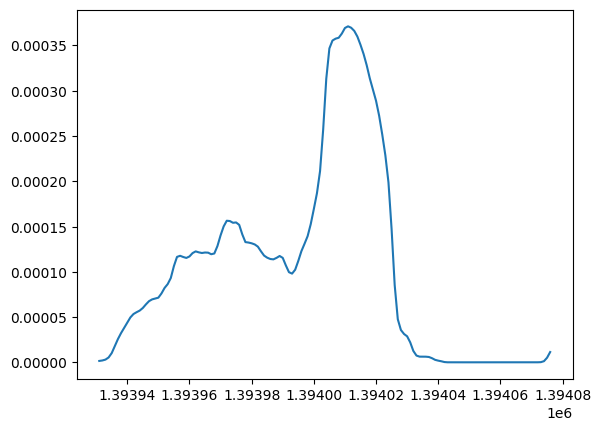

In [111]:
plt.plot(decomps[0][0]['tp_trend']), decomps[0][1]

### Clustering the Decompositions

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer

In [ ]:
decomp_var_trends = []
decomp_var_seasons = []
decomp_var_resids = []
for var in variables.keys():
    decomp_var_trends += [f'{var}_trend']
    decomp_var_seasons += [f'{var}_season']
    decomp_var_resids += [f'{var}_resid']

for decomp in decomps:
    print('-'*21)
    trend_nans = pd.concat(list(map(
        lambda v: pd.Series(
            decomp[0][v].isna().sum(),
            name=v
        ),
        decomp_var_trends
    )), axis=1)
    print(f'trend NaNs: {trend_nans}')
    season_nans = pd.concat(list(map(
        lambda v: pd.Series(
            decomp[0][v].isna().sum(),
            name=v
        ),
        decomp_var_seasons
    )), axis=1)
    print(f'season NaNs: {season_nans}')
    resid_nans = pd.concat(list(map(
        lambda v: pd.Series(
            decomp[0][v].isna().sum(),
            name=v
        ),
        decomp_var_resids
    )), axis=1)
    print(f'resid NaNs: {resid_nans}')

---------------------
trend NaNs:    t2m_trend  msl_trend  skt_trend  sp_trend  ssrd_trend  tp_trend
0         20         18         18        18          24        22
season NaNs:    t2m_season  msl_season  skt_season  sp_season  ssrd_season  tp_season
0           0           0           0          0            0          0
resid NaNs:    t2m_resid  msl_resid  skt_resid  sp_resid  ssrd_resid  tp_resid
0         20         18         18        18          24        22
---------------------
trend NaNs:    t2m_trend  msl_trend  skt_trend  sp_trend  ssrd_trend  tp_trend
0         18         18         18        18          24        18
season NaNs:    t2m_season  msl_season  skt_season  sp_season  ssrd_season  tp_season
0           0           0           0          0            0          0
resid NaNs:    t2m_resid  msl_resid  skt_resid  sp_resid  ssrd_resid  tp_resid
0         18         18         18        18          24        18
---------------------
trend NaNs:    t2m_trend  msl_tr

In [136]:
X_trend_mm = np.stack(list(map(
    lambda d: d[0][decomp_var_trends].values,
    decomps
)))
X_season_mm = np.stack(list(map(
    lambda d: d[0][decomp_var_seasons].values,
    decomps
)))
X_resid_mm = np.stack(list(map(
    lambda d: d[0][decomp_var_resids].values,
    decomps
)))

X_trend_mm.shape, X_season_mm.shape, X_resid_mm.shape

((368, 168, 6), (368, 168, 6), (368, 168, 6))

In [151]:
inp_sprt_decomp = KNNImputer(n_neighbors=24)
X_interp_mm = inp_sprt_decomp.fit_transform(np.concat([
    X_trend_mm, X_season_mm, X_resid_mm
], axis=2).transpose(0,2,1).reshape(-1, 168)).reshape(368, -1, 168).transpose(0, 2, 1)

In [155]:
X_trend_imp = X_interp_mm[:, :, :6]
X_season_imp = X_interp_mm[:, :, 6:12]
X_resid_imp = X_interp_mm[:, :, -6:]
X_trend_imp.shape, X_season_imp.shape, X_resid_imp.shape

((368, 168, 6), (368, 168, 6), (368, 168, 6))

In [ ]:
cluster_st = KMeans(3).fit(
    np.concat([X_trend_imp, X_season_imp], 2).reshape(368, -1)
)

cl_st = cluster_st.predict(
    np.concat([X_trend_imp, X_season_imp], 2).reshape(368, -1)
)
cl_st

c:\Users\szaif\anaconda3\envs\pysim\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,

In [162]:
df_filt

time      u100       v100       u10       v10  \
22656   2025-09-07 00:00:00 -9.818741  11.781036 -7.583176  8.436493   
22657   2025-09-07 01:00:00 -9.241959  11.989532 -7.184097  8.537750   
22658   2025-09-07 02:00:00 -8.642761  12.104980 -6.778000  8.616348   
22659   2025-09-07 03:00:00 -8.766068  12.307983 -6.893509  8.795288   
22660   2025-09-07 04:00:00 -8.597900  12.400330 -6.709503  8.941040   
...                     ...       ...        ...       ...       ...   
1730779 2025-09-30 19:00:00 -6.622925   3.058167 -6.181564  2.737732   
1730780 2025-09-30 20:00:00 -5.559814   3.203323 -5.262024  2.827866   
1730781 2025-09-30 21:00:00 -4.926910   3.252274 -4.763504  2.872665   
1730782 2025-09-30 22:00:00 -5.710815   4.997986 -5.390961  4.460068   
1730783 2025-09-30 23:00:00 -4.597321   5.323853 -4.401627  4.809555   

               d2m        t2m         msl        sst        skt          sp  \
22656    287.66483  292.02628  101447.875  289.96973  289.94885  101446.860   
22657    287.59976  291.94687  101408.940  289.96973  289.94028  101407.650   
22658    287.56880  291.89410  101351.690  289.96973  289.93744  101350.350   
22659    287.58844  291.76904  101254.810  289.96973  289.93546  101253.670   
22660    287.64160  291.64703  101204.310  289.96973  289.93604  101202.690   
...            ...        ...         ...        ...        ...         ...   
1730779  280.29230  286.02832  103233.625  287.88940  287.66763  103244.080   
1730780  280.53607  286.00640  103228.875  287.88940  287.65967  103239.805   
1730781  280.60510  286.10360  103251.875  287.88940  287.65370  103261.560   
1730782  280.73312  286.06116  103237.810  287.66480  287.66547  103248.200   
1730783  280.87836  285.96710  103240.060  287.66480  287.67468  103250.266   

         ssrd       strd        tp   lat  lon         mwd       mwp       swh  \
22656     0.0  1194936.9  0.000000  53.5  1.0  131.092060  4.892267  1.709367   
22657     0.0  1145403.5  0.000000  53.5  1.0  131.507690  4.963750  1.719125   
22658     0.0  1146199.5  0.000000  53.5  1.0  132.249150  5.007956  1.715118   
22659     0.0  1150483.0  0.000000  53.5  1.0  132.993400  5.038896  1.711791   
22660     0.0  1155534.0  0.000000  53.5  1.0  133.570100  5.058062  1.709803   
...       ...        ...       ...   ...  ...         ...       ...       ...   
1730779   0.0  1169772.2  0.000082  58.0  8.5  110.611206  3.899760  0.850064   
1730780   0.0  1206401.6  0.000017  58.0  8.5  113.041176  3.896558  0.816791   
1730781   0.0  1177762.8  0.000013  58.0  8.5  115.253350  3.888679  0.774295   
1730782   0.0  1147523.5  0.000007  58.0  8.5  118.836494  3.811084  0.779467   
1730783   0.0  1142316.5  0.000012  58.0  8.5  123.056470  3.775896  0.782942   

               date  
22656    2025-09-07  
22657    2025-09-07  
22658    2025-09-07  
22659    2025-09-07  
22660    2025-09-07  
...             ...  
1730779  2025-09-30  
1730780  2025-09-30  
1730781  2025-09-30  
1730782  2025-09-30  
1730783  2025-09-30  

[16704 rows x 20 columns]

In [163]:
def add_specification(
    df: pd.DataFrame, 
    specification: (float|int|str|Iterable), 
    col_name: str = 'cluster'
) -> pd.DataFrame:
    if isinstance(specification, Iterable):
        assert len(specification) == len(df)  # type: ignore
    df[col_name] = specification
    return df

In [176]:
df_cluster = pd.concat(list(map(
    lambda data_: add_specification(data_[0][0], data_[1], 'decomp_cluster'),
    zip(decomps, cl_st.tolist())
)), axis=0)

In [177]:
df_cluster['week'] = df_cluster['time'].dt.isocalendar().week
df_cluster

time        date   lat  lon        t2m         msl  \
1393920 2025-02-01 00:00:00  2025-02-01  58.0  7.0  275.32490  102814.440   
1393921 2025-02-01 01:00:00  2025-02-01  58.0  7.0  274.94300  102879.750   
1393922 2025-02-01 02:00:00  2025-02-01  58.0  7.0  274.69604  102914.810   
1393923 2025-02-01 03:00:00  2025-02-01  58.0  7.0  274.60388  102925.310   
1393924 2025-02-01 04:00:00  2025-02-01  58.0  7.0  274.63593  102990.500   
...                     ...         ...   ...  ...        ...         ...   
354187  2025-09-26 19:00:00  2025-09-26  53.5  2.5  288.36212  102292.625   
354188  2025-09-26 20:00:00  2025-09-26  53.5  2.5  288.56450  102290.250   
354189  2025-09-26 21:00:00  2025-09-26  53.5  2.5  288.64470  102278.750   
354190  2025-09-26 22:00:00  2025-09-26  53.5  2.5  288.06080  102243.000   
354191  2025-09-26 23:00:00  2025-09-26  53.5  2.5  288.09723  102218.810   

               skt          sp  ssrd        tp  ...  sp_trend  sp_resid  \
1393920  278.39883  102212.016   0.0  0.000000  ...       NaN       NaN   
1393921  278.37085  102275.330   0.0  0.000000  ...       NaN       NaN   
1393922  278.38345  102309.920   0.0  0.000000  ...       NaN       NaN   
1393923  278.39844  102318.310   0.0  0.000000  ...       NaN       NaN   
1393924  278.43613  102383.140   0.0  0.000000  ...       NaN       NaN   
...            ...         ...   ...       ...  ...       ...       ...   
354187   289.06067  102281.970   0.0  0.000052  ...       NaN       NaN   
354188   289.05084  102278.670   0.0  0.000027  ...       NaN       NaN   
354189   289.05646  102268.390   0.0  0.000050  ...       NaN       NaN   
354190   289.03424  102232.040   0.0  0.000047  ...       NaN       NaN   
354191   289.02960  102208.200   0.0  0.000040  ...       NaN       NaN   

           ssrd_season  ssrd_trend  ssrd_resid  tp_season  tp_trend  tp_resid  \
1393920 -111899.287037         NaN         NaN  -0.000027       NaN       NaN   
1393921 -114344.842593         NaN         NaN  -0.000008       NaN       NaN   
1393922 -116717.731481         NaN         NaN   0.000032       NaN       NaN   
1393923 -118747.731481         NaN         NaN   0.000020       NaN       NaN   
1393924 -119938.842593         NaN         NaN   0.000038       NaN       NaN   
...                ...         ...         ...        ...       ...       ...   
354187  -468119.703704         NaN         NaN  -0.000016       NaN       NaN   
354188  -465942.148148         NaN         NaN  -0.000030       NaN       NaN   
354189  -462067.481481         NaN         NaN  -0.000039       NaN       NaN   
354190  -459042.592593         NaN         NaN  -0.000037       NaN       NaN   
354191  -459585.259259         NaN         NaN  -0.000031       NaN       NaN   

         decomp_cluster  week  
1393920               1     5  
1393921               1     5  
1393922               1     5  
1393923               1     5  
1393924               1     5  
...                 ...   ...  
354187                2    39  
354188                2    39  
354189                2    39  
354190                2    39  
354191                2    39  

[61824 rows x 30 columns]

### Vizualization

In [219]:
variables

{'t2m': '2m Temperature',
 'msl': 'Mean Sea Level',
 'skt': 'Skin Temperature',
 'sp': 'Surface Pressure',
 'ssrd': 'Surface Solar Radiation Downwards',
 'tp': 'Total Precipitation'}

In [238]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display

# Prepare dropdown options
selected_vars = list(variables.keys())  # list of variable names
weeks = sorted(df_cluster['week'].unique())
coords = sorted(set(zip(df_cluster['lat'], df_cluster['lon'])))
coord_strings = [f"({lat},{lon})" for lat, lon in coords]

week_dropdown = widgets.Dropdown(options=weeks, value=weeks[0], description='Week:')
coord_dropdown = widgets.Dropdown(options=coord_strings, value=coord_strings[0], description='Coordinate:')

# Arrange dropdowns side by side
controls = widgets.HBox([week_dropdown, coord_dropdown])

# Display controls first
controls.layout.width = '1400px'
display(controls)

# Create FigureWidget for interactive plots
fig = go.FigureWidget(make_subplots(
    rows=3, cols=2,
    specs=[[{"type": "mapbox"}, {"type": "xy"}],
           [{"type": "mapbox"}, {"type": "xy"}],
           [{"type": "mapbox"}, {"type": "xy"}]],
    column_widths=[0.50, 0.50],
    row_heights=[0.33, 0.33, 0.34],
    vertical_spacing=0.025,
    horizontal_spacing=.025
))

# temprary assignment
selected_week = week_dropdown.value
df_week = df_cluster[df_cluster['week'] == selected_week]
    
# Plot the cluster map on the left spanning rows
fig.add_trace(go.Scattermapbox(
    lat=df_week['lat'], lon=df_week['lon'],
    mode='markers',
    marker=dict(color=df_week['decomp_cluster'], size=10, colorscale='Viridis'),
    text=["Cluster: " + str(c) for c in df_week['decomp_cluster']],
    showlegend=False,
), row=1, col=1)

# Update map layout once
lat_min, lat_max = df_cluster['lat'].min(), df_cluster['lat'].max()
lon_min, lon_max = df_cluster['lon'].min(), df_cluster['lon'].max()
fig.update_layout(
    mapbox=dict(
        domain=dict(x=[0, 0.45], y=[0, 1]),
        center={"lat": (lat_min + lat_max) // 2, "lon": (lon_min + lon_max) // 2},
        zoom=5.25,
        style="carto-positron",
    )
)

def clear_traces(fig):
    fig.data = []

def update_figure(change):
    # Parse selected coordinate string to tuple
    selected_coord = tuple(map(float, coord_dropdown.value.strip('()').split(',')))
    selected_week = week_dropdown.value
    df_week = df_cluster[df_cluster['week'] == selected_week]

    # Clear existing traces safely
    clear_traces(fig)
    
    # Plot the cluster map on the left spanning rows
    fig.add_trace(go.Scattermapbox(
        lat=df_week['lat'], lon=df_week['lon'],
        mode='markers',
        marker=dict(color=df_week['decomp_cluster'], size=10, colorscale='Viridis'),
        text=["Cluster: " + str(c) for c in df_week['decomp_cluster']],
        showlegend=False,
    ), row=1, col=1)

    point = df_week['lat'] == selected_coord[0]
    point &= df_week['lon'] == selected_coord[1]
    df_point = df_week[point]
    
    # Plot trend, seasonal, residual for right column rows
    components = ['trend', 'season', 'resid']
    for i, component in enumerate(components, start=1):
        for var in selected_vars:
            y_arr = df_point[var + '_' + component].values
            y_arr_den = np.nanmax(np.abs(y_arr)) + 1e-8
            y_arr /= y_arr_den
            # if df_point.empty:
            #     logging.warning(f'Empty DataFrame at {selected_coord} on week {selected_week}')
            #     continue
            fig.add_trace(go.Scatter(
                y=y_arr, mode='lines',
                name=f"{component.capitalize()} {var} (den: {y_arr_den :0.2f}) {selected_coord}"
            ), row=i, col=2)
    fig.show()

# Bind dropdown changes to update function
week_dropdown.observe(update_figure, names='value')
coord_dropdown.observe(update_figure, names='value')

# Display and initial figure
fig.layout.width = 1600
fig.layout.height = 800
display(fig)
update_figure(None)


C:\Users\szaif\AppData\Local\Temp\ipykernel_27352\3678340561.py:39: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



FigureWidget({
    'data': [{'lat': {'bdata': ('AAAAAAAATUAAAAAAAABNQAAAAAAAAE' ... 'AAAADASkAAAAAAAMBKQAAAAAAAwEpA'),
                      'dtype': 'f8'},
              'lon': {'bdata': ('AAAAAAAAHEAAAAAAAAAcQAAAAAAAAB' ... 'AAAAAABEAAAAAAAAAEQAAAAAAAAARA'),
                      'dtype': 'f8'},
              'marker': {'color': {'bdata': ('AQEBAQEBAQEBAQEBAQEBAQEBAQEBAQ' ... 'EBAQEBAQEBAQEBAQEBAQEBAQEBAQEB'),
                                   'dtype': 'i1'},
                         'colorscale': [[0.0, '#440154'], [0.1111111111111111,
                                        '#482878'], [0.2222222222222222,
                                        '#3e4989'], [0.3333333333333333,
                                        '#31688e'], [0.4444444444444444,
                                        '#26828e'], [0.5555555555555556,
                                        '#1f9e89'], [0.6666666666666666,
                                        '#35b779'], [0.7777777777777778,
                

C:\Users\szaif\AppData\Local\Temp\ipykernel_27352\3678340561.py:72: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



ValueError: 
Invalid property path 'mapbox._derived' for layout


ValueError: 
Invalid property path 'mapbox._derived' for layout


ValueError: 
Invalid property path 'mapbox._derived' for layout


ValueError: 
Invalid property path 'mapbox._derived' for layout


ValueError: 
Invalid property path 'mapbox._derived' for layout


ValueError: 
Invalid property path 'mapbox._derived' for layout


ValueError: 
Invalid property path 'mapbox._derived' for layout


In [ ]:
fig, ax = plt.subplots(3, 1)
for cl in df_cluster['cluster'].unique():
    decompdf_cluster[df_cluster['clusrter']==cl]

KeyError: 'clusrter'

#### conclusion

When looking into the decompositions and how they are clustered we see a trend between 

### Windowed Decompositions

In [ ]:
from utils.tsa_features import wavelet_feature_variables

In [227]:
df_wav = wavelet_feature_variables(df_cluster, list(variables.keys()), window=48, step=12)

NameError: name 'wavelet_feature_variables' is not defined